In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
import seaborn as sns

from numba.core.errors import NumbaWarning, NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings

warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

In [2]:
from scipy.stats import multivariate_normal

# cov1 = np.array([[10, 1], [1, 5]])
cov1 = np.eye(2)
mu1 = [1, 3]

@jit
def target_1(z, mean=mu1, cov=cov1):
    assert(len(z) == 2)
    
    return multivariate_normal.pdf(z, mean=mean, cov=cov)

Text(0.5, 1.0, 'Contour plot of the density for a = 10')

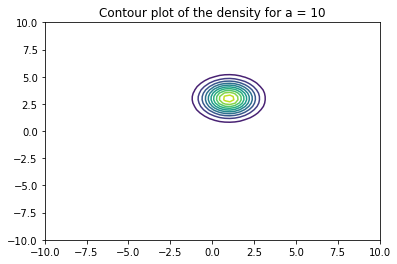

In [3]:
X = np.linspace(-15, 15, 100)
Y = np.linspace(-15, 15, 100)

Z = np.zeros((len(X), len(Y)))


for i in range(len(X)):
    for j in range(len(Y)):
        Z[i, j] = target_1([X[i], Y[j]])
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.contour(X, Y, Z.T, levels=10)
plt.title("Contour plot of the density for a = 10")

In [7]:
@jit
def sampler_full(z0, pi, drift, sigma, maxIter, batch_size=50):
    d = len(z0)
    z = z0
    
    samples = np.zeros((maxIter, d))
    count_accept = 0
    mean_acceptance_rate = []
    
    for i in range(maxIter):
        z_proposal = z + sigma**2 / 2  * drift(z) + np.random.multivariate_normal(mean=[0 for _ in range(d)], cov=sigma**2 * np.eye(d))
        # print(z, sigma**2 / 2 * drift(z), z_proposal)
        log_alpha = min(0, np.log(pi(z_proposal) + 1e-8) - np.log(pi(z) + 1e-8))
        
        if np.log(np.random.rand()) < log_alpha:
            z = z_proposal
            count_accept += 1
        
        if i % batch_size == 0:
            mean_acceptance_rate.append(count_accept / batch_size)
            count_accept = 0

        samples[i, :] = z
    
    return samples, mean_acceptance_rate        

In [4]:
import pandas as pd
def cross_corr(x, y, max_lag=None):
    """
    Cross-correlation function of 2 time series
    """
    if max_lag is None:
        max_lag = len(x)
    
    sx = pd.Series(x)
    sy = pd.Series(y)
    res = np.zeros(max_lag)
    for lag in range(1, max_lag):
        res[lag] = sx.corr(sy.shift(lag))
    res[0] = 1
    return res

def plot_graphs(Z, MR):
    """
    function to plot 4 graphs:
        * sample
        * mean acceptance ratio
        * cross-correlation of the last 1000 samples
        * cross-correlation of all the samples
    """
    nb_iter = Z.shape[0]
    burn_in = nb_iter // 2
    
    fig = plt.figure(figsize=(10, 10))   
    
    ax0 = fig.add_subplot(2, 2, 1)    
    X = samples[burn_in:, 0]
    Y = samples[burn_in:, 1]    
    grid_x = np.linspace(-5, 5, 1000)
    grid_y = np.linspace(-5, 5, 1000)
    ax0.plot(X, Y, "x")
    ax0.set_xlabel("Sample with MH")
    
    ax1 = fig.add_subplot(2, 2, 2)
    ax1.plot(np.arange(len(MR)), MR, "-x")
    ax1.set_xlabel("Mean Acceptance Ratio")
    
    
    
    ax3 = fig.add_subplot(2, 2, 3)
    X = samples[-1000:, 0]
    Y = samples[-1000:, 1]
    c_xx = cross_corr(X, X, max_lag=100)
    c_yy = cross_corr(Y, Y, max_lag=100)
    c_xy = cross_corr(X, Y, max_lag=100)

    ax3.plot(np.arange(c_xx.shape[0]), c_xx, label="Corr(x, x)")
    ax3.plot(np.arange(c_yy.shape[0]), c_yy, label="Corr(x, y)")
    ax3.plot(np.arange(c_xy.shape[0]), c_xy, label="Corr(y, y)")
    ax3.set_xlabel("Time shift")
    ax3.set_ylabel("Correlation (1000 last samples)")
    ax3.legend()
    
    ax4 = fig.add_subplot(2, 2, 4)
    X = samples[:, 0]
    Y = samples[:, 1]
    c_xx = cross_corr(X, X, max_lag=100)
    c_yy = cross_corr(Y, Y, max_lag=100)
    c_xy = cross_corr(X, Y, max_lag=100)

    ax4.plot(np.arange(c_xx.shape[0]), c_xx, label="Corr(x, x)")
    ax4.plot(np.arange(c_yy.shape[0]), c_yy, label="Corr(x, y)")
    ax4.plot(np.arange(c_xy.shape[0]), c_xy, label="Corr(y, y)")
    ax4.set_xlabel("Time shift")
    ax4.set_ylabel("Correlation all")
    ax4.legend()
    
    plt.show()

In [5]:
@jit
def no_drift(z):
    d = len(z)
    return np.zeros((d))

@jit
def drift(z, mean=mu1, cov=cov1, delta=1000):
    assert(len(z) == 2)
    x, y = z
    
    mean = np.array(mean)
    
    gradient = - np.linalg.inv(cov) @ (z - mean)
    norm_grad = np.linalg.norm(gradient)    
    
    
    return delta / max(delta, norm_grad) * gradient     

Mean acceptance ratio 0.28259999999999996


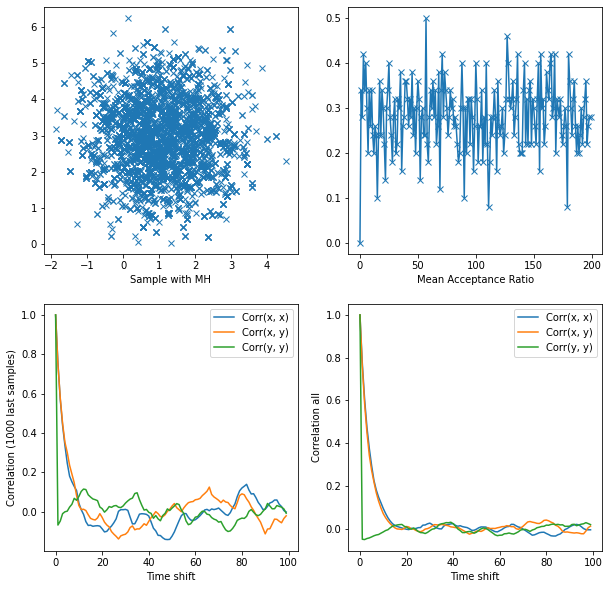

Estimation of the mean (x-axis) 1.0697607004221892
Estimation of the mean (y-axis) 2.954243100316169
Estimation of the covariance matrix [[ 0.90877991 -0.02840622]
 [-0.02840622  0.92315408]]


In [7]:
# fine tune sigma to get acceptance ratio around .2
sample_size = 10000
samples, mean_rate = sampler_full([0, 0], target_1, no_drift, 2, sample_size, batch_size=50)
print("Mean acceptance ratio", np.mean(mean_rate))

plot_graphs(samples, mean_rate)

burn_in = sample_size//2
X = samples[burn_in:, 0]
Y = samples[burn_in:, 1]

print("Estimation of the mean (x-axis)", np.mean(X))
print("Estimation of the mean (y-axis)", np.mean(Y))
print("Estimation of the covariance matrix", np.cov(X, Y))

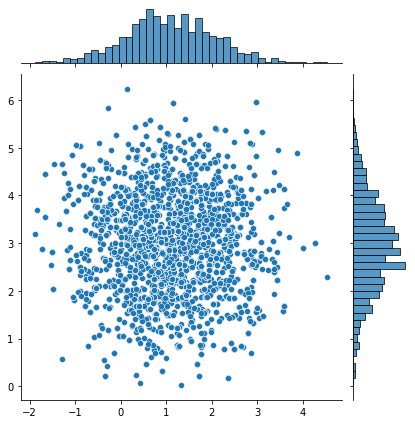

In [8]:
sns.jointplot(x=X, y=Y)

Mean acceptance ratio 0.48330000000000006


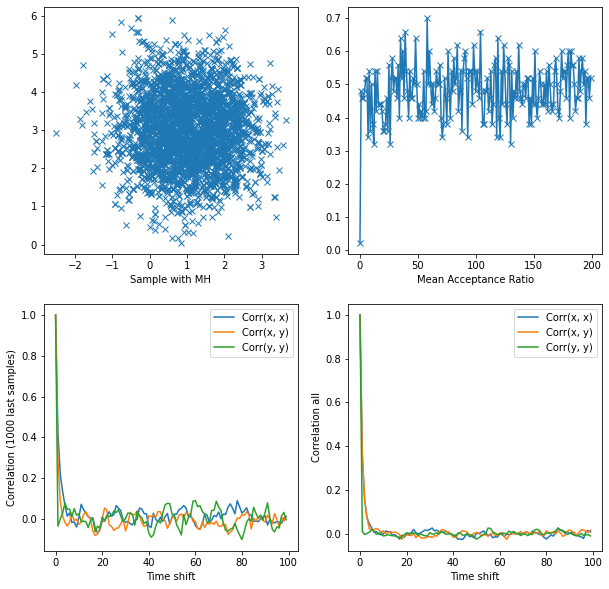

Estimation of the mean (x-axis) 1.0124054879981443
Estimation of the mean (y-axis) 2.9987732877475497
Estimation of the covariance matrix [[ 0.71421833 -0.01645827]
 [-0.01645827  0.74037289]]


In [9]:
# fine tune to get acceptance ratio around .5
sample_size = 10000
samples, mean_rate = sampler_full([0, 0], target_1, drift, 1.5, sample_size, batch_size=50)
print("Mean acceptance ratio", np.mean(mean_rate))

plot_graphs(samples, mean_rate)


burn_in = sample_size//2
X = samples[burn_in:, 0]
Y = samples[burn_in:, 1]

print("Estimation of the mean (x-axis)", np.mean(X))
print("Estimation of the mean (y-axis)", np.mean(Y))
print("Estimation of the covariance matrix", np.cov(X, Y))

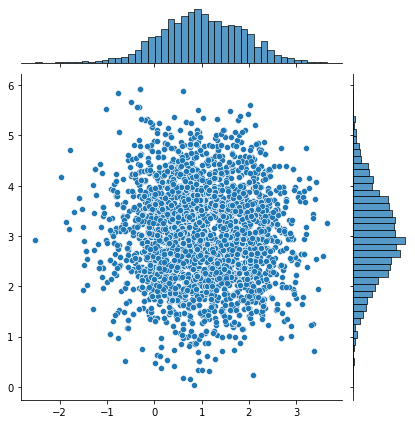

In [10]:
sns.jointplot(x=X, y=Y)

**Comment**

In terms of the estimation of the mean along the two axis and the cross-correlation graphs, the results seem fine. However, it seems that the results in terms of the covariance matrix seem off.

In [33]:
# global variables
eps1 = 1e-7
eps2 = 1e-6
A1 = 1e7


def p1(sigma):
    if sigma < eps1:
        return eps1
    elif sigma > A1:
        return A1
    return sigma


def p2(Sigma):
    frob_norm = np.linalg.norm(Sigma)
    if frob_norm <= A1:
        return Sigma
    return A1/frob_norm * Sigma


def p3(x):
    x_norm = np.linalg.norm(x)
    if x_norm <= A1:
        return x
    return A1 / x_norm * x


def sampler_full_adaptive(z0, pi, drift, maxIter, tau_bar=.5, batch_size=50):
    # initialisation
    d = len(z0)
    z = z0
    
    mu = [0 for _ in range(d)]
    Lambda = np.eye(d)
    sigma = 1
    
    samples = np.zeros((maxIter, d))
    count_accept = 0
    mean_acceptance_rate = []
    
    for i in range(maxIter):
        # set Delta n
        Delta = Lambda + eps2 * np.eye(d)
        z_proposal = z + sigma**2 / 2  * Delta @ drift(z) + np.random.multivariate_normal(mean=mu, cov=Delta)
        # print(z_proposal)
        log_alpha = min(0, np.log(pi(z_proposal) + 1e-8) - np.log(pi(z) + 1e-8))
        
        if np.log(np.random.rand()) < log_alpha:
            z = z_proposal
            count_accept += 1
        
        if i % batch_size == 0:
            mean_acceptance_rate.append(count_accept / batch_size)
            count_accept = 0
            
        if i >= maxIter // 10:
            # print(10/i * (np.exp(log_alpha) - tau_bar), sigma + 10/i * (np.exp(log_alpha) - tau_bar))
            sigma = p1(sigma + 10/i * (np.exp(log_alpha) - tau_bar))
            # print(sigma)
            if i % 5000 == 0:   
                # sigma = p1(sigma + 10/i * (np.exp(log_alpha) - tau_bar))
                mu = p3(mu + 10/i * (z - mu))
                Lambda = p2(Lambda + 10/i * ((z - mu) @ (z - mu).T - Lambda))
        
        
        samples[i, :] = z
    print("sigma", sigma)
    print("mu", mu)
    print("Lambda", Lambda)
    return samples, mean_acceptance_rate        

sigma 2.018568999063395
mu [0.00069128 0.00871621]
Lambda [[1.0360723 0.0380723]
 [0.0380723 1.0360723]]
Mean acceptance ratio 0.5259


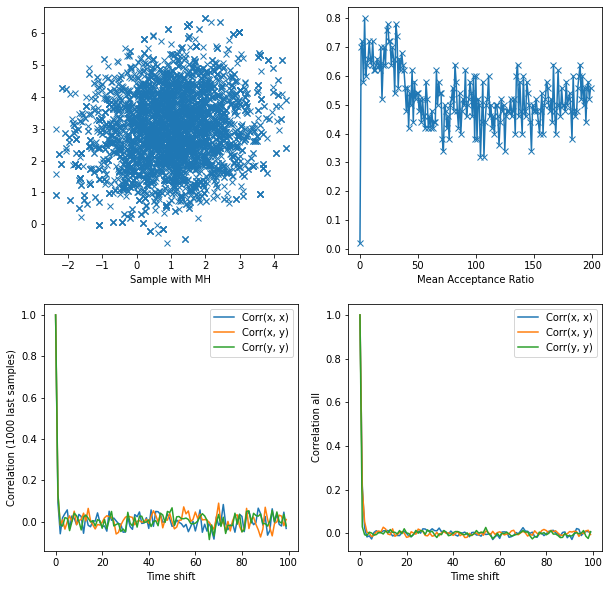

Estimation of the mean (x-axis) 1.0194385751780126
Estimation of the mean (y-axis) 2.9904710426813903
Estimation of the covariance matrix [[1.34678603 0.22493641]
 [0.22493641 1.32762195]]


In [16]:
sample_size = 10000
samples, mean_rate = sampler_full_adaptive([0, 0], target_1, drift, maxIter=sample_size, tau_bar=.5, batch_size=50)
print("Mean acceptance ratio", np.mean(mean_rate))
plot_graphs(samples, mean_rate)

burn_in = sample_size//2
X = samples[burn_in:, 0]
Y = samples[burn_in:, 1]

print("Estimation of the mean (x-axis)", np.mean(X))
print("Estimation of the mean (y-axis)", np.mean(Y))
print("Estimation of the covariance matrix", np.cov(X, Y))

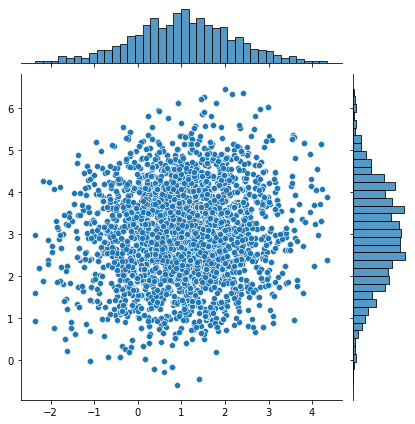

In [17]:
sns.jointplot(x=X, y=Y)

sigma 0.9998495167094454
mu [-0.00036531  0.00762755]
Lambda [[1.02703994 0.02903994]
 [0.02903994 1.02703994]]
Mean acceptance ratio 0.5448000000000001


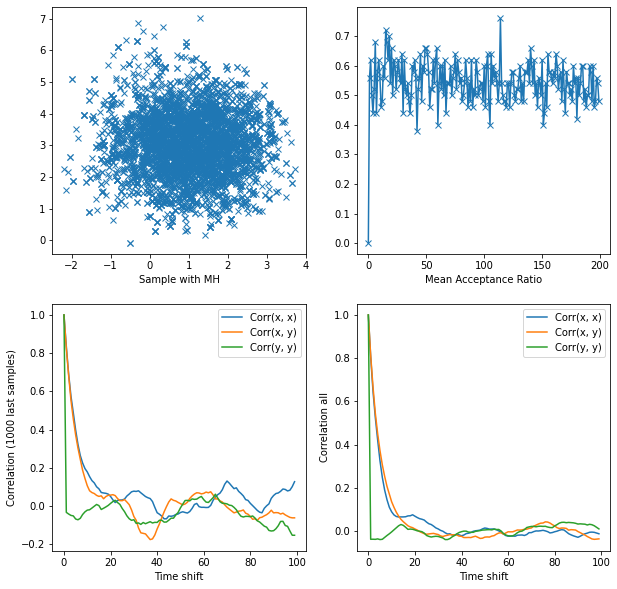

Estimation of the mean (x-axis) 0.9927799208495905
Estimation of the mean (y-axis) 3.0358723749651317
Estimation of the covariance matrix [[ 0.99592359 -0.03486962]
 [-0.03486962  1.00814816]]


In [32]:
sample_size = 10000
samples, mean_rate = sampler_full_adaptive([0, 0], target_1, no_drift, maxIter=sample_size, tau_bar=.2, batch_size=50)

print("Mean acceptance ratio", np.mean(mean_rate))
plot_graphs(samples, mean_rate)



burn_in = sample_size//2
X = samples[burn_in:, 0]
Y = samples[burn_in:, 1]

print("Estimation of the mean (x-axis)", np.mean(X))
print("Estimation of the mean (y-axis)", np.mean(Y))
print("Estimation of the covariance matrix", np.cov(X, Y))

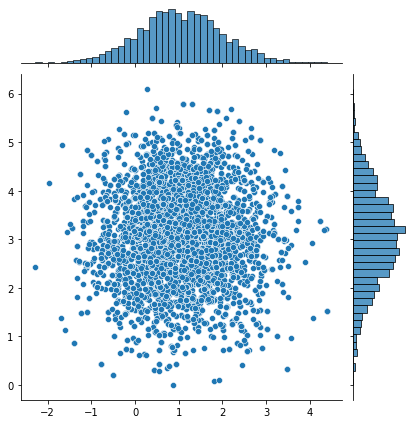

In [21]:
sns.jointplot(x=X, y=Y)

**Comment**

Regarder pouquoi cela marche bien dans le cas de MALA adaptatif mais pas dans le cas de la Symmetric Random Walk. Je pense que cela est dû au fait que la SRW converge très vite vers une solution acceptable et donc il est difficile d'augmenter le ratio. 

# Testing with a more difficult distrubtion 

In [9]:
B0 = 5 * 1e-2
@jit
def target2(X, B=B0):
    X = np.array(X)
    d = len(X)
    res = -X[0]**2 / 100 
    res -= .5 * (X[1] + B*X[0]**2 - 100*B)**2
    res -= .5 * np.sum(X[2:] ** 2)
    return np.exp(res)   

@jit
def log_target2(X, B=B0):
    X = np.array(X)
    d = len(X)
    res = -X[0]**2 / 100 
    res -= .5 * (X[1] + B*X[0]**2 - 100*B)**2
    res -= .5 * np.sum(X[2:] ** 2)
    return res

@jit
def grad_log_target2(X, B=B0):
    n = len(X)
    grad = -np.array(X)
    grad[0] = -2/100*X[0] - 2*X[0]*(X[1] + B*X[0]**2-100*B)
    grad[1] = -(X[1] + B*X[1]**2 - 100*B)
    return grad  
  
@jit
def drift2(X, B=B0, delta=1000):
    grad = grad_log_target2(X, B=B)
    # print(X, grad)
    norm_grad = np.linalg.norm(grad)
    # print(delta / max(delta, norm_grad))
    return delta / max(delta, norm_grad) * grad
    

Text(0.5, 1.0, 'Contour plot of the density for a = 10')

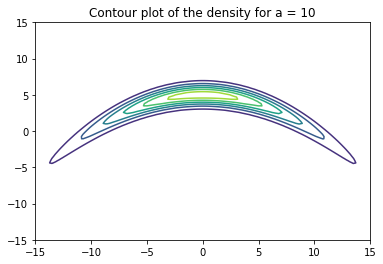

In [38]:
X = np.linspace(-15, 15, 100)
Y = np.linspace(-15, 15, 100)

Z = np.zeros((len(X), len(Y)))


for i in range(len(X)):
    for j in range(len(Y)):
        Z[i, j] = target2([X[i], Y[j]])

plt.contour(X, Y, Z.T)
plt.title("Contour plot of the density for a = 10")

[0, 0] [0. 0.] [-2.02176819 -2.81230357]
[0, 0] [0. 0.] [-2.0056052   1.20688325]
[-2.0056052   1.20688325] [0. 0.] [ 5.78168484 -6.7893338 ]
[-2.0056052   1.20688325] [0. 0.] [ 1.88944301 10.366227  ]
[-2.0056052   1.20688325] [0. 0.] [-3.3307967   4.52731765]
[-3.3307967   4.52731765] [0. 0.] [-2.14242409  1.28773119]
[-3.3307967   4.52731765] [0. 0.] [-0.81591762  2.9723147 ]
[-3.3307967   4.52731765] [0. 0.] [-4.68948715  5.32547759]
[-4.68948715  5.32547759] [0. 0.] [-4.99892856  0.5868105 ]
[-4.68948715  5.32547759] [0. 0.] [-6.24164924  3.22397882]
[-6.24164924  3.22397882] [0. 0.] [-4.61874709  0.46341367]
[-6.24164924  3.22397882] [0. 0.] [-8.6470838   5.02088315]
[-6.24164924  3.22397882] [0. 0.] [-3.15410363  1.79269649]
[-6.24164924  3.22397882] [0. 0.] [-6.10781247  3.04987528]
[-6.10781247  3.04987528] [0. 0.] [-9.44735319 -8.03667854]
[-6.10781247  3.04987528] [0. 0.] [0.67769696 2.49866056]
[-6.10781247  3.04987528] [0. 0.] [-6.71568732 -5.98400348]
[-6.10781247  3.0498

[7.60724019 0.89462808] [0. 0.] [8.04882676 1.79175103]
[8.04882676 1.79175103] [0. 0.] [4.69484686 2.52860176]
[4.69484686 2.52860176] [0. 0.] [6.74272845 3.22984861]
[6.74272845 3.22984861] [0. 0.] [4.80210866 4.65180998]
[4.80210866 4.65180998] [0. 0.] [11.01134621  9.70816995]
[4.80210866 4.65180998] [0. 0.] [3.89609529 8.93704096]
[4.80210866 4.65180998] [0. 0.] [0.5187107  8.45790717]
[4.80210866 4.65180998] [0. 0.] [8.55440307 7.94995798]
[4.80210866 4.65180998] [0. 0.] [4.0873918  6.07569484]
[4.80210866 4.65180998] [0. 0.] [5.61401434 0.19643299]
[4.80210866 4.65180998] [0. 0.] [4.24842742 7.09417509]
[4.80210866 4.65180998] [0. 0.] [3.727653   9.06908398]
[4.80210866 4.65180998] [0. 0.] [ 3.01371865 -1.01527401]
[4.80210866 4.65180998] [0. 0.] [ 2.8661898  13.20822037]
[4.80210866 4.65180998] [0. 0.] [9.53694206 2.08505954]
[4.80210866 4.65180998] [0. 0.] [1.00116876 7.81445309]
[4.80210866 4.65180998] [0. 0.] [-0.23560378  6.60819188]
[4.80210866 4.65180998] [0. 0.] [7.72650

[-2.46290133  5.67133742] [0. 0.] [-2.86536992 10.73891893]
[-2.46290133  5.67133742] [0. 0.] [-4.32090459  4.64950375]
[-4.32090459  4.64950375] [0. 0.] [-1.77861749  2.81758252]
[-4.32090459  4.64950375] [0. 0.] [-6.60486092  5.44824512]
[-4.32090459  4.64950375] [0. 0.] [-1.45358177 10.65805684]
[-4.32090459  4.64950375] [0. 0.] [-3.18700136  5.36202093]
[-3.18700136  5.36202093] [0. 0.] [9.67264238 6.04488255]
[-3.18700136  5.36202093] [0. 0.] [5.8383017  3.08278564]
[5.8383017  3.08278564] [0. 0.] [5.28637779 4.29983693]
[5.28637779 4.29983693] [0. 0.] [5.1360266  2.39525352]
[5.28637779 4.29983693] [0. 0.] [7.72664925 8.26802085]
[5.28637779 4.29983693] [0. 0.] [0.81407249 5.69308526]
[0.81407249 5.69308526] [0. 0.] [-3.95665986  9.71777482]
[0.81407249 5.69308526] [0. 0.] [-4.10069526  1.65564235]
[0.81407249 5.69308526] [0. 0.] [-3.91710437  1.07694726]
[0.81407249 5.69308526] [0. 0.] [6.39085938 2.14116539]
[6.39085938 2.14116539] [0. 0.] [ 6.58893631 -4.73169686]
[6.39085938 

[2.12718377 4.28279897] [0. 0.] [ 4.21701849 -2.54285746]
[2.12718377 4.28279897] [0. 0.] [8.09949752 1.68276018]
[2.12718377 4.28279897] [0. 0.] [10.28237172  7.006675  ]
[2.12718377 4.28279897] [0. 0.] [4.25553019 5.14813334]
[4.25553019 5.14813334] [0. 0.] [6.43055316 9.90323548]
[4.25553019 5.14813334] [0. 0.] [4.46073779 2.19086176]
[4.25553019 5.14813334] [0. 0.] [-1.05905499  1.63373737]
[4.25553019 5.14813334] [0. 0.] [5.53998672 1.2549911 ]
[4.25553019 5.14813334] [0. 0.] [6.7369258  5.73416781]
[4.25553019 5.14813334] [0. 0.] [8.5749141  7.31120756]
[4.25553019 5.14813334] [0. 0.] [ 3.45870811 11.33801266]
[4.25553019 5.14813334] [0. 0.] [ 3.7076541  -2.11987122]
[4.25553019 5.14813334] [0. 0.] [7.48203812 6.03756417]
[4.25553019 5.14813334] [0. 0.] [7.42882419 9.22270681]
[4.25553019 5.14813334] [0. 0.] [8.70963137 6.94823092]
[4.25553019 5.14813334] [0. 0.] [7.4695556  7.61091999]
[4.25553019 5.14813334] [0. 0.] [10.95949845 -3.35622085]
[4.25553019 5.14813334] [0. 0.] [ 3.

[6.93827277 3.64150527] [0. 0.] [6.54106315 3.51291276]
[6.54106315 3.51291276] [0. 0.] [11.12234694  3.79182688]
[6.54106315 3.51291276] [0. 0.] [7.56161282 0.03266834]
[6.54106315 3.51291276] [0. 0.] [1.68189307 1.09848728]
[6.54106315 3.51291276] [0. 0.] [8.90771642 3.69462699]
[6.54106315 3.51291276] [0. 0.] [1.46030831 7.71192967]
[6.54106315 3.51291276] [0. 0.] [5.77543093 5.90507405]
[6.54106315 3.51291276] [0. 0.] [7.93481101 6.63418233]
[6.54106315 3.51291276] [0. 0.] [ 8.84525    -3.33199418]
[6.54106315 3.51291276] [0. 0.] [4.3055641  8.23340273]
[6.54106315 3.51291276] [0. 0.] [-1.03540036 -0.83786047]
[6.54106315 3.51291276] [0. 0.] [-3.03182332  7.3351747 ]
[6.54106315 3.51291276] [0. 0.] [5.43121489 3.47390428]
[5.43121489 3.47390428] [0. 0.] [1.72423822 2.04620001]
[5.43121489 3.47390428] [0. 0.] [4.31339632 1.51787303]
[5.43121489 3.47390428] [0. 0.] [6.41303757 2.07003855]
[6.41303757 2.07003855] [0. 0.] [5.48149345 0.39408143]
[6.41303757 2.07003855] [0. 0.] [5.64097

[-8.28754612  2.89873945] [0. 0.] [-8.22785459 -3.89408622]
[-8.28754612  2.89873945] [0. 0.] [-12.15449453   1.59216911]
[-8.28754612  2.89873945] [0. 0.] [-8.48055622 -0.41683826]
[-8.48055622 -0.41683826] [0. 0.] [-13.85540815  -2.31990067]
[-13.85540815  -2.31990067] [0. 0.] [-17.11543895   3.31671925]
[-13.85540815  -2.31990067] [0. 0.] [-11.84962993   1.98401754]
[-13.85540815  -2.31990067] [0. 0.] [-13.78505837 -11.56007889]
[-13.85540815  -2.31990067] [0. 0.] [-15.97468359  -5.84976824]
[-15.97468359  -5.84976824] [0. 0.] [-24.66740251  -7.0533018 ]
[-15.97468359  -5.84976824] [0. 0.] [-11.68145673  -4.35287309]
[-11.68145673  -4.35287309] [0. 0.] [-11.11745542  -3.53982976]
[-11.11745542  -3.53982976] [0. 0.] [-11.04325362  -8.82834976]
[-11.11745542  -3.53982976] [0. 0.] [-16.65441791  -1.73697719]
[-11.11745542  -3.53982976] [0. 0.] [-12.93085354  -8.42688094]
[-11.11745542  -3.53982976] [0. 0.] [-10.2759898   -5.03510343]
[-11.11745542  -3.53982976] [0. 0.] [-7.41682383 -1.

[-2.3684023   5.08188322] [0. 0.] [1.85378493 5.44379874]
[1.85378493 5.44379874] [0. 0.] [0.03642921 7.76153187]
[1.85378493 5.44379874] [0. 0.] [-0.06975381  6.52175725]
[-0.06975381  6.52175725] [0. 0.] [-1.33756321  4.49310609]
[-1.33756321  4.49310609] [0. 0.] [-4.60357909 -0.5645563 ]
[-1.33756321  4.49310609] [0. 0.] [3.82031709 1.22224118]
[-1.33756321  4.49310609] [0. 0.] [1.08714846 5.9552769 ]
[1.08714846 5.9552769 ] [0. 0.] [14.99852177  2.31478419]
[1.08714846 5.9552769 ] [0. 0.] [ 3.44761863 13.83780527]
[1.08714846 5.9552769 ] [0. 0.] [-0.19030834 -0.68385923]
[1.08714846 5.9552769 ] [0. 0.] [ 0.49361204 11.47900558]
[1.08714846 5.9552769 ] [0. 0.] [-7.58439637  3.65753353]
[1.08714846 5.9552769 ] [0. 0.] [-0.12605511 -1.20780967]
[1.08714846 5.9552769 ] [0. 0.] [-5.03083657  6.20744069]
[-5.03083657  6.20744069] [0. 0.] [-6.99137272  8.33417302]
[-5.03083657  6.20744069] [0. 0.] [ 6.23167889 10.44165141]
[-5.03083657  6.20744069] [0. 0.] [-3.85663966  5.45239258]
[-3.85

[0.44160105 5.0473351 ] [0. 0.] [-4.90963924  4.68054359]
[0.44160105 5.0473351 ] [0. 0.] [1.25482429 4.85568951]
[1.25482429 4.85568951] [0. 0.] [ 3.06329638 -1.02849238]
[1.25482429 4.85568951] [0. 0.] [-3.34749262  9.31906472]
[1.25482429 4.85568951] [0. 0.] [ 1.84129059 -1.30582334]
[1.25482429 4.85568951] [0. 0.] [9.21341075 8.12850323]
[1.25482429 4.85568951] [0. 0.] [3.02679595 8.64870024]
[1.25482429 4.85568951] [0. 0.] [-1.55952446  3.3267054 ]
[1.25482429 4.85568951] [0. 0.] [-2.19634702  1.21756681]
[1.25482429 4.85568951] [0. 0.] [8.56871612 2.90456401]
[1.25482429 4.85568951] [0. 0.] [1.11895793 8.95614226]
[1.25482429 4.85568951] [0. 0.] [-6.02936573  5.73954946]
[1.25482429 4.85568951] [0. 0.] [0.13615715 5.72978007]
[0.13615715 5.72978007] [0. 0.] [-1.07548225  5.66036541]
[-1.07548225  5.66036541] [0. 0.] [4.10287215 0.70038379]
[-1.07548225  5.66036541] [0. 0.] [-5.00412754  2.70163629]
[-5.00412754  2.70163629] [0. 0.] [-11.60726713  10.60185782]
[-5.00412754  2.7016

[8.5175328 0.8403307] [0. 0.] [10.42733398 -2.76370669]
[8.5175328 0.8403307] [0. 0.] [ 9.88746364 -0.88813955]
[8.5175328 0.8403307] [0. 0.] [ 5.54497812 -6.31386573]
[8.5175328 0.8403307] [0. 0.] [ 4.89998175 -2.12037445]
[8.5175328 0.8403307] [0. 0.] [9.56630187 3.3669565 ]
[8.5175328 0.8403307] [0. 0.] [6.91961077 0.91468136]
[8.5175328 0.8403307] [0. 0.] [ 9.27147653 -1.49155546]
[ 9.27147653 -1.49155546] [0. 0.] [11.41785831 -3.07672752]
[11.41785831 -3.07672752] [0. 0.] [2.08284025 6.39992471]
[2.08284025 6.39992471] [0. 0.] [5.1571374  6.01130219]
[2.08284025 6.39992471] [0. 0.] [-4.34095786  1.1430329 ]
[2.08284025 6.39992471] [0. 0.] [7.67375957 3.68437319]
[2.08284025 6.39992471] [0. 0.] [ 2.22514478 11.64102496]
[2.08284025 6.39992471] [0. 0.] [ 1.60768361 10.64373309]
[2.08284025 6.39992471] [0. 0.] [-1.82824171  3.86373769]
[-1.82824171  3.86373769] [0. 0.] [-4.38601836  4.57121272]
[-4.38601836  4.57121272] [0. 0.] [-15.70161236   5.1083926 ]
[-4.38601836  4.57121272] [0

[0.79579867 4.96090189] [0. 0.] [1.91405551 1.2410377 ]
[0.79579867 4.96090189] [0. 0.] [1.65624222 3.54250458]
[1.65624222 3.54250458] [0. 0.] [ 3.96298547 13.8254347 ]
[1.65624222 3.54250458] [0. 0.] [-0.83912822  3.9146201 ]
[-0.83912822  3.9146201 ] [0. 0.] [-7.35292991  4.6640899 ]
[-0.83912822  3.9146201 ] [0. 0.] [-6.99793641 -2.6189129 ]
[-0.83912822  3.9146201 ] [0. 0.] [-0.69728158 -4.42786387]
[-0.83912822  3.9146201 ] [0. 0.] [-0.79872045  4.87358673]
[-0.79872045  4.87358673] [0. 0.] [0.66461643 2.39166293]
[-0.79872045  4.87358673] [0. 0.] [-2.20278697  5.3097171 ]
[-2.20278697  5.3097171 ] [0. 0.] [-3.45322007 13.41419718]
[-2.20278697  5.3097171 ] [0. 0.] [-6.77920447 -2.15452783]
[-2.20278697  5.3097171 ] [0. 0.] [-0.13695151  8.15715311]
[-2.20278697  5.3097171 ] [0. 0.] [0.19002285 1.7834337 ]
[-2.20278697  5.3097171 ] [0. 0.] [-5.27295292  2.23379186]
[-2.20278697  5.3097171 ] [0. 0.] [-2.21512545  5.03493782]
[-2.21512545  5.03493782] [0. 0.] [-10.11057911   4.6565

[2.59348184 4.48602846] [0. 0.] [3.5498133  0.48746378]
[2.59348184 4.48602846] [0. 0.] [2.67289959 7.0962331 ]
[2.59348184 4.48602846] [0. 0.] [ 1.7501532  11.66546797]
[2.59348184 4.48602846] [0. 0.] [-0.03855483  7.89067507]
[2.59348184 4.48602846] [0. 0.] [4.5213423  3.01300898]
[4.5213423  3.01300898] [0. 0.] [2.01312698 2.89489193]
[4.5213423  3.01300898] [0. 0.] [ 5.37032358 -1.99660206]
[4.5213423  3.01300898] [0. 0.] [1.97349129 2.57161615]
[4.5213423  3.01300898] [0. 0.] [ 4.09579052 -0.6854832 ]
[4.5213423  3.01300898] [0. 0.] [ 3.60219089 -6.75607583]
[4.5213423  3.01300898] [0. 0.] [4.59053367 2.36196305]
[4.5213423  3.01300898] [0. 0.] [ 4.91145686 -2.17337127]
[4.5213423  3.01300898] [0. 0.] [4.37661075 7.21522711]
[4.5213423  3.01300898] [0. 0.] [12.04038543  5.03195585]
[4.5213423  3.01300898] [0. 0.] [0.8840176  3.19792061]
[4.5213423  3.01300898] [0. 0.] [-0.16362947  5.39702149]
[-0.16362947  5.39702149] [0. 0.] [-0.51433876  3.14048421]
[-0.16362947  5.39702149] [0

[4.25683759 4.21121694] [0. 0.] [ 3.85659662 -1.78852229]
[4.25683759 4.21121694] [0. 0.] [2.20391074 2.64210811]
[4.25683759 4.21121694] [0. 0.] [11.72944553 -3.74289409]
[4.25683759 4.21121694] [0. 0.] [2.54498659 6.07334568]
[2.54498659 6.07334568] [0. 0.] [0.57329419 7.55314222]
[2.54498659 6.07334568] [0. 0.] [6.99076125 7.89326048]
[2.54498659 6.07334568] [0. 0.] [0.78329973 3.6065022 ]
[0.78329973 3.6065022 ] [0. 0.] [4.78661203 1.31315615]
[0.78329973 3.6065022 ] [0. 0.] [ 1.80315806 10.43480062]
[0.78329973 3.6065022 ] [0. 0.] [ 1.72964003 -3.79242363]
[0.78329973 3.6065022 ] [0. 0.] [ 6.28247536 -5.51439397]
[0.78329973 3.6065022 ] [0. 0.] [-8.36699041 -3.22287656]
[0.78329973 3.6065022 ] [0. 0.] [2.43256123 8.02132809]
[0.78329973 3.6065022 ] [0. 0.] [3.72488971 6.93371829]
[0.78329973 3.6065022 ] [0. 0.] [0.26446301 7.12963986]
[0.26446301 7.12963986] [0. 0.] [ 6.25659022 -1.86428235]
[0.26446301 7.12963986] [0. 0.] [-1.79974574  4.27891225]
[-1.79974574  4.27891225] [0. 0.

[-10.7756514   -1.93761522] [0. 0.] [-12.4185008    2.52615733]
[-10.7756514   -1.93761522] [0. 0.] [-6.9575663  -2.05423383]
[-10.7756514   -1.93761522] [0. 0.] [-1.97764299 -6.36757099]
[-10.7756514   -1.93761522] [0. 0.] [-8.49437654  1.07140604]
[-8.49437654  1.07140604] [0. 0.] [-6.10246861  7.47513649]
[-8.49437654  1.07140604] [0. 0.] [-8.20028004 -2.35183801]
[-8.49437654  1.07140604] [0. 0.] [-5.36505443  4.45231276]
[-5.36505443  4.45231276] [0. 0.] [-11.53227518   4.23787525]
[-5.36505443  4.45231276] [0. 0.] [-12.01191482   2.19047925]
[-5.36505443  4.45231276] [0. 0.] [-8.42951932  4.69454277]
[-5.36505443  4.45231276] [0. 0.] [-2.81410108  5.98315077]
[-2.81410108  5.98315077] [0. 0.] [0.87417795 9.23570427]
[-2.81410108  5.98315077] [0. 0.] [-3.12688724 -1.29634592]
[-2.81410108  5.98315077] [0. 0.] [-2.71174767  0.12158774]
[-2.81410108  5.98315077] [0. 0.] [3.85468404 7.06730476]
[-2.81410108  5.98315077] [0. 0.] [2.51255703 0.62833817]
[2.51255703 0.62833817] [0. 0.] 

[13.62517737 -1.86844531] [0. 0.] [11.33817188 -2.79838489]
[11.33817188 -2.79838489] [0. 0.] [12.34069553  0.48230834]
[11.33817188 -2.79838489] [0. 0.] [ 9.3898647  -0.36170601]
[ 9.3898647  -0.36170601] [0. 0.] [10.41537418  1.13069292]
[ 9.3898647  -0.36170601] [0. 0.] [13.56939306  0.40747623]
[ 9.3898647  -0.36170601] [0. 0.] [ 3.41321831 -9.32285401]
[ 9.3898647  -0.36170601] [0. 0.] [ 8.80608833 -0.95542678]
[ 9.3898647  -0.36170601] [0. 0.] [ 5.41733977 -3.31384954]
[ 9.3898647  -0.36170601] [0. 0.] [15.08594896 -3.77744869]
[ 9.3898647  -0.36170601] [0. 0.] [4.32039823 2.49763421]
[4.32039823 2.49763421] [0. 0.] [3.09436839 8.95501265]
[4.32039823 2.49763421] [0. 0.] [4.76340749 1.311334  ]
[4.32039823 2.49763421] [0. 0.] [1.25968037 3.58018069]
[1.25968037 3.58018069] [0. 0.] [1.70045062 1.11942295]
[1.25968037 3.58018069] [0. 0.] [-2.46069264  4.31901142]
[-2.46069264  4.31901142] [0. 0.] [4.49157727 2.44013197]
[-2.46069264  4.31901142] [0. 0.] [-2.73683953  6.37337702]
[-

[5.61821228 2.27995657] [0. 0.] [8.85689501 4.06152018]
[5.61821228 2.27995657] [0. 0.] [3.3421575  0.19144351]
[5.61821228 2.27995657] [0. 0.] [ 3.96898145 -1.52312335]
[5.61821228 2.27995657] [0. 0.] [ 8.2928704  -3.18213231]
[5.61821228 2.27995657] [0. 0.] [ 4.69014003 -0.36504995]
[5.61821228 2.27995657] [0. 0.] [ 6.97990946 -5.33965949]
[5.61821228 2.27995657] [0. 0.] [7.01716259 3.5252182 ]
[7.01716259 3.5252182 ] [0. 0.] [12.64995129  4.17508684]
[7.01716259 3.5252182 ] [0. 0.] [8.60376235 4.32705313]
[7.01716259 3.5252182 ] [0. 0.] [5.87610563 8.26549632]
[7.01716259 3.5252182 ] [0. 0.] [7.89079881 4.02318694]
[7.01716259 3.5252182 ] [0. 0.] [11.74065023 10.02591751]
[7.01716259 3.5252182 ] [0. 0.] [0.60773484 6.71242388]
[0.60773484 6.71242388] [0. 0.] [-2.36758974  8.84553336]
[0.60773484 6.71242388] [0. 0.] [-4.01879284 10.95429967]
[0.60773484 6.71242388] [0. 0.] [1.5552289  8.12677054]
[0.60773484 6.71242388] [0. 0.] [-4.3384606   7.75929959]
[0.60773484 6.71242388] [0. 0.

[4.35565974 4.80573316] [0. 0.] [5.083402  7.5341389]
[4.35565974 4.80573316] [0. 0.] [1.66321474 2.82032209]
[4.35565974 4.80573316] [0. 0.] [9.68445814 4.0467006 ]
[4.35565974 4.80573316] [0. 0.] [0.65537954 3.44110183]
[0.65537954 3.44110183] [0. 0.] [-1.64463017 -1.01973403]
[0.65537954 3.44110183] [0. 0.] [ 1.03850335 -1.95837228]
[0.65537954 3.44110183] [0. 0.] [-1.80990815  1.75805286]
[0.65537954 3.44110183] [0. 0.] [5.37177172 7.85749536]
[0.65537954 3.44110183] [0. 0.] [ 1.32719516 11.64784117]
[0.65537954 3.44110183] [0. 0.] [ 1.94569395 -1.67109557]
[0.65537954 3.44110183] [0. 0.] [ 1.36997296 -0.70979502]
[0.65537954 3.44110183] [0. 0.] [-1.05139032  3.45425729]
[-1.05139032  3.45425729] [0. 0.] [-6.31942165  1.75558633]
[-6.31942165  1.75558633] [0. 0.] [-10.74043243   7.2897365 ]
[-6.31942165  1.75558633] [0. 0.] [-2.38545109  6.0516662 ]
[-2.38545109  6.0516662 ] [0. 0.] [-2.59948004  6.95876576]
[-2.38545109  6.0516662 ] [0. 0.] [-1.69888669  4.88789099]
[-1.69888669  

[-7.34597638  0.22790531] [0. 0.] [-10.81988331  -0.70700062]
[-10.81988331  -0.70700062] [0. 0.] [-15.56677809   2.20924008]
[-10.81988331  -0.70700062] [0. 0.] [-4.13009908 -1.88836966]
[-10.81988331  -0.70700062] [0. 0.] [-11.56153619   0.77054268]
[-10.81988331  -0.70700062] [0. 0.] [-5.57081573  0.61031336]
[-10.81988331  -0.70700062] [0. 0.] [-5.15811097  6.77613831]
[-10.81988331  -0.70700062] [0. 0.] [-19.35826194  -0.97227337]
[-10.81988331  -0.70700062] [0. 0.] [-8.17502543  0.85010244]
[-8.17502543  0.85010244] [0. 0.] [-6.9857064   4.51079473]
[-6.9857064   4.51079473] [0. 0.] [-8.51179678  7.63978159]
[-6.9857064   4.51079473] [0. 0.] [-3.60615425  2.3516244 ]
[-3.60615425  2.3516244 ] [0. 0.] [-11.60169733   4.86272836]
[-3.60615425  2.3516244 ] [0. 0.] [-9.20044501 -0.22057735]
[-9.20044501 -0.22057735] [0. 0.] [-13.67034844  -4.43143734]
[-9.20044501 -0.22057735] [0. 0.] [-8.08080425  6.64894061]
[-9.20044501 -0.22057735] [0. 0.] [-15.83285612  -0.73042424]
[-9.20044501

[5.76414512 1.84587669] [0. 0.] [ 0.17515254 -1.25708167]
[5.76414512 1.84587669] [0. 0.] [ 1.68919998 -3.39365501]
[5.76414512 1.84587669] [0. 0.] [10.23029313 11.01206021]
[5.76414512 1.84587669] [0. 0.] [4.43669309 2.69785198]
[4.43669309 2.69785198] [0. 0.] [6.1799673  2.31094815]
[6.1799673  2.31094815] [0. 0.] [ 6.88067676 -2.43841001]
[6.1799673  2.31094815] [0. 0.] [9.59344217 2.29799226]
[6.1799673  2.31094815] [0. 0.] [0.07874749 2.61508899]
[6.1799673  2.31094815] [0. 0.] [10.29603558 -3.50562612]
[6.1799673  2.31094815] [0. 0.] [4.25206208 4.32733632]
[4.25206208 4.32733632] [0. 0.] [ 0.55712038 -0.91133549]
[4.25206208 4.32733632] [0. 0.] [2.403897   4.08215101]
[2.403897   4.08215101] [0. 0.] [-0.65520808  5.58878046]
[-0.65520808  5.58878046] [0. 0.] [4.23292899 9.76660197]
[-0.65520808  5.58878046] [0. 0.] [-0.67298049  8.01999134]
[-0.65520808  5.58878046] [0. 0.] [-5.50956793 10.87042521]
[-0.65520808  5.58878046] [0. 0.] [-1.05313892  7.36107894]
[-0.65520808  5.5887

[2.28242423 4.29796253] [0. 0.] [4.68005477 3.01169704]
[4.68005477 3.01169704] [0. 0.] [3.49310608 3.82267743]
[3.49310608 3.82267743] [0. 0.] [1.35030468 6.08108924]
[1.35030468 6.08108924] [0. 0.] [ 2.73153737 13.95733368]
[1.35030468 6.08108924] [0. 0.] [-0.32442689  1.18582509]
[1.35030468 6.08108924] [0. 0.] [0.33948459 2.24956682]
[1.35030468 6.08108924] [0. 0.] [ 6.0385384  11.79585236]
[1.35030468 6.08108924] [0. 0.] [-1.28419071  1.3410335 ]
[1.35030468 6.08108924] [0. 0.] [-3.10192148  1.36557588]
[1.35030468 6.08108924] [0. 0.] [4.66545122 1.1117839 ]
[1.35030468 6.08108924] [0. 0.] [ 4.77607297 10.31933128]
[1.35030468 6.08108924] [0. 0.] [-2.08884988 -2.43466862]
[1.35030468 6.08108924] [0. 0.] [3.50930566 6.87042335]
[1.35030468 6.08108924] [0. 0.] [-4.63754618 11.12189191]
[1.35030468 6.08108924] [0. 0.] [1.84247657 8.54985947]
[1.35030468 6.08108924] [0. 0.] [2.02936513 9.33786061]
[1.35030468 6.08108924] [0. 0.] [-3.85229113 12.35233795]
[1.35030468 6.08108924] [0. 0.

[-6.33718325  2.05285799] [0. 0.] [-3.6807769  -0.14104889]
[-6.33718325  2.05285799] [0. 0.] [-9.09582985  0.24005317]
[-9.09582985  0.24005317] [0. 0.] [-11.6214587   -3.60496134]
[-9.09582985  0.24005317] [0. 0.] [-7.73812623 -2.4249007 ]
[-9.09582985  0.24005317] [0. 0.] [-4.62338253  1.92153359]
[-4.62338253  1.92153359] [0. 0.] [-0.39395899  6.73592679]
[-0.39395899  6.73592679] [0. 0.] [3.27349794 6.5713106 ]
[-0.39395899  6.73592679] [0. 0.] [-5.44185957  9.7530296 ]
[-0.39395899  6.73592679] [0. 0.] [ 3.27410429 -0.86909185]
[-0.39395899  6.73592679] [0. 0.] [-1.5925337   1.50862648]
[-0.39395899  6.73592679] [0. 0.] [9.09145681 6.79866675]
[-0.39395899  6.73592679] [0. 0.] [-4.17973855  6.8512759 ]
[-0.39395899  6.73592679] [0. 0.] [-2.68753133 10.64688494]
[-0.39395899  6.73592679] [0. 0.] [-2.89913825  7.24878718]
[-0.39395899  6.73592679] [0. 0.] [2.61761207 7.15222486]
[-0.39395899  6.73592679] [0. 0.] [1.18507278 7.88924336]
[-0.39395899  6.73592679] [0. 0.] [-0.1209659 

[6.46276644 3.49218589] [0. 0.] [ 4.70729453 -0.07399496]
[6.46276644 3.49218589] [0. 0.] [0.94757042 3.37606961]
[0.94757042 3.37606961] [0. 0.] [3.55494652 9.9269286 ]
[0.94757042 3.37606961] [0. 0.] [-8.74578487  2.19063951]
[-8.74578487  2.19063951] [0. 0.] [-11.30339001   6.70754639]
[-8.74578487  2.19063951] [0. 0.] [-15.49279962  15.99068381]
[-8.74578487  2.19063951] [0. 0.] [-8.73691865  0.84811436]
[-8.73691865  0.84811436] [0. 0.] [-12.24598285  -0.89156029]
[-8.73691865  0.84811436] [0. 0.] [-13.11768651   3.79249586]
[-8.73691865  0.84811436] [0. 0.] [-10.32204353  -3.10731021]
[-8.73691865  0.84811436] [0. 0.] [-3.66530252 -4.11252754]
[-8.73691865  0.84811436] [0. 0.] [-0.78330242 -0.21555039]
[-8.73691865  0.84811436] [0. 0.] [-6.32899248  5.44698556]
[-8.73691865  0.84811436] [0. 0.] [-8.89242354  0.16788677]
[-8.89242354  0.16788677] [0. 0.] [-13.23612038  -3.44641828]
[-8.89242354  0.16788677] [0. 0.] [-13.86271138   6.07503226]
[-8.89242354  0.16788677] [0. 0.] [-9.

[-0.0581215  4.5330009] [0. 0.] [1.24957097 3.15065394]
[-0.0581215  4.5330009] [0. 0.] [-4.1826319  0.702025 ]
[-0.0581215  4.5330009] [0. 0.] [6.75553306 2.87925339]
[-0.0581215  4.5330009] [0. 0.] [-4.84450985 -0.43232815]
[-0.0581215  4.5330009] [0. 0.] [-5.15992998  2.26631946]
[-0.0581215  4.5330009] [0. 0.] [ 0.57158275 10.3957775 ]
[-0.0581215  4.5330009] [0. 0.] [-8.88151091  3.84976451]
[-0.0581215  4.5330009] [0. 0.] [ 1.26710393 -3.34703742]
[-0.0581215  4.5330009] [0. 0.] [4.1609966  5.36357265]
[-0.0581215  4.5330009] [0. 0.] [-3.22575554  3.86075278]
[-3.22575554  3.86075278] [0. 0.] [0.0929237  4.40186191]
[0.0929237  4.40186191] [0. 0.] [-2.28104171  0.94485261]
[0.0929237  4.40186191] [0. 0.] [-3.95280331 14.7949613 ]
[0.0929237  4.40186191] [0. 0.] [-9.51263028  1.87005503]
[0.0929237  4.40186191] [0. 0.] [7.91645636 4.25784612]
[0.0929237  4.40186191] [0. 0.] [-5.07822498  2.48665499]
[0.0929237  4.40186191] [0. 0.] [-4.16237919  5.66112236]
[0.0929237  4.40186191] 

[-13.12661437  -3.9630851 ] [0. 0.] [-7.2383258  -6.65871251]
[-13.12661437  -3.9630851 ] [0. 0.] [-16.09295288  -5.62770663]
[-13.12661437  -3.9630851 ] [0. 0.] [-9.27868968 -7.57653882]
[-13.12661437  -3.9630851 ] [0. 0.] [-12.00717912  -5.30891168]
[-13.12661437  -3.9630851 ] [0. 0.] [-8.67100107 -4.12195815]
[-13.12661437  -3.9630851 ] [0. 0.] [-13.81104272  -4.09826759]
[-13.81104272  -4.09826759] [0. 0.] [-17.59391928  -3.35442747]
[-13.81104272  -4.09826759] [0. 0.] [-10.56125525  -1.9039114 ]
[-10.56125525  -1.9039114 ] [0. 0.] [-10.90964679   1.57894368]
[-10.56125525  -1.9039114 ] [0. 0.] [-11.22502442  -3.1501177 ]
[-10.56125525  -1.9039114 ] [0. 0.] [-10.0469023    1.63967847]
[-10.0469023    1.63967847] [0. 0.] [-8.23324027  3.86874606]
[-10.0469023    1.63967847] [0. 0.] [-10.09778709  -4.39288707]
[-10.0469023    1.63967847] [0. 0.] [-10.87201163   9.38395826]
[-10.0469023    1.63967847] [0. 0.] [-7.02626064 -6.59269462]
[-10.0469023    1.63967847] [0. 0.] [-14.15998464 

[-4.46429225  3.51712908] [0. 0.] [-2.99493847  7.4695012 ]
[-4.46429225  3.51712908] [0. 0.] [-5.03137799  5.83260747]
[-4.46429225  3.51712908] [0. 0.] [2.14989706 5.32950091]
[2.14989706 5.32950091] [0. 0.] [4.37562554 9.71966567]
[2.14989706 5.32950091] [0. 0.] [2.49014438 6.02691609]
[2.14989706 5.32950091] [0. 0.] [-2.18271953  6.37599888]
[2.14989706 5.32950091] [0. 0.] [-4.37018003 -1.56757655]
[2.14989706 5.32950091] [0. 0.] [3.64084887 4.70828853]
[3.64084887 4.70828853] [0. 0.] [3.50942922 2.15038502]
[3.64084887 4.70828853] [0. 0.] [1.46381877 9.7989623 ]
[3.64084887 4.70828853] [0. 0.] [ 4.76638386 10.97774122]
[3.64084887 4.70828853] [0. 0.] [2.41358247 6.07987638]
[2.41358247 6.07987638] [0. 0.] [ 4.12401685 10.05006244]
[2.41358247 6.07987638] [0. 0.] [-3.15177734 11.82185399]
[2.41358247 6.07987638] [0. 0.] [-0.3526671   7.31102882]
[2.41358247 6.07987638] [0. 0.] [11.00281961  6.33332618]
[2.41358247 6.07987638] [0. 0.] [-4.5599904   5.12208053]
[-4.5599904   5.122080

[-12.36555753  -4.56232133] [0. 0.] [-15.18200885  -7.12463663]
[-15.18200885  -7.12463663] [0. 0.] [-14.41972231  -6.55873769]
[-14.41972231  -6.55873769] [0. 0.] [-16.36317117  -8.69038412]
[-16.36317117  -8.69038412] [0. 0.] [-23.21573135  -8.05526618]
[-16.36317117  -8.69038412] [0. 0.] [-16.63136947 -11.65540451]
[-16.36317117  -8.69038412] [0. 0.] [-19.97258194 -11.79323852]
[-16.36317117  -8.69038412] [0. 0.] [-20.74482246 -11.18265165]
[-16.36317117  -8.69038412] [0. 0.] [-17.51965853  -3.81234969]
[-16.36317117  -8.69038412] [0. 0.] [-20.76462315  -9.90448251]
[-16.36317117  -8.69038412] [0. 0.] [-12.91043892  -5.85212416]
[-16.36317117  -8.69038412] [0. 0.] [-18.8809308    0.76554021]
[-16.36317117  -8.69038412] [0. 0.] [-10.94420769 -11.50998539]
[-16.36317117  -8.69038412] [0. 0.] [-21.70810056 -13.14528135]
[-16.36317117  -8.69038412] [0. 0.] [-15.51184991 -12.74607303]
[-16.36317117  -8.69038412] [0. 0.] [-17.61736742 -18.8568579 ]
[-16.36317117  -8.69038412] [0. 0.] [-18

[5.62349588 1.17586644] [0. 0.] [ 0.41144307 -0.92638603]
[5.62349588 1.17586644] [0. 0.] [0.67754006 0.52131679]
[5.62349588 1.17586644] [0. 0.] [ 9.81573528 -1.38056804]
[ 9.81573528 -1.38056804] [0. 0.] [ 9.77136237 -0.87972614]
[ 9.77136237 -0.87972614] [0. 0.] [11.74272666 -6.18374026]
[ 9.77136237 -0.87972614] [0. 0.] [16.03190655 -5.90655531]
[ 9.77136237 -0.87972614] [0. 0.] [  8.53593068 -10.49958142]
[ 9.77136237 -0.87972614] [0. 0.] [ 8.30793427 -1.29138176]
[ 9.77136237 -0.87972614] [0. 0.] [18.67428271  2.83773049]
[ 9.77136237 -0.87972614] [0. 0.] [13.36455166 -8.18117815]
[ 9.77136237 -0.87972614] [0. 0.] [10.24092826 -7.03893935]
[ 9.77136237 -0.87972614] [0. 0.] [1.84200321 4.08870689]
[1.84200321 4.08870689] [0. 0.] [4.15870949 0.50594819]
[1.84200321 4.08870689] [0. 0.] [-2.16529484  7.80902857]
[1.84200321 4.08870689] [0. 0.] [4.37318725 2.95153903]
[1.84200321 4.08870689] [0. 0.] [-1.87738601 -0.41879657]
[1.84200321 4.08870689] [0. 0.] [2.30489808 4.81323239]
[2.3

[1.05597361 5.36357095] [0. 0.] [-0.8888703  12.30223441]
[1.05597361 5.36357095] [0. 0.] [2.69238169 2.73614026]
[2.69238169 2.73614026] [0. 0.] [11.13877176 -0.91860134]
[11.13877176 -0.91860134] [0. 0.] [15.1548    -9.6969955]
[11.13877176 -0.91860134] [0. 0.] [16.31071492  4.15703135]
[11.13877176 -0.91860134] [0. 0.] [11.23915266  3.03144507]
[11.13877176 -0.91860134] [0. 0.] [ 9.77003473 -7.13647628]
[11.13877176 -0.91860134] [0. 0.] [ 6.99144374 -0.40269504]
[11.13877176 -0.91860134] [0. 0.] [8.62905193 1.85878326]
[8.62905193 1.85878326] [0. 0.] [ 7.35223457 -1.68335415]
[8.62905193 1.85878326] [0. 0.] [10.08881717  2.84368228]
[8.62905193 1.85878326] [0. 0.] [8.86358109 6.18117679]
[8.62905193 1.85878326] [0. 0.] [6.13622214 9.73377309]
[8.62905193 1.85878326] [0. 0.] [13.9946094   5.23362585]
[8.62905193 1.85878326] [0. 0.] [3.05641752 1.30154603]
[8.62905193 1.85878326] [0. 0.] [ 6.10569462 -2.66854575]
[8.62905193 1.85878326] [0. 0.] [6.96057396 4.94676522]
[8.62905193 1.85

[1.02594709 4.73402096] [0. 0.] [ 2.51663177 10.99524813]
[1.02594709 4.73402096] [0. 0.] [5.31117551 2.91786433]
[1.02594709 4.73402096] [0. 0.] [4.77411085 0.23029265]
[1.02594709 4.73402096] [0. 0.] [-2.2744111   0.00644076]
[1.02594709 4.73402096] [0. 0.] [-3.28006771  1.17076533]
[1.02594709 4.73402096] [0. 0.] [ 1.20083372 10.1014427 ]
[1.02594709 4.73402096] [0. 0.] [-3.29504397  4.31776285]
[-3.29504397  4.31776285] [0. 0.] [-2.8335103   1.19779174]
[-3.29504397  4.31776285] [0. 0.] [1.58285056 9.41295298]
[-3.29504397  4.31776285] [0. 0.] [1.72127356 7.87298469]
[-3.29504397  4.31776285] [0. 0.] [-5.88893469  9.18841712]
[-3.29504397  4.31776285] [0. 0.] [0.23803966 4.64875385]
[0.23803966 4.64875385] [0. 0.] [-1.14694856  1.87223679]
[0.23803966 4.64875385] [0. 0.] [2.13247981 3.90970536]
[2.13247981 3.90970536] [0. 0.] [6.6902769  1.51449388]
[2.13247981 3.90970536] [0. 0.] [0.79847458 2.13762592]
[2.13247981 3.90970536] [0. 0.] [3.05685798 0.3979318 ]
[2.13247981 3.90970536

[-4.97870713  2.88772119] [0. 0.] [-4.42207605 -3.84673151]
[-4.97870713  2.88772119] [0. 0.] [-8.50452436 -1.10800605]
[-4.97870713  2.88772119] [0. 0.] [-2.4125681   8.57833464]
[-4.97870713  2.88772119] [0. 0.] [-5.23799462 -2.81245481]
[-4.97870713  2.88772119] [0. 0.] [1.84838225 3.06287552]
[1.84838225 3.06287552] [0. 0.] [1.33305921 3.00511429]
[1.33305921 3.00511429] [0. 0.] [1.41462362 2.8380015 ]
[1.41462362 2.8380015 ] [0. 0.] [2.27872955 4.21761049]
[2.27872955 4.21761049] [0. 0.] [-1.2010656  16.36335446]
[2.27872955 4.21761049] [0. 0.] [3.40044198 2.38929461]
[2.27872955 4.21761049] [0. 0.] [ 3.58971591 -0.79839596]
[2.27872955 4.21761049] [0. 0.] [5.65467312 1.40508178]
[2.27872955 4.21761049] [0. 0.] [1.0514411  4.68656423]
[1.0514411  4.68656423] [0. 0.] [-0.27213972  6.72156466]
[1.0514411  4.68656423] [0. 0.] [1.51203234 3.33879379]
[1.0514411  4.68656423] [0. 0.] [-0.81778078  4.87066072]
[-0.81778078  4.87066072] [0. 0.] [-2.59980857  1.00539135]
[-0.81778078  4.87

[2.83767838 5.27150682] [0. 0.] [ 4.95670799 10.27224376]
[2.83767838 5.27150682] [0. 0.] [6.51546895 7.65616735]
[2.83767838 5.27150682] [0. 0.] [0.92748096 8.00456541]
[2.83767838 5.27150682] [0. 0.] [8.86630839 4.60259464]
[2.83767838 5.27150682] [0. 0.] [ 7.76853151 -2.18040942]
[2.83767838 5.27150682] [0. 0.] [1.08904594 7.72089568]
[2.83767838 5.27150682] [0. 0.] [ 5.8236568  -3.64917314]
[2.83767838 5.27150682] [0. 0.] [ 2.49383742 13.28067951]
[2.83767838 5.27150682] [0. 0.] [0.56431247 5.02342687]
[0.56431247 5.02342687] [0. 0.] [0.16989801 6.80892247]
[0.16989801 6.80892247] [0. 0.] [0.88426082 6.96419654]
[0.88426082 6.96419654] [0. 0.] [-3.19252928  8.05693935]
[0.88426082 6.96419654] [0. 0.] [5.67601023 1.57498475]
[5.67601023 1.57498475] [0. 0.] [12.79573587  2.03018129]
[5.67601023 1.57498475] [0. 0.] [ 7.35620124 -2.7485214 ]
[5.67601023 1.57498475] [0. 0.] [4.25918534 3.57954113]
[4.25918534 3.57954113] [0. 0.] [11.03789724  4.68721718]
[4.25918534 3.57954113] [0. 0.] 

[12.96121878 -2.75415235] [0. 0.] [15.46844705 -0.59684927]
[12.96121878 -2.75415235] [0. 0.] [7.1109487  0.16802453]
[7.1109487  0.16802453] [0. 0.] [6.41687522 2.45418603]
[6.41687522 2.45418603] [0. 0.] [5.60131861 6.04344964]
[6.41687522 2.45418603] [0. 0.] [11.60104026  0.96635531]
[6.41687522 2.45418603] [0. 0.] [2.01040412 0.26537006]
[6.41687522 2.45418603] [0. 0.] [7.80736112 5.70093175]
[6.41687522 2.45418603] [0. 0.] [ 0.34890827 -2.33491646]
[6.41687522 2.45418603] [0. 0.] [-0.35533677  1.83115993]
[6.41687522 2.45418603] [0. 0.] [ 5.57638241 -4.97856981]
[6.41687522 2.45418603] [0. 0.] [ 7.32213551 -1.94842382]
[6.41687522 2.45418603] [0. 0.] [10.71881024 -3.16093258]
[6.41687522 2.45418603] [0. 0.] [6.5158534  5.02882699]
[6.41687522 2.45418603] [0. 0.] [4.18708585 9.61788894]
[6.41687522 2.45418603] [0. 0.] [9.12098293 2.79051924]
[6.41687522 2.45418603] [0. 0.] [12.16558514 -1.68575945]
[6.41687522 2.45418603] [0. 0.] [-1.57951665  1.74190369]
[6.41687522 2.45418603] [0

[7.27085998 2.71288438] [0. 0.] [ 9.9417711  11.88678452]
[7.27085998 2.71288438] [0. 0.] [10.7137548   7.07278995]
[7.27085998 2.71288438] [0. 0.] [10.75369702  2.92837632]
[7.27085998 2.71288438] [0. 0.] [11.1417322   2.16753821]
[7.27085998 2.71288438] [0. 0.] [12.2414111  -6.30569357]
[7.27085998 2.71288438] [0. 0.] [7.07498029 4.0837568 ]
[7.27085998 2.71288438] [0. 0.] [10.99554189 10.06081411]
[7.27085998 2.71288438] [0. 0.] [14.56828586  7.24401452]
[7.27085998 2.71288438] [0. 0.] [11.66763653  4.95309919]
[7.27085998 2.71288438] [0. 0.] [ 7.25407944 -6.11086259]
[7.27085998 2.71288438] [0. 0.] [8.55575679 0.86661385]
[7.27085998 2.71288438] [0. 0.] [8.65447294 0.59557502]
[7.27085998 2.71288438] [0. 0.] [12.91814738  0.69197293]
[7.27085998 2.71288438] [0. 0.] [-1.09340051  3.95009667]
[-1.09340051  3.95009667] [0. 0.] [-5.66795149  4.94481297]
[-1.09340051  3.95009667] [0. 0.] [-4.03527198  3.49226637]
[-4.03527198  3.49226637] [0. 0.] [-1.72042417 11.01337025]
[-4.03527198  

[1.27730653 4.26742605] [0. 0.] [-0.14262726 -6.53596832]
[1.27730653 4.26742605] [0. 0.] [3.66837865 6.15636672]
[1.27730653 4.26742605] [0. 0.] [-7.58807003  3.27594381]
[1.27730653 4.26742605] [0. 0.] [7.89267949 7.86975346]
[1.27730653 4.26742605] [0. 0.] [2.92509984 7.80949189]
[1.27730653 4.26742605] [0. 0.] [-3.1485479  3.6573877]
[-3.1485479  3.6573877] [0. 0.] [-2.99762331 -2.20632705]
[-3.1485479  3.6573877] [0. 0.] [ 2.68385623 -0.99055745]
[-3.1485479  3.6573877] [0. 0.] [ 0.62038457 11.00877359]
[-3.1485479  3.6573877] [0. 0.] [-5.16380579  3.13733614]
[-5.16380579  3.13733614] [0. 0.] [-7.48380583  8.89686028]
[-5.16380579  3.13733614] [0. 0.] [-1.89521135  3.14424456]
[-1.89521135  3.14424456] [0. 0.] [-1.03733135 -2.56996485]
[-1.89521135  3.14424456] [0. 0.] [-1.08298738 -0.47996486]
[-1.89521135  3.14424456] [0. 0.] [-6.17546742  5.49359974]
[-1.89521135  3.14424456] [0. 0.] [-4.7338019  10.18335121]
[-1.89521135  3.14424456] [0. 0.] [0.84042755 1.33373569]
[-1.895211

[-1.27842255  4.97415424] [0. 0.] [1.61488001 4.0902996 ]
[1.61488001 4.0902996 ] [0. 0.] [-6.73308806 -2.09796851]
[1.61488001 4.0902996 ] [0. 0.] [-1.12002203  7.1130097 ]
[1.61488001 4.0902996 ] [0. 0.] [-5.74090927  3.0109215 ]
[-5.74090927  3.0109215 ] [0. 0.] [-4.27769515  7.19210012]
[-5.74090927  3.0109215 ] [0. 0.] [-8.34861863  8.96873593]
[-5.74090927  3.0109215 ] [0. 0.] [-5.77066934 -3.31115709]
[-5.74090927  3.0109215 ] [0. 0.] [-4.70332484  3.83299259]
[-4.70332484  3.83299259] [0. 0.] [1.39862301 5.34712878]
[1.39862301 5.34712878] [0. 0.] [1.22770509 6.84956445]
[1.39862301 5.34712878] [0. 0.] [5.0772997  1.96856205]
[5.0772997  1.96856205] [0. 0.] [6.34832519 9.69531767]
[5.0772997  1.96856205] [0. 0.] [11.82358119  6.09738607]
[5.0772997  1.96856205] [0. 0.] [ 6.31914943 -1.0147069 ]
[5.0772997  1.96856205] [0. 0.] [-0.94243049  0.70134652]
[5.0772997  1.96856205] [0. 0.] [-1.77902057 -5.27484816]
[5.0772997  1.96856205] [0. 0.] [7.89499718 1.31678125]
[7.89499718 1.

[3.6985868  4.08695804] [0. 0.] [7.14736568 5.2841402 ]
[3.6985868  4.08695804] [0. 0.] [-3.12067043  2.7989613 ]
[-3.12067043  2.7989613 ] [0. 0.] [-10.75928295   0.9273945 ]
[-3.12067043  2.7989613 ] [0. 0.] [5.69004607 5.36563857]
[5.69004607 5.36563857] [0. 0.] [4.10887695 3.17246505]
[4.10887695 3.17246505] [0. 0.] [3.86710953 6.01867473]
[4.10887695 3.17246505] [0. 0.] [8.2843734 9.1979214]
[4.10887695 3.17246505] [0. 0.] [-5.21435363 -0.22793978]
[4.10887695 3.17246505] [0. 0.] [5.57995359 8.32988321]
[4.10887695 3.17246505] [0. 0.] [3.78778465 4.33550296]
[3.78778465 4.33550296] [0. 0.] [4.13728872 6.53095502]
[4.13728872 6.53095502] [0. 0.] [8.59655954 8.25357071]
[4.13728872 6.53095502] [0. 0.] [10.27323615  6.22025671]
[4.13728872 6.53095502] [0. 0.] [-1.95925756  5.63465064]
[-1.95925756  5.63465064] [0. 0.] [7.42733795 5.67690581]
[-1.95925756  5.63465064] [0. 0.] [-4.29287006 10.73018709]
[-1.95925756  5.63465064] [0. 0.] [-11.40877452   3.58396845]
[-1.95925756  5.634650

[-4.27754093  4.08336853] [0. 0.] [-0.99698431  1.38642989]
[-4.27754093  4.08336853] [0. 0.] [-6.08124358  9.82291213]
[-4.27754093  4.08336853] [0. 0.] [-7.51547191 10.25148831]
[-4.27754093  4.08336853] [0. 0.] [-3.26455219  3.01847116]
[-4.27754093  4.08336853] [0. 0.] [-8.90155956 -2.21490132]
[-4.27754093  4.08336853] [0. 0.] [-10.79711492   2.63832591]
[-4.27754093  4.08336853] [0. 0.] [ 3.13560407 -0.06329031]
[-4.27754093  4.08336853] [0. 0.] [ 0.39919764 -5.38083736]
[-4.27754093  4.08336853] [0. 0.] [-5.78999804  8.70696096]
[-4.27754093  4.08336853] [0. 0.] [-4.80999545 -3.21052197]
[-4.27754093  4.08336853] [0. 0.] [-0.93537711  4.31753641]
[-0.93537711  4.31753641] [0. 0.] [ 1.30903412 10.12356214]
[-0.93537711  4.31753641] [0. 0.] [1.58536114 6.70199257]
[1.58536114 6.70199257] [0. 0.] [-4.93279497 12.2776781 ]
[1.58536114 6.70199257] [0. 0.] [ 8.30374481 10.5250836 ]
[1.58536114 6.70199257] [0. 0.] [1.69381395 6.36681486]
[1.69381395 6.36681486] [0. 0.] [-2.57579419 13.

[3.85271007 4.8701471 ] [0. 0.] [6.95498627 8.83149873]
[3.85271007 4.8701471 ] [0. 0.] [4.54354274 3.00316492]
[4.54354274 3.00316492] [0. 0.] [ 5.17582527 -0.10278936]
[4.54354274 3.00316492] [0. 0.] [7.72151995 4.5404937 ]
[4.54354274 3.00316492] [0. 0.] [2.61848897 3.6388191 ]
[2.61848897 3.6388191 ] [0. 0.] [-0.05785924  3.36310996]
[-0.05785924  3.36310996] [0. 0.] [0.75222881 4.21643821]
[0.75222881 4.21643821] [0. 0.] [-9.92241107 13.47012755]
[0.75222881 4.21643821] [0. 0.] [-0.03410154 14.04086735]
[0.75222881 4.21643821] [0. 0.] [-0.76042086  6.23770601]
[0.75222881 4.21643821] [0. 0.] [-2.37432518  0.11338949]
[0.75222881 4.21643821] [0. 0.] [4.18969365 0.74057748]
[0.75222881 4.21643821] [0. 0.] [ 5.9304324  -2.57025973]
[0.75222881 4.21643821] [0. 0.] [-9.04484246  4.57020567]
[0.75222881 4.21643821] [0. 0.] [ 0.32565059 -2.23014619]
[0.75222881 4.21643821] [0. 0.] [-3.04380028  5.95528007]
[-3.04380028  5.95528007] [0. 0.] [-5.94329998  3.95324606]
[-5.94329998  3.953246

[1.5980406  5.62826499] [0. 0.] [4.82440203 1.84784183]
[1.5980406  5.62826499] [0. 0.] [-3.06752534  4.32316908]
[-3.06752534  4.32316908] [0. 0.] [3.16964066 3.71581145]
[3.16964066 3.71581145] [0. 0.] [-0.1792085   0.30869374]
[3.16964066 3.71581145] [0. 0.] [4.44454597 0.57687016]
[3.16964066 3.71581145] [0. 0.] [11.23817779  1.84104962]
[3.16964066 3.71581145] [0. 0.] [-0.11713009  7.61143431]
[3.16964066 3.71581145] [0. 0.] [ 4.26879769 -0.91023018]
[3.16964066 3.71581145] [0. 0.] [-4.82609075  1.56502561]
[3.16964066 3.71581145] [0. 0.] [3.91580536 4.33514236]
[3.91580536 4.33514236] [0. 0.] [4.92670269 9.0397379 ]
[3.91580536 4.33514236] [0. 0.] [-0.65875944  6.29681498]
[-0.65875944  6.29681498] [0. 0.] [-1.20215321  4.69073544]
[-1.20215321  4.69073544] [0. 0.] [ 0.18746051 -4.01849677]
[-1.20215321  4.69073544] [0. 0.] [-0.12525457  2.30893086]
[-1.20215321  4.69073544] [0. 0.] [-11.54654345   9.96425048]
[-1.20215321  4.69073544] [0. 0.] [11.99089646  8.26101867]
[-1.202153

[-3.90715153  4.36080512] [0. 0.] [-4.64810001 -4.27622357]
[-3.90715153  4.36080512] [0. 0.] [ 0.79422888 -1.00625263]
[-3.90715153  4.36080512] [0. 0.] [-5.80279679  7.13662344]
[-3.90715153  4.36080512] [0. 0.] [-7.33980505 -6.29264286]
[-3.90715153  4.36080512] [0. 0.] [0.91053304 6.92751179]
[-3.90715153  4.36080512] [0. 0.] [-4.72169922  7.9656188 ]
[-3.90715153  4.36080512] [0. 0.] [-4.36887446  3.45643694]
[-4.36887446  3.45643694] [0. 0.] [-2.49737827 -5.18746717]
[-4.36887446  3.45643694] [0. 0.] [4.20994316 2.02584157]
[-4.36887446  3.45643694] [0. 0.] [-2.75805803 11.91377443]
[-4.36887446  3.45643694] [0. 0.] [-7.3877063   0.39063837]
[-4.36887446  3.45643694] [0. 0.] [ 0.22907148 -2.89788275]
[-4.36887446  3.45643694] [0. 0.] [-7.10339637  2.5936808 ]
[-4.36887446  3.45643694] [0. 0.] [-1.73776328  5.44606525]
[-1.73776328  5.44606525] [0. 0.] [4.58380519 5.41889862]
[-1.73776328  5.44606525] [0. 0.] [ 4.89373723 12.20791939]
[-1.73776328  5.44606525] [0. 0.] [-0.28926862

[1.38270813 4.93577208] [0. 0.] [5.14198748 3.69171365]
[5.14198748 3.69171365] [0. 0.] [0.88227217 2.27076937]
[5.14198748 3.69171365] [0. 0.] [8.52516333 2.06827947]
[5.14198748 3.69171365] [0. 0.] [11.94829373  0.67059218]
[5.14198748 3.69171365] [0. 0.] [ 5.21631735 -0.06262458]
[5.14198748 3.69171365] [0. 0.] [6.92455764 8.70237327]
[5.14198748 3.69171365] [0. 0.] [7.5495184 8.8520843]
[5.14198748 3.69171365] [0. 0.] [-2.54603781  3.58018631]
[5.14198748 3.69171365] [0. 0.] [ 5.2184644  11.71310775]
[5.14198748 3.69171365] [0. 0.] [6.18815558 4.00584813]
[6.18815558 4.00584813] [0. 0.] [ 4.73991819 12.31973547]
[6.18815558 4.00584813] [0. 0.] [5.51867888 4.64765829]
[5.51867888 4.64765829] [0. 0.] [10.65773028  3.29037717]
[5.51867888 4.64765829] [0. 0.] [ 8.63085916 -0.48115828]
[5.51867888 4.64765829] [0. 0.] [ 8.24757792 10.1372071 ]
[5.51867888 4.64765829] [0. 0.] [8.89802433 2.68843415]
[5.51867888 4.64765829] [0. 0.] [14.40805438 15.95552792]
[5.51867888 4.64765829] [0. 0.] 

[-2.21560135  5.02287754] [0. 0.] [-1.49286334  2.78614719]
[-2.21560135  5.02287754] [0. 0.] [-7.60510535 -0.61034596]
[-2.21560135  5.02287754] [0. 0.] [0.47945481 2.64337738]
[-2.21560135  5.02287754] [0. 0.] [0.44965986 9.37262045]
[-2.21560135  5.02287754] [0. 0.] [3.34603854 2.47635056]
[-2.21560135  5.02287754] [0. 0.] [-1.74601469  1.70864656]
[-2.21560135  5.02287754] [0. 0.] [ 8.68243481 10.61644373]
[-2.21560135  5.02287754] [0. 0.] [-13.76997457   1.81664707]
[-2.21560135  5.02287754] [0. 0.] [-10.44659126   3.58743123]
[-2.21560135  5.02287754] [0. 0.] [-5.80399906  6.63795938]
[-2.21560135  5.02287754] [0. 0.] [-1.5041533   6.26554452]
[-2.21560135  5.02287754] [0. 0.] [-2.73311074  4.07230701]
[-2.21560135  5.02287754] [0. 0.] [ 0.42030962 -1.08517358]
[-2.21560135  5.02287754] [0. 0.] [2.60718012 3.76846878]
[2.60718012 3.76846878] [0. 0.] [-6.96426869  2.31587517]
[-6.96426869  2.31587517] [0. 0.] [-15.35639571   0.60714489]
[-6.96426869  2.31587517] [0. 0.] [-3.958407

[4.13421528 5.12185556] [0. 0.] [6.10430751 2.68120393]
[6.10430751 2.68120393] [0. 0.] [7.47764435 2.40659182]
[6.10430751 2.68120393] [0. 0.] [13.69657122 -3.73610881]
[6.10430751 2.68120393] [0. 0.] [4.81561213 5.26641929]
[6.10430751 2.68120393] [0. 0.] [5.17091874 3.6106619 ]
[5.17091874 3.6106619 ] [0. 0.] [ 9.08049093 -2.5075868 ]
[5.17091874 3.6106619 ] [0. 0.] [3.72117412 7.50859942]
[5.17091874 3.6106619 ] [0. 0.] [8.69250607 7.60300382]
[5.17091874 3.6106619 ] [0. 0.] [10.76095309  5.15336543]
[5.17091874 3.6106619 ] [0. 0.] [ 5.82330578 -0.41643934]
[5.17091874 3.6106619 ] [0. 0.] [4.31412006 6.48461149]
[5.17091874 3.6106619 ] [0. 0.] [1.40701178 2.69292586]
[5.17091874 3.6106619 ] [0. 0.] [2.67465282 4.97437422]
[2.67465282 4.97437422] [0. 0.] [ 3.95541116 -2.97455126]
[2.67465282 4.97437422] [0. 0.] [5.68471751 6.01193604]
[5.68471751 6.01193604] [0. 0.] [-1.77533975  7.18173742]
[-1.77533975  7.18173742] [0. 0.] [-3.16940345 10.08491332]
[-1.77533975  7.18173742] [0. 0.

[-6.55365811  3.42787068] [0. 0.] [-4.23705784  3.43566157]
[-4.23705784  3.43566157] [0. 0.] [-4.04018832  4.76567531]
[-4.04018832  4.76567531] [0. 0.] [4.31370078 3.44654398]
[4.31370078 3.44654398] [0. 0.] [-1.10331611  1.25666071]
[4.31370078 3.44654398] [0. 0.] [0.86652715 2.41359971]
[4.31370078 3.44654398] [0. 0.] [2.94073007 1.06770735]
[4.31370078 3.44654398] [0. 0.] [-0.76300621 10.88026581]
[4.31370078 3.44654398] [0. 0.] [5.57522742 3.83133933]
[5.57522742 3.83133933] [0. 0.] [ 9.11697402 11.41846901]
[5.57522742 3.83133933] [0. 0.] [8.63044094 2.14942946]
[5.57522742 3.83133933] [0. 0.] [7.33630026 7.729265  ]
[5.57522742 3.83133933] [0. 0.] [5.43891495 5.6953152 ]
[5.57522742 3.83133933] [0. 0.] [0.88859711 2.01465812]
[5.57522742 3.83133933] [0. 0.] [ 6.4948438  12.07239533]
[5.57522742 3.83133933] [0. 0.] [-1.27647638  6.79420238]
[-1.27647638  6.79420238] [0. 0.] [-1.03964354  6.13590682]
[-1.03964354  6.13590682] [0. 0.] [-6.24513872  9.23854595]
[-1.03964354  6.1359

[3.14456933 4.1858055 ] [0. 0.] [8.16807281 3.57432293]
[3.14456933 4.1858055 ] [0. 0.] [1.93973221 0.73066999]
[3.14456933 4.1858055 ] [0. 0.] [1.85062252 3.04972735]
[3.14456933 4.1858055 ] [0. 0.] [1.93408722 2.48567199]
[3.14456933 4.1858055 ] [0. 0.] [2.31024592 5.55984479]
[2.31024592 5.55984479] [0. 0.] [-1.22829808 -1.90294378]
[2.31024592 5.55984479] [0. 0.] [ 4.882219   10.36775572]
[2.31024592 5.55984479] [0. 0.] [-4.21885635  3.87944792]
[-4.21885635  3.87944792] [0. 0.] [-2.15025356 -0.95413585]
[-4.21885635  3.87944792] [0. 0.] [-0.41885361  2.83317896]
[-4.21885635  3.87944792] [0. 0.] [-6.47204753  0.92848915]
[-4.21885635  3.87944792] [0. 0.] [-5.38548579  4.28330645]
[-5.38548579  4.28330645] [0. 0.] [-6.63314353 10.86410725]
[-5.38548579  4.28330645] [0. 0.] [-1.34839895  5.72719678]
[-1.34839895  5.72719678] [0. 0.] [-2.1919866   0.96556346]
[-1.34839895  5.72719678] [0. 0.] [-6.45766385 11.2368157 ]
[-1.34839895  5.72719678] [0. 0.] [1.60367604 4.48356551]
[1.60367

[-13.28361141  -3.30671073] [0. 0.] [-15.71984109  -7.11961242]
[-13.28361141  -3.30671073] [0. 0.] [-18.7982851   -1.60757887]
[-13.28361141  -3.30671073] [0. 0.] [-8.95794516 -5.82357151]
[-13.28361141  -3.30671073] [0. 0.] [-7.51487335 -4.47889688]
[-13.28361141  -3.30671073] [0. 0.] [-16.35542326   0.17571034]
[-13.28361141  -3.30671073] [0. 0.] [-11.40921863  -6.07556241]
[-13.28361141  -3.30671073] [0. 0.] [-12.20690023   0.56841377]
[-13.28361141  -3.30671073] [0. 0.] [-20.18106516  -3.5966235 ]
[-13.28361141  -3.30671073] [0. 0.] [-7.08895312 -4.04297593]
[-13.28361141  -3.30671073] [0. 0.] [-19.67833165  -2.93802461]
[-13.28361141  -3.30671073] [0. 0.] [-13.60186135  -6.96332415]
[-13.28361141  -3.30671073] [0. 0.] [-11.37092066   1.17699602]
[-13.28361141  -3.30671073] [0. 0.] [ -8.54052649 -12.40657193]
[-13.28361141  -3.30671073] [0. 0.] [-13.37567978   0.7787433 ]
[-13.28361141  -3.30671073] [0. 0.] [-17.13866063  -3.71922432]
[-13.28361141  -3.30671073] [0. 0.] [-4.797243

[-2.25607312  5.82766099] [0. 0.] [-3.32028257  5.24506826]
[-3.32028257  5.24506826] [0. 0.] [-3.49858614 -0.74766848]
[-3.32028257  5.24506826] [0. 0.] [-7.17028552  6.37237685]
[-3.32028257  5.24506826] [0. 0.] [-6.02567571  1.57783355]
[-3.32028257  5.24506826] [0. 0.] [-6.04350336 -0.20220218]
[-3.32028257  5.24506826] [0. 0.] [-10.98654104   9.87200753]
[-3.32028257  5.24506826] [0. 0.] [ 6.18794354 -2.14852042]
[-3.32028257  5.24506826] [0. 0.] [-9.27961177 10.03854122]
[-3.32028257  5.24506826] [0. 0.] [-0.41628077  3.97551204]
[-0.41628077  3.97551204] [0. 0.] [-2.78353573  8.7125633 ]
[-0.41628077  3.97551204] [0. 0.] [-1.76212122  9.29960311]
[-0.41628077  3.97551204] [0. 0.] [3.64584926 3.46076138]
[3.64584926 3.46076138] [0. 0.] [ 3.86140876 10.45538234]
[3.64584926 3.46076138] [0. 0.] [1.24048107 0.3078899 ]
[3.64584926 3.46076138] [0. 0.] [4.21229146 3.61228686]
[4.21229146 3.61228686] [0. 0.] [8.32154515 6.95509549]
[4.21229146 3.61228686] [0. 0.] [ 6.31157526 -2.398044

[12.0856319  -2.29099193] [0. 0.] [12.56438849  1.29732458]
[12.0856319  -2.29099193] [0. 0.] [10.87694264  4.21635762]
[12.0856319  -2.29099193] [0. 0.] [8.4318158 3.1718479]
[12.0856319  -2.29099193] [0. 0.] [14.73286819 -1.40291018]
[12.0856319  -2.29099193] [0. 0.] [14.4778528  -5.12063065]
[12.0856319  -2.29099193] [0. 0.] [9.98468024 2.93629511]
[12.0856319  -2.29099193] [0. 0.] [15.42879399  3.27731534]
[12.0856319  -2.29099193] [0. 0.] [9.9159953 3.8838871]
[12.0856319  -2.29099193] [0. 0.] [15.41068797 -8.78166453]
[12.0856319  -2.29099193] [0. 0.] [20.43849442  2.36447548]
[12.0856319  -2.29099193] [0. 0.] [10.69588676 -1.91099975]
[10.69588676 -1.91099975] [0. 0.] [15.80402964 -2.05921099]
[10.69588676 -1.91099975] [0. 0.] [ 9.09809372 -5.46944914]
[10.69588676 -1.91099975] [0. 0.] [ 7.50256572 -5.35343138]
[10.69588676 -1.91099975] [0. 0.] [16.26965022 -9.83826059]
[10.69588676 -1.91099975] [0. 0.] [13.74967165 -3.91742736]
[13.74967165 -3.91742736] [0. 0.] [15.05598705 -6.

[-0.89994896  5.35567858] [0. 0.] [-4.80381047  7.69002039]
[-0.89994896  5.35567858] [0. 0.] [-1.5053585  10.31743967]
[-0.89994896  5.35567858] [0. 0.] [-9.03851187 10.84241307]
[-0.89994896  5.35567858] [0. 0.] [-3.04379882  2.07651987]
[-0.89994896  5.35567858] [0. 0.] [4.10128183 3.47170037]
[-0.89994896  5.35567858] [0. 0.] [1.45846761 1.85863216]
[-0.89994896  5.35567858] [0. 0.] [0.98912494 2.15680283]
[-0.89994896  5.35567858] [0. 0.] [-0.11109988  5.25798177]
[-0.11109988  5.25798177] [0. 0.] [-0.75787381 10.31497803]
[-0.11109988  5.25798177] [0. 0.] [2.33416354 3.15721968]
[-0.11109988  5.25798177] [0. 0.] [-8.47748414  2.80111976]
[-0.11109988  5.25798177] [0. 0.] [1.99239626 8.79955726]
[-0.11109988  5.25798177] [0. 0.] [ 8.17506561 13.72740638]
[-0.11109988  5.25798177] [0. 0.] [ 4.15460719 10.80969377]
[-0.11109988  5.25798177] [0. 0.] [-6.4849518   5.68973081]
[-0.11109988  5.25798177] [0. 0.] [-2.51035003  3.80016867]
[-2.51035003  3.80016867] [0. 0.] [0.08170445 7.58

[10.61410936 -1.63747758] [0. 0.] [ 8.27594992 -6.76444462]
[10.61410936 -1.63747758] [0. 0.] [15.24388803 -1.00484251]
[10.61410936 -1.63747758] [0. 0.] [14.40374231 -3.0464975 ]
[10.61410936 -1.63747758] [0. 0.] [11.68717825  5.97932269]
[10.61410936 -1.63747758] [0. 0.] [11.17179645 -1.1034183 ]
[11.17179645 -1.1034183 ] [0. 0.] [10.96783476 -2.18857588]
[11.17179645 -1.1034183 ] [0. 0.] [10.21353432 -2.08048039]
[11.17179645 -1.1034183 ] [0. 0.] [ 8.54310810e+00 -1.08032343e-03]
[ 8.54310810e+00 -1.08032343e-03] [0. 0.] [ 9.66109548 -2.26705606]
[ 9.66109548 -2.26705606] [0. 0.] [6.67564651 2.90517559]
[6.67564651 2.90517559] [0. 0.] [5.47686052 2.37551555]
[5.47686052 2.37551555] [0. 0.] [0.73096055 7.41720518]
[5.47686052 2.37551555] [0. 0.] [5.2227186  1.19968184]
[5.47686052 2.37551555] [0. 0.] [11.06847194  5.24972164]
[5.47686052 2.37551555] [0. 0.] [ 9.88067035 -0.79850389]
[ 9.88067035 -0.79850389] [0. 0.] [13.23398868  0.20489751]
[ 9.88067035 -0.79850389] [0. 0.] [ 8.2274

[6.8644233  3.35942139] [0. 0.] [6.39177213 4.67822705]
[6.39177213 4.67822705] [0. 0.] [2.16905664 1.74706566]
[2.16905664 1.74706566] [0. 0.] [0.60193138 4.60266177]
[0.60193138 4.60266177] [0. 0.] [0.41392182 0.19113287]
[0.60193138 4.60266177] [0. 0.] [-2.04255219  6.08178719]
[-2.04255219  6.08178719] [0. 0.] [ 1.34412459 10.27889166]
[-2.04255219  6.08178719] [0. 0.] [-8.84032423  5.88749359]
[-2.04255219  6.08178719] [0. 0.] [-2.46805544  4.06294716]
[-2.46805544  4.06294716] [0. 0.] [-2.04114422  5.68466205]
[-2.46805544  4.06294716] [0. 0.] [ 5.01992579 -5.10804355]
[-2.46805544  4.06294716] [0. 0.] [1.43155734 6.48082982]
[-2.46805544  4.06294716] [0. 0.] [-3.2683339  14.38906532]
[-2.46805544  4.06294716] [0. 0.] [2.22518766 0.82357301]
[-2.46805544  4.06294716] [0. 0.] [-0.12965647  7.3539414 ]
[-2.46805544  4.06294716] [0. 0.] [-1.30507342 -4.16554379]
[-2.46805544  4.06294716] [0. 0.] [0.45044305 0.83525487]
[-2.46805544  4.06294716] [0. 0.] [-6.02734053 -0.05462205]
[-2.

[-3.49365472  3.26275755] [0. 0.] [-8.08927013  6.36860793]
[-3.49365472  3.26275755] [0. 0.] [1.64497287 2.94466049]
[-3.49365472  3.26275755] [0. 0.] [-1.98711402  7.93615347]
[-3.49365472  3.26275755] [0. 0.] [-0.52698143  3.64321059]
[-0.52698143  3.64321059] [0. 0.] [-5.68512732  6.24569009]
[-0.52698143  3.64321059] [0. 0.] [1.54824907 3.31724635]
[1.54824907 3.31724635] [0. 0.] [3.43653792 0.42979516]
[1.54824907 3.31724635] [0. 0.] [-0.02737996 11.71178954]
[1.54824907 3.31724635] [0. 0.] [3.19805127 6.2024778 ]
[3.19805127 6.2024778 ] [0. 0.] [-1.89185587  6.13651331]
[-1.89185587  6.13651331] [0. 0.] [-1.34171486  7.59802341]
[-1.89185587  6.13651331] [0. 0.] [-0.15461513 12.14718502]
[-1.89185587  6.13651331] [0. 0.] [-0.76529787 12.51886507]
[-1.89185587  6.13651331] [0. 0.] [-0.78585764  6.76240881]
[-1.89185587  6.13651331] [0. 0.] [-3.74667215  3.69752211]
[-3.74667215  3.69752211] [0. 0.] [0.70103828 0.9841139 ]
[-3.74667215  3.69752211] [0. 0.] [0.87692254 7.53435453]


[11.51302736 -1.45529862] [0. 0.] [10.99877234 -3.08072684]
[11.51302736 -1.45529862] [0. 0.] [17.5977667   4.95136718]
[11.51302736 -1.45529862] [0. 0.] [13.17475312 -0.63360076]
[11.51302736 -1.45529862] [0. 0.] [11.06668218 -4.8559562 ]
[11.51302736 -1.45529862] [0. 0.] [19.57837404  1.08179492]
[11.51302736 -1.45529862] [0. 0.] [5.31556649 0.79956718]
[11.51302736 -1.45529862] [0. 0.] [14.65078347 -6.90110628]
[11.51302736 -1.45529862] [0. 0.] [15.44056945 -1.78509589]
[11.51302736 -1.45529862] [0. 0.] [13.18895095 -2.84318995]
[11.51302736 -1.45529862] [0. 0.] [ 9.88396463 -5.37981959]
[11.51302736 -1.45529862] [0. 0.] [10.93851108 -2.9348363 ]
[11.51302736 -1.45529862] [0. 0.] [12.51070671 -7.29391876]
[11.51302736 -1.45529862] [0. 0.] [10.47983238  4.75024499]
[11.51302736 -1.45529862] [0. 0.] [  9.96260819 -10.28658087]
[11.51302736 -1.45529862] [0. 0.] [11.91606895 -6.7906901 ]
[11.51302736 -1.45529862] [0. 0.] [ 6.41039089 -0.10829844]
[11.51302736 -1.45529862] [0. 0.] [ 7.68

[8.29375836 2.37319062] [0. 0.] [6.85467071 4.61932293]
[8.29375836 2.37319062] [0. 0.] [12.14561059 -5.85103091]
[8.29375836 2.37319062] [0. 0.] [8.31258607 2.37819989]
[8.31258607 2.37819989] [0. 0.] [ 1.36378601 -3.0486886 ]
[8.31258607 2.37819989] [0. 0.] [3.71041595 2.89475656]
[3.71041595 2.89475656] [0. 0.] [8.04661559 3.10506253]
[8.04661559 3.10506253] [0. 0.] [16.3379396   2.82892902]
[8.04661559 3.10506253] [0. 0.] [ 8.77634539 10.34208464]
[8.04661559 3.10506253] [0. 0.] [5.28862314 4.97787038]
[5.28862314 4.97787038] [0. 0.] [10.16426808  7.12048033]
[5.28862314 4.97787038] [0. 0.] [ 0.20459077 11.48521427]
[5.28862314 4.97787038] [0. 0.] [3.67297451 7.28345305]
[5.28862314 4.97787038] [0. 0.] [5.10011019 2.79599134]
[5.10011019 2.79599134] [0. 0.] [1.38605319 3.27244134]
[5.10011019 2.79599134] [0. 0.] [11.36013296  4.45240981]
[5.10011019 2.79599134] [0. 0.] [ 9.51562615 -0.81813457]
[ 9.51562615 -0.81813457] [0. 0.] [2.96148679 1.43837011]
[ 9.51562615 -0.81813457] [0. 

[-5.84313967  4.0363622 ] [0. 0.] [-7.40796322  9.04125505]
[-5.84313967  4.0363622 ] [0. 0.] [-5.6953905   4.93911856]
[-5.6953905   4.93911856] [0. 0.] [-4.07941408  2.93712292]
[-4.07941408  2.93712292] [0. 0.] [-4.98926508  1.60707586]
[-4.98926508  1.60707586] [0. 0.] [-4.88821415 -4.72318948]
[-4.98926508  1.60707586] [0. 0.] [-0.59304821 10.42955257]
[-4.98926508  1.60707586] [0. 0.] [-8.61084727 -1.11161852]
[-4.98926508  1.60707586] [0. 0.] [-8.21385118  0.37836219]
[-8.21385118  0.37836219] [0. 0.] [-5.49664998 -0.42209126]
[-8.21385118  0.37836219] [0. 0.] [-9.95285506  1.65258788]
[-9.95285506  1.65258788] [0. 0.] [-10.2804563   -1.59760824]
[-10.2804563   -1.59760824] [0. 0.] [-9.17010268 -6.77360081]
[-10.2804563   -1.59760824] [0. 0.] [-13.33433266   5.37281648]
[-10.2804563   -1.59760824] [0. 0.] [-5.27233942  1.26525555]
[-10.2804563   -1.59760824] [0. 0.] [-14.9604026   1.3135097]
[-10.2804563   -1.59760824] [0. 0.] [-9.84623796 -0.56207831]
[-9.84623796 -0.56207831] 

[2.57540334 4.36477147] [0. 0.] [7.26521971 2.79951602]
[7.26521971 2.79951602] [0. 0.] [7.70234677 6.70735889]
[7.26521971 2.79951602] [0. 0.] [6.34643667 2.45902305]
[6.34643667 2.45902305] [0. 0.] [8.71633308 5.3669266 ]
[6.34643667 2.45902305] [0. 0.] [1.39827621 2.64915199]
[6.34643667 2.45902305] [0. 0.] [ 4.43571645 -0.72164281]
[6.34643667 2.45902305] [0. 0.] [3.85360671 2.81965456]
[6.34643667 2.45902305] [0. 0.] [10.64917804  5.04741394]
[6.34643667 2.45902305] [0. 0.] [ 7.94548631 -0.06677716]
[6.34643667 2.45902305] [0. 0.] [1.31510152 6.66441303]
[6.34643667 2.45902305] [0. 0.] [0.39107637 2.16228958]
[6.34643667 2.45902305] [0. 0.] [9.29702632 3.22536002]
[6.34643667 2.45902305] [0. 0.] [2.98982834 2.30261848]
[2.98982834 2.30261848] [0. 0.] [ 7.48554116 -0.92824528]
[2.98982834 2.30261848] [0. 0.] [9.31483204 3.7490328 ]
[2.98982834 2.30261848] [0. 0.] [3.60052982 5.25803754]
[3.60052982 5.25803754] [0. 0.] [-2.16850997  8.1738149 ]
[3.60052982 5.25803754] [0. 0.] [-0.16

[6.65362538 2.16102399] [0. 0.] [ 4.49526427 -1.11906469]
[6.65362538 2.16102399] [0. 0.] [7.02397934 2.43768767]
[7.02397934 2.43768767] [0. 0.] [-1.47470122  1.03813824]
[7.02397934 2.43768767] [0. 0.] [9.87524742 6.17648302]
[7.02397934 2.43768767] [0. 0.] [10.51988653  2.48169293]
[7.02397934 2.43768767] [0. 0.] [ 1.14583334 -3.52310534]
[7.02397934 2.43768767] [0. 0.] [4.75242334 1.33577464]
[7.02397934 2.43768767] [0. 0.] [10.13594642 -2.59347464]
[10.13594642 -2.59347464] [0. 0.] [7.92334083 0.10135381]
[7.92334083 0.10135381] [0. 0.] [10.93302315 -5.02306546]
[7.92334083 0.10135381] [0. 0.] [14.12543166 -1.32088372]
[7.92334083 0.10135381] [0. 0.] [ 5.39226818 -1.11433846]
[7.92334083 0.10135381] [0. 0.] [13.37200612  2.53852148]
[7.92334083 0.10135381] [0. 0.] [ 8.43834068 -0.53881109]
[ 8.43834068 -0.53881109] [0. 0.] [14.74983219 -8.39768272]
[ 8.43834068 -0.53881109] [0. 0.] [12.23686623 -3.43216431]
[12.23686623 -3.43216431] [0. 0.] [17.69270647 -7.97684854]
[12.23686623 -

[0.10043969 5.59315501] [0. 0.] [-1.88475339  8.19049921]
[0.10043969 5.59315501] [0. 0.] [-7.32018146  4.88346059]
[0.10043969 5.59315501] [0. 0.] [-1.2807578   1.77358573]
[0.10043969 5.59315501] [0. 0.] [-2.57798935  1.30867448]
[0.10043969 5.59315501] [0. 0.] [ 3.13398367 10.01134833]
[0.10043969 5.59315501] [0. 0.] [-1.71865849  1.02133567]
[0.10043969 5.59315501] [0. 0.] [ 0.723431   -0.86608768]
[0.10043969 5.59315501] [0. 0.] [-4.02939022  6.67437761]
[0.10043969 5.59315501] [0. 0.] [4.35361962 8.24752444]
[0.10043969 5.59315501] [0. 0.] [-11.58031718   5.07157919]
[0.10043969 5.59315501] [0. 0.] [1.08460691 7.30732701]
[0.10043969 5.59315501] [0. 0.] [6.19356751 5.63489555]
[0.10043969 5.59315501] [0. 0.] [2.96764469 1.56629877]
[0.10043969 5.59315501] [0. 0.] [-5.45982859 11.44914592]
[0.10043969 5.59315501] [0. 0.] [0.43486531 5.76446509]
[0.43486531 5.76446509] [0. 0.] [-0.51337728  7.81507657]
[0.43486531 5.76446509] [0. 0.] [ 4.95067268 10.5731021 ]
[0.43486531 5.76446509

[-0.54404851  5.959273  ] [0. 0.] [2.67199807 7.73877539]
[-0.54404851  5.959273  ] [0. 0.] [-0.21501842  6.10949146]
[-0.21501842  6.10949146] [0. 0.] [ 0.59999258 11.9968815 ]
[-0.21501842  6.10949146] [0. 0.] [5.31087093 4.51546463]
[-0.21501842  6.10949146] [0. 0.] [-8.98382843  5.01165149]
[-0.21501842  6.10949146] [0. 0.] [4.61735719 6.68674535]
[-0.21501842  6.10949146] [0. 0.] [0.54735796 9.95225173]
[-0.21501842  6.10949146] [0. 0.] [1.7324027  2.24708749]
[-0.21501842  6.10949146] [0. 0.] [1.78303946 1.11290125]
[-0.21501842  6.10949146] [0. 0.] [3.31540636 0.30289208]
[-0.21501842  6.10949146] [0. 0.] [-0.63095724  4.40925997]
[-0.63095724  4.40925997] [0. 0.] [-9.3179479   4.78481348]
[-0.63095724  4.40925997] [0. 0.] [4.64135977 0.35098876]
[-0.63095724  4.40925997] [0. 0.] [-3.61513577  0.54369353]
[-0.63095724  4.40925997] [0. 0.] [ 2.14624817 10.29573062]
[-0.63095724  4.40925997] [0. 0.] [0.79015722 8.35086924]
[-0.63095724  4.40925997] [0. 0.] [3.51330325 8.27648034]


[-9.38713709  0.70006991] [0. 0.] [-2.60175606 -3.73747502]
[-9.38713709  0.70006991] [0. 0.] [-3.69924806  3.75375859]
[-3.69924806  3.75375859] [0. 0.] [-8.9083935   4.18232804]
[-3.69924806  3.75375859] [0. 0.] [1.97498948 3.74567749]
[1.97498948 3.74567749] [0. 0.] [5.47296274 4.31957225]
[5.47296274 4.31957225] [0. 0.] [4.36207587 7.39218605]
[5.47296274 4.31957225] [0. 0.] [15.8233969   1.84782871]
[5.47296274 4.31957225] [0. 0.] [1.57706641 5.52141926]
[1.57706641 5.52141926] [0. 0.] [1.79060991 5.64303989]
[1.79060991 5.64303989] [0. 0.] [1.4014391  7.46930651]
[1.79060991 5.64303989] [0. 0.] [-0.66502545  7.46202035]
[1.79060991 5.64303989] [0. 0.] [2.00346903 7.31462939]
[1.79060991 5.64303989] [0. 0.] [-0.88317332  7.62885029]
[1.79060991 5.64303989] [0. 0.] [3.5180852  3.92923762]
[3.5180852  3.92923762] [0. 0.] [ 6.02788556 -7.10430908]
[3.5180852  3.92923762] [0. 0.] [ 2.5219362  -3.27276094]
[3.5180852  3.92923762] [0. 0.] [4.87673683 3.54598624]
[4.87673683 3.54598624] 

[-1.54243939  3.30736948] [0. 0.] [-1.56808159 -5.22393538]
[-1.54243939  3.30736948] [0. 0.] [0.70367048 2.8678661 ]
[0.70367048 2.8678661 ] [0. 0.] [-4.80979415  6.65821021]
[0.70367048 2.8678661 ] [0. 0.] [-1.83646832  8.33077877]
[0.70367048 2.8678661 ] [0. 0.] [10.70318975 -3.54107483]
[0.70367048 2.8678661 ] [0. 0.] [-7.56733135  2.40396581]
[-7.56733135  2.40396581] [0. 0.] [-4.45854726  1.28023974]
[-7.56733135  2.40396581] [0. 0.] [-8.88846862 -7.32551114]
[-7.56733135  2.40396581] [0. 0.] [-6.86961958  4.70855855]
[-7.56733135  2.40396581] [0. 0.] [-5.12395433  1.76614194]
[-5.12395433  1.76614194] [0. 0.] [-11.59691781  -5.42003013]
[-5.12395433  1.76614194] [0. 0.] [0.27868303 5.85025249]
[0.27868303 5.85025249] [0. 0.] [ 1.58145153 13.27653411]
[0.27868303 5.85025249] [0. 0.] [-0.22098461  3.07361974]
[0.27868303 5.85025249] [0. 0.] [-3.67569399 -3.24055623]
[0.27868303 5.85025249] [0. 0.] [ 0.89212346 10.96646883]
[0.27868303 5.85025249] [0. 0.] [8.94356021 5.76619759]
[0

[13.14607631 -5.61550481] [0. 0.] [10.91368183 -0.11747939]
[10.91368183 -0.11747939] [0. 0.] [ 8.40651544 -2.96751385]
[10.91368183 -0.11747939] [0. 0.] [10.24822751 -2.11688341]
[10.91368183 -0.11747939] [0. 0.] [ 6.60115884 -5.89659333]
[10.91368183 -0.11747939] [0. 0.] [ 9.56809714 -4.56694064]
[10.91368183 -0.11747939] [0. 0.] [ 9.03993645 -4.05802699]
[10.91368183 -0.11747939] [0. 0.] [15.25694377  1.4302619 ]
[10.91368183 -0.11747939] [0. 0.] [11.2663043   4.87593517]
[10.91368183 -0.11747939] [0. 0.] [11.68724323  2.33478673]
[10.91368183 -0.11747939] [0. 0.] [8.7895796  5.02916856]
[10.91368183 -0.11747939] [0. 0.] [11.07643928  0.17231226]
[11.07643928  0.17231226] [0. 0.] [11.12426298 -5.59144448]
[11.07643928  0.17231226] [0. 0.] [8.19961857 0.60987185]
[8.19961857 0.60987185] [0. 0.] [ 6.13714338 -0.07288965]
[8.19961857 0.60987185] [0. 0.] [11.66074113  5.42274412]
[8.19961857 0.60987185] [0. 0.] [10.81193774 10.08648025]
[8.19961857 0.60987185] [0. 0.] [7.35592566 1.9523

[-2.96191793  5.87646929] [0. 0.] [ 0.13606017 14.66050815]
[-2.96191793  5.87646929] [0. 0.] [1.22321645 8.46886034]
[-2.96191793  5.87646929] [0. 0.] [2.89919443 5.12121488]
[2.89919443 5.12121488] [0. 0.] [3.45704786 7.02827971]
[3.45704786 7.02827971] [0. 0.] [ 3.67882764 12.04995741]
[3.45704786 7.02827971] [0. 0.] [8.33769444 8.09729592]
[3.45704786 7.02827971] [0. 0.] [ 0.88175854 -3.10861486]
[3.45704786 7.02827971] [0. 0.] [-1.59556405 -0.55650147]
[3.45704786 7.02827971] [0. 0.] [2.90798207 0.61623424]
[3.45704786 7.02827971] [0. 0.] [3.3401925  1.77060624]
[3.3401925  1.77060624] [0. 0.] [ 1.37962831 -0.56270152]
[3.3401925  1.77060624] [0. 0.] [2.36323246 2.2374071 ]
[2.36323246 2.2374071 ] [0. 0.] [1.12277709 0.36309331]
[2.36323246 2.2374071 ] [0. 0.] [4.9508929  3.02101834]
[4.9508929  3.02101834] [0. 0.] [ 1.8287593  -1.03605078]
[4.9508929  3.02101834] [0. 0.] [2.74121103 0.2005754 ]
[4.9508929  3.02101834] [0. 0.] [ 4.43381384 -0.63961951]
[4.9508929  3.02101834] [0. 

[8.89252615 1.38395458] [0. 0.] [8.98143674 2.72959216]
[8.98143674 2.72959216] [0. 0.] [13.59242891  0.43702682]
[8.98143674 2.72959216] [0. 0.] [12.71406399  3.0800868 ]
[8.98143674 2.72959216] [0. 0.] [6.73739355 0.96678617]
[6.73739355 0.96678617] [0. 0.] [ 2.92661857 -4.46831882]
[6.73739355 0.96678617] [0. 0.] [12.08834939  2.15475819]
[6.73739355 0.96678617] [0. 0.] [ 8.26915432 -2.71508117]
[6.73739355 0.96678617] [0. 0.] [10.08851372  4.63297878]
[6.73739355 0.96678617] [0. 0.] [0.01579184 8.20411666]
[6.73739355 0.96678617] [0. 0.] [0.08960918 0.71363513]
[6.73739355 0.96678617] [0. 0.] [ 5.88678466 10.16873619]
[6.73739355 0.96678617] [0. 0.] [3.48944659 3.73648606]
[3.48944659 3.73648606] [0. 0.] [ 5.15917341 10.91109425]
[3.48944659 3.73648606] [0. 0.] [9.80200072 1.47395753]
[3.48944659 3.73648606] [0. 0.] [0.97652447 2.29228057]
[3.48944659 3.73648606] [0. 0.] [4.41733227 7.91439984]
[3.48944659 3.73648606] [0. 0.] [6.33273633 4.93513401]
[6.33273633 4.93513401] [0. 0.] 

[-8.69502734 -0.88799929] [0. 0.] [-15.87896368   2.06059274]
[-8.69502734 -0.88799929] [0. 0.] [-12.19683888   1.22416012]
[-8.69502734 -0.88799929] [0. 0.] [-2.34461432  0.812165  ]
[-8.69502734 -0.88799929] [0. 0.] [-11.16191956   2.23823432]
[-8.69502734 -0.88799929] [0. 0.] [-6.56610843 -3.75601037]
[-8.69502734 -0.88799929] [0. 0.] [-6.63537803  0.14132056]
[-8.69502734 -0.88799929] [0. 0.] [-10.64355619   2.46670887]
[-8.69502734 -0.88799929] [0. 0.] [-5.39757811 -4.14197637]
[-8.69502734 -0.88799929] [0. 0.] [-5.56696108 -4.78844663]
[-8.69502734 -0.88799929] [0. 0.] [-5.76683766 -9.38042546]
[-8.69502734 -0.88799929] [0. 0.] [-10.52423926  -0.47375052]
[-10.52423926  -0.47375052] [0. 0.] [-17.22905285   6.68274984]
[-10.52423926  -0.47375052] [0. 0.] [-7.55119258  1.98127896]
[-7.55119258  1.98127896] [0. 0.] [-7.88949953 -1.73606256]
[-7.55119258  1.98127896] [0. 0.] [-4.75735346  2.85042948]
[-4.75735346  2.85042948] [0. 0.] [-2.33218911  8.0427077 ]
[-4.75735346  2.85042948

[-7.15917078  2.11256983] [0. 0.] [-15.51235328   4.19961186]
[-7.15917078  2.11256983] [0. 0.] [-1.87901971  2.2803176 ]
[-1.87901971  2.2803176 ] [0. 0.] [3.23926445 1.51906947]
[-1.87901971  2.2803176 ] [0. 0.] [2.60949944 2.84406632]
[2.60949944 2.84406632] [0. 0.] [5.13536619 4.88328929]
[5.13536619 4.88328929] [0. 0.] [7.34539635 8.22339502]
[5.13536619 4.88328929] [0. 0.] [ 2.15895933 11.63872179]
[5.13536619 4.88328929] [0. 0.] [4.26820037 4.62122621]
[4.26820037 4.62122621] [0. 0.] [9.75585557 5.53324816]
[4.26820037 4.62122621] [0. 0.] [4.6188051  6.91424148]
[4.26820037 4.62122621] [0. 0.] [7.26217555 8.23214017]
[4.26820037 4.62122621] [0. 0.] [2.29456637 1.88998988]
[4.26820037 4.62122621] [0. 0.] [3.64207449 2.32066593]
[4.26820037 4.62122621] [0. 0.] [7.75173661 7.34181797]
[4.26820037 4.62122621] [0. 0.] [10.04742778  8.47784268]
[4.26820037 4.62122621] [0. 0.] [7.33604366 5.62224781]
[4.26820037 4.62122621] [0. 0.] [10.83999384  5.83742382]
[4.26820037 4.62122621] [0. 

[2.45813108 5.02033467] [0. 0.] [ 7.05098454 -0.81407784]
[2.45813108 5.02033467] [0. 0.] [5.08615046 9.27225061]
[2.45813108 5.02033467] [0. 0.] [-2.49085323  0.90776421]
[2.45813108 5.02033467] [0. 0.] [6.58171609 8.0543548 ]
[2.45813108 5.02033467] [0. 0.] [-8.94709207  7.20937819]
[2.45813108 5.02033467] [0. 0.] [3.21449538 2.17263935]
[2.45813108 5.02033467] [0. 0.] [4.13512524 2.39957417]
[2.45813108 5.02033467] [0. 0.] [-1.93739866 -0.5264148 ]
[2.45813108 5.02033467] [0. 0.] [1.79298883 6.23924942]
[2.45813108 5.02033467] [0. 0.] [7.67079275 7.71591694]
[2.45813108 5.02033467] [0. 0.] [0.54112993 9.05182808]
[2.45813108 5.02033467] [0. 0.] [4.06827354 0.5918544 ]
[2.45813108 5.02033467] [0. 0.] [ 4.73168178 -0.01835579]
[2.45813108 5.02033467] [0. 0.] [ 6.80046864 11.22902442]
[2.45813108 5.02033467] [0. 0.] [1.32719639 8.89052389]
[2.45813108 5.02033467] [0. 0.] [2.24824389 8.59905832]
[2.45813108 5.02033467] [0. 0.] [ 3.88205521 10.81916903]
[2.45813108 5.02033467] [0. 0.] [5

[-7.76013512  3.71145574] [0. 0.] [-4.20654923 -2.89045181]
[-7.76013512  3.71145574] [0. 0.] [-7.1004764   3.73072065]
[-7.1004764   3.73072065] [0. 0.] [-13.34588004   7.40522089]
[-7.1004764   3.73072065] [0. 0.] [-8.15327888 11.36956727]
[-7.1004764   3.73072065] [0. 0.] [-9.02204697  1.44738431]
[-9.02204697  1.44738431] [0. 0.] [-7.53099291  1.67954627]
[-7.53099291  1.67954627] [0. 0.] [-2.92850431  1.92638689]
[-7.53099291  1.67954627] [0. 0.] [-9.18667299  2.70351979]
[-7.53099291  1.67954627] [0. 0.] [-2.15171745  6.28969669]
[-2.15171745  6.28969669] [0. 0.] [-2.89969936  1.88824674]
[-2.15171745  6.28969669] [0. 0.] [-4.85172637 14.49151919]
[-2.15171745  6.28969669] [0. 0.] [3.26699573 4.26806817]
[3.26699573 4.26806817] [0. 0.] [3.3401534  5.00267032]
[3.3401534  5.00267032] [0. 0.] [3.96944685 3.38037109]
[3.96944685 3.38037109] [0. 0.] [12.519224    4.03561585]
[3.96944685 3.38037109] [0. 0.] [ 1.38346677 -1.85274929]
[3.96944685 3.38037109] [0. 0.] [2.99703757 0.568194

[6.90464492 2.41116888] [0. 0.] [9.5367833  4.25196647]
[6.90464492 2.41116888] [0. 0.] [8.0645944 2.5722925]
[8.0645944 2.5722925] [0. 0.] [12.74112027 -7.12959776]
[8.0645944 2.5722925] [0. 0.] [9.22803563 2.62463713]
[8.0645944 2.5722925] [0. 0.] [11.66525223  7.34587512]
[8.0645944 2.5722925] [0. 0.] [10.11183786  5.4849766 ]
[8.0645944 2.5722925] [0. 0.] [10.15504277  2.02152525]
[8.0645944 2.5722925] [0. 0.] [ 5.63712469 -1.32509841]
[8.0645944 2.5722925] [0. 0.] [1.30031516 8.01360799]
[8.0645944 2.5722925] [0. 0.] [5.45561711 2.75458429]
[5.45561711 2.75458429] [0. 0.] [2.30752657 6.45034999]
[2.30752657 6.45034999] [0. 0.] [ 4.61910438 -0.83146704]
[2.30752657 6.45034999] [0. 0.] [8.09259346 2.17093084]
[8.09259346 2.17093084] [0. 0.] [3.24461643 0.64733479]
[8.09259346 2.17093084] [0. 0.] [11.52512637  0.39500694]
[8.09259346 2.17093084] [0. 0.] [9.4204004  8.45669069]
[8.09259346 2.17093084] [0. 0.] [5.56162809 1.16326434]
[8.09259346 2.17093084] [0. 0.] [7.64881732 7.858097

[0.42944778 4.35534626] [0. 0.] [ 0.75622517 -3.65444955]
[0.42944778 4.35534626] [0. 0.] [2.23893273 2.18116882]
[0.42944778 4.35534626] [0. 0.] [-0.78654413  1.51522023]
[0.42944778 4.35534626] [0. 0.] [-6.56679782  4.00155631]
[-6.56679782  4.00155631] [0. 0.] [-3.14697638  3.38366665]
[-3.14697638  3.38366665] [0. 0.] [-2.72100053  5.75155764]
[-2.72100053  5.75155764] [0. 0.] [-5.30350299  3.4248203 ]
[-5.30350299  3.4248203 ] [0. 0.] [3.36886215 6.23019646]
[-5.30350299  3.4248203 ] [0. 0.] [-1.16223701 -2.76582478]
[-5.30350299  3.4248203 ] [0. 0.] [-13.15521597   1.87147265]
[-5.30350299  3.4248203 ] [0. 0.] [-8.21912717  7.74461794]
[-5.30350299  3.4248203 ] [0. 0.] [2.10816104 8.75045099]
[-5.30350299  3.4248203 ] [0. 0.] [-7.7744983   0.11771112]
[-5.30350299  3.4248203 ] [0. 0.] [-0.50847668 -0.58633605]
[-5.30350299  3.4248203 ] [0. 0.] [-11.62564969   4.25486517]
[-5.30350299  3.4248203 ] [0. 0.] [1.65415001 3.35955205]
[-5.30350299  3.4248203 ] [0. 0.] [-2.4052698   3.59

[-16.03888438  -6.40374661] [0. 0.] [-22.72217136 -14.31557209]
[-16.03888438  -6.40374661] [0. 0.] [-13.95710693  -7.18974614]
[-16.03888438  -6.40374661] [0. 0.] [-18.15654503 -18.83421707]
[-16.03888438  -6.40374661] [0. 0.] [ -6.48194795 -12.07922741]
[-16.03888438  -6.40374661] [0. 0.] [-15.72456581  -2.55640826]
[-16.03888438  -6.40374661] [0. 0.] [-16.51016986  -1.64046406]
[-16.03888438  -6.40374661] [0. 0.] [-16.2156254   -2.10407644]
[-16.03888438  -6.40374661] [0. 0.] [-16.94834849  -0.81789254]
[-16.03888438  -6.40374661] [0. 0.] [-11.11350523  -7.91450225]
[-16.03888438  -6.40374661] [0. 0.] [-22.28383907 -11.84956613]
[-16.03888438  -6.40374661] [0. 0.] [-17.09306731  -3.95729319]
[-16.03888438  -6.40374661] [0. 0.] [-13.11273319 -10.90385406]
[-16.03888438  -6.40374661] [0. 0.] [-9.23819555  0.82627926]
[-9.23819555  0.82627926] [0. 0.] [-9.61258587  6.32792802]
[-9.23819555  0.82627926] [0. 0.] [-6.49400813  3.00424539]
[-6.49400813  3.00424539] [0. 0.] [-1.7304754   1.

[5.60319317 2.732701  ] [0. 0.] [6.91080082 0.87407507]
[5.60319317 2.732701  ] [0. 0.] [11.40930247  2.69895997]
[5.60319317 2.732701  ] [0. 0.] [2.80723394 7.98571032]
[5.60319317 2.732701  ] [0. 0.] [-2.16596896  1.09889841]
[5.60319317 2.732701  ] [0. 0.] [7.98178176 4.50648006]
[5.60319317 2.732701  ] [0. 0.] [10.68444841  5.9981764 ]
[5.60319317 2.732701  ] [0. 0.] [8.21959609 0.40947177]
[5.60319317 2.732701  ] [0. 0.] [10.87161903  1.04142083]
[5.60319317 2.732701  ] [0. 0.] [12.01759709  0.13824413]
[5.60319317 2.732701  ] [0. 0.] [ 6.27976    10.40770569]
[5.60319317 2.732701  ] [0. 0.] [ 4.7245281  -0.31087751]
[5.60319317 2.732701  ] [0. 0.] [10.19719822  4.16216367]
[5.60319317 2.732701  ] [0. 0.] [8.38492763 4.8923152 ]
[5.60319317 2.732701  ] [0. 0.] [-2.62816532  8.47042168]
[5.60319317 2.732701  ] [0. 0.] [12.9397248  -0.36376148]
[5.60319317 2.732701  ] [0. 0.] [6.9138808  5.04700675]
[5.60319317 2.732701  ] [0. 0.] [3.50576849 8.74128155]
[5.60319317 2.732701  ] [0. 

[-10.16392597  -0.83177966] [0. 0.] [-17.28744574  -1.00507324]
[-10.16392597  -0.83177966] [0. 0.] [-14.14360761  -1.84772052]
[-10.16392597  -0.83177966] [0. 0.] [ -5.94115693 -10.16376511]
[-10.16392597  -0.83177966] [0. 0.] [-9.57265332  1.24800066]
[-9.57265332  1.24800066] [0. 0.] [-9.44435223 -3.61255332]
[-9.57265332  1.24800066] [0. 0.] [-9.49669212  5.88796508]
[-9.57265332  1.24800066] [0. 0.] [-10.11267838   2.89820762]
[-9.57265332  1.24800066] [0. 0.] [-5.50252272  6.58512278]
[-9.57265332  1.24800066] [0. 0.] [-10.23814864   1.56314255]
[-9.57265332  1.24800066] [0. 0.] [-7.89500973  2.47193999]
[-7.89500973  2.47193999] [0. 0.] [-4.05761099 13.05560944]
[-7.89500973  2.47193999] [0. 0.] [-4.51533767  6.57457922]
[-7.89500973  2.47193999] [0. 0.] [-4.866213    3.50974242]
[-4.866213    3.50974242] [0. 0.] [-3.03275045  3.34018528]
[-3.03275045  3.34018528] [0. 0.] [-1.64362077  7.32389152]
[-3.03275045  3.34018528] [0. 0.] [-6.33061186  2.94816357]
[-6.33061186  2.948163

[-2.90779759  4.92110133] [0. 0.] [-7.08924483  0.46301531]
[-2.90779759  4.92110133] [0. 0.] [4.85505626 9.74212389]
[-2.90779759  4.92110133] [0. 0.] [-7.93079644  9.20657775]
[-2.90779759  4.92110133] [0. 0.] [-1.00430281  2.8557854 ]
[-2.90779759  4.92110133] [0. 0.] [-6.00107337  4.33973855]
[-2.90779759  4.92110133] [0. 0.] [1.23356774 4.33100408]
[1.23356774 4.33100408] [0. 0.] [-2.44591072  1.81330625]
[1.23356774 4.33100408] [0. 0.] [2.64184886 5.60694018]
[1.23356774 4.33100408] [0. 0.] [3.05869623 1.60178411]
[1.23356774 4.33100408] [0. 0.] [0.81102463 4.69071   ]
[0.81102463 4.69071   ] [0. 0.] [ 2.65892284 -3.58193616]
[0.81102463 4.69071   ] [0. 0.] [1.77821085 0.89583   ]
[0.81102463 4.69071   ] [0. 0.] [-0.65904014  6.76798811]
[0.81102463 4.69071   ] [0. 0.] [-1.82462032  8.62539786]
[0.81102463 4.69071   ] [0. 0.] [-0.92788088 10.68331703]
[0.81102463 4.69071   ] [0. 0.] [3.04830447 5.30443424]
[0.81102463 4.69071   ] [0. 0.] [1.64579783 3.44136615]
[0.81102463 4.6907

[-4.56587009  3.39456677] [0. 0.] [-5.94522429 -1.04576456]
[-4.56587009  3.39456677] [0. 0.] [-9.0000329   6.30812378]
[-4.56587009  3.39456677] [0. 0.] [-3.66902243  6.76944923]
[-4.56587009  3.39456677] [0. 0.] [-7.85687134  4.83308032]
[-4.56587009  3.39456677] [0. 0.] [-7.01403559  0.63716055]
[-4.56587009  3.39456677] [0. 0.] [-6.94665281 -0.76746553]
[-4.56587009  3.39456677] [0. 0.] [-9.0987254   4.84655378]
[-4.56587009  3.39456677] [0. 0.] [-2.44990308  4.37621239]
[-2.44990308  4.37621239] [0. 0.] [-3.41641803  8.38770546]
[-2.44990308  4.37621239] [0. 0.] [2.12507911 2.56962741]
[-2.44990308  4.37621239] [0. 0.] [-9.07642637  0.48103107]
[-9.07642637  0.48103107] [0. 0.] [-11.74517387  -5.67407874]
[-9.07642637  0.48103107] [0. 0.] [-7.12160196 -3.61550809]
[-9.07642637  0.48103107] [0. 0.] [-10.00380673   3.34047597]
[-9.07642637  0.48103107] [0. 0.] [-12.107692    -5.97130207]
[-9.07642637  0.48103107] [0. 0.] [-8.46524033  0.20371146]
[-8.46524033  0.20371146] [0. 0.] [-

[-0.10229304  4.64398166] [0. 0.] [-1.93046637  8.61104397]
[-0.10229304  4.64398166] [0. 0.] [0.98331179 6.30922446]
[-0.10229304  4.64398166] [0. 0.] [-1.73142455 10.43266792]
[-0.10229304  4.64398166] [0. 0.] [2.02610794 1.99622152]
[-0.10229304  4.64398166] [0. 0.] [-1.31949022  3.39324492]
[-0.10229304  4.64398166] [0. 0.] [7.35206619 4.14226458]
[-0.10229304  4.64398166] [0. 0.] [-1.23498275  6.16482854]
[-1.23498275  6.16482854] [0. 0.] [-3.99878211  9.19644911]
[-1.23498275  6.16482854] [0. 0.] [2.72826523 8.77324028]
[-1.23498275  6.16482854] [0. 0.] [-0.69069125  4.22244358]
[-0.69069125  4.22244358] [0. 0.] [0.11088686 1.82203075]
[-0.69069125  4.22244358] [0. 0.] [4.3678966  5.59679409]
[4.3678966  5.59679409] [0. 0.] [ 4.11806303 -1.79421838]
[4.3678966  5.59679409] [0. 0.] [ 4.81352571 14.20106981]
[4.3678966  5.59679409] [0. 0.] [-4.84458435  9.09111143]
[4.3678966  5.59679409] [0. 0.] [6.67125638 7.26301664]
[4.3678966  5.59679409] [0. 0.] [4.84030843 6.73533654]
[4.367

[ 9.88572432 -0.9724485 ] [0. 0.] [1.74355607 2.15784008]
[1.74355607 2.15784008] [0. 0.] [ 7.64663796 -0.72289558]
[1.74355607 2.15784008] [0. 0.] [1.36599527 9.01696948]
[1.74355607 2.15784008] [0. 0.] [ 6.00678155 -2.85942459]
[1.74355607 2.15784008] [0. 0.] [-1.95085714  4.13273241]
[-1.95085714  4.13273241] [0. 0.] [-5.86087649  5.55347854]
[-1.95085714  4.13273241] [0. 0.] [0.94089941 6.70127128]
[0.94089941 6.70127128] [0. 0.] [-1.97455281 11.38597032]
[0.94089941 6.70127128] [0. 0.] [ 0.12566822 17.29098832]
[0.94089941 6.70127128] [0. 0.] [ 1.92441347 10.28922864]
[0.94089941 6.70127128] [0. 0.] [2.84342859 2.41839995]
[0.94089941 6.70127128] [0. 0.] [-1.94174256 11.38219134]
[0.94089941 6.70127128] [0. 0.] [3.76536247 2.70106883]
[3.76536247 2.70106883] [0. 0.] [ 8.09927963 -3.68144756]
[3.76536247 2.70106883] [0. 0.] [4.14008284 6.26431595]
[3.76536247 2.70106883] [0. 0.] [0.58118249 1.84269996]
[3.76536247 2.70106883] [0. 0.] [7.59515311 6.14556564]
[3.76536247 2.70106883] 

[-7.19247112  3.61947116] [0. 0.] [-3.92776892  1.38576206]
[-7.19247112  3.61947116] [0. 0.] [-4.69741267  7.81229175]
[-7.19247112  3.61947116] [0. 0.] [-5.92847986  3.03158796]
[-5.92847986  3.03158796] [0. 0.] [-1.32004482  0.05832385]
[-5.92847986  3.03158796] [0. 0.] [-8.36726275  0.86499382]
[-8.36726275  0.86499382] [0. 0.] [-8.22074192  2.33610734]
[-8.22074192  2.33610734] [0. 0.] [-11.59750993  -3.88320607]
[-8.22074192  2.33610734] [0. 0.] [-12.21173285   5.41577269]
[-8.22074192  2.33610734] [0. 0.] [-6.08969951  1.10954156]
[-8.22074192  2.33610734] [0. 0.] [-7.95002545  3.6288009 ]
[-7.95002545  3.6288009 ] [0. 0.] [-4.11431075 -3.87325966]
[-7.95002545  3.6288009 ] [0. 0.] [-3.9833677   5.70692124]
[-3.9833677   5.70692124] [0. 0.] [-7.70397918  5.86349852]
[-3.9833677   5.70692124] [0. 0.] [-6.74412355  2.16373564]
[-6.74412355  2.16373564] [0. 0.] [-9.91852189  1.11881365]
[-6.74412355  2.16373564] [0. 0.] [-9.04655665  4.50756411]
[-6.74412355  2.16373564] [0. 0.] [-

[-4.21841361  5.76898395] [0. 0.] [ 2.20591211 10.32235511]
[-4.21841361  5.76898395] [0. 0.] [-8.6269154  11.75782318]
[-4.21841361  5.76898395] [0. 0.] [-9.98663089  1.22764125]
[-4.21841361  5.76898395] [0. 0.] [0.53821366 6.99764247]
[-4.21841361  5.76898395] [0. 0.] [-1.82843398  8.6681701 ]
[-4.21841361  5.76898395] [0. 0.] [-5.12092882  0.37074947]
[-4.21841361  5.76898395] [0. 0.] [-9.03023101  4.6606051 ]
[-4.21841361  5.76898395] [0. 0.] [-4.10056463  7.00928569]
[-4.21841361  5.76898395] [0. 0.] [-0.29588183  2.7485327 ]
[-4.21841361  5.76898395] [0. 0.] [-9.46913287 10.04763339]
[-4.21841361  5.76898395] [0. 0.] [-6.91943842  7.41094462]
[-4.21841361  5.76898395] [0. 0.] [-5.74223276  4.02834288]
[-5.74223276  4.02834288] [0. 0.] [-5.62707254 -4.2587884 ]
[-5.74223276  4.02834288] [0. 0.] [-12.2391667    0.96253988]
[-5.74223276  4.02834288] [0. 0.] [-8.92556117 11.14054751]
[-5.74223276  4.02834288] [0. 0.] [-3.71314611 10.31218943]
[-5.74223276  4.02834288] [0. 0.] [-13.9

[-5.66447534  5.09159609] [0. 0.] [-9.92221647  4.53084911]
[-5.66447534  5.09159609] [0. 0.] [-7.37993206  4.98108755]
[-5.66447534  5.09159609] [0. 0.] [-3.37171486  6.92054522]
[-5.66447534  5.09159609] [0. 0.] [-9.23452825  4.24326489]
[-5.66447534  5.09159609] [0. 0.] [-0.29297072  1.67800843]
[-5.66447534  5.09159609] [0. 0.] [-3.74145413 -1.57784631]
[-5.66447534  5.09159609] [0. 0.] [-3.25380086  2.9448616 ]
[-3.25380086  2.9448616 ] [0. 0.] [-6.17548621  5.4327939 ]
[-3.25380086  2.9448616 ] [0. 0.] [-5.05084833  1.16369785]
[-3.25380086  2.9448616 ] [0. 0.] [-10.00874778   5.59761359]
[-3.25380086  2.9448616 ] [0. 0.] [-5.2347177  -0.00592811]
[-3.25380086  2.9448616 ] [0. 0.] [-4.13639519 10.63319855]
[-3.25380086  2.9448616 ] [0. 0.] [-0.48155111  9.65233165]
[-3.25380086  2.9448616 ] [0. 0.] [0.26617005 0.5571274 ]
[-3.25380086  2.9448616 ] [0. 0.] [-2.86198921 -4.80544997]
[-3.25380086  2.9448616 ] [0. 0.] [-7.28586743  3.63082597]
[-7.28586743  3.63082597] [0. 0.] [-11.7

[-7.67939302  1.69271383] [0. 0.] [-13.63385062   2.32083845]
[-7.67939302  1.69271383] [0. 0.] [-10.13371921   6.38136363]
[-7.67939302  1.69271383] [0. 0.] [-9.41723221 -6.62558676]
[-7.67939302  1.69271383] [0. 0.] [1.07135051 0.21634981]
[-7.67939302  1.69271383] [0. 0.] [-2.77832361  6.1919582 ]
[-7.67939302  1.69271383] [0. 0.] [-9.56936651 -0.47695498]
[-9.56936651 -0.47695498] [0. 0.] [-3.30841505 -0.09822275]
[-9.56936651 -0.47695498] [0. 0.] [-4.84422583  2.52278603]
[-4.84422583  2.52278603] [0. 0.] [-7.56769632  4.39708849]
[-4.84422583  2.52278603] [0. 0.] [-4.99187905  2.45306117]
[-4.99187905  2.45306117] [0. 0.] [-1.77101838  4.19134983]
[-1.77101838  4.19134983] [0. 0.] [-8.96419539  9.19165413]
[-1.77101838  4.19134983] [0. 0.] [ 0.76365256 -0.81244192]
[-1.77101838  4.19134983] [0. 0.] [4.78328833 1.2095053 ]
[-1.77101838  4.19134983] [0. 0.] [-1.65185652  3.170882  ]
[-1.77101838  4.19134983] [0. 0.] [-4.81330244  9.05188338]
[-1.77101838  4.19134983] [0. 0.] [-1.83

[1.57019113 5.54454633] [0. 0.] [10.83672856  5.97201315]
[1.57019113 5.54454633] [0. 0.] [-3.71052447  2.9394446 ]
[-3.71052447  2.9394446 ] [0. 0.] [-6.78001147  4.87566826]
[-3.71052447  2.9394446 ] [0. 0.] [-2.78882419  7.76680601]
[-3.71052447  2.9394446 ] [0. 0.] [-10.70412996   1.86731567]
[-3.71052447  2.9394446 ] [0. 0.] [-1.20478434  3.19163151]
[-1.20478434  3.19163151] [0. 0.] [-6.13994632  9.37767041]
[-1.20478434  3.19163151] [0. 0.] [-3.06742125  3.94549281]
[-3.06742125  3.94549281] [0. 0.] [-6.26616996  9.62646508]
[-3.06742125  3.94549281] [0. 0.] [1.16428473 2.69222826]
[-3.06742125  3.94549281] [0. 0.] [-2.78821747  2.70323627]
[-3.06742125  3.94549281] [0. 0.] [-8.80583663 -1.80264823]
[-3.06742125  3.94549281] [0. 0.] [-6.81915152  2.95558447]
[-6.81915152  2.95558447] [0. 0.] [-16.00545911   2.77179783]
[-6.81915152  2.95558447] [0. 0.] [-7.04773301  4.45174712]
[-6.81915152  2.95558447] [0. 0.] [-3.64661228  4.86351463]
[-3.64661228  4.86351463] [0. 0.] [-13.007

[-5.6706357  2.4819436] [0. 0.] [2.62100776 6.36301681]
[-5.6706357  2.4819436] [0. 0.] [-3.84681567  5.28024083]
[-3.84681567  5.28024083] [0. 0.] [4.69213085 7.43370735]
[-3.84681567  5.28024083] [0. 0.] [-5.1533485  -3.40110459]
[-3.84681567  5.28024083] [0. 0.] [-7.22356258  0.52614864]
[-7.22356258  0.52614864] [0. 0.] [-7.03192488  3.61199061]
[-7.03192488  3.61199061] [0. 0.] [0.32061601 0.38592282]
[-7.03192488  3.61199061] [0. 0.] [-5.78359144 12.11052994]
[-7.03192488  3.61199061] [0. 0.] [-10.18843238   2.18260891]
[-7.03192488  3.61199061] [0. 0.] [-9.51050279  2.16677215]
[-7.03192488  3.61199061] [0. 0.] [-2.14663544 -1.54465269]
[-7.03192488  3.61199061] [0. 0.] [-8.00374069  2.09691505]
[-8.00374069  2.09691505] [0. 0.] [-10.10321601  -1.25020071]
[-8.00374069  2.09691505] [0. 0.] [-7.20293464 -0.64365996]
[-8.00374069  2.09691505] [0. 0.] [-3.83947526 -2.31556539]
[-8.00374069  2.09691505] [0. 0.] [-15.09426832  -1.60241407]
[-8.00374069  2.09691505] [0. 0.] [-10.98845

[2.98125165 3.78257669] [0. 0.] [ 5.36873203 -0.29664853]
[2.98125165 3.78257669] [0. 0.] [5.19168056 9.50313512]
[2.98125165 3.78257669] [0. 0.] [1.82809555 6.69641938]
[2.98125165 3.78257669] [0. 0.] [5.54208891 1.71851576]
[2.98125165 3.78257669] [0. 0.] [3.74757883 6.56805288]
[2.98125165 3.78257669] [0. 0.] [ 8.49220662 10.39580852]
[2.98125165 3.78257669] [0. 0.] [6.80289558 4.8338465 ]
[2.98125165 3.78257669] [0. 0.] [ 6.24448899 10.31814357]
[2.98125165 3.78257669] [0. 0.] [2.12875169 2.13502175]
[2.98125165 3.78257669] [0. 0.] [ 8.7105321  -3.36148364]
[2.98125165 3.78257669] [0. 0.] [2.70582166 6.26699417]
[2.98125165 3.78257669] [0. 0.] [-1.21260523  2.39473006]
[2.98125165 3.78257669] [0. 0.] [-0.77015925  4.36926651]
[-0.77015925  4.36926651] [0. 0.] [1.8559208  3.65883537]
[-0.77015925  4.36926651] [0. 0.] [3.04686616 6.0841847 ]
[3.04686616 6.0841847 ] [0. 0.] [0.90396611 2.69749808]
[3.04686616 6.0841847 ] [0. 0.] [6.09156802 9.35825943]
[3.04686616 6.0841847 ] [0. 0.] 

[-0.77536167  4.41559772] [0. 0.] [1.237857   2.23632558]
[-0.77536167  4.41559772] [0. 0.] [-7.50473997 -7.09734372]
[-0.77536167  4.41559772] [0. 0.] [3.23098843 3.66599416]
[-0.77536167  4.41559772] [0. 0.] [-4.03136127  7.72431958]
[-0.77536167  4.41559772] [0. 0.] [-0.15460956 -2.55385498]
[-0.77536167  4.41559772] [0. 0.] [-2.93483585  5.42906295]
[-0.77536167  4.41559772] [0. 0.] [ 8.67343952 -0.27764151]
[-0.77536167  4.41559772] [0. 0.] [0.60847459 3.72817411]
[0.60847459 3.72817411] [0. 0.] [3.62717506 1.89941831]
[0.60847459 3.72817411] [0. 0.] [-1.47728687  2.21411659]
[0.60847459 3.72817411] [0. 0.] [4.29206205 2.03574664]
[0.60847459 3.72817411] [0. 0.] [2.75857302 8.14847146]
[0.60847459 3.72817411] [0. 0.] [4.59468653 1.86928592]
[0.60847459 3.72817411] [0. 0.] [-1.78426533  4.54917693]
[-1.78426533  4.54917693] [0. 0.] [-0.785101    8.41965838]
[-1.78426533  4.54917693] [0. 0.] [-4.97631969  7.27214572]
[-1.78426533  4.54917693] [0. 0.] [-2.90728046  5.45406125]
[-2.90

[-0.65926709  5.75959481] [0. 0.] [-3.02964275  8.78528521]
[-0.65926709  5.75959481] [0. 0.] [-0.54167385  4.70406206]
[-0.54167385  4.70406206] [0. 0.] [-5.32542471  3.43344874]
[-5.32542471  3.43344874] [0. 0.] [-1.59424604  2.17252335]
[-5.32542471  3.43344874] [0. 0.] [-4.17918455  6.43390626]
[-5.32542471  3.43344874] [0. 0.] [-11.21511749   5.43429044]
[-5.32542471  3.43344874] [0. 0.] [3.26169271 6.68469811]
[-5.32542471  3.43344874] [0. 0.] [-11.71299979   1.5315885 ]
[-5.32542471  3.43344874] [0. 0.] [ 1.09105615 -0.46610839]
[-5.32542471  3.43344874] [0. 0.] [-9.70113985  0.1792037 ]
[-5.32542471  3.43344874] [0. 0.] [-12.2374588    0.16935038]
[-5.32542471  3.43344874] [0. 0.] [4.30269721 4.44353696]
[4.30269721 4.44353696] [0. 0.] [6.10804971 2.33729555]
[6.10804971 2.33729555] [0. 0.] [9.73711424 0.8529721 ]
[9.73711424 0.8529721 ] [0. 0.] [12.43172484 -3.49648749]
[9.73711424 0.8529721 ] [0. 0.] [3.89755724 3.96514257]
[3.89755724 3.96514257] [0. 0.] [0.09655917 5.982437

[ 18.71921051 -12.44310695] [0. 0.] [17.67748389 -8.00049822]
[ 18.71921051 -12.44310695] [0. 0.] [ 25.4614477  -14.07369042]
[ 18.71921051 -12.44310695] [0. 0.] [ 17.0761657  -14.00514166]
[ 18.71921051 -12.44310695] [0. 0.] [ 16.06840076 -10.24977938]
[ 18.71921051 -12.44310695] [0. 0.] [ 12.85542145 -14.55901131]
[ 18.71921051 -12.44310695] [0. 0.] [15.17772519 -9.10682874]
[ 18.71921051 -12.44310695] [0. 0.] [ 19.20085298 -14.95207972]
[ 18.71921051 -12.44310695] [0. 0.] [ 18.88384452 -16.93168229]
[ 18.71921051 -12.44310695] [0. 0.] [ 19.83948665 -10.31431342]
[ 18.71921051 -12.44310695] [0. 0.] [16.30939907 -9.68142559]
[ 18.71921051 -12.44310695] [0. 0.] [ 15.09828083 -11.51393604]
[ 18.71921051 -12.44310695] [0. 0.] [ 20.88215317 -11.36959996]
[ 18.71921051 -12.44310695] [0. 0.] [ 12.37732437 -10.65989015]
[ 18.71921051 -12.44310695] [0. 0.] [19.83617345 -7.51121902]
[ 18.71921051 -12.44310695] [0. 0.] [ 16.8972268  -11.04235619]
[ 18.71921051 -12.44310695] [0. 0.] [ 13.6166388

[1.57885065 5.58795947] [0. 0.] [ 6.4161947  11.28048479]
[1.57885065 5.58795947] [0. 0.] [1.03194781 1.59391267]
[1.57885065 5.58795947] [0. 0.] [2.9558329  6.02934823]
[2.9558329  6.02934823] [0. 0.] [-7.04535357  1.40880552]
[-7.04535357  1.40880552] [0. 0.] [-7.33122348  1.65667675]
[-7.33122348  1.65667675] [0. 0.] [-8.36232573 -1.81526395]
[-7.33122348  1.65667675] [0. 0.] [-6.51094312 -0.64452908]
[-7.33122348  1.65667675] [0. 0.] [-8.69015624  6.17687043]
[-7.33122348  1.65667675] [0. 0.] [-5.68149914  1.27335604]
[-7.33122348  1.65667675] [0. 0.] [-1.19814779  2.35776389]
[-7.33122348  1.65667675] [0. 0.] [-4.60536653 -7.81808635]
[-7.33122348  1.65667675] [0. 0.] [-9.59582626 -0.5266535 ]
[-7.33122348  1.65667675] [0. 0.] [-9.45766363  0.9864203 ]
[-9.45766363  0.9864203 ] [0. 0.] [-15.4456215   -0.70739953]
[-9.45766363  0.9864203 ] [0. 0.] [-12.56245592   1.11749725]
[-9.45766363  0.9864203 ] [0. 0.] [-3.62823409  0.85306109]
[-9.45766363  0.9864203 ] [0. 0.] [-10.35870332 

[-6.31985302  3.59226799] [0. 0.] [-12.75224115   6.56454423]
[-6.31985302  3.59226799] [0. 0.] [-14.66364109   1.68214584]
[-6.31985302  3.59226799] [0. 0.] [-5.40968737  3.71363706]
[-5.40968737  3.71363706] [0. 0.] [-10.60418057   6.55930993]
[-5.40968737  3.71363706] [0. 0.] [ 1.96693691 -1.88869979]
[-5.40968737  3.71363706] [0. 0.] [-8.57932736  7.18601526]
[-5.40968737  3.71363706] [0. 0.] [-3.99690164 -1.79570747]
[-5.40968737  3.71363706] [0. 0.] [-6.84752009  2.07238966]
[-5.40968737  3.71363706] [0. 0.] [-2.60378478  0.98342931]
[-5.40968737  3.71363706] [0. 0.] [-1.65017527 -2.91971218]
[-5.40968737  3.71363706] [0. 0.] [-9.26844179  1.11750282]
[-5.40968737  3.71363706] [0. 0.] [-7.87641133  2.65886003]
[-7.87641133  2.65886003] [0. 0.] [-10.1827891    3.63238787]
[-7.87641133  2.65886003] [0. 0.] [-6.18556675  0.28193055]
[-7.87641133  2.65886003] [0. 0.] [-9.06018793  2.65994646]
[-7.87641133  2.65886003] [0. 0.] [-3.96181272 -1.90460112]
[-7.87641133  2.65886003] [0. 0.

[-0.00743498  6.71228932] [0. 0.] [1.98341827 8.32159494]
[-0.00743498  6.71228932] [0. 0.] [-3.13860393  7.26714627]
[-0.00743498  6.71228932] [0. 0.] [-2.47261726  6.26305468]
[-2.47261726  6.26305468] [0. 0.] [1.32534195 5.36458574]
[1.32534195 5.36458574] [0. 0.] [-2.57813524 11.27458539]
[1.32534195 5.36458574] [0. 0.] [12.24457243  1.03001896]
[1.32534195 5.36458574] [0. 0.] [3.58222581 9.43925334]
[1.32534195 5.36458574] [0. 0.] [13.32417607  3.09339291]
[1.32534195 5.36458574] [0. 0.] [1.96607568 6.57246004]
[1.32534195 5.36458574] [0. 0.] [2.52418767 3.2781925 ]
[2.52418767 3.2781925 ] [0. 0.] [ 2.00537754 -2.21584444]
[2.52418767 3.2781925 ] [0. 0.] [-0.1077429   9.18223551]
[2.52418767 3.2781925 ] [0. 0.] [8.00006538 2.20304641]
[8.00006538 2.20304641] [0. 0.] [13.28463554  6.78984391]
[8.00006538 2.20304641] [0. 0.] [ 7.71085636 -2.24880259]
[8.00006538 2.20304641] [0. 0.] [0.45163026 6.69530571]
[0.45163026 6.69530571] [0. 0.] [ 5.19375339 14.5802656 ]
[0.45163026 6.695305

[-4.05845774  3.95595469] [0. 0.] [-1.82588491  5.44631647]
[-1.82588491  5.44631647] [0. 0.] [-4.05955696  2.12584661]
[-1.82588491  5.44631647] [0. 0.] [-0.18010579 11.85975585]
[-1.82588491  5.44631647] [0. 0.] [-7.13768248  4.87225852]
[-1.82588491  5.44631647] [0. 0.] [0.76462001 3.6013602 ]
[-1.82588491  5.44631647] [0. 0.] [ 2.96291885 -3.53147228]
[-1.82588491  5.44631647] [0. 0.] [-3.65014784  5.0470255 ]
[-3.65014784  5.0470255 ] [0. 0.] [3.07992522 0.193257  ]
[-3.65014784  5.0470255 ] [0. 0.] [-1.59416475  0.70917096]
[-3.65014784  5.0470255 ] [0. 0.] [0.10205578 6.23664745]
[0.10205578 6.23664745] [0. 0.] [ 2.32601877 -1.45623195]
[0.10205578 6.23664745] [0. 0.] [-8.03621903  5.67799511]
[0.10205578 6.23664745] [0. 0.] [-12.46431016   0.48224952]
[0.10205578 6.23664745] [0. 0.] [0.61498404 5.85669722]
[0.61498404 5.85669722] [0. 0.] [-0.65159203  7.18478125]
[0.61498404 5.85669722] [0. 0.] [0.96961856 1.78672997]
[0.61498404 5.85669722] [0. 0.] [3.28891262 8.48424803]
[0.6

[-4.0723217   4.10747501] [0. 0.] [-5.52397508  0.96028519]
[-4.0723217   4.10747501] [0. 0.] [-7.38266215  1.73716539]
[-4.0723217   4.10747501] [0. 0.] [ 5.64824791 10.88461615]
[-4.0723217   4.10747501] [0. 0.] [-6.11986106  4.73937406]
[-4.0723217   4.10747501] [0. 0.] [-5.94232397  5.66602929]
[-4.0723217   4.10747501] [0. 0.] [0.82706544 9.88480249]
[-4.0723217   4.10747501] [0. 0.] [-5.00966457  8.72758388]
[-4.0723217   4.10747501] [0. 0.] [-7.0830094  -3.23408295]
[-4.0723217   4.10747501] [0. 0.] [-3.73027684  4.20849365]
[-3.73027684  4.20849365] [0. 0.] [2.50118844 7.65982859]
[-3.73027684  4.20849365] [0. 0.] [-7.45773303  1.29327042]
[-3.73027684  4.20849365] [0. 0.] [0.58954145 2.716394  ]
[-3.73027684  4.20849365] [0. 0.] [-5.13425577 -0.93953494]
[-3.73027684  4.20849365] [0. 0.] [0.57032607 4.21587457]
[0.57032607 4.21587457] [0. 0.] [-2.37608947 -1.92688222]
[0.57032607 4.21587457] [0. 0.] [-0.20847045 12.78169125]
[0.57032607 4.21587457] [0. 0.] [3.40127562 7.101968

[6.74452907 2.7767527 ] [0. 0.] [5.67571152 2.05902084]
[5.67571152 2.05902084] [0. 0.] [-1.32407426  0.82801109]
[5.67571152 2.05902084] [0. 0.] [0.23107761 9.81140986]
[5.67571152 2.05902084] [0. 0.] [12.35658003  4.51473106]
[5.67571152 2.05902084] [0. 0.] [ 4.89318918 -0.73751674]
[5.67571152 2.05902084] [0. 0.] [ 4.43742624 -0.97265056]
[5.67571152 2.05902084] [0. 0.] [-2.81592442  1.68275354]
[5.67571152 2.05902084] [0. 0.] [3.81142019 2.14890644]
[3.81142019 2.14890644] [0. 0.] [ 2.25259892 -4.67781001]
[3.81142019 2.14890644] [0. 0.] [-1.72109004  1.51820835]
[3.81142019 2.14890644] [0. 0.] [ 4.04740431 -5.56973747]
[3.81142019 2.14890644] [0. 0.] [ 9.28382829 -0.7631608 ]
[ 9.28382829 -0.7631608 ] [0. 0.] [ 7.25707827 -5.08399433]
[ 9.28382829 -0.7631608 ] [0. 0.] [13.50979702 -2.83169313]
[13.50979702 -2.83169313] [0. 0.] [ 6.47022944 -3.11612134]
[13.50979702 -2.83169313] [0. 0.] [19.43246826  2.54344528]
[13.50979702 -2.83169313] [0. 0.] [13.2234965 -4.9608788]
[13.2234965 

[-3.54605134  4.26952435] [0. 0.] [-1.76684874  4.34597562]
[-1.76684874  4.34597562] [0. 0.] [-8.18042206  3.33352634]
[-1.76684874  4.34597562] [0. 0.] [-3.12937695  7.91436157]
[-1.76684874  4.34597562] [0. 0.] [0.73297439 2.33781092]
[-1.76684874  4.34597562] [0. 0.] [-1.78565752  8.41352082]
[-1.76684874  4.34597562] [0. 0.] [-2.7121605   4.19555579]
[-2.7121605   4.19555579] [0. 0.] [1.06611656 4.27894921]
[1.06611656 4.27894921] [0. 0.] [-7.63415705  6.88592358]
[1.06611656 4.27894921] [0. 0.] [5.71389371 6.66335817]
[1.06611656 4.27894921] [0. 0.] [3.22645245 5.07854138]
[3.22645245 5.07854138] [0. 0.] [ 3.06332384 11.33084011]
[3.22645245 5.07854138] [0. 0.] [1.5199607  0.41618624]
[3.22645245 5.07854138] [0. 0.] [5.67723832 5.20439649]
[3.22645245 5.07854138] [0. 0.] [-0.11171494  2.29280171]
[3.22645245 5.07854138] [0. 0.] [ 6.01907861 -1.65099729]
[3.22645245 5.07854138] [0. 0.] [2.08312901 5.44754705]
[2.08312901 5.44754705] [0. 0.] [3.49257168 3.85754381]
[3.49257168 3.85

[2.47913797 6.12177361] [0. 0.] [-4.98817219  1.0353652 ]
[2.47913797 6.12177361] [0. 0.] [2.98603913 2.75521676]
[2.98603913 2.75521676] [0. 0.] [ 6.65013408 -0.73709789]
[2.98603913 2.75521676] [0. 0.] [2.93395037 4.46443599]
[2.93395037 4.46443599] [0. 0.] [ 7.12880635 -0.36689838]
[2.93395037 4.46443599] [0. 0.] [3.29636592 7.3762455 ]
[2.93395037 4.46443599] [0. 0.] [5.25209946 3.54510448]
[5.25209946 3.54510448] [0. 0.] [1.18331526 3.74498797]
[1.18331526 3.74498797] [0. 0.] [-2.3653011   3.81851854]
[-2.3653011   3.81851854] [0. 0.] [-2.04512986  0.2909251 ]
[-2.3653011   3.81851854] [0. 0.] [-3.68177739 -2.63026006]
[-2.3653011   3.81851854] [0. 0.] [-6.08017782  4.70162615]
[-2.3653011   3.81851854] [0. 0.] [-3.22726763  3.08177701]
[-3.22726763  3.08177701] [0. 0.] [3.07020692 3.25710033]
[3.07020692 3.25710033] [0. 0.] [1.0997633 5.0742332]
[1.0997633 5.0742332] [0. 0.] [-0.91849579  3.08713779]
[-0.91849579  3.08713779] [0. 0.] [-1.36967566  1.29022175]
[-0.91849579  3.0871

[-12.39353542  -3.18019169] [0. 0.] [-11.54150491  -7.7318786 ]
[-12.39353542  -3.18019169] [0. 0.] [-11.58535122   0.08644442]
[-12.39353542  -3.18019169] [0. 0.] [-7.8020773  -4.15895333]
[-12.39353542  -3.18019169] [0. 0.] [-17.22512557  -0.98879351]
[-12.39353542  -3.18019169] [0. 0.] [-12.10602716  -3.58463176]
[-12.10602716  -3.58463176] [0. 0.] [-12.61845713  -6.63059034]
[-12.10602716  -3.58463176] [0. 0.] [-7.66826767 -1.94275133]
[-12.10602716  -3.58463176] [0. 0.] [-8.68173841  2.6893322 ]
[-8.68173841  2.6893322 ] [0. 0.] [-10.1480839   0.6099102]
[-10.1480839   0.6099102] [0. 0.] [-6.2686054  4.3188133]
[-6.2686054  4.3188133] [0. 0.] [-8.18324947  4.01149924]
[-6.2686054  4.3188133] [0. 0.] [-12.35356875   5.69854135]
[-6.2686054  4.3188133] [0. 0.] [-5.65129113  0.76014223]
[-6.2686054  4.3188133] [0. 0.] [-9.99270238  6.21202703]
[-6.2686054  4.3188133] [0. 0.] [-5.12780491  8.31505434]
[-6.2686054  4.3188133] [0. 0.] [-7.40771034  4.27392479]
[-6.2686054  4.3188133] [0

[1.42216664 4.46108063] [0. 0.] [-1.44997047  0.44884489]
[1.42216664 4.46108063] [0. 0.] [2.21938902 4.46411201]
[2.21938902 4.46411201] [0. 0.] [11.07331154 14.72230949]
[2.21938902 4.46411201] [0. 0.] [ 0.79909413 16.84642615]
[2.21938902 4.46411201] [0. 0.] [-1.04847745  6.06823802]
[-1.04847745  6.06823802] [0. 0.] [-7.25947468  5.39378381]
[-1.04847745  6.06823802] [0. 0.] [-4.52855921  7.69090477]
[-1.04847745  6.06823802] [0. 0.] [-1.32225996  7.60505017]
[-1.04847745  6.06823802] [0. 0.] [-5.60369574  7.68473747]
[-1.04847745  6.06823802] [0. 0.] [0.20985068 4.07033135]
[0.20985068 4.07033135] [0. 0.] [9.77626819 4.73055083]
[0.20985068 4.07033135] [0. 0.] [-0.13517149  8.99581276]
[0.20985068 4.07033135] [0. 0.] [1.24240233 7.02336599]
[0.20985068 4.07033135] [0. 0.] [2.16580941 9.76925824]
[0.20985068 4.07033135] [0. 0.] [2.24834315 1.53166597]
[0.20985068 4.07033135] [0. 0.] [5.94578434 7.23611194]
[0.20985068 4.07033135] [0. 0.] [3.58065575 5.93904634]
[3.58065575 5.939046

[-5.6240246   4.79199306] [0. 0.] [-4.74293701  4.97236967]
[-4.74293701  4.97236967] [0. 0.] [-2.78727463  7.83009467]
[-4.74293701  4.97236967] [0. 0.] [-0.50003566  1.64321739]
[-4.74293701  4.97236967] [0. 0.] [-10.48166919   6.83070969]
[-4.74293701  4.97236967] [0. 0.] [-8.86246592  5.2301002 ]
[-4.74293701  4.97236967] [0. 0.] [-9.36189321  2.22894504]
[-4.74293701  4.97236967] [0. 0.] [-2.67161999  9.45142738]
[-4.74293701  4.97236967] [0. 0.] [-6.65844125  3.34149636]
[-6.65844125  3.34149636] [0. 0.] [-14.67738766   9.99610031]
[-6.65844125  3.34149636] [0. 0.] [-7.35904948  2.56326133]
[-7.35904948  2.56326133] [0. 0.] [-1.75804096  0.90972386]
[-7.35904948  2.56326133] [0. 0.] [-5.40970381 -0.21851758]
[-7.35904948  2.56326133] [0. 0.] [-6.01234816 -5.23867557]
[-7.35904948  2.56326133] [0. 0.] [-10.88248583   3.48904866]
[-7.35904948  2.56326133] [0. 0.] [-9.24473711 -0.67479371]
[-9.24473711 -0.67479371] [0. 0.] [-10.89195822  -4.41806065]
[-9.24473711 -0.67479371] [0. 0.

[-3.50042308  4.28850838] [0. 0.] [-4.30597838  2.98821435]
[-4.30597838  2.98821435] [0. 0.] [-4.36994104  3.28423093]
[-4.36994104  3.28423093] [0. 0.] [-4.41418848 -3.67116724]
[-4.36994104  3.28423093] [0. 0.] [ 0.64977025 -5.22750387]
[-4.36994104  3.28423093] [0. 0.] [-3.75640239 -0.61724837]
[-4.36994104  3.28423093] [0. 0.] [-6.94545203  1.16051865]
[-6.94545203  1.16051865] [0. 0.] [-7.69090422  2.92744387]
[-7.69090422  2.92744387] [0. 0.] [-8.48781428  2.65161365]
[-7.69090422  2.92744387] [0. 0.] [-2.88804818  7.90417933]
[-7.69090422  2.92744387] [0. 0.] [-8.85806456  5.40743986]
[-7.69090422  2.92744387] [0. 0.] [-5.65309737 -1.0715549 ]
[-7.69090422  2.92744387] [0. 0.] [-9.69702843  6.62088501]
[-7.69090422  2.92744387] [0. 0.] [-8.12191658 -2.35894925]
[-7.69090422  2.92744387] [0. 0.] [-9.61927369  5.41945505]
[-7.69090422  2.92744387] [0. 0.] [-5.06603833  5.04073137]
[-5.06603833  5.04073137] [0. 0.] [-7.09825542  7.95038343]
[-5.06603833  5.04073137] [0. 0.] [-3.51

[-5.43737236  2.75184964] [0. 0.] [-4.46372214  4.28131648]
[-4.46372214  4.28131648] [0. 0.] [1.27631861 4.61049557]
[1.27631861 4.61049557] [0. 0.] [3.19647659 5.08126877]
[3.19647659 5.08126877] [0. 0.] [0.62872247 0.63156579]
[3.19647659 5.08126877] [0. 0.] [-0.64212431  3.82029266]
[-0.64212431  3.82029266] [0. 0.] [0.13666908 2.23814988]
[-0.64212431  3.82029266] [0. 0.] [ 2.33649047 -0.79064261]
[-0.64212431  3.82029266] [0. 0.] [-0.28722685 18.15233093]
[-0.64212431  3.82029266] [0. 0.] [ 0.96420341 -3.99467373]
[-0.64212431  3.82029266] [0. 0.] [-3.74257865  4.70699111]
[-3.74257865  4.70699111] [0. 0.] [-8.0496538   2.99619811]
[-3.74257865  4.70699111] [0. 0.] [-10.2869003    5.97553439]
[-3.74257865  4.70699111] [0. 0.] [-3.13726999 -1.69349558]
[-3.74257865  4.70699111] [0. 0.] [-7.77661491 -0.90304884]
[-3.74257865  4.70699111] [0. 0.] [-5.96501354  7.60446051]
[-3.74257865  4.70699111] [0. 0.] [-2.15536816 -0.05978399]
[-3.74257865  4.70699111] [0. 0.] [-8.11729433 10.10

[-4.00295893  4.16472271] [0. 0.] [0.29763648 1.42004715]
[-4.00295893  4.16472271] [0. 0.] [-7.08235723  3.29289619]
[-7.08235723  3.29289619] [0. 0.] [-5.81492979 -3.7365718 ]
[-7.08235723  3.29289619] [0. 0.] [-15.50866188   9.71311881]
[-7.08235723  3.29289619] [0. 0.] [-10.2603187    3.99259964]
[-7.08235723  3.29289619] [0. 0.] [-5.57069533 -0.49035086]
[-7.08235723  3.29289619] [0. 0.] [-7.72728134  3.33107008]
[-7.72728134  3.33107008] [0. 0.] [-8.37401626 10.06677281]
[-7.72728134  3.33107008] [0. 0.] [-8.7400152   0.82597158]
[-8.7400152   0.82597158] [0. 0.] [-10.9960161    1.83745204]
[-8.7400152   0.82597158] [0. 0.] [-11.72858061  -6.35835426]
[-8.7400152   0.82597158] [0. 0.] [-15.7860326   -2.41540164]
[-8.7400152   0.82597158] [0. 0.] [-3.1632542 -1.2530593]
[-8.7400152   0.82597158] [0. 0.] [-7.64071744 -2.10601625]
[-8.7400152   0.82597158] [0. 0.] [-10.32141934   2.48127333]
[-8.7400152   0.82597158] [0. 0.] [-9.72229584  0.88045027]
[-8.7400152   0.82597158] [0. 0.

[-2.53445461  3.98952559] [0. 0.] [0.79407736 9.13286948]
[-2.53445461  3.98952559] [0. 0.] [-3.73333107  5.25902746]
[-3.73333107  5.25902746] [0. 0.] [-8.81857798 -1.2725482 ]
[-3.73333107  5.25902746] [0. 0.] [-8.49099522  7.58642765]
[-3.73333107  5.25902746] [0. 0.] [-1.81613504 -3.4540101 ]
[-3.73333107  5.25902746] [0. 0.] [-6.01467462  5.92870502]
[-3.73333107  5.25902746] [0. 0.] [0.69216165 2.16578432]
[-3.73333107  5.25902746] [0. 0.] [-1.15910051  4.40236107]
[-1.15910051  4.40236107] [0. 0.] [6.85209973 4.10873982]
[-1.15910051  4.40236107] [0. 0.] [2.59398945 5.2087769 ]
[2.59398945 5.2087769 ] [0. 0.] [-1.67851713  4.60280971]
[-1.67851713  4.60280971] [0. 0.] [10.99081324  4.66464933]
[-1.67851713  4.60280971] [0. 0.] [1.05379112 6.23891218]
[-1.67851713  4.60280971] [0. 0.] [-0.66381647  5.93385186]
[-0.66381647  5.93385186] [0. 0.] [-1.90454888  3.04225664]
[-0.66381647  5.93385186] [0. 0.] [-7.14706223  9.84041533]
[-0.66381647  5.93385186] [0. 0.] [-4.32495163  4.78

[8.14817323 0.6488228 ] [0. 0.] [ 4.50281613 -8.94492154]
[8.14817323 0.6488228 ] [0. 0.] [ 9.15166624 -2.28948433]
[8.14817323 0.6488228 ] [0. 0.] [10.16915228  0.25102891]
[10.16915228  0.25102891] [0. 0.] [13.6614514  -6.28975177]
[10.16915228  0.25102891] [0. 0.] [ 8.72495195 -0.17962819]
[10.16915228  0.25102891] [0. 0.] [ 9.73531612 -3.26781513]
[10.16915228  0.25102891] [0. 0.] [ 7.30692027 13.36522918]
[10.16915228  0.25102891] [0. 0.] [11.41008918  3.72606905]
[10.16915228  0.25102891] [0. 0.] [ 4.94544712 -1.17060441]
[10.16915228  0.25102891] [0. 0.] [4.31694446 8.04312644]
[10.16915228  0.25102891] [0. 0.] [9.39439226 1.75535084]
[10.16915228  0.25102891] [0. 0.] [16.79959448 -4.17609891]
[10.16915228  0.25102891] [0. 0.] [14.28368627 -0.3688546 ]
[10.16915228  0.25102891] [0. 0.] [10.47088244  0.69111127]
[10.47088244  0.69111127] [0. 0.] [ 6.61820901 -1.93817627]
[10.47088244  0.69111127] [0. 0.] [5.56854213 0.18668495]
[10.47088244  0.69111127] [0. 0.] [ 5.59017367 -5.38

[3.79448361 4.40064367] [0. 0.] [4.92832205 4.88097006]
[3.79448361 4.40064367] [0. 0.] [5.89903675 4.13389505]
[5.89903675 4.13389505] [0. 0.] [5.51912688 5.82097862]
[5.89903675 4.13389505] [0. 0.] [11.02281313  5.6773229 ]
[5.89903675 4.13389505] [0. 0.] [10.75497806  7.40578937]
[5.89903675 4.13389505] [0. 0.] [6.35104004 2.28961003]
[6.35104004 2.28961003] [0. 0.] [6.13831861 8.41259687]
[6.35104004 2.28961003] [0. 0.] [ 6.37017793 -4.24132245]
[6.35104004 2.28961003] [0. 0.] [ 7.4344545  -1.39199732]
[6.35104004 2.28961003] [0. 0.] [ 3.2195422  -2.31275165]
[6.35104004 2.28961003] [0. 0.] [2.46536912 2.43446054]
[6.35104004 2.28961003] [0. 0.] [12.96624901 -0.60037789]
[6.35104004 2.28961003] [0. 0.] [2.75585643 2.79196794]
[6.35104004 2.28961003] [0. 0.] [ 0.80258613 13.33943334]
[6.35104004 2.28961003] [0. 0.] [3.93721724 6.98476467]
[6.35104004 2.28961003] [0. 0.] [10.62392277 -3.88326309]
[6.35104004 2.28961003] [0. 0.] [1.07680995 2.47657391]
[6.35104004 2.28961003] [0. 0.] 

[-1.20052976  4.44174586] [0. 0.] [1.04463686 5.89486447]
[-1.20052976  4.44174586] [0. 0.] [1.40845717 8.47902895]
[-1.20052976  4.44174586] [0. 0.] [-4.96928732  1.01414269]
[-1.20052976  4.44174586] [0. 0.] [-8.58738864  6.74600364]
[-1.20052976  4.44174586] [0. 0.] [5.54846437 1.18253985]
[-1.20052976  4.44174586] [0. 0.] [-3.13342256  3.70151765]
[-3.13342256  3.70151765] [0. 0.] [-3.46081191 -1.54863477]
[-3.13342256  3.70151765] [0. 0.] [-3.56800916  6.3410964 ]
[-3.13342256  3.70151765] [0. 0.] [-5.2042361  7.9430205]
[-3.13342256  3.70151765] [0. 0.] [-3.97404821  3.57123118]
[-3.97404821  3.57123118] [0. 0.] [-8.00798225  2.68424539]
[-3.97404821  3.57123118] [0. 0.] [0.48695574 9.22883866]
[-3.97404821  3.57123118] [0. 0.] [-8.57665252  9.91395574]
[-3.97404821  3.57123118] [0. 0.] [-6.10720677  5.1102259 ]
[-3.97404821  3.57123118] [0. 0.] [ 4.97648821 -2.36713831]
[-3.97404821  3.57123118] [0. 0.] [-6.31560409  2.80867018]
[-6.31560409  2.80867018] [0. 0.] [-7.52366765  4.

[-9.20895381 -0.25622188] [0. 0.] [-6.9658656  -4.09162689]
[-9.20895381 -0.25622188] [0. 0.] [-3.06656115 -4.25721637]
[-9.20895381 -0.25622188] [0. 0.] [-13.35814623  -3.08405381]
[-9.20895381 -0.25622188] [0. 0.] [-12.80673894   3.21934593]
[-9.20895381 -0.25622188] [0. 0.] [-10.81575699  -0.76114846]
[-10.81575699  -0.76114846] [0. 0.] [-12.46192417  -2.27638552]
[-12.46192417  -2.27638552] [0. 0.] [-10.40197447  -2.54974483]
[-12.46192417  -2.27638552] [0. 0.] [-13.09024278  -1.14021762]
[-12.46192417  -2.27638552] [0. 0.] [-7.94005582 -4.79157481]
[-12.46192417  -2.27638552] [0. 0.] [-13.81442546  -5.83934591]
[-13.81442546  -5.83934591] [0. 0.] [-18.52680305  -7.45866035]
[-13.81442546  -5.83934591] [0. 0.] [-18.69622059  -6.00419037]
[-13.81442546  -5.83934591] [0. 0.] [-14.56020728  -0.75530789]
[-13.81442546  -5.83934591] [0. 0.] [ -8.11013495 -11.69232684]
[-13.81442546  -5.83934591] [0. 0.] [-16.09612424  -3.19279749]
[-13.81442546  -5.83934591] [0. 0.] [-14.66615423  -8.89

[-5.47673135  3.35876343] [0. 0.] [0.64956733 6.29715581]
[0.64956733 6.29715581] [0. 0.] [-0.81549149  3.72331046]
[-0.81549149  3.72331046] [0. 0.] [3.32107719 5.11469353]
[3.32107719 5.11469353] [0. 0.] [1.19217599 9.90123017]
[3.32107719 5.11469353] [0. 0.] [2.91727657 5.40535548]
[2.91727657 5.40535548] [0. 0.] [-2.56975245  5.93104487]
[2.91727657 5.40535548] [0. 0.] [-0.22998412  4.59731079]
[-0.22998412  4.59731079] [0. 0.] [-3.15133351  3.75643221]
[-0.22998412  4.59731079] [0. 0.] [-6.54894803  2.86749764]
[-6.54894803  2.86749764] [0. 0.] [-12.77245631   5.29303414]
[-6.54894803  2.86749764] [0. 0.] [-0.52258605  6.22520885]
[-6.54894803  2.86749764] [0. 0.] [-5.25326302 -1.65185622]
[-6.54894803  2.86749764] [0. 0.] [-6.84217624  4.39286203]
[-6.54894803  2.86749764] [0. 0.] [-3.26599397 11.91764563]
[-6.54894803  2.86749764] [0. 0.] [-7.98366018 -0.75741207]
[-6.54894803  2.86749764] [0. 0.] [-6.67444899 -1.7756323 ]
[-6.54894803  2.86749764] [0. 0.] [-7.88170958 -2.696161

[-0.76423739  3.68195476] [0. 0.] [3.18699332 2.31536768]
[-0.76423739  3.68195476] [0. 0.] [0.80935448 4.55522601]
[0.80935448 4.55522601] [0. 0.] [1.11394325 6.99231574]
[0.80935448 4.55522601] [0. 0.] [0.07885625 4.89958226]
[0.07885625 4.89958226] [0. 0.] [-4.44318804 -2.07712221]
[0.07885625 4.89958226] [0. 0.] [-1.91821744 12.66751747]
[0.07885625 4.89958226] [0. 0.] [-0.2948107   3.77516728]
[-0.2948107   3.77516728] [0. 0.] [-2.03935626  2.63057931]
[-0.2948107   3.77516728] [0. 0.] [-4.94370717  2.72004279]
[-0.2948107   3.77516728] [0. 0.] [-4.44373115 -0.95985472]
[-0.2948107   3.77516728] [0. 0.] [ 4.57078876 -1.06930014]
[-0.2948107   3.77516728] [0. 0.] [-3.36877718 -1.27053307]
[-0.2948107   3.77516728] [0. 0.] [-1.30710476  3.94860348]
[-1.30710476  3.94860348] [0. 0.] [0.21019131 3.82888554]
[0.21019131 3.82888554] [0. 0.] [-1.93015448  8.84067356]
[0.21019131 3.82888554] [0. 0.] [-8.1707559   3.16742994]
[-8.1707559   3.16742994] [0. 0.] [-3.60125485  2.04304218]
[-3.

[-1.48087125  5.99822076] [0. 0.] [-1.42751863 17.02641567]
[-1.48087125  5.99822076] [0. 0.] [-4.09821553  5.44772844]
[-4.09821553  5.44772844] [0. 0.] [-5.61447228  9.76761   ]
[-4.09821553  5.44772844] [0. 0.] [-4.92659257  1.9818663 ]
[-4.09821553  5.44772844] [0. 0.] [-3.66474652  5.20511236]
[-3.66474652  5.20511236] [0. 0.] [-7.92508147  4.59599451]
[-3.66474652  5.20511236] [0. 0.] [-10.10302029  -5.74441937]
[-3.66474652  5.20511236] [0. 0.] [ 1.68313017 -1.0405118 ]
[-3.66474652  5.20511236] [0. 0.] [-3.31661684  3.50835458]
[-3.31661684  3.50835458] [0. 0.] [-1.46921758  4.78722298]
[-1.46921758  4.78722298] [0. 0.] [-4.01455841  6.92793865]
[-1.46921758  4.78722298] [0. 0.] [-2.5598665  7.5040468]
[-1.46921758  4.78722298] [0. 0.] [2.46733472 4.7518224 ]
[2.46733472 4.7518224 ] [0. 0.] [2.38935435 2.34180005]
[2.46733472 4.7518224 ] [0. 0.] [ 5.88201955 12.65835113]
[2.46733472 4.7518224 ] [0. 0.] [ 7.59977417 -0.05225283]
[2.46733472 4.7518224 ] [0. 0.] [5.6086897  6.8196

[0.83927368 6.31596583] [0. 0.] [5.1746735  9.06384525]
[0.83927368 6.31596583] [0. 0.] [3.45290777 6.20081829]
[3.45290777 6.20081829] [0. 0.] [-4.21339423  5.3191147 ]
[-4.21339423  5.3191147 ] [0. 0.] [-4.10577107  3.36324994]
[-4.10577107  3.36324994] [0. 0.] [-7.23266681  0.56643641]
[-7.23266681  0.56643641] [0. 0.] [-7.08582058 -1.5557488 ]
[-7.23266681  0.56643641] [0. 0.] [-1.51687633 -6.84393387]
[-7.23266681  0.56643641] [0. 0.] [-2.15778092  9.03908107]
[-7.23266681  0.56643641] [0. 0.] [-4.40449256 -0.88446677]
[-7.23266681  0.56643641] [0. 0.] [-6.08113244 -6.50171569]
[-7.23266681  0.56643641] [0. 0.] [-7.33601214  5.30557525]
[-7.23266681  0.56643641] [0. 0.] [-4.63429603 -4.2932519 ]
[-7.23266681  0.56643641] [0. 0.] [-11.95854896   4.09805196]
[-7.23266681  0.56643641] [0. 0.] [-3.96268278  5.13966515]
[-3.96268278  5.13966515] [0. 0.] [6.22814492 6.3898238 ]
[-3.96268278  5.13966515] [0. 0.] [-6.92894764  4.47929511]
[-3.96268278  5.13966515] [0. 0.] [-1.64828502  5.

[-1.25535432  3.77794759] [0. 0.] [-3.30049274  6.09554329]
[-3.30049274  6.09554329] [0. 0.] [-10.94801411   5.83220229]
[-3.30049274  6.09554329] [0. 0.] [-0.42588453  8.29244439]
[-3.30049274  6.09554329] [0. 0.] [-11.26507569  -0.9464363 ]
[-11.26507569  -0.9464363 ] [0. 0.] [-9.23707919 -7.82804417]
[-11.26507569  -0.9464363 ] [0. 0.] [-12.20584771   4.0690194 ]
[-11.26507569  -0.9464363 ] [0. 0.] [-7.22059291 -0.76618517]
[-11.26507569  -0.9464363 ] [0. 0.] [-13.53507182   1.17745261]
[-11.26507569  -0.9464363 ] [0. 0.] [-17.9011867    5.12382415]
[-11.26507569  -0.9464363 ] [0. 0.] [-3.92318964  1.99418628]
[-11.26507569  -0.9464363 ] [0. 0.] [-9.62124733 -3.15944856]
[-11.26507569  -0.9464363 ] [0. 0.] [-15.24766624   3.37892656]
[-11.26507569  -0.9464363 ] [0. 0.] [-16.87543486 -12.62476185]
[-11.26507569  -0.9464363 ] [0. 0.] [-5.61767458 -1.83090312]
[-11.26507569  -0.9464363 ] [0. 0.] [-18.47786624  -0.72664882]
[-11.26507569  -0.9464363 ] [0. 0.] [-6.61130737 -2.22534335]


[-4.5898112   3.37621436] [0. 0.] [-3.60617354  6.27827867]
[-4.5898112   3.37621436] [0. 0.] [ 2.06530656 -6.20357243]
[-4.5898112   3.37621436] [0. 0.] [-5.30915139 -0.98008138]
[-4.5898112   3.37621436] [0. 0.] [-6.56459942 -2.83501273]
[-4.5898112   3.37621436] [0. 0.] [-4.33495336  5.951358  ]
[-4.33495336  5.951358  ] [0. 0.] [1.19487954 2.36192154]
[-4.33495336  5.951358  ] [0. 0.] [-4.84766512  7.80308948]
[-4.33495336  5.951358  ] [0. 0.] [-9.46433201  6.23428864]
[-4.33495336  5.951358  ] [0. 0.] [-4.1694472   3.36442243]
[-4.1694472   3.36442243] [0. 0.] [-2.59417959  5.8421668 ]
[-2.59417959  5.8421668 ] [0. 0.] [-6.61432284 10.02284238]
[-2.59417959  5.8421668 ] [0. 0.] [-4.85633692  5.09871242]
[-4.85633692  5.09871242] [0. 0.] [-9.87415956 -7.34325011]
[-4.85633692  5.09871242] [0. 0.] [-1.80718873  8.18967353]
[-4.85633692  5.09871242] [0. 0.] [-1.9759986   2.47301834]
[-4.85633692  5.09871242] [0. 0.] [-5.83745955  1.27787308]
[-5.83745955  1.27787308] [0. 0.] [-4.0033

[10.61621735 -1.33288272] [0. 0.] [ 6.667388   -3.52717752]
[10.61621735 -1.33288272] [0. 0.] [ 8.34271072 -3.04212848]
[10.61621735 -1.33288272] [0. 0.] [ 9.62014583 -4.68768564]
[10.61621735 -1.33288272] [0. 0.] [10.51295037 -2.81580666]
[10.61621735 -1.33288272] [0. 0.] [ 8.54766553 -3.66408116]
[10.61621735 -1.33288272] [0. 0.] [17.30148802  2.95811835]
[10.61621735 -1.33288272] [0. 0.] [7.91697676 2.87371226]
[7.91697676 2.87371226] [0. 0.] [9.12704255 0.31740668]
[9.12704255 0.31740668] [0. 0.] [11.30087158 -2.14333992]
[11.30087158 -2.14333992] [0. 0.] [17.33125009 -4.2324648 ]
[11.30087158 -2.14333992] [0. 0.] [13.994759   0.9934819]
[11.30087158 -2.14333992] [0. 0.] [12.98901419  1.01218622]
[11.30087158 -2.14333992] [0. 0.] [13.11078671  0.70918786]
[11.30087158 -2.14333992] [0. 0.] [14.0947221  -3.82180521]
[11.30087158 -2.14333992] [0. 0.] [13.64793704 -1.93397225]
[11.30087158 -2.14333992] [0. 0.] [8.39461817 0.42605775]
[8.39461817 0.42605775] [0. 0.] [-1.2704676   4.0609

[8.12173226 0.18915272] [0. 0.] [6.82269773 6.23589868]
[8.12173226 0.18915272] [0. 0.] [ 8.39737899 -2.16477538]
[8.12173226 0.18915272] [0. 0.] [6.98769355 2.48327251]
[6.98769355 2.48327251] [0. 0.] [3.92157605 7.27547142]
[6.98769355 2.48327251] [0. 0.] [8.33917703 6.72255983]
[6.98769355 2.48327251] [0. 0.] [ 6.18778333 -0.13278061]
[6.98769355 2.48327251] [0. 0.] [5.52904745 4.27660466]
[5.52904745 4.27660466] [0. 0.] [1.01176431 9.06216426]
[5.52904745 4.27660466] [0. 0.] [5.49095587 3.36526784]
[5.49095587 3.36526784] [0. 0.] [8.12254689 2.17944103]
[8.12254689 2.17944103] [0. 0.] [2.81131978 0.04909835]
[8.12254689 2.17944103] [0. 0.] [11.18231405  3.47219126]
[8.12254689 2.17944103] [0. 0.] [14.871087   -0.71020926]
[8.12254689 2.17944103] [0. 0.] [10.56422035  4.01676153]
[8.12254689 2.17944103] [0. 0.] [10.10417262  0.22823875]
[8.12254689 2.17944103] [0. 0.] [5.64570237 3.52273729]
[5.64570237 3.52273729] [0. 0.] [16.52573056  6.78874889]
[5.64570237 3.52273729] [0. 0.] [ 

[1.86347355 4.38399362] [0. 0.] [2.28261032 6.96476916]
[1.86347355 4.38399362] [0. 0.] [ 3.53437737 10.02336281]
[1.86347355 4.38399362] [0. 0.] [-1.50523927  4.08457745]
[-1.50523927  4.08457745] [0. 0.] [-1.93212582 10.72425968]
[-1.50523927  4.08457745] [0. 0.] [-0.78721952  0.45505566]
[-1.50523927  4.08457745] [0. 0.] [4.22423459 1.85890575]
[4.22423459 1.85890575] [0. 0.] [ 5.39895002 -0.83797764]
[4.22423459 1.85890575] [0. 0.] [-0.71626986  1.90357415]
[4.22423459 1.85890575] [0. 0.] [-0.23441883  4.54007142]
[-0.23441883  4.54007142] [0. 0.] [0.08515135 4.124888  ]
[0.08515135 4.124888  ] [0. 0.] [-2.67322182  1.68105164]
[0.08515135 4.124888  ] [0. 0.] [ 0.0382169  12.03758994]
[0.08515135 4.124888  ] [0. 0.] [-2.82350101 -0.00967616]
[0.08515135 4.124888  ] [0. 0.] [-5.50525668  3.12998573]
[-5.50525668  3.12998573] [0. 0.] [-5.20224262 -2.68769587]
[-5.50525668  3.12998573] [0. 0.] [-3.65407325  6.04591761]
[-3.65407325  6.04591761] [0. 0.] [-9.55096966  4.61793745]
[-3.65

[14.54585418 -6.6850522 ] [0. 0.] [19.30444573 -5.70353651]
[14.54585418 -6.6850522 ] [0. 0.] [11.36963509 -5.01882883]
[14.54585418 -6.6850522 ] [0. 0.] [15.5455633  -3.25192467]
[14.54585418 -6.6850522 ] [0. 0.] [ 9.20322145 -9.52898051]
[14.54585418 -6.6850522 ] [0. 0.] [25.61586161 -7.03407313]
[14.54585418 -6.6850522 ] [0. 0.] [18.09633344 -9.89586075]
[14.54585418 -6.6850522 ] [0. 0.] [16.05930134 -3.17375752]
[14.54585418 -6.6850522 ] [0. 0.] [14.61838536 -6.56734689]
[14.61838536 -6.56734689] [0. 0.] [19.37678209  0.54032126]
[14.61838536 -6.56734689] [0. 0.] [15.9058837  -7.64913424]
[15.9058837  -7.64913424] [0. 0.] [15.03189831 -5.41369664]
[15.03189831 -5.41369664] [0. 0.] [ 4.29347471 -8.67439132]
[15.03189831 -5.41369664] [0. 0.] [24.63449234 -0.29033436]
[15.03189831 -5.41369664] [0. 0.] [15.729709   -8.22516692]
[15.729709   -8.22516692] [0. 0.] [12.99474408 -5.04999911]
[12.99474408 -5.04999911] [0. 0.] [21.06529201 -4.82181034]
[12.99474408 -5.04999911] [0. 0.] [12.08

[-5.95696784  3.23605735] [0. 0.] [-11.9025281    1.81975472]
[-5.95696784  3.23605735] [0. 0.] [-6.44449841  6.263271  ]
[-5.95696784  3.23605735] [0. 0.] [-2.96457011  3.70139294]
[-2.96457011  3.70139294] [0. 0.] [-5.01313937  6.36540165]
[-2.96457011  3.70139294] [0. 0.] [-3.17789187  4.72977483]
[-3.17789187  4.72977483] [0. 0.] [-5.90150054  8.11133824]
[-3.17789187  4.72977483] [0. 0.] [-6.29836319  9.42729295]
[-3.17789187  4.72977483] [0. 0.] [-9.04797704  7.27247584]
[-3.17789187  4.72977483] [0. 0.] [-7.05734822  9.03752943]
[-3.17789187  4.72977483] [0. 0.] [-3.02213597  2.15181748]
[-3.17789187  4.72977483] [0. 0.] [-4.94304594  0.05782657]
[-3.17789187  4.72977483] [0. 0.] [-4.9937447  2.9748877]
[-3.17789187  4.72977483] [0. 0.] [-2.14319702  1.44933835]
[-3.17789187  4.72977483] [0. 0.] [8.2735025  5.22388784]
[-3.17789187  4.72977483] [0. 0.] [-2.86777425 11.1272736 ]
[-3.17789187  4.72977483] [0. 0.] [-4.92666017  8.36313322]
[-3.17789187  4.72977483] [0. 0.] [-0.5593

[-3.78604489  3.84920202] [0. 0.] [3.31897239 7.61137253]
[-3.78604489  3.84920202] [0. 0.] [-5.92786646  4.8606492 ]
[-3.78604489  3.84920202] [0. 0.] [-1.44420636  5.22123759]
[-1.44420636  5.22123759] [0. 0.] [6.50777136 2.95853473]
[-1.44420636  5.22123759] [0. 0.] [ 0.3184977  -1.91219241]
[-1.44420636  5.22123759] [0. 0.] [2.63347062 3.97740917]
[2.63347062 3.97740917] [0. 0.] [ 2.56268062 -0.78396539]
[2.63347062 3.97740917] [0. 0.] [-5.86715596  0.36814756]
[2.63347062 3.97740917] [0. 0.] [ 0.30191043 -7.85037506]
[2.63347062 3.97740917] [0. 0.] [-3.21842886  2.50115108]
[-3.21842886  2.50115108] [0. 0.] [-2.64908097  6.56450227]
[-2.64908097  6.56450227] [0. 0.] [-0.23542424 -3.54445324]
[-2.64908097  6.56450227] [0. 0.] [-6.98580978 11.12220543]
[-2.64908097  6.56450227] [0. 0.] [-9.94825383  8.98188003]
[-2.64908097  6.56450227] [0. 0.] [-3.42048325  4.58117208]
[-3.42048325  4.58117208] [0. 0.] [-5.29234326  3.73339558]
[-5.29234326  3.73339558] [0. 0.] [-8.61811467  4.0371

[-17.03230708  -9.64407621] [0. 0.] [-13.83442502 -11.06109055]
[-17.03230708  -9.64407621] [0. 0.] [-14.62176382 -10.18644837]
[-17.03230708  -9.64407621] [0. 0.] [-21.04764306  -9.8550027 ]
[-17.03230708  -9.64407621] [0. 0.] [-13.1729669  -14.43151267]
[-17.03230708  -9.64407621] [0. 0.] [-17.88610218 -14.80324815]
[-17.03230708  -9.64407621] [0. 0.] [-21.71979494  -7.64719935]
[-17.03230708  -9.64407621] [0. 0.] [-24.14378998  -2.65487909]
[-17.03230708  -9.64407621] [0. 0.] [-23.23119226  -8.38046995]
[-17.03230708  -9.64407621] [0. 0.] [-15.98413845  -9.79244566]
[-17.03230708  -9.64407621] [0. 0.] [-25.73793619 -11.92047901]
[-17.03230708  -9.64407621] [0. 0.] [-18.34349859  -9.47495659]
[-17.03230708  -9.64407621] [0. 0.] [-22.75141506 -13.17604156]
[-17.03230708  -9.64407621] [0. 0.] [-18.50141927  -4.6442524 ]
[-17.03230708  -9.64407621] [0. 0.] [-21.94161922 -14.83400478]
[-17.03230708  -9.64407621] [0. 0.] [-13.5993163   -8.24717053]
[-17.03230708  -9.64407621] [0. 0.] [-19

[ 9.84162904 -1.18846872] [0. 0.] [10.97267203  0.4025307 ]
[10.97267203  0.4025307 ] [0. 0.] [12.77811424 -2.84605324]
[12.77811424 -2.84605324] [0. 0.] [10.08826916 -4.63518776]
[12.77811424 -2.84605324] [0. 0.] [14.27290544 -1.27302981]
[12.77811424 -2.84605324] [0. 0.] [ 8.54060455 -5.93491345]
[12.77811424 -2.84605324] [0. 0.] [10.76157152  1.21255124]
[12.77811424 -2.84605324] [0. 0.] [12.30923131 -4.95985371]
[12.77811424 -2.84605324] [0. 0.] [18.66504656 -0.73900051]
[12.77811424 -2.84605324] [0. 0.] [ 2.20497387e+01 -1.95342940e-02]
[12.77811424 -2.84605324] [0. 0.] [ 8.47395939 -2.15075764]
[12.77811424 -2.84605324] [0. 0.] [17.36200512 -0.56398185]
[12.77811424 -2.84605324] [0. 0.] [13.82824207 -3.1462064 ]
[12.77811424 -2.84605324] [0. 0.] [11.78532208 -3.69110912]
[11.78532208 -3.69110912] [0. 0.] [ 4.62470763 -1.12164332]
[11.78532208 -3.69110912] [0. 0.] [13.15686217 -3.13498368]
[13.15686217 -3.13498368] [0. 0.] [ 7.14599755 -2.66699757]
[13.15686217 -3.13498368] [0. 0.

[-10.71195176   0.11043261] [0. 0.] [-7.49387092  5.74430924]
[-10.71195176   0.11043261] [0. 0.] [-8.08940035  6.19690306]
[-10.71195176   0.11043261] [0. 0.] [-5.55061793 -1.39481983]
[-10.71195176   0.11043261] [0. 0.] [-10.04605875   3.26667678]
[-10.71195176   0.11043261] [0. 0.] [-12.06352223   2.49367259]
[-10.71195176   0.11043261] [0. 0.] [-13.78420556  -2.7875489 ]
[-10.71195176   0.11043261] [0. 0.] [-12.15165439  -0.09029685]
[-12.15165439  -0.09029685] [0. 0.] [-11.77478903  -5.36672435]
[-12.15165439  -0.09029685] [0. 0.] [-13.12411718  -3.09277308]
[-13.12411718  -3.09277308] [0. 0.] [-9.25404146 -4.61658224]
[-13.12411718  -3.09277308] [0. 0.] [-14.75044315  -1.46734894]
[-13.12411718  -3.09277308] [0. 0.] [-18.094413    -7.86390202]
[-13.12411718  -3.09277308] [0. 0.] [-10.86414479  -3.19013768]
[-13.12411718  -3.09277308] [0. 0.] [-15.84740673  -4.76325408]
[-13.12411718  -3.09277308] [0. 0.] [-9.84046621 -6.01147684]
[-13.12411718  -3.09277308] [0. 0.] [-12.10719024 

[-10.95324889  -1.69323969] [0. 0.] [-10.53934577  -4.18020802]
[-10.95324889  -1.69323969] [0. 0.] [-4.8618963   0.77041734]
[-10.95324889  -1.69323969] [0. 0.] [-12.18287821  -5.37696441]
[-10.95324889  -1.69323969] [0. 0.] [-12.46921381  -8.8068552 ]
[-10.95324889  -1.69323969] [0. 0.] [-7.15376439 -5.29566189]
[-10.95324889  -1.69323969] [0. 0.] [-6.02943453 -2.95165981]
[-10.95324889  -1.69323969] [0. 0.] [-16.03479893  -6.99966074]
[-10.95324889  -1.69323969] [0. 0.] [-14.75084873  -5.57193705]
[-14.75084873  -5.57193705] [0. 0.] [-14.29707286  -4.31218719]
[-14.75084873  -5.57193705] [0. 0.] [-9.46240446 -5.01578022]
[-14.75084873  -5.57193705] [0. 0.] [-11.79714084  -3.47264708]
[-11.79714084  -3.47264708] [0. 0.] [-12.39915718  -4.15921671]
[-12.39915718  -4.15921671] [0. 0.] [-13.748135     0.57822308]
[-12.39915718  -4.15921671] [0. 0.] [-21.28615771  -9.12177056]
[-12.39915718  -4.15921671] [0. 0.] [-15.9413588    0.12399433]
[-12.39915718  -4.15921671] [0. 0.] [-11.2984780

[3.7022699  3.59850149] [0. 0.] [-1.93573759  3.57608789]
[-1.93573759  3.57608789] [0. 0.] [-2.65458678  1.59266346]
[-1.93573759  3.57608789] [0. 0.] [-1.73231824  8.67469203]
[-1.93573759  3.57608789] [0. 0.] [0.77784242 3.87652698]
[0.77784242 3.87652698] [0. 0.] [ 2.44204002 12.94266171]
[0.77784242 3.87652698] [0. 0.] [0.54234345 3.39269237]
[0.54234345 3.39269237] [0. 0.] [2.51096144 5.99068074]
[2.51096144 5.99068074] [0. 0.] [-1.31405332  7.47435985]
[2.51096144 5.99068074] [0. 0.] [-4.78594055 10.94645047]
[2.51096144 5.99068074] [0. 0.] [4.35663775 7.91907052]
[2.51096144 5.99068074] [0. 0.] [9.50100346 9.30960356]
[2.51096144 5.99068074] [0. 0.] [ 6.30385624 -0.89512798]
[2.51096144 5.99068074] [0. 0.] [3.60268932 6.65380226]
[3.60268932 6.65380226] [0. 0.] [6.06113914 5.4936095 ]
[6.06113914 5.4936095 ] [0. 0.] [12.95102042 -1.83424247]
[12.95102042 -1.83424247] [0. 0.] [15.77372729 -1.70703765]
[12.95102042 -1.83424247] [0. 0.] [12.41862261  1.01116408]
[12.95102042 -1.83

[5.5157783  3.51435591] [0. 0.] [9.322966   1.42883053]
[5.5157783  3.51435591] [0. 0.] [4.87553706 7.66360495]
[5.5157783  3.51435591] [0. 0.] [8.42445546 2.4533933 ]
[5.5157783  3.51435591] [0. 0.] [3.70262673 2.89320201]
[5.5157783  3.51435591] [0. 0.] [5.69928915 3.57314648]
[5.69928915 3.57314648] [0. 0.] [11.42873797  3.45603835]
[5.69928915 3.57314648] [0. 0.] [ 9.4432678  -3.10318235]
[5.69928915 3.57314648] [0. 0.] [ 6.52604575 -0.42978931]
[5.69928915 3.57314648] [0. 0.] [1.75394533 4.46113985]
[1.75394533 4.46113985] [0. 0.] [-5.34585257  4.28882397]
[-5.34585257  4.28882397] [0. 0.] [-1.55902289  7.56513744]
[-5.34585257  4.28882397] [0. 0.] [-7.1151052   6.25388072]
[-5.34585257  4.28882397] [0. 0.] [0.6592338  7.74462817]
[-5.34585257  4.28882397] [0. 0.] [-7.47845552  4.42770015]
[-7.47845552  4.42770015] [0. 0.] [-10.99275269   5.47964499]
[-7.47845552  4.42770015] [0. 0.] [-9.19284766  2.05521335]
[-9.19284766  2.05521335] [0. 0.] [-12.53975184   0.68058627]
[-9.192847

[-3.09895318  4.77063365] [0. 0.] [-7.99872913  3.54805355]
[-7.99872913  3.54805355] [0. 0.] [-10.11591868   6.59786698]
[-7.99872913  3.54805355] [0. 0.] [-9.21842049 16.26653717]
[-7.99872913  3.54805355] [0. 0.] [-3.60546159  4.15565794]
[-3.60546159  4.15565794] [0. 0.] [-2.32673068  3.42546926]
[-3.60546159  4.15565794] [0. 0.] [-1.02385002  2.3724005 ]
[-3.60546159  4.15565794] [0. 0.] [-6.21121826  2.66068792]
[-6.21121826  2.66068792] [0. 0.] [-5.48650484  0.62436049]
[-6.21121826  2.66068792] [0. 0.] [-1.47087897  2.27240684]
[-6.21121826  2.66068792] [0. 0.] [-3.78510051  6.40873212]
[-6.21121826  2.66068792] [0. 0.] [-11.13834546   5.88378819]
[-6.21121826  2.66068792] [0. 0.] [-11.76363984  -0.05890266]
[-6.21121826  2.66068792] [0. 0.] [-6.92707503  4.68240936]
[-6.21121826  2.66068792] [0. 0.] [-8.42363535  0.01965343]
[-6.21121826  2.66068792] [0. 0.] [1.88113431 0.63454685]
[-6.21121826  2.66068792] [0. 0.] [-1.74185548  5.41388149]
[-1.74185548  5.41388149] [0. 0.] [5

[5.17586598 4.46932263] [0. 0.] [3.79630773 2.49280649]
[5.17586598 4.46932263] [0. 0.] [ 9.72667736 11.34745036]
[5.17586598 4.46932263] [0. 0.] [2.56447806 5.00758136]
[2.56447806 5.00758136] [0. 0.] [-0.14511555  6.21692368]
[-0.14511555  6.21692368] [0. 0.] [-5.90312843  5.15832527]
[-0.14511555  6.21692368] [0. 0.] [ 1.86987436 13.51737314]
[-0.14511555  6.21692368] [0. 0.] [-4.24302487  8.20103719]
[-0.14511555  6.21692368] [0. 0.] [-0.56135736  8.32323704]
[-0.14511555  6.21692368] [0. 0.] [-2.12332895 13.56857119]
[-0.14511555  6.21692368] [0. 0.] [-2.50793421 10.73920527]
[-0.14511555  6.21692368] [0. 0.] [2.45610226 2.10855322]
[-0.14511555  6.21692368] [0. 0.] [ 1.68670754 18.09348272]
[-0.14511555  6.21692368] [0. 0.] [-5.0933403   9.76836277]
[-0.14511555  6.21692368] [0. 0.] [-1.13417039  9.05449199]
[-0.14511555  6.21692368] [0. 0.] [-3.68914749  7.57524193]
[-0.14511555  6.21692368] [0. 0.] [7.76201562 9.4206075 ]
[-0.14511555  6.21692368] [0. 0.] [5.10979699 8.29455674

[4.36518833 4.77430668] [0. 0.] [8.16104979 2.19943437]
[8.16104979 2.19943437] [0. 0.] [ 6.11946931 -1.68221431]
[8.16104979 2.19943437] [0. 0.] [13.54149443 -4.8197323 ]
[8.16104979 2.19943437] [0. 0.] [6.00053748 3.36316053]
[6.00053748 3.36316053] [0. 0.] [3.81577974 4.83522261]
[3.81577974 4.83522261] [0. 0.] [-0.46516728 -1.47555133]
[3.81577974 4.83522261] [0. 0.] [0.64817001 6.86512691]
[0.64817001 6.86512691] [0. 0.] [-1.72160287 -0.01844768]
[0.64817001 6.86512691] [0. 0.] [2.22117018 6.60635639]
[2.22117018 6.60635639] [0. 0.] [-2.10655168  0.5187704 ]
[2.22117018 6.60635639] [0. 0.] [-0.24119555  9.33401468]
[2.22117018 6.60635639] [0. 0.] [-2.36559412 11.84077021]
[2.22117018 6.60635639] [0. 0.] [-3.30781734  2.85099017]
[-3.30781734  2.85099017] [0. 0.] [-5.76222166  4.8270725 ]
[-3.30781734  2.85099017] [0. 0.] [-5.12436798  2.91321399]
[-5.12436798  2.91321399] [0. 0.] [-5.20580302  0.19073986]
[-5.12436798  2.91321399] [0. 0.] [-0.63668283  4.24962303]
[-0.63668283  4.

[5.85529513 3.51503694] [0. 0.] [ 7.49898506 13.10469623]
[5.85529513 3.51503694] [0. 0.] [4.33001534 1.00203767]
[5.85529513 3.51503694] [0. 0.] [2.86693275 3.34100711]
[2.86693275 3.34100711] [0. 0.] [0.0973696  3.67346331]
[0.0973696  3.67346331] [0. 0.] [9.48497266 4.14564631]
[0.0973696  3.67346331] [0. 0.] [3.17275858 3.77081073]
[3.17275858 3.77081073] [0. 0.] [-1.3477233   7.35155552]
[3.17275858 3.77081073] [0. 0.] [7.7953989  8.38999666]
[3.17275858 3.77081073] [0. 0.] [4.25929785 0.98141579]
[3.17275858 3.77081073] [0. 0.] [-2.53163142  0.46251079]
[3.17275858 3.77081073] [0. 0.] [-0.51688508  4.37301445]
[-0.51688508  4.37301445] [0. 0.] [1.258458  7.6569992]
[-0.51688508  4.37301445] [0. 0.] [3.73993074 3.56812716]
[3.73993074 3.56812716] [0. 0.] [ 8.14456962 -2.96669533]
[3.73993074 3.56812716] [0. 0.] [4.45977427 1.89080951]
[3.73993074 3.56812716] [0. 0.] [-1.35362940e-03  4.89449613e+00]
[-1.35362940e-03  4.89449613e+00] [0. 0.] [3.33926088 1.12346983]
[-1.35362940e-03

[9.56324427 0.68715207] [0. 0.] [16.12363223  4.53815374]
[9.56324427 0.68715207] [0. 0.] [4.08754627 1.92636837]
[9.56324427 0.68715207] [0. 0.] [8.73397158 2.03325127]
[8.73397158 2.03325127] [0. 0.] [8.35056739 0.38194763]
[8.35056739 0.38194763] [0. 0.] [5.2017868  4.72135679]
[5.2017868  4.72135679] [0. 0.] [2.8088755  4.37916267]
[2.8088755  4.37916267] [0. 0.] [-1.13714429  1.46245612]
[2.8088755  4.37916267] [0. 0.] [ 2.94996303 -0.87551071]
[2.8088755  4.37916267] [0. 0.] [-0.47661952  4.26230285]
[2.8088755  4.37916267] [0. 0.] [0.73863688 4.61318335]
[0.73863688 4.61318335] [0. 0.] [1.42883235 0.69249258]
[0.73863688 4.61318335] [0. 0.] [-3.08133662  1.73864536]
[0.73863688 4.61318335] [0. 0.] [4.43419269 7.81014177]
[0.73863688 4.61318335] [0. 0.] [-0.11991968  5.16656189]
[-0.11991968  5.16656189] [0. 0.] [-2.78981947  5.13734506]
[-2.78981947  5.13734506] [0. 0.] [-9.22217781  4.10921619]
[-2.78981947  5.13734506] [0. 0.] [-8.01372672  6.54299954]
[-2.78981947  5.13734506

[2.15406825 4.53181081] [0. 0.] [ 4.18121484 11.10322228]
[2.15406825 4.53181081] [0. 0.] [ 5.00497897 13.22750914]
[2.15406825 4.53181081] [0. 0.] [2.22413901 1.62275699]
[2.15406825 4.53181081] [0. 0.] [-4.37785823  1.81765703]
[2.15406825 4.53181081] [0. 0.] [2.44243313 9.53805422]
[2.15406825 4.53181081] [0. 0.] [3.48469757 5.551933  ]
[3.48469757 5.551933  ] [0. 0.] [-2.10585348 -0.96310682]
[3.48469757 5.551933  ] [0. 0.] [-3.38102987  0.16987184]
[3.48469757 5.551933  ] [0. 0.] [ 8.796769   12.58006821]
[3.48469757 5.551933  ] [0. 0.] [5.77767827 5.64757843]
[3.48469757 5.551933  ] [0. 0.] [4.88080181 5.09902332]
[4.88080181 5.09902332] [0. 0.] [6.29103864 7.01524414]
[4.88080181 5.09902332] [0. 0.] [4.2177785  5.07191619]
[4.2177785  5.07191619] [0. 0.] [4.4151582  2.06211512]
[4.2177785  5.07191619] [0. 0.] [9.04500291 0.17366075]
[4.2177785  5.07191619] [0. 0.] [-0.59487124  3.59047053]
[-0.59487124  3.59047053] [0. 0.] [-6.60336297  2.38691877]
[-6.60336297  2.38691877] [0. 

[-8.19297318  1.09826195] [0. 0.] [-7.89748944  2.66689582]
[-7.89748944  2.66689582] [0. 0.] [-8.69094887 11.0147665 ]
[-7.89748944  2.66689582] [0. 0.] [-14.81361018   6.6888709 ]
[-7.89748944  2.66689582] [0. 0.] [-5.66553358 -1.23014165]
[-7.89748944  2.66689582] [0. 0.] [-10.7704419    2.34765559]
[-7.89748944  2.66689582] [0. 0.] [-6.84086541  3.35824926]
[-6.84086541  3.35824926] [0. 0.] [-4.07004483  5.57039375]
[-6.84086541  3.35824926] [0. 0.] [-12.14975604   1.12059096]
[-6.84086541  3.35824926] [0. 0.] [-9.21168049  2.10486801]
[-9.21168049  2.10486801] [0. 0.] [-7.04031437 -0.3472299 ]
[-9.21168049  2.10486801] [0. 0.] [-16.21166064  -1.15165988]
[-9.21168049  2.10486801] [0. 0.] [-8.7783966  -1.05017446]
[-9.21168049  2.10486801] [0. 0.] [-10.84850835   0.27475952]
[-10.84850835   0.27475952] [0. 0.] [-13.86252718  -5.7328525 ]
[-10.84850835   0.27475952] [0. 0.] [-9.13663922  2.58031768]
[-10.84850835   0.27475952] [0. 0.] [-11.09917825   2.59564355]
[-10.84850835   0.27

[-6.84525309  3.42874864] [0. 0.] [-2.68031027  2.29733334]
[-6.84525309  3.42874864] [0. 0.] [-6.41796541  1.51480541]
[-6.84525309  3.42874864] [0. 0.] [-10.46651342   1.21646713]
[-6.84525309  3.42874864] [0. 0.] [-2.62788129  4.57381857]
[-2.62788129  4.57381857] [0. 0.] [0.99631213 2.72199406]
[-2.62788129  4.57381857] [0. 0.] [-3.7162678   1.21444804]
[-2.62788129  4.57381857] [0. 0.] [-5.5894485   3.17900675]
[-5.5894485   3.17900675] [0. 0.] [-7.19847682  2.73288394]
[-7.19847682  2.73288394] [0. 0.] [-0.45551699  5.41552316]
[-0.45551699  5.41552316] [0. 0.] [-2.83557115  6.76951543]
[-0.45551699  5.41552316] [0. 0.] [-1.60254231  8.48117222]
[-0.45551699  5.41552316] [0. 0.] [1.73912469 4.42818331]
[1.73912469 4.42818331] [0. 0.] [2.84961185 7.59242966]
[1.73912469 4.42818331] [0. 0.] [-3.60608986  0.22118229]
[1.73912469 4.42818331] [0. 0.] [0.58348008 4.64226699]
[0.58348008 4.64226699] [0. 0.] [-4.55845391  8.68832342]
[0.58348008 4.64226699] [0. 0.] [-1.07118058  7.990013

[3.55911602 4.48046149] [0. 0.] [0.76431974 0.28295652]
[3.55911602 4.48046149] [0. 0.] [6.06637219 2.8760837 ]
[6.06637219 2.8760837 ] [0. 0.] [8.37450001 0.27647937]
[8.37450001 0.27647937] [0. 0.] [ 8.61160028 -3.34519548]
[8.37450001 0.27647937] [0. 0.] [7.2242698  4.73974839]
[8.37450001 0.27647937] [0. 0.] [8.11823213 4.77699606]
[8.37450001 0.27647937] [0. 0.] [9.3567278  0.51006191]
[9.3567278  0.51006191] [0. 0.] [8.80119423 8.17161933]
[9.3567278  0.51006191] [0. 0.] [10.21925403  0.14616719]
[9.3567278  0.51006191] [0. 0.] [ 4.53175297 -0.26386881]
[9.3567278  0.51006191] [0. 0.] [2.87874955 1.97694386]
[9.3567278  0.51006191] [0. 0.] [8.6043218 4.2813947]
[9.3567278  0.51006191] [0. 0.] [13.72502696 -0.57054355]
[9.3567278  0.51006191] [0. 0.] [8.74233132 1.91803732]
[8.74233132 1.91803732] [0. 0.] [15.52911768  0.14830025]
[8.74233132 1.91803732] [0. 0.] [16.97826308  7.98660812]
[8.74233132 1.91803732] [0. 0.] [ 8.22317788 -3.17572641]
[8.74233132 1.91803732] [0. 0.] [ 8.

[1.17593011 3.92488775] [0. 0.] [-5.02200281 12.96663079]
[1.17593011 3.92488775] [0. 0.] [-0.21314584  2.85249736]
[1.17593011 3.92488775] [0. 0.] [2.06967624 9.51893016]
[1.17593011 3.92488775] [0. 0.] [-3.2598203  -4.86774159]
[1.17593011 3.92488775] [0. 0.] [-5.53090906 -6.18413261]
[1.17593011 3.92488775] [0. 0.] [-1.97619894  5.72630843]
[-1.97619894  5.72630843] [0. 0.] [ 3.36659481 10.40437021]
[-1.97619894  5.72630843] [0. 0.] [-8.09131751  0.07153296]
[-1.97619894  5.72630843] [0. 0.] [1.88462441 6.7998606 ]
[1.88462441 6.7998606 ] [0. 0.] [5.70303335 2.07114107]
[5.70303335 2.07114107] [0. 0.] [ 2.99648914 10.06203285]
[5.70303335 2.07114107] [0. 0.] [7.53504375 4.01746399]
[5.70303335 2.07114107] [0. 0.] [9.53711741 6.85084342]
[5.70303335 2.07114107] [0. 0.] [2.30179618 2.95787969]
[2.30179618 2.95787969] [0. 0.] [11.38498828  6.29526788]
[2.30179618 2.95787969] [0. 0.] [ 0.42053992 -0.6440221 ]
[2.30179618 2.95787969] [0. 0.] [-1.66399843 -2.52619509]
[2.30179618 2.957879

[0.53596345 4.9589699 ] [0. 0.] [ 1.27789594 10.25940042]
[0.53596345 4.9589699 ] [0. 0.] [-0.04209426  8.09649912]
[0.53596345 4.9589699 ] [0. 0.] [-3.47190059  3.48744412]
[0.53596345 4.9589699 ] [0. 0.] [-0.4856561  10.43006797]
[0.53596345 4.9589699 ] [0. 0.] [1.85503226 2.34008066]
[1.85503226 2.34008066] [0. 0.] [3.49226475 6.32604454]
[3.49226475 6.32604454] [0. 0.] [ 1.48008085 10.7587447 ]
[3.49226475 6.32604454] [0. 0.] [5.73582902 8.16282932]
[3.49226475 6.32604454] [0. 0.] [6.22857957 4.90829658]
[6.22857957 4.90829658] [0. 0.] [10.539906    1.78319772]
[6.22857957 4.90829658] [0. 0.] [ 2.76667625 -1.85828155]
[6.22857957 4.90829658] [0. 0.] [6.29295876 3.51867234]
[6.29295876 3.51867234] [0. 0.] [1.55159217 8.15539252]
[6.29295876 3.51867234] [0. 0.] [14.95048789 -5.14894322]
[6.29295876 3.51867234] [0. 0.] [9.16397033 0.2813851 ]
[9.16397033 0.2813851 ] [0. 0.] [2.52302583 2.12999886]
[9.16397033 0.2813851 ] [0. 0.] [6.28594417 3.00810963]
[6.28594417 3.00810963] [0. 0.] 

[-1.95142202  2.29427983] [0. 0.] [-9.41400147 -1.51011926]
[-9.41400147 -1.51011926] [0. 0.] [-16.06643673   0.07054164]
[-9.41400147 -1.51011926] [0. 0.] [-9.62544984 -8.54495679]
[-9.41400147 -1.51011926] [0. 0.] [-11.98264759  -1.89811806]
[-11.98264759  -1.89811806] [0. 0.] [-14.31877951  -3.95244607]
[-11.98264759  -1.89811806] [0. 0.] [-12.1272826  -8.1358283]
[-11.98264759  -1.89811806] [0. 0.] [-9.8868333  -1.41418568]
[-9.8868333  -1.41418568] [0. 0.] [-10.26445127  -6.6942806 ]
[-9.8868333  -1.41418568] [0. 0.] [-14.89493457   5.12256451]
[-9.8868333  -1.41418568] [0. 0.] [-6.09200657  5.00351772]
[-6.09200657  5.00351772] [0. 0.] [-0.93688379 10.49428588]
[-6.09200657  5.00351772] [0. 0.] [-7.03693997 -0.33338189]
[-6.09200657  5.00351772] [0. 0.] [-8.8805194   9.09023218]
[-6.09200657  5.00351772] [0. 0.] [0.2245507  5.94461109]
[0.2245507  5.94461109] [0. 0.] [7.08242422 1.82083971]
[7.08242422 1.82083971] [0. 0.] [4.17299903 3.36262739]
[4.17299903 3.36262739] [0. 0.] [1

[3.69999824 6.24700883] [0. 0.] [0.52169217 4.44431969]
[0.52169217 4.44431969] [0. 0.] [4.95198132 0.57463325]
[0.52169217 4.44431969] [0. 0.] [-4.09818383  3.90186386]
[-4.09818383  3.90186386] [0. 0.] [-7.72039413  3.55719075]
[-4.09818383  3.90186386] [0. 0.] [-4.20161476  2.27164093]
[-4.09818383  3.90186386] [0. 0.] [-13.00913539  -4.84839119]
[-4.09818383  3.90186386] [0. 0.] [1.65064108 1.05108988]
[-4.09818383  3.90186386] [0. 0.] [-9.79278126  5.00101778]
[-4.09818383  3.90186386] [0. 0.] [-0.7645794 -0.2977431]
[-4.09818383  3.90186386] [0. 0.] [-1.53064037  7.10537074]
[-4.09818383  3.90186386] [0. 0.] [2.18007088 2.84031234]
[-4.09818383  3.90186386] [0. 0.] [-6.01996351  3.38958044]
[-6.01996351  3.38958044] [0. 0.] [-10.18895435   2.82994488]
[-6.01996351  3.38958044] [0. 0.] [-4.50504358  0.10156662]
[-6.01996351  3.38958044] [0. 0.] [-4.15139223  2.10721295]
[-6.01996351  3.38958044] [0. 0.] [-18.43717121  -1.22562061]
[-6.01996351  3.38958044] [0. 0.] [-6.70250436  7.

[ 8.76992955 -0.4996305 ] [0. 0.] [2.22859098 1.73706751]
[ 8.76992955 -0.4996305 ] [0. 0.] [13.11477749 -5.40413254]
[ 8.76992955 -0.4996305 ] [0. 0.] [15.75267388  0.71865086]
[ 8.76992955 -0.4996305 ] [0. 0.] [ 0.93473663 -0.98831932]
[ 8.76992955 -0.4996305 ] [0. 0.] [8.81942475 4.18415635]
[ 8.76992955 -0.4996305 ] [0. 0.] [10.39651739  1.48144762]
[10.39651739  1.48144762] [0. 0.] [11.69977471  3.39812351]
[10.39651739  1.48144762] [0. 0.] [8.82078483 3.47671275]
[10.39651739  1.48144762] [0. 0.] [8.42755845 4.60064441]
[10.39651739  1.48144762] [0. 0.] [ 6.69959077 -0.78027348]
[10.39651739  1.48144762] [0. 0.] [13.86782115  1.81253601]
[10.39651739  1.48144762] [0. 0.] [8.24792589 6.93258378]
[10.39651739  1.48144762] [0. 0.] [9.44713121 4.93325963]
[10.39651739  1.48144762] [0. 0.] [10.60429423  1.00012751]
[10.60429423  1.00012751] [0. 0.] [15.95024341  5.52047765]
[10.60429423  1.00012751] [0. 0.] [ 9.20055288 -2.04240061]
[10.60429423  1.00012751] [0. 0.] [15.79522378  4.74

[8.68010861 1.92924873] [0. 0.] [13.09945582  3.88176776]
[8.68010861 1.92924873] [0. 0.] [3.30111904 1.72034872]
[8.68010861 1.92924873] [0. 0.] [9.82077066 2.22975205]
[9.82077066 2.22975205] [0. 0.] [12.09534643  3.97786828]
[9.82077066 2.22975205] [0. 0.] [7.42352488 8.09766077]
[9.82077066 2.22975205] [0. 0.] [14.85219026 -2.52548544]
[9.82077066 2.22975205] [0. 0.] [11.62098342  1.21502003]
[9.82077066 2.22975205] [0. 0.] [ 3.90573301 -0.41885024]
[9.82077066 2.22975205] [0. 0.] [ 9.81101954 10.10542101]
[9.82077066 2.22975205] [0. 0.] [13.83879035  1.31790109]
[9.82077066 2.22975205] [0. 0.] [4.69595925 6.58717875]
[4.69595925 6.58717875] [0. 0.] [12.72218315 11.18511273]
[4.69595925 6.58717875] [0. 0.] [3.39711718 4.43122515]
[3.39711718 4.43122515] [0. 0.] [ 5.20728032 -0.4719347 ]
[3.39711718 4.43122515] [0. 0.] [4.13633273 7.82146376]
[3.39711718 4.43122515] [0. 0.] [10.72874248  3.31296701]
[3.39711718 4.43122515] [0. 0.] [0.49739054 5.70791118]
[0.49739054 5.70791118] [0. 

[-2.55552655  3.323317  ] [0. 0.] [-0.05357655 -3.1663588 ]
[-2.55552655  3.323317  ] [0. 0.] [-4.45781708  3.46467593]
[-4.45781708  3.46467593] [0. 0.] [0.04316523 5.47582066]
[0.04316523 5.47582066] [0. 0.] [ 0.34432992 -0.41446274]
[0.04316523 5.47582066] [0. 0.] [-2.78218957 10.06684012]
[0.04316523 5.47582066] [0. 0.] [-0.54081028  9.37797024]
[0.04316523 5.47582066] [0. 0.] [-2.22689242  9.12636871]
[0.04316523 5.47582066] [0. 0.] [4.01516731 8.307989  ]
[0.04316523 5.47582066] [0. 0.] [-5.78221154  4.61909597]
[0.04316523 5.47582066] [0. 0.] [-0.00147395  0.28054706]
[0.04316523 5.47582066] [0. 0.] [1.90591758 4.94826831]
[1.90591758 4.94826831] [0. 0.] [-0.7215422   8.91817755]
[1.90591758 4.94826831] [0. 0.] [ 1.50711479 -1.72520802]
[1.90591758 4.94826831] [0. 0.] [-3.64397267  8.52562321]
[1.90591758 4.94826831] [0. 0.] [-1.58774503  6.39028406]
[-1.58774503  6.39028406] [0. 0.] [-4.16643827  7.81171625]
[-1.58774503  6.39028406] [0. 0.] [0.7564574  3.33993784]
[0.7564574  

[6.22131777 2.5559824 ] [0. 0.] [-0.61470257  8.17414315]
[6.22131777 2.5559824 ] [0. 0.] [5.44449493 0.03819752]
[6.22131777 2.5559824 ] [0. 0.] [10.7065197   1.95214738]
[6.22131777 2.5559824 ] [0. 0.] [10.05212567  9.11885271]
[6.22131777 2.5559824 ] [0. 0.] [ 8.8512112  -3.01869214]
[6.22131777 2.5559824 ] [0. 0.] [1.99778593 3.42981996]
[1.99778593 3.42981996] [0. 0.] [ 3.47774556 -3.1760541 ]
[1.99778593 3.42981996] [0. 0.] [-1.27171073  0.14417722]
[1.99778593 3.42981996] [0. 0.] [0.86454214 4.99566173]
[0.86454214 4.99566173] [0. 0.] [3.57845755 2.40356047]
[0.86454214 4.99566173] [0. 0.] [4.4471374  1.21031637]
[0.86454214 4.99566173] [0. 0.] [-2.00303138  2.71535722]
[0.86454214 4.99566173] [0. 0.] [4.18059747 0.59969196]
[0.86454214 4.99566173] [0. 0.] [-1.65563824  1.01850976]
[0.86454214 4.99566173] [0. 0.] [-0.02380769  8.42315407]
[0.86454214 4.99566173] [0. 0.] [-1.78936574  5.93123502]
[0.86454214 4.99566173] [0. 0.] [-0.54547481  3.76760269]
[0.86454214 4.99566173] [0

[-22.49460786 -20.05621124] [0. 0.] [-23.02814013 -22.12855747]
[-23.02814013 -22.12855747] [0. 0.] [-28.05986073 -21.59259322]
[-23.02814013 -22.12855747] [0. 0.] [-26.3046254  -15.65764819]
[-23.02814013 -22.12855747] [0. 0.] [-18.39245979 -24.2997289 ]
[-23.02814013 -22.12855747] [0. 0.] [-23.38403683 -19.42316767]
[-23.02814013 -22.12855747] [0. 0.] [-18.86473683 -23.67901228]
[-23.02814013 -22.12855747] [0. 0.] [-24.88730549 -16.44522442]
[-23.02814013 -22.12855747] [0. 0.] [-23.21089921 -27.13647461]
[-23.02814013 -22.12855747] [0. 0.] [-21.47243758 -24.88341713]
[-23.02814013 -22.12855747] [0. 0.] [-21.95312421 -31.53207742]
[-23.02814013 -22.12855747] [0. 0.] [-22.39467726 -25.3393964 ]
[-23.02814013 -22.12855747] [0. 0.] [-23.63188296 -22.23325024]
[-23.02814013 -22.12855747] [0. 0.] [-24.16430852 -21.95804388]
[-23.02814013 -22.12855747] [0. 0.] [-25.73431134 -22.95306432]
[-23.02814013 -22.12855747] [0. 0.] [-14.35998121 -25.73755205]
[-23.02814013 -22.12855747] [0. 0.] [-24

[-13.51273082  -3.64610348] [0. 0.] [-13.94967202  -9.21938297]
[-13.51273082  -3.64610348] [0. 0.] [-11.8717698   -2.52805704]
[-11.8717698   -2.52805704] [0. 0.] [-13.87293081  -6.98838255]
[-11.8717698   -2.52805704] [0. 0.] [-11.86257413   2.38884431]
[-11.8717698   -2.52805704] [0. 0.] [-11.719342     0.81557068]
[-11.8717698   -2.52805704] [0. 0.] [-10.59201933   1.29013971]
[-11.8717698   -2.52805704] [0. 0.] [-15.53857672   1.09923121]
[-11.8717698   -2.52805704] [0. 0.] [-16.63515949  -1.9299759 ]
[-11.8717698   -2.52805704] [0. 0.] [ -6.84570358 -11.44941239]
[-11.8717698   -2.52805704] [0. 0.] [-10.92966401   2.89711865]
[-11.8717698   -2.52805704] [0. 0.] [-7.25086728 -3.79257321]
[-11.8717698   -2.52805704] [0. 0.] [-16.30700386   0.27082227]
[-11.8717698   -2.52805704] [0. 0.] [-12.86539134  -4.29179932]
[-11.8717698   -2.52805704] [0. 0.] [-13.27430761  -5.37757519]
[-13.27430761  -5.37757519] [0. 0.] [-14.78586194  -4.10498619]
[-13.27430761  -5.37757519] [0. 0.] [-14.2

[-2.40165427  2.8459699 ] [0. 0.] [0.5995541  2.41645802]
[-2.40165427  2.8459699 ] [0. 0.] [-3.06133066 -0.46694729]
[-2.40165427  2.8459699 ] [0. 0.] [ 3.27838959 -1.99847882]
[-2.40165427  2.8459699 ] [0. 0.] [-3.42629588  6.98038606]
[-2.40165427  2.8459699 ] [0. 0.] [-3.04541212 -2.57297908]
[-2.40165427  2.8459699 ] [0. 0.] [-5.016493    8.36703448]
[-2.40165427  2.8459699 ] [0. 0.] [-5.13495121  2.84719444]
[-5.13495121  2.84719444] [0. 0.] [3.86074283 4.73986952]
[3.86074283 4.73986952] [0. 0.] [ 3.63728826 -0.30600131]
[3.86074283 4.73986952] [0. 0.] [-0.0400437   2.19045233]
[3.86074283 4.73986952] [0. 0.] [11.31429553  1.78088343]
[3.86074283 4.73986952] [0. 0.] [6.64177746 9.17878332]
[3.86074283 4.73986952] [0. 0.] [1.64281548 4.40153535]
[1.64281548 4.40153535] [0. 0.] [2.11585405 5.98805857]
[2.11585405 5.98805857] [0. 0.] [0.12390312 7.81064402]
[2.11585405 5.98805857] [0. 0.] [6.74459746 6.11614268]
[2.11585405 5.98805857] [0. 0.] [-1.69643322  2.29510595]
[2.11585405 

[4.51708206 3.52182954] [0. 0.] [4.54743638 1.94437109]
[4.51708206 3.52182954] [0. 0.] [9.01054956 3.80304336]
[4.51708206 3.52182954] [0. 0.] [2.62455012 0.18980133]
[4.51708206 3.52182954] [0. 0.] [ 5.13089719 -4.65555067]
[4.51708206 3.52182954] [0. 0.] [3.01142707 3.79449947]
[3.01142707 3.79449947] [0. 0.] [8.93879314 5.85973439]
[3.01142707 3.79449947] [0. 0.] [6.76506249 7.19132115]
[3.01142707 3.79449947] [0. 0.] [0.59993194 1.35047534]
[3.01142707 3.79449947] [0. 0.] [1.96920088 3.77971758]
[1.96920088 3.77971758] [0. 0.] [0.6749706  4.56613696]
[0.6749706  4.56613696] [0. 0.] [4.29416962 0.26301736]
[0.6749706  4.56613696] [0. 0.] [-2.65265836  6.30829862]
[0.6749706  4.56613696] [0. 0.] [5.91846216 1.88948279]
[0.6749706  4.56613696] [0. 0.] [ 3.90015623 -1.50676432]
[0.6749706  4.56613696] [0. 0.] [-1.24627673 12.00842726]
[0.6749706  4.56613696] [0. 0.] [-3.86298368  4.78487052]
[-3.86298368  4.78487052] [0. 0.] [0.81435555 6.55443088]
[0.81435555 6.55443088] [0. 0.] [1.9

[6.47551093 3.53662264] [0. 0.] [11.36405553  8.68284035]
[6.47551093 3.53662264] [0. 0.] [ 8.02136205 -3.02592854]
[6.47551093 3.53662264] [0. 0.] [7.61707082 4.76237752]
[6.47551093 3.53662264] [0. 0.] [ 3.85133939 -1.8591186 ]
[6.47551093 3.53662264] [0. 0.] [10.71233439  5.1567369 ]
[6.47551093 3.53662264] [0. 0.] [10.48329211 -2.05906637]
[6.47551093 3.53662264] [0. 0.] [5.86993578 4.36319253]
[5.86993578 4.36319253] [0. 0.] [5.55408548 2.79245057]
[5.55408548 2.79245057] [0. 0.] [8.59568766 2.27728935]
[8.59568766 2.27728935] [0. 0.] [14.19445703 -1.32343533]
[8.59568766 2.27728935] [0. 0.] [11.86440226  3.28138151]
[8.59568766 2.27728935] [0. 0.] [ 7.52227747 10.2631098 ]
[8.59568766 2.27728935] [0. 0.] [10.2097875   2.70516439]
[8.59568766 2.27728935] [0. 0.] [8.00826217 3.80852719]
[8.00826217 3.80852719] [0. 0.] [4.43795095 4.38832316]
[4.43795095 4.38832316] [0. 0.] [6.3914988  0.38056902]
[4.43795095 4.38832316] [0. 0.] [2.67953108 6.80041985]
[4.43795095 4.38832316] [0. 0.

[0.50789655 5.12984311] [0. 0.] [ 0.40167349 10.60781058]
[0.50789655 5.12984311] [0. 0.] [-1.45347412  5.34499744]
[-1.45347412  5.34499744] [0. 0.] [-6.99670102  5.88017391]
[-1.45347412  5.34499744] [0. 0.] [-5.9990426   0.46115912]
[-1.45347412  5.34499744] [0. 0.] [2.61190127 3.88481814]
[2.61190127 3.88481814] [0. 0.] [3.85879921 6.47400415]
[3.85879921 6.47400415] [0. 0.] [1.1179136  5.68050922]
[1.1179136  5.68050922] [0. 0.] [ 0.58077473 -0.40569539]
[1.1179136  5.68050922] [0. 0.] [-2.01566152  5.61682678]
[-2.01566152  5.61682678] [0. 0.] [-8.67247658  0.29450946]
[-8.67247658  0.29450946] [0. 0.] [-13.25172023  -1.05156368]
[-8.67247658  0.29450946] [0. 0.] [-7.92394644 -6.21806107]
[-8.67247658  0.29450946] [0. 0.] [-9.95982505 -0.35995907]
[-9.95982505 -0.35995907] [0. 0.] [-7.48764496 -1.00506056]
[-9.95982505 -0.35995907] [0. 0.] [-16.18393684   2.20174766]
[-9.95982505 -0.35995907] [0. 0.] [-5.43197836  6.60702393]
[-9.95982505 -0.35995907] [0. 0.] [-6.72190485 -4.8865

[-12.12525815  -3.001872  ] [0. 0.] [-13.84585399   2.42727285]
[-12.12525815  -3.001872  ] [0. 0.] [-10.49666996   0.96802019]
[-10.49666996   0.96802019] [0. 0.] [-0.13665348 10.05868087]
[-10.49666996   0.96802019] [0. 0.] [-5.35522557 -2.64612355]
[-10.49666996   0.96802019] [0. 0.] [-13.11451938   3.27099273]
[-10.49666996   0.96802019] [0. 0.] [-13.23630425   0.38785684]
[-10.49666996   0.96802019] [0. 0.] [-8.32614809  3.82222569]
[-10.49666996   0.96802019] [0. 0.] [-9.72165404  3.44975391]
[-10.49666996   0.96802019] [0. 0.] [-11.33018853   5.51960852]
[-10.49666996   0.96802019] [0. 0.] [-10.4150993    2.88652892]
[-10.49666996   0.96802019] [0. 0.] [-6.70988902  4.85350806]
[-6.70988902  4.85350806] [0. 0.] [-0.97259425 -0.04409034]
[-6.70988902  4.85350806] [0. 0.] [-7.14712284  2.96392593]
[-7.14712284  2.96392593] [0. 0.] [-5.53673476  3.6847079 ]
[-5.53673476  3.6847079 ] [0. 0.] [-11.39569197   7.68246699]
[-5.53673476  3.6847079 ] [0. 0.] [-13.25814012   6.26798902]
[-

[-1.36246455  4.86931785] [0. 0.] [ 2.28383147 12.20175991]
[-1.36246455  4.86931785] [0. 0.] [ 1.24919271 11.02655052]
[-1.36246455  4.86931785] [0. 0.] [-4.24057457 -0.41991876]
[-1.36246455  4.86931785] [0. 0.] [4.18177928 2.5176382 ]
[-1.36246455  4.86931785] [0. 0.] [-2.8302644  -3.16969993]
[-1.36246455  4.86931785] [0. 0.] [-5.94737671 20.8708066 ]
[-1.36246455  4.86931785] [0. 0.] [-1.56378974  6.12187017]
[-1.56378974  6.12187017] [0. 0.] [1.89604848 3.92256889]
[1.89604848 3.92256889] [0. 0.] [0.54592741 5.39794147]
[0.54592741 5.39794147] [0. 0.] [5.59653587 2.92651722]
[5.59653587 2.92651722] [0. 0.] [18.41245522  2.67950508]
[5.59653587 2.92651722] [0. 0.] [-2.10196471 -3.47059983]
[5.59653587 2.92651722] [0. 0.] [10.19766591 12.63701423]
[5.59653587 2.92651722] [0. 0.] [6.41305818 9.10619487]
[5.59653587 2.92651722] [0. 0.] [12.32783557  4.07170666]
[5.59653587 2.92651722] [0. 0.] [5.48936554 1.24852175]
[5.59653587 2.92651722] [0. 0.] [2.01234908 1.32788587]
[5.59653587 

[0.74718041 3.72492777] [0. 0.] [-2.27419124  1.12828628]
[0.74718041 3.72492777] [0. 0.] [-3.68147435 -1.52053253]
[0.74718041 3.72492777] [0. 0.] [-5.28819388  1.51971056]
[-5.28819388  1.51971056] [0. 0.] [-6.2587921   2.18236294]
[-6.2587921   2.18236294] [0. 0.] [-7.72226721 -2.36239021]
[-6.2587921   2.18236294] [0. 0.] [-8.48247409  4.97741976]
[-6.2587921   2.18236294] [0. 0.] [-8.45836717 -0.63759798]
[-6.2587921   2.18236294] [0. 0.] [-10.32098636   5.80496496]
[-6.2587921   2.18236294] [0. 0.] [0.16398918 5.30495405]
[0.16398918 5.30495405] [0. 0.] [-3.29409441  5.4495174 ]
[-3.29409441  5.4495174 ] [0. 0.] [-3.41447965  7.41394036]
[-3.29409441  5.4495174 ] [0. 0.] [3.92194136 6.05134246]
[-3.29409441  5.4495174 ] [0. 0.] [ 4.10949982 -2.12795182]
[-3.29409441  5.4495174 ] [0. 0.] [-3.19421368 11.41017512]
[-3.29409441  5.4495174 ] [0. 0.] [0.45747605 2.4566972 ]
[-3.29409441  5.4495174 ] [0. 0.] [-1.6114542   8.36346221]
[-3.29409441  5.4495174 ] [0. 0.] [-2.12604342  2.96

[11.79499604 -4.04150885] [0. 0.] [13.14161648 -3.40686944]
[13.14161648 -3.40686944] [0. 0.] [ 7.31880076 -5.43689452]
[13.14161648 -3.40686944] [0. 0.] [10.29260302 -4.53167211]
[13.14161648 -3.40686944] [0. 0.] [11.24471821 -3.13897218]
[11.24471821 -3.13897218] [0. 0.] [ 4.80888413 -5.61288052]
[11.24471821 -3.13897218] [0. 0.] [  4.91220395 -13.0566282 ]
[11.24471821 -3.13897218] [0. 0.] [ 8.18351745 -2.04013996]
[11.24471821 -3.13897218] [0. 0.] [15.04693086  5.12724972]
[11.24471821 -3.13897218] [0. 0.] [11.38024326 -2.4788207 ]
[11.38024326 -2.4788207 ] [0. 0.] [13.61946845 -7.56393333]
[11.38024326 -2.4788207 ] [0. 0.] [15.09040383 -6.43032064]
[11.38024326 -2.4788207 ] [0. 0.] [11.45286584  1.49915785]
[11.38024326 -2.4788207 ] [0. 0.] [11.37875491 -6.18111331]
[11.38024326 -2.4788207 ] [0. 0.] [ 12.58645433 -14.46952539]
[11.38024326 -2.4788207 ] [0. 0.] [7.95936199 0.76243309]
[7.95936199 0.76243309] [0. 0.] [6.66996491 3.15481232]
[6.66996491 3.15481232] [0. 0.] [ 7.235554

[10.57030798  0.53359462] [0. 0.] [8.80458286 6.21757021]
[10.57030798  0.53359462] [0. 0.] [8.88467729 1.04743072]
[8.88467729 1.04743072] [0. 0.] [15.0354628  -0.28032232]
[8.88467729 1.04743072] [0. 0.] [2.5340681  4.34645032]
[2.5340681  4.34645032] [0. 0.] [-4.41613525 12.50806012]
[2.5340681  4.34645032] [0. 0.] [ 9.52350641 13.09610655]
[2.5340681  4.34645032] [0. 0.] [ 5.59674309 -5.10859631]
[2.5340681  4.34645032] [0. 0.] [10.99261691  2.35558317]
[2.5340681  4.34645032] [0. 0.] [-0.58039522  1.68765218]
[2.5340681  4.34645032] [0. 0.] [0.50536597 5.87423283]
[0.50536597 5.87423283] [0. 0.] [-0.91076386  0.9724291 ]
[0.50536597 5.87423283] [0. 0.] [-2.24115604 10.05909363]
[0.50536597 5.87423283] [0. 0.] [-5.76655119  1.11741591]
[0.50536597 5.87423283] [0. 0.] [1.09358712 9.4377699 ]
[0.50536597 5.87423283] [0. 0.] [-1.98230238  6.62945406]
[0.50536597 5.87423283] [0. 0.] [0.50032057 3.17574376]
[0.50032057 3.17574376] [0. 0.] [-3.67325452  4.00235938]
[-3.67325452  4.002359

[-8.80208471  2.45018409] [0. 0.] [-6.02615617  6.19922314]
[-8.80208471  2.45018409] [0. 0.] [-8.92587836  5.52364156]
[-8.80208471  2.45018409] [0. 0.] [-4.71633449 -3.12945915]
[-8.80208471  2.45018409] [0. 0.] [-6.30607675  1.17187081]
[-6.30607675  1.17187081] [0. 0.] [-9.03350246 -2.44670601]
[-6.30607675  1.17187081] [0. 0.] [-6.00188739 -0.6196936 ]
[-6.30607675  1.17187081] [0. 0.] [-4.30779226  2.1729529 ]
[-4.30779226  2.1729529 ] [0. 0.] [-2.13530355 -2.92799055]
[-4.30779226  2.1729529 ] [0. 0.] [ 0.7622012  -3.23991461]
[-4.30779226  2.1729529 ] [0. 0.] [-7.16036135 -2.57790304]
[-4.30779226  2.1729529 ] [0. 0.] [-3.2996317   5.57304792]
[-3.2996317   5.57304792] [0. 0.] [-5.31998928  0.47313206]
[-3.2996317   5.57304792] [0. 0.] [-5.77435142 12.50827851]
[-3.2996317   5.57304792] [0. 0.] [-6.86199509 -0.91726879]
[-3.2996317   5.57304792] [0. 0.] [-0.97813052  3.56216118]
[-0.97813052  3.56216118] [0. 0.] [1.54825036 6.77268813]
[-0.97813052  3.56216118] [0. 0.] [ 4.0249

[-11.6617437  -2.080884 ] [0. 0.] [-12.30454868  -1.64659844]
[-12.30454868  -1.64659844] [0. 0.] [-23.55985877  -3.16959645]
[-12.30454868  -1.64659844] [0. 0.] [-8.61085687 -4.29479523]
[-12.30454868  -1.64659844] [0. 0.] [-12.39082345  -3.43701897]
[-12.39082345  -3.43701897] [0. 0.] [-14.69972355  -3.87467876]
[-12.39082345  -3.43701897] [0. 0.] [-14.59771798  -2.32629138]
[-12.39082345  -3.43701897] [0. 0.] [-7.36599249  0.19944685]
[-12.39082345  -3.43701897] [0. 0.] [-14.01163361  -1.51346245]
[-12.39082345  -3.43701897] [0. 0.] [-9.70337247 -6.30008243]
[-12.39082345  -3.43701897] [0. 0.] [-13.1653165   -9.20221132]
[-12.39082345  -3.43701897] [0. 0.] [-17.6426328   0.4986695]
[-12.39082345  -3.43701897] [0. 0.] [-11.22023585   1.59296022]
[-12.39082345  -3.43701897] [0. 0.] [-9.20926727  1.70700304]
[-9.20926727  1.70700304] [0. 0.] [-12.57591395   4.26604786]
[-9.20926727  1.70700304] [0. 0.] [-8.91223125 10.23545864]
[-9.20926727  1.70700304] [0. 0.] [-9.87249989  3.25379009

[9.03260922 0.92004332] [0. 0.] [15.3132652   0.06053855]
[9.03260922 0.92004332] [0. 0.] [13.87433607  0.07809107]
[9.03260922 0.92004332] [0. 0.] [7.81636954 3.09554687]
[7.81636954 3.09554687] [0. 0.] [10.22595901  5.5124168 ]
[7.81636954 3.09554687] [0. 0.] [5.66528981 1.24660349]
[7.81636954 3.09554687] [0. 0.] [10.42969018 -0.61436019]
[10.42969018 -0.61436019] [0. 0.] [ 7.36529918 -4.47790712]
[10.42969018 -0.61436019] [0. 0.] [4.83530698 1.17793703]
[4.83530698 1.17793703] [0. 0.] [ 8.40802527 -0.81468836]
[ 8.40802527 -0.81468836] [0. 0.] [7.3121418  1.71323739]
[7.3121418  1.71323739] [0. 0.] [-0.10405614  6.57397499]
[-0.10405614  6.57397499] [0. 0.] [-0.2462759  7.3773809]
[-0.10405614  6.57397499] [0. 0.] [-3.02451171  5.21207757]
[-3.02451171  5.21207757] [0. 0.] [-3.47499123  6.22540869]
[-3.02451171  5.21207757] [0. 0.] [0.96335543 2.64081527]
[-3.02451171  5.21207757] [0. 0.] [3.79447409 2.6534505 ]
[-3.02451171  5.21207757] [0. 0.] [-3.7804686   5.64185337]
[-3.024511

[-8.64496638  0.56571097] [0. 0.] [-8.50334429  2.26949625]
[-8.50334429  2.26949625] [0. 0.] [-2.87929322 -3.74314862]
[-8.50334429  2.26949625] [0. 0.] [-5.25481288  0.34611937]
[-8.50334429  2.26949625] [0. 0.] [-8.16618038 -1.15638714]
[-8.50334429  2.26949625] [0. 0.] [-4.50221649  0.95660149]
[-8.50334429  2.26949625] [0. 0.] [-8.52725144 -0.11504208]
[-8.52725144 -0.11504208] [0. 0.] [-7.7580691  -0.15651285]
[-8.52725144 -0.11504208] [0. 0.] [-13.57485133   4.07416566]
[-8.52725144 -0.11504208] [0. 0.] [-7.04299786 -0.03495454]
[-8.52725144 -0.11504208] [0. 0.] [-11.2469783   -1.61650211]
[-11.2469783   -1.61650211] [0. 0.] [-6.87439976 -6.8518208 ]
[-11.2469783   -1.61650211] [0. 0.] [-13.55386059  -3.69473824]
[-11.2469783   -1.61650211] [0. 0.] [-2.93442768 -8.22676696]
[-11.2469783   -1.61650211] [0. 0.] [-12.31052125  -1.90856188]
[-11.2469783   -1.61650211] [0. 0.] [-12.00423365   1.27564184]
[-11.2469783   -1.61650211] [0. 0.] [-7.46546273  5.07198993]
[-11.2469783   -1.

[-3.13175223  4.92385426] [0. 0.] [ 0.74357961 -0.21653641]
[-3.13175223  4.92385426] [0. 0.] [-0.30917544  7.18794494]
[-3.13175223  4.92385426] [0. 0.] [ 4.50807311 12.95255683]
[-3.13175223  4.92385426] [0. 0.] [-4.06613288  7.41361849]
[-3.13175223  4.92385426] [0. 0.] [-6.3844093  -0.38629038]
[-3.13175223  4.92385426] [0. 0.] [-5.96658849  7.27166654]
[-3.13175223  4.92385426] [0. 0.] [-2.03613839  2.85452705]
[-3.13175223  4.92385426] [0. 0.] [-2.63255313 10.5391502 ]
[-3.13175223  4.92385426] [0. 0.] [-6.07015323 11.34470757]
[-3.13175223  4.92385426] [0. 0.] [1.60937471 2.61171233]
[-3.13175223  4.92385426] [0. 0.] [0.37179947 6.94038198]
[-3.13175223  4.92385426] [0. 0.] [-7.91615653  3.42255293]
[-3.13175223  4.92385426] [0. 0.] [ 0.07116681 -1.74935758]
[-3.13175223  4.92385426] [0. 0.] [-3.5428381   5.89871968]
[-3.13175223  4.92385426] [0. 0.] [-3.03669014  0.36863072]
[-3.13175223  4.92385426] [0. 0.] [-1.78107534  2.24328924]
[-3.13175223  4.92385426] [0. 0.] [2.8604897

[5.00984985 4.09839222] [0. 0.] [ 1.68637203 -0.30766412]
[5.00984985 4.09839222] [0. 0.] [5.80666014 1.76846287]
[5.00984985 4.09839222] [0. 0.] [1.06648393 8.66516786]
[5.00984985 4.09839222] [0. 0.] [1.02202852 7.28473586]
[5.00984985 4.09839222] [0. 0.] [-0.95013886  8.69513134]
[5.00984985 4.09839222] [0. 0.] [7.12688152 5.36109299]
[5.00984985 4.09839222] [0. 0.] [4.33036275 3.95622541]
[4.33036275 3.95622541] [0. 0.] [6.78290883 1.85981757]
[4.33036275 3.95622541] [0. 0.] [-2.30998949 -4.21060406]
[4.33036275 3.95622541] [0. 0.] [2.20285028 0.06705421]
[4.33036275 3.95622541] [0. 0.] [-2.76461435 10.02174075]
[4.33036275 3.95622541] [0. 0.] [3.73539394 4.16171803]
[3.73539394 4.16171803] [0. 0.] [3.73185458 3.86072924]
[3.73185458 3.86072924] [0. 0.] [7.19822245 3.24712281]
[7.19822245 3.24712281] [0. 0.] [9.94495353 9.06153979]
[7.19822245 3.24712281] [0. 0.] [11.17714189  3.07195925]
[7.19822245 3.24712281] [0. 0.] [5.22624673 3.07139935]
[5.22624673 3.07139935] [0. 0.] [ 3.29

[5.1343901  3.60066042] [0. 0.] [ 3.56118089 -4.48905647]
[5.1343901  3.60066042] [0. 0.] [7.54942141 7.16710724]
[5.1343901  3.60066042] [0. 0.] [4.40102982 9.15008928]
[5.1343901  3.60066042] [0. 0.] [0.01666711 7.22603044]
[5.1343901  3.60066042] [0. 0.] [0.65813775 4.76324997]
[0.65813775 4.76324997] [0. 0.] [0.87032164 7.72976491]
[0.65813775 4.76324997] [0. 0.] [-1.81502179 11.28251111]
[0.65813775 4.76324997] [0. 0.] [3.07702452 1.5928227 ]
[0.65813775 4.76324997] [0. 0.] [3.44820323 9.43298216]
[0.65813775 4.76324997] [0. 0.] [1.86625679 2.08174213]
[0.65813775 4.76324997] [0. 0.] [7.95970469 3.93605846]
[0.65813775 4.76324997] [0. 0.] [-2.52403244  1.97176706]
[0.65813775 4.76324997] [0. 0.] [1.5350225  0.86259197]
[0.65813775 4.76324997] [0. 0.] [3.73744743 2.06798499]
[0.65813775 4.76324997] [0. 0.] [0.79571602 3.78471273]
[0.79571602 3.78471273] [0. 0.] [-4.56070624  4.94975345]
[-4.56070624  4.94975345] [0. 0.] [-10.30357287  -2.521642  ]
[-4.56070624  4.94975345] [0. 0.] 

[0.75489353 4.43135083] [0. 0.] [6.3103342  3.89951294]
[0.75489353 4.43135083] [0. 0.] [2.59168924 8.18301785]
[0.75489353 4.43135083] [0. 0.] [3.0679451  0.03271895]
[0.75489353 4.43135083] [0. 0.] [4.04580247 5.26710174]
[4.04580247 5.26710174] [0. 0.] [8.19423963 4.57782969]
[4.04580247 5.26710174] [0. 0.] [6.99720085 8.36389573]
[4.04580247 5.26710174] [0. 0.] [7.08409653 7.02715827]
[4.04580247 5.26710174] [0. 0.] [2.43843024 4.36496839]
[2.43843024 4.36496839] [0. 0.] [ 2.66217902 -2.85492493]
[2.43843024 4.36496839] [0. 0.] [3.83473792 0.77452716]
[2.43843024 4.36496839] [0. 0.] [5.57372864 5.61763615]
[5.57372864 5.61763615] [0. 0.] [-0.22662901  4.77051981]
[-0.22662901  4.77051981] [0. 0.] [0.25424491 6.987022  ]
[-0.22662901  4.77051981] [0. 0.] [0.20549778 2.74229673]
[-0.22662901  4.77051981] [0. 0.] [-6.71685339  3.80582336]
[-6.71685339  3.80582336] [0. 0.] [-4.12210871 -5.97276738]
[-6.71685339  3.80582336] [0. 0.] [-5.20545514  2.55180017]
[-5.20545514  2.55180017] [0

[5.03681255 1.3544866 ] [0. 0.] [11.2918942   1.73708256]
[5.03681255 1.3544866 ] [0. 0.] [12.57092876  4.45826324]
[5.03681255 1.3544866 ] [0. 0.] [-1.64107742  2.58055651]
[-1.64107742  2.58055651] [0. 0.] [-1.48644842  5.80386264]
[-1.48644842  5.80386264] [0. 0.] [-0.50797196 13.80434786]
[-1.48644842  5.80386264] [0. 0.] [-1.56285859  1.87851782]
[-1.48644842  5.80386264] [0. 0.] [1.5607527  1.72762548]
[-1.48644842  5.80386264] [0. 0.] [-4.82466633  2.68538615]
[-1.48644842  5.80386264] [0. 0.] [ 2.40938703 -2.97563152]
[-1.48644842  5.80386264] [0. 0.] [1.70786807 6.53433613]
[-1.48644842  5.80386264] [0. 0.] [-6.95374972  4.23237018]
[-1.48644842  5.80386264] [0. 0.] [1.72553676 2.98755656]
[-1.48644842  5.80386264] [0. 0.] [-2.47819043  8.79736054]
[-1.48644842  5.80386264] [0. 0.] [-6.89841944  3.6421594 ]
[-1.48644842  5.80386264] [0. 0.] [2.16805714 7.95660381]
[-1.48644842  5.80386264] [0. 0.] [5.31621638 3.38420905]
[5.31621638 3.38420905] [0. 0.] [3.65805901 2.00767757]


[4.12382776 5.03354627] [0. 0.] [3.64638241 4.10209251]
[3.64638241 4.10209251] [0. 0.] [8.24500486 2.56762176]
[3.64638241 4.10209251] [0. 0.] [ 3.58431547 -2.76230969]
[3.64638241 4.10209251] [0. 0.] [-1.82317723  4.76186142]
[-1.82317723  4.76186142] [0. 0.] [1.85307872 1.6134269 ]
[-1.82317723  4.76186142] [0. 0.] [-1.42550052  3.05441065]
[-1.82317723  4.76186142] [0. 0.] [4.91081847 5.41597857]
[-1.82317723  4.76186142] [0. 0.] [-4.84784342  8.03217071]
[-1.82317723  4.76186142] [0. 0.] [-1.85669918 -1.92709933]
[-1.82317723  4.76186142] [0. 0.] [3.4476097  3.94787954]
[3.4476097  3.94787954] [0. 0.] [11.46001507  6.71775108]
[3.4476097  3.94787954] [0. 0.] [7.03133123 0.36109089]
[3.4476097  3.94787954] [0. 0.] [6.67386078 5.41137849]
[3.4476097  3.94787954] [0. 0.] [-0.935769    1.18392684]
[3.4476097  3.94787954] [0. 0.] [0.97475385 0.93202094]
[3.4476097  3.94787954] [0. 0.] [-0.80698378  3.40698891]
[3.4476097  3.94787954] [0. 0.] [ 8.83975147 11.39940438]
[3.4476097  3.9478

[-6.41376585  2.99221585] [0. 0.] [-3.07073285 10.90455451]
[-6.41376585  2.99221585] [0. 0.] [-5.48994664  1.62439568]
[-6.41376585  2.99221585] [0. 0.] [-9.98241958  3.34285264]
[-6.41376585  2.99221585] [0. 0.] [-8.09300959  3.42518368]
[-6.41376585  2.99221585] [0. 0.] [-5.26082558 10.09772822]
[-6.41376585  2.99221585] [0. 0.] [-8.23073838  3.27695441]
[-6.41376585  2.99221585] [0. 0.] [-2.23597126  3.24796716]
[-2.23597126  3.24796716] [0. 0.] [-6.37955871  2.99631213]
[-6.37955871  2.99631213] [0. 0.] [-4.83623355  4.06142889]
[-4.83623355  4.06142889] [0. 0.] [3.73289139 4.7870532 ]
[3.73289139 4.7870532 ] [0. 0.] [-4.04754132  7.79525551]
[3.73289139 4.7870532 ] [0. 0.] [1.32033097 1.23678634]
[3.73289139 4.7870532 ] [0. 0.] [2.10481774 5.57202645]
[2.10481774 5.57202645] [0. 0.] [2.438883   8.39110525]
[2.10481774 5.57202645] [0. 0.] [3.17428108 2.36904443]
[2.10481774 5.57202645] [0. 0.] [-0.22728572  0.16879168]
[2.10481774 5.57202645] [0. 0.] [-1.41473678  3.78769048]
[-1.

[1.71320902 4.03504795] [0. 0.] [1.35361749 3.76017439]
[1.35361749 3.76017439] [0. 0.] [0.87540297 4.15823232]
[0.87540297 4.15823232] [0. 0.] [-3.19838354  3.33267767]
[-3.19838354  3.33267767] [0. 0.] [-3.88144748  3.73606046]
[-3.88144748  3.73606046] [0. 0.] [-0.75876049  4.29833374]
[-0.75876049  4.29833374] [0. 0.] [1.17940568 5.60856055]
[1.17940568 5.60856055] [0. 0.] [1.33396123 5.39760707]
[1.33396123 5.39760707] [0. 0.] [-9.97176702 12.48681246]
[1.33396123 5.39760707] [0. 0.] [4.16951839 1.33203176]
[1.33396123 5.39760707] [0. 0.] [ 3.79814727 14.38909594]
[1.33396123 5.39760707] [0. 0.] [6.92135016 6.74788465]
[1.33396123 5.39760707] [0. 0.] [-3.64216681  6.18537382]
[1.33396123 5.39760707] [0. 0.] [ 4.37083492 -2.59033157]
[1.33396123 5.39760707] [0. 0.] [7.95783379 7.14608154]
[1.33396123 5.39760707] [0. 0.] [3.43326393 5.83412915]
[3.43326393 5.83412915] [0. 0.] [-0.36310908  3.14568551]
[-0.36310908  3.14568551] [0. 0.] [-2.21188303 10.00055018]
[-0.36310908  3.145685

[8.48025436 2.40376355] [0. 0.] [11.95256355  2.52318328]
[8.48025436 2.40376355] [0. 0.] [11.17840533  1.01592291]
[8.48025436 2.40376355] [0. 0.] [5.94780267 3.84070823]
[5.94780267 3.84070823] [0. 0.] [ 4.7592393 -2.1821363]
[5.94780267 3.84070823] [0. 0.] [2.83873687 4.20639352]
[2.83873687 4.20639352] [0. 0.] [-0.07665298  3.58227002]
[-0.07665298  3.58227002] [0. 0.] [2.62188442 3.51505684]
[2.62188442 3.51505684] [0. 0.] [5.34191212 3.05918149]
[5.34191212 3.05918149] [0. 0.] [9.28775578 4.1197105 ]
[5.34191212 3.05918149] [0. 0.] [ 6.4533205  -3.13294161]
[5.34191212 3.05918149] [0. 0.] [9.50884479 1.85582962]
[5.34191212 3.05918149] [0. 0.] [6.40942273 1.35574571]
[5.34191212 3.05918149] [0. 0.] [ 7.68336457 -2.45201986]
[5.34191212 3.05918149] [0. 0.] [3.85769117 2.69159934]
[3.85769117 2.69159934] [0. 0.] [4.49927036 7.74872778]
[3.85769117 2.69159934] [0. 0.] [-0.78556836  9.11954182]
[3.85769117 2.69159934] [0. 0.] [3.26388988 8.23795716]
[3.85769117 2.69159934] [0. 0.] [1

[5.19929584 3.69981067] [0. 0.] [6.73244367 3.71471869]
[5.19929584 3.69981067] [0. 0.] [10.35590852  0.02667713]
[10.35590852  0.02667713] [0. 0.] [7.47097269 0.01197303]
[10.35590852  0.02667713] [0. 0.] [13.21855441  1.07245855]
[10.35590852  0.02667713] [0. 0.] [9.4891477  4.54555833]
[10.35590852  0.02667713] [0. 0.] [10.17958908 -3.78213997]
[10.35590852  0.02667713] [0. 0.] [ 8.95961069 -1.84144054]
[10.35590852  0.02667713] [0. 0.] [7.30472348 4.56209007]
[10.35590852  0.02667713] [0. 0.] [7.44747787 3.06902824]
[7.44747787 3.06902824] [0. 0.] [10.84396983  7.96965488]
[7.44747787 3.06902824] [0. 0.] [12.39129698  6.12631573]
[7.44747787 3.06902824] [0. 0.] [4.10431209 0.56622544]
[7.44747787 3.06902824] [0. 0.] [13.86607642  0.04464494]
[7.44747787 3.06902824] [0. 0.] [11.82297357  4.25288045]
[7.44747787 3.06902824] [0. 0.] [1.27907189 8.21346753]
[7.44747787 3.06902824] [0. 0.] [7.5057168 2.4997252]
[7.5057168 2.4997252] [0. 0.] [3.17473415 5.92574762]
[3.17473415 5.92574762

[5.39349812 1.00097768] [0. 0.] [9.24692974 7.67727123]
[5.39349812 1.00097768] [0. 0.] [4.0490499  3.67358837]
[4.0490499  3.67358837] [0. 0.] [7.93892462 6.02902339]
[4.0490499  3.67358837] [0. 0.] [9.6624436  7.09624267]
[4.0490499  3.67358837] [0. 0.] [8.12970456 5.43563097]
[4.0490499  3.67358837] [0. 0.] [-0.04916445  1.96797937]
[4.0490499  3.67358837] [0. 0.] [5.5772976  3.49311026]
[5.5772976  3.49311026] [0. 0.] [4.08833741 2.00751457]
[5.5772976  3.49311026] [0. 0.] [3.65991544 7.89882016]
[5.5772976  3.49311026] [0. 0.] [1.66645394 8.34754329]
[5.5772976  3.49311026] [0. 0.] [2.04446717 0.6749376 ]
[5.5772976  3.49311026] [0. 0.] [10.33878975  1.90946495]
[5.5772976  3.49311026] [0. 0.] [ 3.01968969 -2.71486359]
[5.5772976  3.49311026] [0. 0.] [4.80667428 0.24124379]
[5.5772976  3.49311026] [0. 0.] [0.58567169 3.95476844]
[0.58567169 3.95476844] [0. 0.] [1.26614586 7.90100542]
[1.26614586 7.90100542] [0. 0.] [-3.76044504  7.0260113 ]
[-3.76044504  7.0260113 ] [0. 0.] [0.516

[-4.93325928  3.02944184] [0. 0.] [-1.14498873  2.31481685]
[-4.93325928  3.02944184] [0. 0.] [1.10353042 6.08916197]
[1.10353042 6.08916197] [0. 0.] [-0.34716492  2.6056972 ]
[1.10353042 6.08916197] [0. 0.] [-1.39314001 -8.81647283]
[1.10353042 6.08916197] [0. 0.] [-4.79146626 -0.04516955]
[1.10353042 6.08916197] [0. 0.] [-2.31887736  0.94429478]
[1.10353042 6.08916197] [0. 0.] [8.099325   1.21939726]
[8.099325   1.21939726] [0. 0.] [4.14901255 1.63216376]
[8.099325   1.21939726] [0. 0.] [ 6.34182654 -0.2466524 ]
[8.099325   1.21939726] [0. 0.] [ 8.95876483 -7.45313884]
[8.099325   1.21939726] [0. 0.] [-0.88910702 -0.51879786]
[8.099325   1.21939726] [0. 0.] [-0.4961385 -0.7092395]
[8.099325   1.21939726] [0. 0.] [ 7.24465342 -1.25026738]
[8.099325   1.21939726] [0. 0.] [ 9.66159766 -0.27615975]
[8.099325   1.21939726] [0. 0.] [7.43650972 6.12984548]
[8.099325   1.21939726] [0. 0.] [ 6.14863764 -2.51011538]
[8.099325   1.21939726] [0. 0.] [ 7.97858203 -0.29449319]
[ 7.97858203 -0.2944

[-4.89383708  3.5271772 ] [0. 0.] [-10.58804958   3.29015755]
[-4.89383708  3.5271772 ] [0. 0.] [-10.29421282   4.21123595]
[-4.89383708  3.5271772 ] [0. 0.] [-0.40046287 -1.34492017]
[-4.89383708  3.5271772 ] [0. 0.] [ 4.60491477 -2.7494018 ]
[-4.89383708  3.5271772 ] [0. 0.] [-2.54202096  1.89492611]
[-4.89383708  3.5271772 ] [0. 0.] [-10.41142935   2.96105852]
[-4.89383708  3.5271772 ] [0. 0.] [-9.53004047 -0.18691247]
[-4.89383708  3.5271772 ] [0. 0.] [ 2.35915321 -0.71040872]
[-4.89383708  3.5271772 ] [0. 0.] [-10.65895534  -3.03519917]
[-4.89383708  3.5271772 ] [0. 0.] [-10.93107264   7.6360461 ]
[-4.89383708  3.5271772 ] [0. 0.] [-5.53638594  7.32685918]
[-4.89383708  3.5271772 ] [0. 0.] [-2.25549452  5.604579  ]
[-4.89383708  3.5271772 ] [0. 0.] [-5.44579626 10.26516494]
[-4.89383708  3.5271772 ] [0. 0.] [-4.1094154   7.02755545]
[-4.89383708  3.5271772 ] [0. 0.] [-4.68161093  9.37796227]
[-4.89383708  3.5271772 ] [0. 0.] [-6.78868998  2.76664955]
[-6.78868998  2.76664955] [0. 

[-7.88691698  2.68108435] [0. 0.] [-6.58103373  0.64751654]
[-7.88691698  2.68108435] [0. 0.] [-1.91012494  2.45426822]
[-7.88691698  2.68108435] [0. 0.] [-17.92700406   1.93443608]
[-7.88691698  2.68108435] [0. 0.] [-7.93223485  9.11225705]
[-7.88691698  2.68108435] [0. 0.] [-9.88384955 -2.43700877]
[-7.88691698  2.68108435] [0. 0.] [-10.35999567  -5.61958736]
[-7.88691698  2.68108435] [0. 0.] [-1.17818485 -3.55090131]
[-7.88691698  2.68108435] [0. 0.] [-5.01008895  6.39464594]
[-7.88691698  2.68108435] [0. 0.] [-11.00342929   1.43407367]
[-7.88691698  2.68108435] [0. 0.] [-5.50707422  1.05520578]
[-7.88691698  2.68108435] [0. 0.] [-10.34113395   6.71876242]
[-7.88691698  2.68108435] [0. 0.] [-7.16697526  8.24078301]
[-7.88691698  2.68108435] [0. 0.] [-6.85507091 -1.23784956]
[-7.88691698  2.68108435] [0. 0.] [-0.24345554 -0.05798194]
[-7.88691698  2.68108435] [0. 0.] [-6.16719618  1.38031557]
[-6.16719618  1.38031557] [0. 0.] [-2.65127365  9.30286025]
[-6.16719618  1.38031557] [0. 0.

[-0.44979545  6.50090102] [0. 0.] [-0.1749074   6.18336642]
[-0.1749074   6.18336642] [0. 0.] [-5.22614353  6.40840702]
[-0.1749074   6.18336642] [0. 0.] [-5.09907271  8.57569418]
[-0.1749074   6.18336642] [0. 0.] [-1.9943313   7.40860243]
[-0.1749074   6.18336642] [0. 0.] [ 7.44331102 10.22845288]
[-0.1749074   6.18336642] [0. 0.] [-1.92169796  3.07819155]
[-0.1749074   6.18336642] [0. 0.] [ 3.8639413 12.1640531]
[-0.1749074   6.18336642] [0. 0.] [3.75636583 3.84473724]
[3.75636583 3.84473724] [0. 0.] [ 3.67536443 -1.70545062]
[3.75636583 3.84473724] [0. 0.] [0.67254922 1.45662236]
[3.75636583 3.84473724] [0. 0.] [6.95437236 3.21743044]
[3.75636583 3.84473724] [0. 0.] [5.7948868  6.27657438]
[3.75636583 3.84473724] [0. 0.] [-3.87190608 11.68781059]
[3.75636583 3.84473724] [0. 0.] [-2.06374507  1.34559799]
[3.75636583 3.84473724] [0. 0.] [ 3.56559965 -2.8184763 ]
[3.75636583 3.84473724] [0. 0.] [7.00957195 7.96789039]
[3.75636583 3.84473724] [0. 0.] [11.20649987  0.27638088]
[3.7563658

[4.70320246 3.38967525] [0. 0.] [ 6.3715897  -1.45499437]
[4.70320246 3.38967525] [0. 0.] [ 8.21681669 -0.34272129]
[4.70320246 3.38967525] [0. 0.] [7.66542208 7.08507487]
[4.70320246 3.38967525] [0. 0.] [ 3.23564777 -2.73548551]
[4.70320246 3.38967525] [0. 0.] [9.43844952 4.03557837]
[4.70320246 3.38967525] [0. 0.] [ 6.36006365 -3.76259792]
[4.70320246 3.38967525] [0. 0.] [-1.82770523  4.61589879]
[-1.82770523  4.61589879] [0. 0.] [-1.58211084  1.05057039]
[-1.82770523  4.61589879] [0. 0.] [-6.2011472   2.70118913]
[-1.82770523  4.61589879] [0. 0.] [-3.70047664  7.96031722]
[-1.82770523  4.61589879] [0. 0.] [-1.71306672  0.52066531]
[-1.82770523  4.61589879] [0. 0.] [-1.19065709  1.87137927]
[-1.82770523  4.61589879] [0. 0.] [-0.30602151  6.36818075]
[-1.82770523  4.61589879] [0. 0.] [-4.28710001  4.28343424]
[-4.28710001  4.28343424] [0. 0.] [-1.22119163  1.44711718]
[-4.28710001  4.28343424] [0. 0.] [-9.35453462  0.72180666]
[-4.28710001  4.28343424] [0. 0.] [1.27543818 1.67088249]


[6.36394008 3.65138458] [0. 0.] [3.80492197 7.27515611]
[6.36394008 3.65138458] [0. 0.] [1.22988056 5.0564287 ]
[1.22988056 5.0564287 ] [0. 0.] [-0.55145862  4.41777045]
[-0.55145862  4.41777045] [0. 0.] [3.40641177 9.64877995]
[-0.55145862  4.41777045] [0. 0.] [-0.14563056 -1.92099334]
[-0.55145862  4.41777045] [0. 0.] [-4.25271853  3.97412096]
[-4.25271853  3.97412096] [0. 0.] [-5.43789818  2.20490746]
[-4.25271853  3.97412096] [0. 0.] [0.1152877  5.15785176]
[0.1152877  5.15785176] [0. 0.] [2.23020706 9.96496488]
[0.1152877  5.15785176] [0. 0.] [-3.12473791  0.44405765]
[0.1152877  5.15785176] [0. 0.] [-1.54344835  4.47773993]
[-1.54344835  4.47773993] [0. 0.] [-1.96168942  3.94029531]
[-1.96168942  3.94029531] [0. 0.] [-4.89326301  1.3171696 ]
[-1.96168942  3.94029531] [0. 0.] [-3.95445808  9.31123489]
[-1.96168942  3.94029531] [0. 0.] [-3.93390747  7.14868404]
[-1.96168942  3.94029531] [0. 0.] [3.35800838 1.08394592]
[-1.96168942  3.94029531] [0. 0.] [-3.79231118  5.64627974]
[-1.

[1.71449392 7.01236375] [0. 0.] [10.64941627  8.46420817]
[1.71449392 7.01236375] [0. 0.] [ 6.57464346 11.65354728]
[1.71449392 7.01236375] [0. 0.] [-6.54181377 15.54236259]
[1.71449392 7.01236375] [0. 0.] [-0.250721    8.32683882]
[-0.250721    8.32683882] [0. 0.] [3.71811648 3.65776967]
[3.71811648 3.65776967] [0. 0.] [ 5.00085667 12.76769591]
[3.71811648 3.65776967] [0. 0.] [-1.01287957  1.957495  ]
[3.71811648 3.65776967] [0. 0.] [4.95056954 9.1873269 ]
[3.71811648 3.65776967] [0. 0.] [2.1175243  3.22775128]
[2.1175243  3.22775128] [0. 0.] [7.99575846 1.00904276]
[7.99575846 1.00904276] [0. 0.] [ 6.61979113 -0.58544713]
[7.99575846 1.00904276] [0. 0.] [-0.87591642  5.47450277]
[-0.87591642  5.47450277] [0. 0.] [-6.84891465  2.38160745]
[-6.84891465  2.38160745] [0. 0.] [-7.05540251 -3.95768092]
[-6.84891465  2.38160745] [0. 0.] [-3.98677991  5.71364995]
[-6.84891465  2.38160745] [0. 0.] [-9.86240454  4.41961969]
[-6.84891465  2.38160745] [0. 0.] [-9.28264346 -1.75345392]
[-6.848914

[-1.62015268  6.02338928] [0. 0.] [-4.70457677  7.11421089]
[-1.62015268  6.02338928] [0. 0.] [0.33342369 7.03209451]
[-1.62015268  6.02338928] [0. 0.] [-2.51191326 10.31172902]
[-1.62015268  6.02338928] [0. 0.] [-1.53255294  1.95085792]
[-1.62015268  6.02338928] [0. 0.] [-5.15844341  9.46776161]
[-1.62015268  6.02338928] [0. 0.] [4.97780164 7.35341112]
[-1.62015268  6.02338928] [0. 0.] [-9.96329993  5.90503281]
[-1.62015268  6.02338928] [0. 0.] [-1.77559635 10.17432846]
[-1.62015268  6.02338928] [0. 0.] [ 4.49481854 14.02770066]
[-1.62015268  6.02338928] [0. 0.] [1.18271089 0.73840313]
[-1.62015268  6.02338928] [0. 0.] [-1.43418463 12.31160191]
[-1.62015268  6.02338928] [0. 0.] [-4.67208463  9.73231785]
[-1.62015268  6.02338928] [0. 0.] [-1.46622276  4.4033718 ]
[-1.46622276  4.4033718 ] [0. 0.] [-4.7994772  -2.18028153]
[-1.46622276  4.4033718 ] [0. 0.] [-6.51331205  5.26104034]
[-1.46622276  4.4033718 ] [0. 0.] [5.0404216  4.30196999]
[5.0404216  4.30196999] [0. 0.] [2.88314279 4.55

[-3.63476175  4.43691432] [0. 0.] [-4.90531717  1.56555664]
[-3.63476175  4.43691432] [0. 0.] [1.53497107 1.14062936]
[-3.63476175  4.43691432] [0. 0.] [-3.87705254  2.40275732]
[-3.87705254  2.40275732] [0. 0.] [-1.43110433  7.21959462]
[-3.87705254  2.40275732] [0. 0.] [-8.95785809 -1.1561698 ]
[-3.87705254  2.40275732] [0. 0.] [-0.3769941   2.27957875]
[-3.87705254  2.40275732] [0. 0.] [-0.96322457  1.4262786 ]
[-3.87705254  2.40275732] [0. 0.] [-0.64982436 11.15133717]
[-3.87705254  2.40275732] [0. 0.] [1.22307667 2.7626942 ]
[-3.87705254  2.40275732] [0. 0.] [-10.19651581  -0.07790385]
[-10.19651581  -0.07790385] [0. 0.] [-12.62922236   1.68109933]
[-10.19651581  -0.07790385] [0. 0.] [-5.66070899 -6.5816416 ]
[-10.19651581  -0.07790385] [0. 0.] [-17.24739505  -2.15609288]
[-10.19651581  -0.07790385] [0. 0.] [-7.26508297 -3.46537972]
[-10.19651581  -0.07790385] [0. 0.] [-7.20990407 -3.62720975]
[-10.19651581  -0.07790385] [0. 0.] [-14.73976901   5.35604914]
[-10.19651581  -0.077903

[-2.87515893  3.17756852] [0. 0.] [ 0.87185336 -0.80055097]
[-2.87515893  3.17756852] [0. 0.] [-5.95363344  7.06945899]
[-2.87515893  3.17756852] [0. 0.] [-0.19060133  2.70041513]
[-2.87515893  3.17756852] [0. 0.] [-0.94766689  1.29808658]
[-2.87515893  3.17756852] [0. 0.] [-3.48418498 -0.73136131]
[-2.87515893  3.17756852] [0. 0.] [-1.22487439  3.50160782]
[-1.22487439  3.50160782] [0. 0.] [1.45233356 5.72580012]
[1.45233356 5.72580012] [0. 0.] [-0.75284426  4.92601386]
[-0.75284426  4.92601386] [0. 0.] [-3.50755473  3.40431619]
[-3.50755473  3.40431619] [0. 0.] [ 0.37854071 -4.0671104 ]
[-3.50755473  3.40431619] [0. 0.] [5.9236806  5.94642019]
[-3.50755473  3.40431619] [0. 0.] [-2.62892171  5.85183824]
[-2.62892171  5.85183824] [0. 0.] [-2.12166162  4.27223646]
[-2.12166162  4.27223646] [0. 0.] [-2.97968006  2.59970981]
[-2.12166162  4.27223646] [0. 0.] [2.42614508 1.82470831]
[-2.12166162  4.27223646] [0. 0.] [-5.4965791   8.46972931]
[-2.12166162  4.27223646] [0. 0.] [-1.94236638  

[2.62012026 5.49417535] [0. 0.] [10.05091222  7.38935358]
[2.62012026 5.49417535] [0. 0.] [-5.05474029  4.84659314]
[-5.05474029  4.84659314] [0. 0.] [-6.12175613  4.1214457 ]
[-6.12175613  4.1214457 ] [0. 0.] [-8.19350819 -0.25226847]
[-8.19350819 -0.25226847] [0. 0.] [-14.13966563  -0.39835125]
[-8.19350819 -0.25226847] [0. 0.] [-12.11343327  -6.21420966]
[-8.19350819 -0.25226847] [0. 0.] [-12.80412828  -4.58484423]
[-12.80412828  -4.58484423] [0. 0.] [-5.79712859 -0.94673655]
[-12.80412828  -4.58484423] [0. 0.] [-10.44803506 -13.29897259]
[-12.80412828  -4.58484423] [0. 0.] [-4.93952297  0.84829723]
[-12.80412828  -4.58484423] [0. 0.] [-10.1427835   -3.58368162]
[-12.80412828  -4.58484423] [0. 0.] [-15.46026461  -1.62362079]
[-12.80412828  -4.58484423] [0. 0.] [-6.19258793 -8.0118674 ]
[-12.80412828  -4.58484423] [0. 0.] [-7.83004945 -2.23888389]
[-12.80412828  -4.58484423] [0. 0.] [-14.57432419  -1.95286932]
[-12.80412828  -4.58484423] [0. 0.] [-13.35632919  -4.01686989]
[-13.35632

[-0.43013188  5.03854773] [0. 0.] [-0.42468957  8.38361853]
[-0.43013188  5.03854773] [0. 0.] [-0.42555942 13.09627992]
[-0.43013188  5.03854773] [0. 0.] [ 1.87359634 15.83925246]
[-0.43013188  5.03854773] [0. 0.] [-0.80498697  5.24006865]
[-0.80498697  5.24006865] [0. 0.] [-0.33899766  6.14243792]
[-0.80498697  5.24006865] [0. 0.] [-6.62983939  3.48657016]
[-6.62983939  3.48657016] [0. 0.] [-4.44475226  2.9436168 ]
[-4.44475226  2.9436168 ] [0. 0.] [-8.8869209   3.12643568]
[-4.44475226  2.9436168 ] [0. 0.] [-3.43465933  4.53085069]
[-3.43465933  4.53085069] [0. 0.] [-6.23563756 -0.50740398]
[-3.43465933  4.53085069] [0. 0.] [-3.53605549  2.2439119 ]
[-3.43465933  4.53085069] [0. 0.] [-3.71229203 -0.29301983]
[-3.43465933  4.53085069] [0. 0.] [-3.78772025  4.52711662]
[-3.78772025  4.52711662] [0. 0.] [-6.66241499  2.26235639]
[-6.66241499  2.26235639] [0. 0.] [-6.05567487 -1.08930304]
[-6.66241499  2.26235639] [0. 0.] [-6.48793843  2.12426778]
[-6.48793843  2.12426778] [0. 0.] [-8.60

[-1.27711733  4.27516776] [0. 0.] [-3.14937065 -2.39265706]
[-1.27711733  4.27516776] [0. 0.] [5.80418179 8.29527113]
[-1.27711733  4.27516776] [0. 0.] [-3.92885781  2.6520925 ]
[-1.27711733  4.27516776] [0. 0.] [-1.6147529   4.65190133]
[-1.6147529   4.65190133] [0. 0.] [-1.07634214  3.96318975]
[-1.6147529   4.65190133] [0. 0.] [-1.76548001 -0.11994018]
[-1.6147529   4.65190133] [0. 0.] [-0.34447706  6.51707201]
[-1.6147529   4.65190133] [0. 0.] [5.00244335 2.66122928]
[5.00244335 2.66122928] [0. 0.] [3.66264249 3.48867542]
[3.66264249 3.48867542] [0. 0.] [11.0327874   2.30433188]
[3.66264249 3.48867542] [0. 0.] [3.47538527 3.93693331]
[3.47538527 3.93693331] [0. 0.] [ 5.66289191 -5.07300944]
[3.47538527 3.93693331] [0. 0.] [-2.33066527  1.83316081]
[3.47538527 3.93693331] [0. 0.] [6.56859627 7.41886369]
[3.47538527 3.93693331] [0. 0.] [-6.50154546  7.75065225]
[3.47538527 3.93693331] [0. 0.] [ 4.21850168 -1.19064064]
[3.47538527 3.93693331] [0. 0.] [5.80776571 1.65447611]
[5.8077657

[2.55204242 5.10541445] [0. 0.] [6.38780541 1.5430121 ]
[2.55204242 5.10541445] [0. 0.] [ 4.24985293 12.5261413 ]
[2.55204242 5.10541445] [0. 0.] [ 1.51958713 10.00718446]
[2.55204242 5.10541445] [0. 0.] [4.83873488 4.65595275]
[2.55204242 5.10541445] [0. 0.] [3.59690861 1.95838057]
[2.55204242 5.10541445] [0. 0.] [-1.80088973  6.98878789]
[2.55204242 5.10541445] [0. 0.] [4.36423109 3.02653194]
[4.36423109 3.02653194] [0. 0.] [ 5.42398433 -2.80793995]
[4.36423109 3.02653194] [0. 0.] [0.46785681 6.41865465]
[0.46785681 6.41865465] [0. 0.] [-6.11206538 10.80155103]
[0.46785681 6.41865465] [0. 0.] [4.82840876 9.46808087]
[0.46785681 6.41865465] [0. 0.] [-6.79696966  4.62984142]
[-6.79696966  4.62984142] [0. 0.] [-0.19201675  7.3487592 ]
[-0.19201675  7.3487592 ] [0. 0.] [ 2.1785836 12.9396937]
[-0.19201675  7.3487592 ] [0. 0.] [-2.17871171 -0.48300925]
[-0.19201675  7.3487592 ] [0. 0.] [2.22888351 9.24041587]
[-0.19201675  7.3487592 ] [0. 0.] [ 3.82458496 -1.18610693]
[-0.19201675  7.3487

[5.6196315 4.7988475] [0. 0.] [13.56528123 -0.85930257]
[5.6196315 4.7988475] [0. 0.] [2.5461041  8.83444824]
[5.6196315 4.7988475] [0. 0.] [9.7867717  8.70672295]
[5.6196315 4.7988475] [0. 0.] [3.07536783 1.40779262]
[5.6196315 4.7988475] [0. 0.] [ 0.2725334  11.00849129]
[5.6196315 4.7988475] [0. 0.] [8.73075636 8.95821068]
[5.6196315 4.7988475] [0. 0.] [13.75163518  1.33726844]
[5.6196315 4.7988475] [0. 0.] [5.79347427 7.57922705]
[5.6196315 4.7988475] [0. 0.] [ 5.53724359 -0.98632829]
[5.6196315 4.7988475] [0. 0.] [9.6481819 7.4057368]
[5.6196315 4.7988475] [0. 0.] [ 9.97325968 -4.97321325]
[5.6196315 4.7988475] [0. 0.] [4.47403013 4.60432601]
[4.47403013 4.60432601] [0. 0.] [ 1.85579757 -0.46057961]
[4.47403013 4.60432601] [0. 0.] [5.77426702 2.0331798 ]
[4.47403013 4.60432601] [0. 0.] [3.17685129 9.95471754]
[4.47403013 4.60432601] [0. 0.] [2.65019174 4.72150716]
[2.65019174 4.72150716] [0. 0.] [-2.70906115  1.30303858]
[2.65019174 4.72150716] [0. 0.] [1.15445338 7.91677596]
[2.6

[-5.12629795  5.23368872] [0. 0.] [-1.88692136  4.72413243]
[-1.88692136  4.72413243] [0. 0.] [-1.1672711  0.4832688]
[-1.88692136  4.72413243] [0. 0.] [-5.89568581 15.02236278]
[-1.88692136  4.72413243] [0. 0.] [-5.14469364  5.08957311]
[-1.88692136  4.72413243] [0. 0.] [2.24605651 8.03562973]
[-1.88692136  4.72413243] [0. 0.] [-0.04880622  5.4226338 ]
[-0.04880622  5.4226338 ] [0. 0.] [3.20185935 1.88608632]
[-0.04880622  5.4226338 ] [0. 0.] [0.38569333 3.30543523]
[-0.04880622  5.4226338 ] [0. 0.] [4.78898998 5.64747112]
[-0.04880622  5.4226338 ] [0. 0.] [-4.06532094  3.15602659]
[-0.04880622  5.4226338 ] [0. 0.] [4.31829501 3.0301672 ]
[4.31829501 3.0301672 ] [0. 0.] [8.89303442 0.35937782]
[4.31829501 3.0301672 ] [0. 0.] [6.43323103 0.410178  ]
[4.31829501 3.0301672 ] [0. 0.] [ 6.31957969 -2.16205513]
[4.31829501 3.0301672 ] [0. 0.] [9.44172715 2.38870621]
[4.31829501 3.0301672 ] [0. 0.] [ 8.80497128 10.6351385 ]
[4.31829501 3.0301672 ] [0. 0.] [4.3507135  2.49086352]
[4.31829501 

[-3.64109551  3.53200263] [0. 0.] [-4.45055384  6.62365996]
[-3.64109551  3.53200263] [0. 0.] [-4.06686945  5.61471374]
[-3.64109551  3.53200263] [0. 0.] [-5.41557119 11.03195757]
[-3.64109551  3.53200263] [0. 0.] [-4.30252181  5.24112842]
[-4.30252181  5.24112842] [0. 0.] [-0.63178205  5.31954025]
[-0.63178205  5.31954025] [0. 0.] [-3.20717677  4.76511064]
[-3.20717677  4.76511064] [0. 0.] [-2.08365823 16.048731  ]
[-3.20717677  4.76511064] [0. 0.] [-7.251446    6.18359203]
[-3.20717677  4.76511064] [0. 0.] [-0.86304716  4.16558396]
[-0.86304716  4.16558396] [0. 0.] [-2.95990416  8.3082996 ]
[-0.86304716  4.16558396] [0. 0.] [-2.70817281  5.55083604]
[-2.70817281  5.55083604] [0. 0.] [-3.41451782  8.51752297]
[-2.70817281  5.55083604] [0. 0.] [0.69120496 6.95109255]
[-2.70817281  5.55083604] [0. 0.] [2.16717559 5.03107372]
[2.16717559 5.03107372] [0. 0.] [8.92077743 8.45154772]
[2.16717559 5.03107372] [0. 0.] [11.0218349   6.53642729]
[2.16717559 5.03107372] [0. 0.] [-2.57036167  6.46

[9.2068987 0.0873265] [0. 0.] [ 7.69561069 -6.6199695 ]
[9.2068987 0.0873265] [0. 0.] [15.57919763  2.21964571]
[9.2068987 0.0873265] [0. 0.] [7.39587052 1.25948754]
[7.39587052 1.25948754] [0. 0.] [12.96911107  3.59804646]
[7.39587052 1.25948754] [0. 0.] [6.58036563 4.89258813]
[7.39587052 1.25948754] [0. 0.] [13.38928892  0.55825087]
[7.39587052 1.25948754] [0. 0.] [6.89242175 7.07803754]
[7.39587052 1.25948754] [0. 0.] [ 7.29793778 -0.47993061]
[ 7.29793778 -0.47993061] [0. 0.] [ 6.26490815 -5.87920626]
[ 7.29793778 -0.47993061] [0. 0.] [ 7.45888427 -2.3703214 ]
[ 7.29793778 -0.47993061] [0. 0.] [ 6.57599216 -1.49446713]
[ 7.29793778 -0.47993061] [0. 0.] [ 9.54850837 -6.53875469]
[ 7.29793778 -0.47993061] [0. 0.] [12.01840624  4.28530286]
[ 7.29793778 -0.47993061] [0. 0.] [17.32882757 -4.2823135 ]
[ 7.29793778 -0.47993061] [0. 0.] [11.88083624  6.51811826]
[ 7.29793778 -0.47993061] [0. 0.] [ 4.52379587 -2.76866889]
[ 7.29793778 -0.47993061] [0. 0.] [ 8.06567489 -2.14902521]
[ 7.2979

[1.91964207 3.87532885] [0. 0.] [7.62332963 3.81395975]
[1.91964207 3.87532885] [0. 0.] [8.96883186 0.01849226]
[8.96883186 0.01849226] [0. 0.] [10.96899253 -5.66270921]
[8.96883186 0.01849226] [0. 0.] [11.71079975 -3.38965889]
[8.96883186 0.01849226] [0. 0.] [6.55843612 1.4857883 ]
[8.96883186 0.01849226] [0. 0.] [5.15687526 2.13995461]
[8.96883186 0.01849226] [0. 0.] [ 7.16373456 -3.33310652]
[8.96883186 0.01849226] [0. 0.] [7.7219923 1.941575 ]
[7.7219923 1.941575 ] [0. 0.] [ 5.5766342  -1.98540698]
[7.7219923 1.941575 ] [0. 0.] [7.16918368 2.75190659]
[7.16918368 2.75190659] [0. 0.] [9.71946805 6.67206421]
[7.16918368 2.75190659] [0. 0.] [9.81745392 1.32498045]
[7.16918368 2.75190659] [0. 0.] [12.06675514  3.27574176]
[7.16918368 2.75190659] [0. 0.] [5.82292654 0.44856135]
[7.16918368 2.75190659] [0. 0.] [7.79023701 2.7861008 ]
[7.16918368 2.75190659] [0. 0.] [ 1.58984113 -2.07924168]
[7.16918368 2.75190659] [0. 0.] [13.50064507 10.19982625]
[7.16918368 2.75190659] [0. 0.] [11.4335

[-5.17517965  3.25576475] [0. 0.] [-6.37404636  2.04571498]
[-6.37404636  2.04571498] [0. 0.] [-2.12282187 -7.75000058]
[-6.37404636  2.04571498] [0. 0.] [-7.87371223  7.21032518]
[-6.37404636  2.04571498] [0. 0.] [-4.67083833  4.70811819]
[-4.67083833  4.70811819] [0. 0.] [-4.88123346  4.82572   ]
[-4.88123346  4.82572   ] [0. 0.] [-1.91229596  6.23537224]
[-1.91229596  6.23537224] [0. 0.] [1.09263515 4.19592721]
[1.09263515 4.19592721] [0. 0.] [ 1.17186433 -2.70749924]
[1.09263515 4.19592721] [0. 0.] [0.60523652 7.00656117]
[1.09263515 4.19592721] [0. 0.] [ 4.11590218 -0.08722119]
[1.09263515 4.19592721] [0. 0.] [2.81578775 7.00866887]
[1.09263515 4.19592721] [0. 0.] [-7.61767251 -0.92200138]
[1.09263515 4.19592721] [0. 0.] [ 0.12067844 -4.18252692]
[1.09263515 4.19592721] [0. 0.] [6.16779407 3.38486579]
[6.16779407 3.38486579] [0. 0.] [10.74080636  3.31183601]
[6.16779407 3.38486579] [0. 0.] [7.45951208 3.38436572]
[6.16779407 3.38486579] [0. 0.] [10.66485303 -0.77237385]
[6.1677940

[1.92792473 5.582819  ] [0. 0.] [7.09357796 7.14519919]
[1.92792473 5.582819  ] [0. 0.] [0.13385699 3.84882195]
[0.13385699 3.84882195] [0. 0.] [0.97789927 8.45915173]
[0.13385699 3.84882195] [0. 0.] [-4.38754697  1.94808422]
[0.13385699 3.84882195] [0. 0.] [-0.54639343  2.17084352]
[0.13385699 3.84882195] [0. 0.] [-0.36469638  0.14150438]
[0.13385699 3.84882195] [0. 0.] [ 5.90147516 -0.6511934 ]
[0.13385699 3.84882195] [0. 0.] [-0.18612663 -3.59561491]
[0.13385699 3.84882195] [0. 0.] [-2.6788483  10.62793403]
[0.13385699 3.84882195] [0. 0.] [-3.61580346 -1.07267638]
[0.13385699 3.84882195] [0. 0.] [ 0.02054592 -0.39457418]
[0.13385699 3.84882195] [0. 0.] [2.20970771 4.19834416]
[2.20970771 4.19834416] [0. 0.] [-4.23413234  7.20787533]
[2.20970771 4.19834416] [0. 0.] [ 2.86865994 -0.44192596]
[2.20970771 4.19834416] [0. 0.] [-2.49878051  3.08894248]
[2.20970771 4.19834416] [0. 0.] [8.55427021 8.12793618]
[2.20970771 4.19834416] [0. 0.] [3.55850508 1.6899991 ]
[2.20970771 4.19834416] [0

[-9.32159521  1.10869052] [0. 0.] [-8.58112046  0.84520871]
[-8.58112046  0.84520871] [0. 0.] [-16.25857126   1.19331553]
[-8.58112046  0.84520871] [0. 0.] [-12.02950583  -2.39602103]
[-8.58112046  0.84520871] [0. 0.] [-13.34101667   8.3870848 ]
[-8.58112046  0.84520871] [0. 0.] [-9.82612127 -0.039562  ]
[-9.82612127 -0.039562  ] [0. 0.] [-10.07397125  -0.29581484]
[-10.07397125  -0.29581484] [0. 0.] [-19.11044167  -7.31433275]
[-10.07397125  -0.29581484] [0. 0.] [-9.6703385  -2.51505896]
[-10.07397125  -0.29581484] [0. 0.] [-7.18630141  3.91396132]
[-7.18630141  3.91396132] [0. 0.] [-11.82046902   0.14047515]
[-7.18630141  3.91396132] [0. 0.] [-10.98237908   4.37304636]
[-7.18630141  3.91396132] [0. 0.] [-10.89706419  -4.85496341]
[-7.18630141  3.91396132] [0. 0.] [-6.57586445 -0.07349472]
[-7.18630141  3.91396132] [0. 0.] [-5.03797324 -2.24013294]
[-7.18630141  3.91396132] [0. 0.] [-2.48834239  2.80222253]
[-2.48834239  2.80222253] [0. 0.] [-1.81508723  6.2578863 ]
[-1.81508723  6.25

[13.87322002 -3.73831906] [0. 0.] [14.12504978 -3.9356478 ]
[14.12504978 -3.9356478 ] [0. 0.] [17.56423163 -3.92638698]
[14.12504978 -3.9356478 ] [0. 0.] [19.66621648 -4.55546959]
[14.12504978 -3.9356478 ] [0. 0.] [11.4757079  -1.55067752]
[11.4757079  -1.55067752] [0. 0.] [17.39953549 -0.31112353]
[11.4757079  -1.55067752] [0. 0.] [11.23375882  3.16582466]
[11.4757079  -1.55067752] [0. 0.] [9.01808811 4.97917644]
[11.4757079  -1.55067752] [0. 0.] [12.89464549 -0.59913308]
[11.4757079  -1.55067752] [0. 0.] [9.05416141 4.28521045]
[11.4757079  -1.55067752] [0. 0.] [ 9.94918498 -2.53666967]
[11.4757079  -1.55067752] [0. 0.] [13.70229857  2.54750617]
[11.4757079  -1.55067752] [0. 0.] [ 8.47756256 -1.97082694]
[11.4757079  -1.55067752] [0. 0.] [19.94595627 -2.61881809]
[11.4757079  -1.55067752] [0. 0.] [10.12911984 -3.87343785]
[11.4757079  -1.55067752] [0. 0.] [10.8754355  -3.38595983]
[11.4757079  -1.55067752] [0. 0.] [11.95523111 -4.55684241]
[11.4757079  -1.55067752] [0. 0.] [17.451156

[9.4790432  0.14614104] [0. 0.] [15.81212904  0.69004168]
[9.4790432  0.14614104] [0. 0.] [6.29478773 1.59799131]
[9.4790432  0.14614104] [0. 0.] [12.12440215 -7.49286466]
[9.4790432  0.14614104] [0. 0.] [ 8.82466272 -5.57577686]
[9.4790432  0.14614104] [0. 0.] [7.04246633 2.68411549]
[7.04246633 2.68411549] [0. 0.] [10.97689144  9.74799718]
[7.04246633 2.68411549] [0. 0.] [3.79891529 5.69064489]
[7.04246633 2.68411549] [0. 0.] [12.52330616 -0.5827893 ]
[7.04246633 2.68411549] [0. 0.] [2.78794976 3.93640894]
[2.78794976 3.93640894] [0. 0.] [7.79745543 8.24310121]
[2.78794976 3.93640894] [0. 0.] [6.60191621 7.24406662]
[2.78794976 3.93640894] [0. 0.] [1.51278384 2.84134906]
[2.78794976 3.93640894] [0. 0.] [0.89569234 0.12902195]
[2.78794976 3.93640894] [0. 0.] [1.90551302 1.61303093]
[2.78794976 3.93640894] [0. 0.] [3.33683395 7.23364451]
[2.78794976 3.93640894] [0. 0.] [ 2.21401171 -0.90293291]
[2.78794976 3.93640894] [0. 0.] [3.55723034 1.76957843]
[2.78794976 3.93640894] [0. 0.] [ 3.

[1.36408968 5.76975192] [0. 0.] [-1.70926998  9.82241927]
[1.36408968 5.76975192] [0. 0.] [-2.37830506  7.81132306]
[1.36408968 5.76975192] [0. 0.] [1.24746779 9.96654871]
[1.36408968 5.76975192] [0. 0.] [5.56865666 9.95353744]
[1.36408968 5.76975192] [0. 0.] [1.23221185 6.29869982]
[1.23221185 6.29869982] [0. 0.] [ 8.25371052 10.77987661]
[1.23221185 6.29869982] [0. 0.] [8.67368362 5.2138784 ]
[1.23221185 6.29869982] [0. 0.] [-3.59984958  1.84370803]
[1.23221185 6.29869982] [0. 0.] [ 0.76104392 13.60147151]
[1.23221185 6.29869982] [0. 0.] [-2.89806031  3.02814859]
[1.23221185 6.29869982] [0. 0.] [-0.91951912  2.5497576 ]
[1.23221185 6.29869982] [0. 0.] [9.51613917 1.06205669]
[9.51613917 1.06205669] [0. 0.] [13.85161247 -0.34012929]
[9.51613917 1.06205669] [0. 0.] [12.85773867  7.98783079]
[9.51613917 1.06205669] [0. 0.] [2.56859457 0.81772705]
[9.51613917 1.06205669] [0. 0.] [13.79576529 -2.1714329 ]
[9.51613917 1.06205669] [0. 0.] [11.74498882  3.61210479]
[9.51613917 1.06205669] [0

[-5.17722935  3.65675972] [0. 0.] [-1.88551245  7.07840466]
[-5.17722935  3.65675972] [0. 0.] [-8.03340074  1.82292714]
[-5.17722935  3.65675972] [0. 0.] [-12.54039375   0.9150768 ]
[-5.17722935  3.65675972] [0. 0.] [-8.39387133  6.945406  ]
[-5.17722935  3.65675972] [0. 0.] [-11.65881358  11.69868145]
[-5.17722935  3.65675972] [0. 0.] [ 1.10970289 12.03901456]
[-5.17722935  3.65675972] [0. 0.] [-8.16262362  7.49030019]
[-5.17722935  3.65675972] [0. 0.] [-7.29609671  7.30857962]
[-5.17722935  3.65675972] [0. 0.] [-8.59434676  2.67330938]
[-5.17722935  3.65675972] [0. 0.] [-2.72183382  0.08097151]
[-5.17722935  3.65675972] [0. 0.] [-9.74421132 10.5334417 ]
[-5.17722935  3.65675972] [0. 0.] [-3.46349097  3.20036078]
[-5.17722935  3.65675972] [0. 0.] [-5.45344081  2.3152426 ]
[-5.45344081  2.3152426 ] [0. 0.] [-2.06621919  4.4451207 ]
[-2.06621919  4.4451207 ] [0. 0.] [-5.23080714 -2.22554609]
[-2.06621919  4.4451207 ] [0. 0.] [-1.34393829  7.37778005]
[-2.06621919  4.4451207 ] [0. 0.] [-

[-1.709696   6.0013838] [0. 0.] [-6.00930352  1.45086999]
[-1.709696   6.0013838] [0. 0.] [-1.01445325  7.15569671]
[-1.709696   6.0013838] [0. 0.] [0.33547334 8.08964635]
[-1.709696   6.0013838] [0. 0.] [4.12407484 2.73414533]
[4.12407484 2.73414533] [0. 0.] [ 4.67384846 10.74429078]
[4.12407484 2.73414533] [0. 0.] [-3.40437481 -5.8672786 ]
[4.12407484 2.73414533] [0. 0.] [ 2.160242  -4.0244622]
[4.12407484 2.73414533] [0. 0.] [ 4.59168216 -2.41068238]
[4.12407484 2.73414533] [0. 0.] [6.82724032 3.7062226 ]
[6.82724032 3.7062226 ] [0. 0.] [11.61347173  7.32590076]
[6.82724032 3.7062226 ] [0. 0.] [9.87750363 7.88069316]
[6.82724032 3.7062226 ] [0. 0.] [2.28081239 7.34265989]
[6.82724032 3.7062226 ] [0. 0.] [13.83879089 -8.12878947]
[6.82724032 3.7062226 ] [0. 0.] [13.47224072 10.46803955]
[6.82724032 3.7062226 ] [0. 0.] [3.99722092 9.51787871]
[6.82724032 3.7062226 ] [0. 0.] [11.44770397  0.38542092]
[6.82724032 3.7062226 ] [0. 0.] [4.05621091 4.15437776]
[4.05621091 4.15437776] [0. 0.

[-9.03414055  0.22737685] [0. 0.] [-9.71077965  2.53407208]
[-9.03414055  0.22737685] [0. 0.] [-7.72010173  7.82323262]
[-9.03414055  0.22737685] [0. 0.] [-15.87118914   0.73277804]
[-9.03414055  0.22737685] [0. 0.] [-11.63937742   4.69764998]
[-9.03414055  0.22737685] [0. 0.] [-8.6172542  -0.30208891]
[-9.03414055  0.22737685] [0. 0.] [-8.97068093  1.99031723]
[-8.97068093  1.99031723] [0. 0.] [-12.35353646  -1.18772297]
[-8.97068093  1.99031723] [0. 0.] [-6.61985544  2.54974427]
[-6.61985544  2.54974427] [0. 0.] [-10.23272278   5.52634141]
[-6.61985544  2.54974427] [0. 0.] [-12.65184912   4.35511082]
[-6.61985544  2.54974427] [0. 0.] [-6.46766994  3.50130021]
[-6.46766994  3.50130021] [0. 0.] [-2.93205019 -8.37892788]
[-6.46766994  3.50130021] [0. 0.] [-8.83707263 -0.27191272]
[-8.83707263 -0.27191272] [0. 0.] [-5.39498161 -0.39036452]
[-8.83707263 -0.27191272] [0. 0.] [-8.34823147 -2.31320399]
[-8.83707263 -0.27191272] [0. 0.] [0.25113261 2.36657733]
[-8.83707263 -0.27191272] [0. 0.

[0.74366091 4.42015164] [0. 0.] [ 3.25902046 -4.11281983]
[0.74366091 4.42015164] [0. 0.] [-5.75652192  3.96562445]
[-5.75652192  3.96562445] [0. 0.] [-7.36773219  5.69874076]
[-5.75652192  3.96562445] [0. 0.] [-4.152009    6.37193332]
[-5.75652192  3.96562445] [0. 0.] [-12.45018256   6.27906002]
[-5.75652192  3.96562445] [0. 0.] [-14.78290912   3.35363127]
[-5.75652192  3.96562445] [0. 0.] [-8.06657036  3.05386145]
[-5.75652192  3.96562445] [0. 0.] [-5.95470407  2.37980432]
[-5.95470407  2.37980432] [0. 0.] [-6.16622967  5.29799921]
[-5.95470407  2.37980432] [0. 0.] [-4.02647427  6.30693719]
[-5.95470407  2.37980432] [0. 0.] [-2.98687841 -0.52268438]
[-5.95470407  2.37980432] [0. 0.] [-2.93800754  4.33078844]
[-2.93800754  4.33078844] [0. 0.] [-4.93796368  0.0109144 ]
[-2.93800754  4.33078844] [0. 0.] [-0.53191814  5.02602542]
[-0.53191814  5.02602542] [0. 0.] [0.78003649 5.02942831]
[0.78003649 5.02942831] [0. 0.] [-1.78664683  6.42879521]
[0.78003649 5.02942831] [0. 0.] [-4.39273438

[ 18.2329943  -12.07706087] [0. 0.] [ 21.33119098 -11.57314589]
[ 18.2329943  -12.07706087] [0. 0.] [ 22.91706283 -16.31948292]
[ 18.2329943  -12.07706087] [0. 0.] [ 13.62980631 -14.0539521 ]
[ 18.2329943  -12.07706087] [0. 0.] [19.57383627 -9.97779821]
[ 18.2329943  -12.07706087] [0. 0.] [ 11.01018501 -12.75377293]
[ 18.2329943  -12.07706087] [0. 0.] [  7.51465943 -10.80222684]
[ 18.2329943  -12.07706087] [0. 0.] [14.62432876 -4.42574743]
[14.62432876 -4.42574743] [0. 0.] [16.4801499  -1.88186153]
[14.62432876 -4.42574743] [0. 0.] [ 8.57073389 -4.95790132]
[14.62432876 -4.42574743] [0. 0.] [15.79402532  0.3813879 ]
[14.62432876 -4.42574743] [0. 0.] [22.52762984  1.20566745]
[14.62432876 -4.42574743] [0. 0.] [16.43352985 -4.42737507]
[14.62432876 -4.42574743] [0. 0.] [14.42844031  0.75307717]
[14.62432876 -4.42574743] [0. 0.] [20.52476191  1.55484321]
[14.62432876 -4.42574743] [0. 0.] [14.58079068 -6.3775799 ]
[14.58079068 -6.3775799 ] [0. 0.] [ 9.77251859 -1.18985188]
[ 9.77251859 -1.

[6.94731736 2.46512661] [0. 0.] [4.12492288 0.70294983]
[6.94731736 2.46512661] [0. 0.] [10.68338903  7.08915203]
[6.94731736 2.46512661] [0. 0.] [6.15707781 1.01753797]
[6.94731736 2.46512661] [0. 0.] [ 8.1080788  -3.34318075]
[6.94731736 2.46512661] [0. 0.] [ 9.44097417 -3.12288401]
[6.94731736 2.46512661] [0. 0.] [ 5.1049491  -1.93328093]
[6.94731736 2.46512661] [0. 0.] [8.21665643 4.80193261]
[6.94731736 2.46512661] [0. 0.] [10.73627069  4.54021767]
[6.94731736 2.46512661] [0. 0.] [9.21093847 0.65234911]
[9.21093847 0.65234911] [0. 0.] [ 9.66993063 -3.642296  ]
[9.21093847 0.65234911] [0. 0.] [3.46723545 3.36741864]
[3.46723545 3.36741864] [0. 0.] [11.05695376 -0.83193139]
[11.05695376 -0.83193139] [0. 0.] [ 9.4105392  -3.15016408]
[11.05695376 -0.83193139] [0. 0.] [10.93090019 -2.13086516]
[11.05695376 -0.83193139] [0. 0.] [12.16152268 -0.26340205]
[12.16152268 -0.26340205] [0. 0.] [ 3.31973058 -1.16898536]
[12.16152268 -0.26340205] [0. 0.] [14.60136039  2.92161166]
[12.16152268 -

[-0.33638689  6.59223198] [0. 0.] [-0.21760049 12.49537199]
[-0.33638689  6.59223198] [0. 0.] [1.08931871 6.50867935]
[1.08931871 6.50867935] [0. 0.] [-2.17469296 11.00564447]
[1.08931871 6.50867935] [0. 0.] [-9.05613581 10.87316703]
[1.08931871 6.50867935] [0. 0.] [3.90312806 3.8326055 ]
[3.90312806 3.8326055 ] [0. 0.] [5.53730804 8.10765994]
[3.90312806 3.8326055 ] [0. 0.] [-1.11677935  9.08190142]
[3.90312806 3.8326055 ] [0. 0.] [-2.20009595  6.03808466]
[3.90312806 3.8326055 ] [0. 0.] [1.39132271 1.82689954]
[3.90312806 3.8326055 ] [0. 0.] [6.7268618  9.29662378]
[3.90312806 3.8326055 ] [0. 0.] [ 5.43363846 -0.59040069]
[3.90312806 3.8326055 ] [0. 0.] [1.58259833 4.02375864]
[1.58259833 4.02375864] [0. 0.] [-0.11333525 -1.49198598]
[1.58259833 4.02375864] [0. 0.] [2.07360845 4.52926316]
[2.07360845 4.52926316] [0. 0.] [-4.13742452  4.10116774]
[2.07360845 4.52926316] [0. 0.] [ 0.81773108 12.50170981]
[2.07360845 4.52926316] [0. 0.] [1.17351843 9.63234032]
[2.07360845 4.52926316] [0

[9.95668191 0.28348827] [0. 0.] [ 2.60105752 -1.84925543]
[9.95668191 0.28348827] [0. 0.] [11.11879199  3.6690069 ]
[9.95668191 0.28348827] [0. 0.] [13.90861036  4.35923327]
[9.95668191 0.28348827] [0. 0.] [ 7.71185116 -4.59535452]
[9.95668191 0.28348827] [0. 0.] [ 5.72966803 -4.29099247]
[9.95668191 0.28348827] [0. 0.] [4.91710586 0.24108348]
[9.95668191 0.28348827] [0. 0.] [ 9.61118184 -4.62543965]
[9.95668191 0.28348827] [0. 0.] [10.58610433 -0.89441   ]
[10.58610433 -0.89441   ] [0. 0.] [7.68579146 1.46871055]
[7.68579146 1.46871055] [0. 0.] [4.29748843 5.79579785]
[4.29748843 5.79579785] [0. 0.] [0.43148207 9.15056126]
[4.29748843 5.79579785] [0. 0.] [3.78327274 6.3218381 ]
[4.29748843 5.79579785] [0. 0.] [7.65887167 8.07187732]
[4.29748843 5.79579785] [0. 0.] [ 4.67948645 11.49980054]
[4.29748843 5.79579785] [0. 0.] [ 3.88213696 11.02331207]
[4.29748843 5.79579785] [0. 0.] [12.44648663 17.08471787]
[4.29748843 5.79579785] [0. 0.] [4.04830483 9.89391175]
[4.29748843 5.79579785] [0

[4.48503703 4.1352117 ] [0. 0.] [ 8.93931308 -2.61184087]
[4.48503703 4.1352117 ] [0. 0.] [6.66893119 7.3884763 ]
[4.48503703 4.1352117 ] [0. 0.] [-0.58187977  3.94831587]
[-0.58187977  3.94831587] [0. 0.] [0.64933951 1.23370147]
[-0.58187977  3.94831587] [0. 0.] [-4.01826892  4.78442858]
[-4.01826892  4.78442858] [0. 0.] [-13.46694747   5.29805632]
[-4.01826892  4.78442858] [0. 0.] [-10.15354177   1.93335794]
[-4.01826892  4.78442858] [0. 0.] [-7.05948018  3.44407925]
[-7.05948018  3.44407925] [0. 0.] [-1.40397507  0.4995229 ]
[-7.05948018  3.44407925] [0. 0.] [-5.6918527   8.67401521]
[-7.05948018  3.44407925] [0. 0.] [-8.74027849  4.04734987]
[-7.05948018  3.44407925] [0. 0.] [-3.24413111 -3.3559267 ]
[-7.05948018  3.44407925] [0. 0.] [-6.53218606  7.96927923]
[-7.05948018  3.44407925] [0. 0.] [-11.58363002   6.97805629]
[-7.05948018  3.44407925] [0. 0.] [-14.72705068   4.06692794]
[-7.05948018  3.44407925] [0. 0.] [-7.98335715  5.21276018]
[-7.05948018  3.44407925] [0. 0.] [-12.522

[-6.31180737  3.58758929] [0. 0.] [-3.6629987  10.08293031]
[-6.31180737  3.58758929] [0. 0.] [-5.42441791 16.01022277]
[-6.31180737  3.58758929] [0. 0.] [-4.73598209  2.42995255]
[-4.73598209  2.42995255] [0. 0.] [-15.1498798   -6.39183073]
[-4.73598209  2.42995255] [0. 0.] [ 1.02689608 12.15660133]
[-4.73598209  2.42995255] [0. 0.] [-5.45631981  5.66136037]
[-4.73598209  2.42995255] [0. 0.] [-8.16583592  0.0456436 ]
[-8.16583592  0.0456436 ] [0. 0.] [-8.84807133 10.07479743]
[-8.16583592  0.0456436 ] [0. 0.] [-1.4457339   1.95212506]
[-8.16583592  0.0456436 ] [0. 0.] [-5.6581027   7.57876815]
[-8.16583592  0.0456436 ] [0. 0.] [-3.3477768   2.11724456]
[-3.3477768   2.11724456] [0. 0.] [ 9.01763055 -5.81793936]
[-3.3477768   2.11724456] [0. 0.] [-12.28120948  -0.08291811]
[-3.3477768   2.11724456] [0. 0.] [-8.57209179  3.11760504]
[-8.57209179  3.11760504] [0. 0.] [-2.62952484  0.12596666]
[-8.57209179  3.11760504] [0. 0.] [-12.3052909    4.57493597]
[-8.57209179  3.11760504] [0. 0.] 

[2.03622844 4.71328986] [0. 0.] [6.74534382 2.25990267]
[2.03622844 4.71328986] [0. 0.] [4.00707184 2.13260606]
[2.03622844 4.71328986] [0. 0.] [0.76263179 7.88357667]
[2.03622844 4.71328986] [0. 0.] [4.72237086 0.57640628]
[2.03622844 4.71328986] [0. 0.] [7.06825609 7.28230316]
[2.03622844 4.71328986] [0. 0.] [5.10219891 5.99098775]
[2.03622844 4.71328986] [0. 0.] [2.95821897 6.88435157]
[2.03622844 4.71328986] [0. 0.] [ 6.03908106 -0.48846244]
[2.03622844 4.71328986] [0. 0.] [3.30009437 1.39628095]
[2.03622844 4.71328986] [0. 0.] [-3.67512744  3.3927905 ]
[-3.67512744  3.3927905 ] [0. 0.] [-1.53753117  5.10609256]
[-1.53753117  5.10609256] [0. 0.] [ 0.48411676 11.23162121]
[-1.53753117  5.10609256] [0. 0.] [0.85467692 3.41571998]
[-1.53753117  5.10609256] [0. 0.] [6.17885746 7.23809388]
[-1.53753117  5.10609256] [0. 0.] [-6.81165244 11.48152798]
[-1.53753117  5.10609256] [0. 0.] [4.19273389 6.35182942]
[-1.53753117  5.10609256] [0. 0.] [-1.15180938  2.78429015]
[-1.53753117  5.106092

[2.43217758 4.08524884] [0. 0.] [0.83863573 0.14678158]
[2.43217758 4.08524884] [0. 0.] [-3.56751262  0.36446032]
[2.43217758 4.08524884] [0. 0.] [5.34690555 6.48940143]
[2.43217758 4.08524884] [0. 0.] [2.84813761 4.37944416]
[2.84813761 4.37944416] [0. 0.] [-2.40711003  9.77901919]
[2.84813761 4.37944416] [0. 0.] [4.16664747 4.39201631]
[4.16664747 4.39201631] [0. 0.] [2.74975896 1.08097877]
[4.16664747 4.39201631] [0. 0.] [ 1.44976127 -0.64098513]
[4.16664747 4.39201631] [0. 0.] [4.16569196 8.31756093]
[4.16664747 4.39201631] [0. 0.] [ 2.20134255 -0.01795174]
[4.16664747 4.39201631] [0. 0.] [7.22208827 0.9152527 ]
[4.16664747 4.39201631] [0. 0.] [8.60946236 3.08753895]
[8.60946236 3.08753895] [0. 0.] [ 8.70512842 -1.12082874]
[ 8.70512842 -1.12082874] [0. 0.] [9.57544179 2.39618292]
[9.57544179 2.39618292] [0. 0.] [8.27407732 0.7506315 ]
[8.27407732 0.7506315 ] [0. 0.] [6.69670279 8.43352163]
[8.27407732 0.7506315 ] [0. 0.] [5.42062706 1.0122616 ]
[8.27407732 0.7506315 ] [0. 0.] [14.

[6.02874437 3.81158763] [0. 0.] [ 8.42085504 -2.64906962]
[6.02874437 3.81158763] [0. 0.] [6.42880806 4.82004161]
[6.02874437 3.81158763] [0. 0.] [3.27016443 7.35052543]
[6.02874437 3.81158763] [0. 0.] [11.77175401 -5.10615924]
[6.02874437 3.81158763] [0. 0.] [ 8.08410398 -1.90163657]
[6.02874437 3.81158763] [0. 0.] [4.46698877 3.04188571]
[4.46698877 3.04188571] [0. 0.] [ 2.42849121 11.25116435]
[4.46698877 3.04188571] [0. 0.] [ 4.83394536 -5.65651547]
[4.46698877 3.04188571] [0. 0.] [-1.17340299  7.58210904]
[4.46698877 3.04188571] [0. 0.] [6.17467698 4.58127629]
[4.46698877 3.04188571] [0. 0.] [9.09822756 1.46306449]
[4.46698877 3.04188571] [0. 0.] [ 4.72584545 -0.40191558]
[4.46698877 3.04188571] [0. 0.] [2.56743674 6.73539313]
[4.46698877 3.04188571] [0. 0.] [3.5790567  4.60786281]
[3.5790567  4.60786281] [0. 0.] [ 3.25523107 12.79663814]
[3.5790567  4.60786281] [0. 0.] [3.5112761  9.54811906]
[3.5790567  4.60786281] [0. 0.] [-0.68502439  4.30719196]
[-0.68502439  4.30719196] [0. 

[-0.7224636   3.44495286] [0. 0.] [-1.25141221 -0.24077764]
[-0.7224636   3.44495286] [0. 0.] [-1.72709647  0.80463138]
[-0.7224636   3.44495286] [0. 0.] [3.59397394 5.14073826]
[3.59397394 5.14073826] [0. 0.] [4.47258418 3.29614519]
[4.47258418 3.29614519] [0. 0.] [7.34823386 1.44349422]
[7.34823386 1.44349422] [0. 0.] [12.9325813   5.30213032]
[7.34823386 1.44349422] [0. 0.] [1.36350862 2.50458988]
[1.36350862 2.50458988] [0. 0.] [ 8.03307096 11.87905114]
[1.36350862 2.50458988] [0. 0.] [-1.12547079 -1.95649152]
[1.36350862 2.50458988] [0. 0.] [-4.59128291  2.88263858]
[-4.59128291  2.88263858] [0. 0.] [-4.10460022  8.22888466]
[-4.59128291  2.88263858] [0. 0.] [-2.94769914  6.71929097]
[-4.59128291  2.88263858] [0. 0.] [-12.30302206   3.82069124]
[-4.59128291  2.88263858] [0. 0.] [3.92396962 4.26017279]
[3.92396962 4.26017279] [0. 0.] [-0.72450649  3.82798167]
[-0.72450649  3.82798167] [0. 0.] [-5.4215674   2.61615099]
[-5.4215674   2.61615099] [0. 0.] [-7.6202882   8.28227827]
[-5.

[4.70996527 2.23310732] [0. 0.] [3.59097007 1.68227872]
[4.70996527 2.23310732] [0. 0.] [ 1.43847463 -4.63290595]
[4.70996527 2.23310732] [0. 0.] [ 8.31368163 -2.21357259]
[4.70996527 2.23310732] [0. 0.] [6.33890777 9.68632895]
[4.70996527 2.23310732] [0. 0.] [-1.03668918  1.54524523]
[4.70996527 2.23310732] [0. 0.] [ 1.07284322e+01 -7.53086060e-03]
[ 1.07284322e+01 -7.53086060e-03] [0. 0.] [ 9.84086934 -1.1463293 ]
[ 9.84086934 -1.1463293 ] [0. 0.] [ 6.10130929 -7.94010609]
[ 9.84086934 -1.1463293 ] [0. 0.] [9.67538324 1.75948499]
[9.67538324 1.75948499] [0. 0.] [14.79076944  6.65441698]
[9.67538324 1.75948499] [0. 0.] [7.13920512 1.51161783]
[7.13920512 1.51161783] [0. 0.] [4.43300062 0.60407031]
[7.13920512 1.51161783] [0. 0.] [12.47521551 -5.43987901]
[7.13920512 1.51161783] [0. 0.] [12.39962351 -2.48314074]
[7.13920512 1.51161783] [0. 0.] [6.44245287 2.35645506]
[6.44245287 2.35645506] [0. 0.] [7.5943014  1.84612421]
[7.5943014  1.84612421] [0. 0.] [0.31884138 4.73384806]
[0.31884

[-5.53546438  3.99395431] [0. 0.] [-8.22228412  4.52616349]
[-5.53546438  3.99395431] [0. 0.] [-2.82788453  3.32213058]
[-2.82788453  3.32213058] [0. 0.] [-0.68287446  8.01544695]
[-2.82788453  3.32213058] [0. 0.] [-6.38466705  2.76037901]
[-6.38466705  2.76037901] [0. 0.] [-6.78124857  7.20864962]
[-6.38466705  2.76037901] [0. 0.] [-10.72342798   7.29184911]
[-6.38466705  2.76037901] [0. 0.] [-4.11823991  0.24816136]
[-6.38466705  2.76037901] [0. 0.] [-12.62107846   5.97518905]
[-6.38466705  2.76037901] [0. 0.] [-1.58126139  2.08762289]
[-6.38466705  2.76037901] [0. 0.] [-12.59978853   5.69787228]
[-6.38466705  2.76037901] [0. 0.] [-5.91390763 -4.38387841]
[-6.38466705  2.76037901] [0. 0.] [-6.85738877  0.76928385]
[-6.85738877  0.76928385] [0. 0.] [-6.85511922 -5.97001585]
[-6.85738877  0.76928385] [0. 0.] [-7.05776567  5.04370585]
[-7.05776567  5.04370585] [0. 0.] [-0.82779131  4.96911631]
[-0.82779131  4.96911631] [0. 0.] [2.38650215 9.65420896]
[-0.82779131  4.96911631] [0. 0.] [-

[12.46971618 -3.32820955] [0. 0.] [9.4706633  1.16800696]
[9.4706633  1.16800696] [0. 0.] [8.40562195 2.30958704]
[8.40562195 2.30958704] [0. 0.] [3.00752383 1.39029096]
[8.40562195 2.30958704] [0. 0.] [4.89996182 8.41694043]
[8.40562195 2.30958704] [0. 0.] [3.96597697 1.95955888]
[8.40562195 2.30958704] [0. 0.] [6.97880564 6.17475106]
[8.40562195 2.30958704] [0. 0.] [13.85565867 -2.67695758]
[8.40562195 2.30958704] [0. 0.] [14.88061394 -1.07922305]
[8.40562195 2.30958704] [0. 0.] [ 6.4357524  -6.94805976]
[8.40562195 2.30958704] [0. 0.] [ 6.16476178 -1.50904737]
[8.40562195 2.30958704] [0. 0.] [ 4.62831353 -0.90396667]
[8.40562195 2.30958704] [0. 0.] [14.24833882 -0.9622091 ]
[8.40562195 2.30958704] [0. 0.] [ 3.50185854 -1.37257728]
[8.40562195 2.30958704] [0. 0.] [4.72197272 7.46965275]
[8.40562195 2.30958704] [0. 0.] [13.80868028  0.60929133]
[8.40562195 2.30958704] [0. 0.] [-1.46195216  4.87517672]
[-1.46195216  4.87517672] [0. 0.] [-6.71029707 -0.81689979]
[-1.46195216  4.87517672

[3.71356249 5.48780665] [0. 0.] [6.52713243 8.00926648]
[3.71356249 5.48780665] [0. 0.] [ 3.87203568 12.73937434]
[3.71356249 5.48780665] [0. 0.] [ 2.21231394 -0.84536489]
[3.71356249 5.48780665] [0. 0.] [1.78892657 4.1977774 ]
[1.78892657 4.1977774 ] [0. 0.] [6.31796167 1.38083163]
[1.78892657 4.1977774 ] [0. 0.] [8.37452776 8.00770267]
[1.78892657 4.1977774 ] [0. 0.] [ 2.70095275 10.03224963]
[1.78892657 4.1977774 ] [0. 0.] [ 7.28534879 -2.69489446]
[1.78892657 4.1977774 ] [0. 0.] [-3.65853752  8.85052461]
[1.78892657 4.1977774 ] [0. 0.] [7.94761325 1.79759107]
[7.94761325 1.79759107] [0. 0.] [1.56978556 2.37194363]
[7.94761325 1.79759107] [0. 0.] [ 4.51843123 -3.16796709]
[7.94761325 1.79759107] [0. 0.] [9.30003278 3.04055222]
[7.94761325 1.79759107] [0. 0.] [12.56735347 -7.96393295]
[7.94761325 1.79759107] [0. 0.] [15.31176223  3.77598339]
[7.94761325 1.79759107] [0. 0.] [10.39757278  1.62934987]
[7.94761325 1.79759107] [0. 0.] [15.26460634  1.10460924]
[7.94761325 1.79759107] [0. 

[-5.50189728  4.26345731] [0. 0.] [-2.48902312  6.60390103]
[-5.50189728  4.26345731] [0. 0.] [-2.73842584  9.75056786]
[-5.50189728  4.26345731] [0. 0.] [-2.7733674  7.6961885]
[-5.50189728  4.26345731] [0. 0.] [-6.77900243  4.021753  ]
[-6.77900243  4.021753  ] [0. 0.] [-8.61133819  5.6526499 ]
[-6.77900243  4.021753  ] [0. 0.] [-8.59806581  2.303707  ]
[-8.59806581  2.303707  ] [0. 0.] [-11.1922109   2.5320312]
[-8.59806581  2.303707  ] [0. 0.] [-14.62035483   4.75693858]
[-8.59806581  2.303707  ] [0. 0.] [-9.17590945  0.96716993]
[-9.17590945  0.96716993] [0. 0.] [-9.62302511  7.17807188]
[-9.17590945  0.96716993] [0. 0.] [-9.53894996  3.59483836]
[-9.17590945  0.96716993] [0. 0.] [-6.33013028 -0.88468765]
[-9.17590945  0.96716993] [0. 0.] [-18.2277451   2.1761033]
[-9.17590945  0.96716993] [0. 0.] [-11.7510955   -1.55457958]
[-11.7510955   -1.55457958] [0. 0.] [-12.29400584  -0.77310891]
[-11.7510955   -1.55457958] [0. 0.] [-16.04635156   6.79814492]
[-11.7510955   -1.55457958] [0

[3.82305259 3.93575004] [0. 0.] [-0.52168959  2.55119301]
[3.82305259 3.93575004] [0. 0.] [0.96405212 6.29675801]
[0.96405212 6.29675801] [0. 0.] [4.98408281 5.32711387]
[4.98408281 5.32711387] [0. 0.] [ 2.02324015 17.42531789]
[4.98408281 5.32711387] [0. 0.] [ 6.46757944 -1.33468073]
[4.98408281 5.32711387] [0. 0.] [4.0472759  0.26359377]
[4.98408281 5.32711387] [0. 0.] [3.89944713 3.46093702]
[3.89944713 3.46093702] [0. 0.] [9.83479886 1.7031104 ]
[3.89944713 3.46093702] [0. 0.] [6.41229086 0.34404664]
[3.89944713 3.46093702] [0. 0.] [6.5311739  2.92544086]
[6.5311739  2.92544086] [0. 0.] [10.32061597  7.69335001]
[6.5311739  2.92544086] [0. 0.] [ 5.7914114 -3.9543096]
[6.5311739  2.92544086] [0. 0.] [6.93314151 8.30246899]
[6.5311739  2.92544086] [0. 0.] [8.70454853 7.02959693]
[6.5311739  2.92544086] [0. 0.] [5.64470833 5.43895813]
[6.5311739  2.92544086] [0. 0.] [1.54066938 7.63466486]
[6.5311739  2.92544086] [0. 0.] [ 5.01784243 -0.35498788]
[6.5311739  2.92544086] [0. 0.] [13.71

[1.59181726 5.51377475] [0. 0.] [0.28577159 4.1993873 ]
[0.28577159 4.1993873 ] [0. 0.] [-2.12094419  7.20635271]
[0.28577159 4.1993873 ] [0. 0.] [-6.05719063 -1.39326164]
[0.28577159 4.1993873 ] [0. 0.] [-2.02299911  9.45237105]
[0.28577159 4.1993873 ] [0. 0.] [8.65574077 4.00882923]
[0.28577159 4.1993873 ] [0. 0.] [2.42851193 8.11396479]
[0.28577159 4.1993873 ] [0. 0.] [-0.04844419  0.91709042]
[0.28577159 4.1993873 ] [0. 0.] [ 1.35729692 -0.87988317]
[0.28577159 4.1993873 ] [0. 0.] [3.00238455 7.23463121]
[0.28577159 4.1993873 ] [0. 0.] [-3.87517764  6.63892874]
[0.28577159 4.1993873 ] [0. 0.] [-2.3213232  13.66520481]
[0.28577159 4.1993873 ] [0. 0.] [2.85434532 4.72498064]
[2.85434532 4.72498064] [0. 0.] [7.57867164 2.68446541]
[7.57867164 2.68446541] [0. 0.] [5.56205911 1.09535704]
[7.57867164 2.68446541] [0. 0.] [14.79874966  4.19767799]
[7.57867164 2.68446541] [0. 0.] [8.27502392 2.59083437]
[7.57867164 2.68446541] [0. 0.] [ 7.79105977 -5.73986224]
[7.57867164 2.68446541] [0. 0.

[7.19886187 1.08657935] [0. 0.] [ 2.22893939 -3.77302353]
[7.19886187 1.08657935] [0. 0.] [11.25986748  4.32584857]
[7.19886187 1.08657935] [0. 0.] [2.12350976 5.98617137]
[2.12350976 5.98617137] [0. 0.] [1.47280347 7.14149809]
[2.12350976 5.98617137] [0. 0.] [1.04995376 9.79711195]
[2.12350976 5.98617137] [0. 0.] [-2.36716782  7.31748831]
[2.12350976 5.98617137] [0. 0.] [9.4633984  7.34028535]
[2.12350976 5.98617137] [0. 0.] [-0.23724132  2.63294369]
[2.12350976 5.98617137] [0. 0.] [5.01439601 4.9609504 ]
[2.12350976 5.98617137] [0. 0.] [-1.42647805  7.11717547]
[2.12350976 5.98617137] [0. 0.] [0.50640769 2.31911846]
[2.12350976 5.98617137] [0. 0.] [-0.01898847  4.51643744]
[-0.01898847  4.51643744] [0. 0.] [0.93951555 5.58182349]
[0.93951555 5.58182349] [0. 0.] [-7.05013987  4.52262179]
[0.93951555 5.58182349] [0. 0.] [-8.64249344  8.59893295]
[0.93951555 5.58182349] [0. 0.] [-0.86513836  7.9683035 ]
[0.93951555 5.58182349] [0. 0.] [7.23276238 4.67057459]
[0.93951555 5.58182349] [0. 

[3.02648533 3.2304735 ] [0. 0.] [4.93829644 5.2236388 ]
[3.02648533 3.2304735 ] [0. 0.] [4.68283957 6.01599528]
[3.02648533 3.2304735 ] [0. 0.] [2.64952891 5.32770024]
[2.64952891 5.32770024] [0. 0.] [4.77779034 4.66640807]
[4.77779034 4.66640807] [0. 0.] [12.29298842 -0.86528405]
[12.29298842 -0.86528405] [0. 0.] [12.2109448  -1.94630308]
[12.2109448  -1.94630308] [0. 0.] [ 8.01940446 -0.83597669]
[ 8.01940446 -0.83597669] [0. 0.] [ 8.12674242 -2.68325661]
[ 8.01940446 -0.83597669] [0. 0.] [11.17165939 -2.69938656]
[11.17165939 -2.69938656] [0. 0.] [16.40131202  1.19645057]
[11.17165939 -2.69938656] [0. 0.] [ 9.31339811 -1.92994223]
[11.17165939 -2.69938656] [0. 0.] [16.72428223 -1.46006776]
[11.17165939 -2.69938656] [0. 0.] [14.49770182 -3.44422117]
[14.49770182 -3.44422117] [0. 0.] [20.45935004 -4.93583107]
[14.49770182 -3.44422117] [0. 0.] [14.65216367 -5.38568297]
[14.65216367 -5.38568297] [0. 0.] [20.14719377 -5.18106552]
[14.65216367 -5.38568297] [0. 0.] [12.92732629 -7.94284421

[2.17131124 6.08522915] [0. 0.] [3.50371959 6.39138899]
[2.17131124 6.08522915] [0. 0.] [7.75849834 8.70392422]
[2.17131124 6.08522915] [0. 0.] [ 4.6509938  13.39142965]
[2.17131124 6.08522915] [0. 0.] [0.02100479 7.72722077]
[2.17131124 6.08522915] [0. 0.] [3.11612102 2.37609215]
[3.11612102 2.37609215] [0. 0.] [7.74554444 6.52257492]
[3.11612102 2.37609215] [0. 0.] [3.79106491 0.72441177]
[3.11612102 2.37609215] [0. 0.] [7.70316078 3.4752713 ]
[7.70316078 3.4752713 ] [0. 0.] [7.14488056 7.40699027]
[7.70316078 3.4752713 ] [0. 0.] [2.34767553 1.19156756]
[7.70316078 3.4752713 ] [0. 0.] [5.12899621 3.2989286 ]
[5.12899621 3.2989286 ] [0. 0.] [4.80336963 2.21303298]
[5.12899621 3.2989286 ] [0. 0.] [3.35103746 0.7506117 ]
[5.12899621 3.2989286 ] [0. 0.] [ 9.90945558 -1.72689154]
[5.12899621 3.2989286 ] [0. 0.] [ 8.31832572 -0.08684489]
[ 8.31832572 -0.08684489] [0. 0.] [12.51978769  1.8031945 ]
[ 8.31832572 -0.08684489] [0. 0.] [-1.19429124  2.99380046]
[-1.19429124  2.99380046] [0. 0.] 

[-12.69917218  -2.39917308] [0. 0.] [-20.51212189   1.57843637]
[-12.69917218  -2.39917308] [0. 0.] [-11.76604651  -9.30159007]
[-12.69917218  -2.39917308] [0. 0.] [-9.37595195 -0.05921166]
[-9.37595195 -0.05921166] [0. 0.] [-9.1485826  -4.25382947]
[-9.37595195 -0.05921166] [0. 0.] [-10.7758969  -11.17375693]
[-9.37595195 -0.05921166] [0. 0.] [-7.12865641  2.49971707]
[-7.12865641  2.49971707] [0. 0.] [-15.18269979  -5.38730641]
[-7.12865641  2.49971707] [0. 0.] [-9.5506075   7.68935504]
[-7.12865641  2.49971707] [0. 0.] [-5.27720417  6.07549725]
[-7.12865641  2.49971707] [0. 0.] [-8.53888606  4.2473078 ]
[-7.12865641  2.49971707] [0. 0.] [-12.73774599  -2.39804849]
[-12.73774599  -2.39804849] [0. 0.] [-12.95469012  -5.40219604]
[-12.73774599  -2.39804849] [0. 0.] [-19.28889294  -6.13666463]
[-12.73774599  -2.39804849] [0. 0.] [-11.66227506   1.24766386]
[-12.73774599  -2.39804849] [0. 0.] [-7.98046908 -1.34340892]
[-12.73774599  -2.39804849] [0. 0.] [-8.22272222 -1.40625472]
[-12.737

[2.41507659 4.65577888] [0. 0.] [4.52338689 1.47373672]
[2.41507659 4.65577888] [0. 0.] [ 3.60588954 -2.16058874]
[2.41507659 4.65577888] [0. 0.] [5.14687095 8.35599087]
[2.41507659 4.65577888] [0. 0.] [9.0445406  5.57969625]
[2.41507659 4.65577888] [0. 0.] [8.24269406 1.5845523 ]
[8.24269406 1.5845523 ] [0. 0.] [2.01274789 2.26384381]
[8.24269406 1.5845523 ] [0. 0.] [5.96919025 2.56663984]
[5.96919025 2.56663984] [0. 0.] [10.11879656  5.59621462]
[5.96919025 2.56663984] [0. 0.] [9.76644273 1.39820874]
[9.76644273 1.39820874] [0. 0.] [ 8.56089786 -8.87208564]
[9.76644273 1.39820874] [0. 0.] [12.88515567 -2.8770403 ]
[12.88515567 -2.8770403 ] [0. 0.] [7.66269195 6.80748867]
[12.88515567 -2.8770403 ] [0. 0.] [20.25468203 -5.27473795]
[12.88515567 -2.8770403 ] [0. 0.] [11.88775051 -2.40275166]
[11.88775051 -2.40275166] [0. 0.] [13.45764863 -0.25126411]
[11.88775051 -2.40275166] [0. 0.] [ 9.12136296 -3.64366365]
[11.88775051 -2.40275166] [0. 0.] [10.0775     -3.09818222]
[11.88775051 -2.40

[8.37000965 0.46005572] [0. 0.] [ 3.94412371 -1.55605321]
[8.37000965 0.46005572] [0. 0.] [10.51157873  1.08514711]
[10.51157873  1.08514711] [0. 0.] [11.41406121  6.44901517]
[10.51157873  1.08514711] [0. 0.] [11.64718191 -2.95568526]
[11.64718191 -2.95568526] [0. 0.] [16.24416812 -3.07687116]
[11.64718191 -2.95568526] [0. 0.] [ 8.41803457 -7.26901252]
[11.64718191 -2.95568526] [0. 0.] [13.95654483 -0.7502024 ]
[11.64718191 -2.95568526] [0. 0.] [11.46071955 -0.41957609]
[11.46071955 -0.41957609] [0. 0.] [12.07353397  1.00263314]
[11.46071955 -0.41957609] [0. 0.] [10.41107879  1.74972475]
[11.46071955 -0.41957609] [0. 0.] [10.59822857  1.35339967]
[11.46071955 -0.41957609] [0. 0.] [11.97405521 -0.63025916]
[11.97405521 -0.63025916] [0. 0.] [ 4.42241348 -0.3155598 ]
[11.97405521 -0.63025916] [0. 0.] [ 2.97975555 -0.09569989]
[11.97405521 -0.63025916] [0. 0.] [7.1002761  6.31318022]
[11.97405521 -0.63025916] [0. 0.] [13.99062416  3.49673339]
[11.97405521 -0.63025916] [0. 0.] [10.05659377

[-1.84195969  4.84768407] [0. 0.] [1.63386913 1.30722461]
[-1.84195969  4.84768407] [0. 0.] [3.23107297 3.20753493]
[3.23107297 3.20753493] [0. 0.] [ 0.70000201 -0.48792581]
[3.23107297 3.20753493] [0. 0.] [11.19227689  6.43920925]
[3.23107297 3.20753493] [0. 0.] [ 5.02247501 10.04966662]
[3.23107297 3.20753493] [0. 0.] [ 7.29787303 -2.96141777]
[3.23107297 3.20753493] [0. 0.] [ 3.36954132 16.82193793]
[3.23107297 3.20753493] [0. 0.] [ 1.95459705 -3.66013098]
[3.23107297 3.20753493] [0. 0.] [ 5.11101047 -0.92243921]
[3.23107297 3.20753493] [0. 0.] [ 3.34955161 -7.89913288]
[3.23107297 3.20753493] [0. 0.] [ 1.21736878 -1.62658053]
[3.23107297 3.20753493] [0. 0.] [-0.22523708  1.60577625]
[3.23107297 3.20753493] [0. 0.] [-0.73059647 -3.82814846]
[3.23107297 3.20753493] [0. 0.] [7.92313368 6.1244871 ]
[3.23107297 3.20753493] [0. 0.] [0.8763124  4.46598548]
[0.8763124  4.46598548] [0. 0.] [-0.9928789  6.135738 ]
[0.8763124  4.46598548] [0. 0.] [-2.93944034 -2.55817183]
[0.8763124  4.465985

[9.49850666 0.50075405] [0. 0.] [ 5.89821467 -4.67867227]
[9.49850666 0.50075405] [0. 0.] [4.19247697 2.70014607]
[4.19247697 2.70014607] [0. 0.] [6.24468472 1.06902287]
[6.24468472 1.06902287] [0. 0.] [11.22019488 -3.70762361]
[6.24468472 1.06902287] [0. 0.] [12.60144014 -8.03886684]
[6.24468472 1.06902287] [0. 0.] [ 9.2647181  -5.54708953]
[6.24468472 1.06902287] [0. 0.] [2.9130697 2.3642304]
[6.24468472 1.06902287] [0. 0.] [7.01088644 0.44205164]
[6.24468472 1.06902287] [0. 0.] [2.79304061 6.73071949]
[2.79304061 6.73071949] [0. 0.] [9.01645423 2.91556282]
[9.01645423 2.91556282] [0. 0.] [11.22601589  8.31545481]
[9.01645423 2.91556282] [0. 0.] [8.03048678 0.63333336]
[8.03048678 0.63333336] [0. 0.] [10.19885856 -2.66434636]
[8.03048678 0.63333336] [0. 0.] [ 3.28422608 -2.0749172 ]
[8.03048678 0.63333336] [0. 0.] [10.03745186 -6.82643147]
[8.03048678 0.63333336] [0. 0.] [-2.28042642  6.91314828]
[8.03048678 0.63333336] [0. 0.] [7.94827956 5.07576416]
[8.03048678 0.63333336] [0. 0.] 

[-7.30782656  1.48218741] [0. 0.] [-5.93563967  1.83865856]
[-7.30782656  1.48218741] [0. 0.] [-5.69339554  1.76351907]
[-5.69339554  1.76351907] [0. 0.] [-5.72700961 -6.56127285]
[-5.69339554  1.76351907] [0. 0.] [-5.43636013  0.64631114]
[-5.69339554  1.76351907] [0. 0.] [-8.16346254  4.73909452]
[-5.69339554  1.76351907] [0. 0.] [-5.01067107 -3.92530871]
[-5.69339554  1.76351907] [0. 0.] [-2.91748325 -0.35912149]
[-5.69339554  1.76351907] [0. 0.] [ 2.50684681 -8.97230169]
[-5.69339554  1.76351907] [0. 0.] [-9.85152992  8.00680494]
[-5.69339554  1.76351907] [0. 0.] [-4.85676395  2.84325381]
[-4.85676395  2.84325381] [0. 0.] [4.0215899  1.65564742]
[-4.85676395  2.84325381] [0. 0.] [-5.39604941  0.04386766]
[-4.85676395  2.84325381] [0. 0.] [-3.64545359  2.6225169 ]
[-4.85676395  2.84325381] [0. 0.] [ 1.77699449 -0.54179747]
[-4.85676395  2.84325381] [0. 0.] [-5.21196057  2.7819593 ]
[-5.21196057  2.7819593 ] [0. 0.] [-2.49683931  5.16290759]
[-2.49683931  5.16290759] [0. 0.] [-4.9714

[-10.96779532  -0.48347828] [0. 0.] [-9.59197431  2.79866194]
[-10.96779532  -0.48347828] [0. 0.] [-16.38001711  -2.81527714]
[-10.96779532  -0.48347828] [0. 0.] [-5.0596536   2.80346151]
[-5.0596536   2.80346151] [0. 0.] [0.29921966 5.24207156]
[0.29921966 5.24207156] [0. 0.] [3.61636434 4.4094679 ]
[3.61636434 4.4094679 ] [0. 0.] [-3.10521998  6.51892072]
[3.61636434 4.4094679 ] [0. 0.] [ 4.70100541 -5.0388401 ]
[3.61636434 4.4094679 ] [0. 0.] [-6.10233654  9.81514612]
[3.61636434 4.4094679 ] [0. 0.] [2.83867126 2.87025327]
[3.61636434 4.4094679 ] [0. 0.] [ 9.11969599 -0.5935628 ]
[3.61636434 4.4094679 ] [0. 0.] [ 5.84386051 10.39740666]
[3.61636434 4.4094679 ] [0. 0.] [ 2.54193219 -1.4260213 ]
[3.61636434 4.4094679 ] [0. 0.] [ 7.31323362 -0.39401913]
[3.61636434 4.4094679 ] [0. 0.] [5.42916184 3.63819255]
[5.42916184 3.63819255] [0. 0.] [4.68046789 2.72461098]
[4.68046789 2.72461098] [0. 0.] [-2.73428615  4.37465849]
[-2.73428615  4.37465849] [0. 0.] [-5.75980361  5.73316684]
[-2.73

[5.41788962 4.82429469] [0. 0.] [ 7.15621073 -0.28412926]
[5.41788962 4.82429469] [0. 0.] [5.78040388 2.13617835]
[5.78040388 2.13617835] [0. 0.] [2.37891349 4.87700113]
[2.37891349 4.87700113] [0. 0.] [-0.48513969  7.82498857]
[2.37891349 4.87700113] [0. 0.] [7.61318531 3.43821656]
[2.37891349 4.87700113] [0. 0.] [ 6.77712315 12.63179494]
[2.37891349 4.87700113] [0. 0.] [0.25836578 5.40287528]
[0.25836578 5.40287528] [0. 0.] [-1.76896141  3.23109901]
[0.25836578 5.40287528] [0. 0.] [ 2.95283038 12.15859335]
[0.25836578 5.40287528] [0. 0.] [3.95493823 6.98685052]
[0.25836578 5.40287528] [0. 0.] [-5.9643444   9.61150799]
[0.25836578 5.40287528] [0. 0.] [ 5.72822139 13.2435817 ]
[0.25836578 5.40287528] [0. 0.] [4.94953642 8.36146349]
[0.25836578 5.40287528] [0. 0.] [3.88686011 5.45045193]
[0.25836578 5.40287528] [0. 0.] [-4.48860943  9.90670002]
[0.25836578 5.40287528] [0. 0.] [-4.44447078  7.88955054]
[0.25836578 5.40287528] [0. 0.] [0.08145324 6.28714655]
[0.25836578 5.40287528] [0. 0.

[9.33306861 0.99386192] [0. 0.] [6.12746192 9.60977332]
[9.33306861 0.99386192] [0. 0.] [7.47058438 0.24041544]
[9.33306861 0.99386192] [0. 0.] [ 5.04512836 -3.8878488 ]
[9.33306861 0.99386192] [0. 0.] [16.22958032 -1.76874056]
[9.33306861 0.99386192] [0. 0.] [ 7.24845632 -1.09376177]
[9.33306861 0.99386192] [0. 0.] [13.81483039 -1.42570328]
[9.33306861 0.99386192] [0. 0.] [13.67097155 -0.9343616 ]
[9.33306861 0.99386192] [0. 0.] [11.05862237 -3.17513197]
[9.33306861 0.99386192] [0. 0.] [2.80843033 5.98232584]
[2.80843033 5.98232584] [0. 0.] [ 5.25443445 -2.67941785]
[2.80843033 5.98232584] [0. 0.] [ 4.98021259 -0.30167515]
[2.80843033 5.98232584] [0. 0.] [4.21856482 6.44502874]
[4.21856482 6.44502874] [0. 0.] [3.8824896 8.8766378]
[4.21856482 6.44502874] [0. 0.] [-2.56262997  7.54116017]
[4.21856482 6.44502874] [0. 0.] [8.73597189 5.52025267]
[4.21856482 6.44502874] [0. 0.] [-0.82016137  4.9964415 ]
[-0.82016137  4.9964415 ] [0. 0.] [-2.16664143  7.05510804]
[-0.82016137  4.9964415 ] 

[-9.00944338  0.24253327] [0. 0.] [-9.8298787   8.28000562]
[-9.00944338  0.24253327] [0. 0.] [-9.50467889 -0.58282143]
[-9.50467889 -0.58282143] [0. 0.] [-9.81655987 -2.97590197]
[-9.50467889 -0.58282143] [0. 0.] [-10.008974     0.41887021]
[-10.008974     0.41887021] [0. 0.] [-13.64895784  -0.77108373]
[-10.008974     0.41887021] [0. 0.] [-2.55873985  0.57864887]
[-10.008974     0.41887021] [0. 0.] [-12.39694323   2.17553678]
[-10.008974     0.41887021] [0. 0.] [-14.76462249  -2.79337851]
[-10.008974     0.41887021] [0. 0.] [-8.69237485 -1.81210738]
[-10.008974     0.41887021] [0. 0.] [-11.21522801  -1.86974792]
[-10.008974     0.41887021] [0. 0.] [-12.38034887   1.76264456]
[-10.008974     0.41887021] [0. 0.] [-8.55690043  7.95546307]
[-10.008974     0.41887021] [0. 0.] [-10.61668438   4.62457222]
[-10.008974     0.41887021] [0. 0.] [-9.15733188  3.82858648]
[-10.008974     0.41887021] [0. 0.] [-8.11616282  6.66286732]
[-10.008974     0.41887021] [0. 0.] [-13.9377386    5.61321543]


[12.35296204 -1.22624995] [0. 0.] [ 8.51368633 -2.57235562]
[12.35296204 -1.22624995] [0. 0.] [15.17242095 -6.91688961]
[15.17242095 -6.91688961] [0. 0.] [13.75787728 -9.81655658]
[15.17242095 -6.91688961] [0. 0.] [ 20.7842211  -11.49909572]
[15.17242095 -6.91688961] [0. 0.] [ 16.06707027 -13.21678466]
[15.17242095 -6.91688961] [0. 0.] [ 5.52361971 -3.05238846]
[15.17242095 -6.91688961] [0. 0.] [14.28031824 -4.0323158 ]
[14.28031824 -4.0323158 ] [0. 0.] [14.43580444 -8.19245686]
[14.28031824 -4.0323158 ] [0. 0.] [11.5089016  -1.38636811]
[11.5089016  -1.38636811] [0. 0.] [6.77301267 0.06256031]
[11.5089016  -1.38636811] [0. 0.] [6.30274651 1.34853171]
[6.30274651 1.34853171] [0. 0.] [11.58218111  7.50599729]
[6.30274651 1.34853171] [0. 0.] [-0.24380136  2.09654576]
[6.30274651 1.34853171] [0. 0.] [11.70642266 -0.83329622]
[11.70642266 -0.83329622] [0. 0.] [ 6.22388353 -5.58271587]
[11.70642266 -0.83329622] [0. 0.] [15.12630596  1.67526493]
[11.70642266 -0.83329622] [0. 0.] [13.48182142

[-3.18023681  4.06366335] [0. 0.] [-7.25027965  7.14729056]
[-3.18023681  4.06366335] [0. 0.] [-5.32187163  2.88049677]
[-5.32187163  2.88049677] [0. 0.] [0.49121125 2.95772474]
[0.49121125 2.95772474] [0. 0.] [-1.75156774  5.037619  ]
[-1.75156774  5.037619  ] [0. 0.] [0.52600139 5.84480639]
[-1.75156774  5.037619  ] [0. 0.] [-2.35688086  9.38837066]
[-1.75156774  5.037619  ] [0. 0.] [-2.95175654  4.45686623]
[-2.95175654  4.45686623] [0. 0.] [-3.76607113 -0.12008696]
[-2.95175654  4.45686623] [0. 0.] [-2.06559069  2.7278413 ]
[-2.06559069  2.7278413 ] [0. 0.] [-5.36055276  8.246182  ]
[-2.06559069  2.7278413 ] [0. 0.] [-6.85289766  2.99754598]
[-6.85289766  2.99754598] [0. 0.] [-8.6839327   2.58788385]
[-8.6839327   2.58788385] [0. 0.] [-4.03972131 -0.30447156]
[-8.6839327   2.58788385] [0. 0.] [-4.74126345  6.88674664]
[-8.6839327   2.58788385] [0. 0.] [-9.95782259 -0.55600023]
[-9.95782259 -0.55600023] [0. 0.] [-17.36989143   3.61789149]
[-9.95782259 -0.55600023] [0. 0.] [-10.67195

[9.07585284 0.12372052] [0. 0.] [ 5.90955961 -8.75339349]
[9.07585284 0.12372052] [0. 0.] [1.94326076 0.67982405]
[9.07585284 0.12372052] [0. 0.] [3.37099016 0.41279989]
[9.07585284 0.12372052] [0. 0.] [11.54889284  1.17397059]
[9.07585284 0.12372052] [0. 0.] [3.98359084 7.19900137]
[9.07585284 0.12372052] [0. 0.] [16.25789767 -0.12344837]
[9.07585284 0.12372052] [0. 0.] [ 4.64694   -3.5153154]
[9.07585284 0.12372052] [0. 0.] [10.51087592 -0.63873015]
[10.51087592 -0.63873015] [0. 0.] [15.568076    3.10775493]
[10.51087592 -0.63873015] [0. 0.] [11.32341176 -0.04926278]
[11.32341176 -0.04926278] [0. 0.] [17.10459287  2.32530552]
[11.32341176 -0.04926278] [0. 0.] [12.55373405  0.71655974]
[11.32341176 -0.04926278] [0. 0.] [17.05610562  5.92357767]
[11.32341176 -0.04926278] [0. 0.] [9.69364461 3.93063424]
[11.32341176 -0.04926278] [0. 0.] [ 8.37156627 -3.76073005]
[11.32341176 -0.04926278] [0. 0.] [11.00952262 -0.64528113]
[11.00952262 -0.64528113] [0. 0.] [ 8.95810833 -2.87152922]
[11.00

[13.79837537 -3.68664118] [0. 0.] [ 8.58783022 -4.09523334]
[13.79837537 -3.68664118] [0. 0.] [10.65166483 -2.93016674]
[13.79837537 -3.68664118] [0. 0.] [11.25331583 -5.64819279]
[13.79837537 -3.68664118] [0. 0.] [18.93426314 -1.43923963]
[13.79837537 -3.68664118] [0. 0.] [10.70829505 -4.48951551]
[13.79837537 -3.68664118] [0. 0.] [20.16022823 -4.37920857]
[13.79837537 -3.68664118] [0. 0.] [10.79721813 -1.74182268]
[10.79721813 -1.74182268] [0. 0.] [10.41411697 -2.51297898]
[10.79721813 -1.74182268] [0. 0.] [ 4.51493394 -0.75024251]
[10.79721813 -1.74182268] [0. 0.] [19.17127775 -7.11483038]
[10.79721813 -1.74182268] [0. 0.] [ 7.01886992 -4.13617749]
[10.79721813 -1.74182268] [0. 0.] [8.94978019 3.52937253]
[10.79721813 -1.74182268] [0. 0.] [9.97176275 1.1752044 ]
[9.97176275 1.1752044 ] [0. 0.] [12.36740089  8.64157951]
[9.97176275 1.1752044 ] [0. 0.] [15.83466673  3.27576533]
[9.97176275 1.1752044 ] [0. 0.] [13.09428796  2.82795173]
[9.97176275 1.1752044 ] [0. 0.] [-1.05544683 -0.29

[2.04098722 4.78670781] [0. 0.] [1.74597694 3.90887694]
[2.04098722 4.78670781] [0. 0.] [0.92043388 0.9594211 ]
[2.04098722 4.78670781] [0. 0.] [3.82465366 2.00618601]
[2.04098722 4.78670781] [0. 0.] [5.14959747e+00 3.86924399e-03]
[2.04098722 4.78670781] [0. 0.] [-1.30151715  2.40958991]
[2.04098722 4.78670781] [0. 0.] [13.59041915  8.70848216]
[2.04098722 4.78670781] [0. 0.] [-2.58127559 -1.37018105]
[2.04098722 4.78670781] [0. 0.] [-2.06480773 -2.4788259 ]
[2.04098722 4.78670781] [0. 0.] [-1.98008674  1.8994732 ]
[2.04098722 4.78670781] [0. 0.] [5.2249741  0.49292902]
[2.04098722 4.78670781] [0. 0.] [5.13311693 4.54524263]
[5.13311693 4.54524263] [0. 0.] [ 1.58426525 -0.06729922]
[5.13311693 4.54524263] [0. 0.] [8.01322729 4.6324615 ]
[5.13311693 4.54524263] [0. 0.] [6.44111254 5.23879048]
[5.13311693 4.54524263] [0. 0.] [2.8558907  6.00436114]
[2.8558907  6.00436114] [0. 0.] [2.68743303 7.92885365]
[2.8558907  6.00436114] [0. 0.] [-4.69400436  7.84335993]
[2.8558907  6.00436114] [0

[-13.02920803  -4.50924608] [0. 0.] [-15.13194579  -2.70394719]
[-13.02920803  -4.50924608] [0. 0.] [-13.01187516  -7.30402816]
[-13.02920803  -4.50924608] [0. 0.] [-8.93936231 -0.83100729]
[-8.93936231 -0.83100729] [0. 0.] [-11.6076567    3.28052396]
[-8.93936231 -0.83100729] [0. 0.] [-8.40522081 -0.36620833]
[-8.40522081 -0.36620833] [0. 0.] [-7.48704723  5.95509237]
[-8.40522081 -0.36620833] [0. 0.] [-13.19578813   0.70462473]
[-8.40522081 -0.36620833] [0. 0.] [-9.71759426  1.76041185]
[-9.71759426  1.76041185] [0. 0.] [-8.35827008 11.93898491]
[-9.71759426  1.76041185] [0. 0.] [-5.67525351  3.12827839]
[-5.67525351  3.12827839] [0. 0.] [-11.47872324  -1.68663153]
[-5.67525351  3.12827839] [0. 0.] [-8.45792426  3.05589448]
[-5.67525351  3.12827839] [0. 0.] [-3.58249324  7.40882304]
[-5.67525351  3.12827839] [0. 0.] [-8.09625053  9.02397429]
[-5.67525351  3.12827839] [0. 0.] [-5.91822032  5.50256852]
[-5.67525351  3.12827839] [0. 0.] [-0.89559776  1.79825439]
[-5.67525351  3.12827839

[0.47446854 4.95072758] [0. 0.] [-5.45847555  3.99261113]
[0.47446854 4.95072758] [0. 0.] [1.50806291 7.60750693]
[0.47446854 4.95072758] [0. 0.] [4.23139028 1.62988778]
[0.47446854 4.95072758] [0. 0.] [2.95457717 1.82171171]
[0.47446854 4.95072758] [0. 0.] [-1.34627798  7.01147656]
[0.47446854 4.95072758] [0. 0.] [1.37596474 0.95460833]
[0.47446854 4.95072758] [0. 0.] [0.2521161  8.34964311]
[0.47446854 4.95072758] [0. 0.] [-1.76976409  7.26451078]
[0.47446854 4.95072758] [0. 0.] [-3.18810544  1.48049823]
[0.47446854 4.95072758] [0. 0.] [8.50613676 3.65000706]
[0.47446854 4.95072758] [0. 0.] [0.7934524  6.68467145]
[0.47446854 4.95072758] [0. 0.] [-4.19207442  9.85613592]
[0.47446854 4.95072758] [0. 0.] [-0.17176298  4.30416486]
[-0.17176298  4.30416486] [0. 0.] [ 2.65759864 -0.9126634 ]
[-0.17176298  4.30416486] [0. 0.] [1.47348525 6.40488373]
[1.47348525 6.40488373] [0. 0.] [ 5.12470529 11.75318663]
[1.47348525 6.40488373] [0. 0.] [-0.93390867 -5.30115951]
[1.47348525 6.40488373] [0

[1.35933106 5.23051837] [0. 0.] [ 2.41158489 13.04582131]
[1.35933106 5.23051837] [0. 0.] [-1.90740524 13.66382986]
[1.35933106 5.23051837] [0. 0.] [2.95002379 3.34343613]
[1.35933106 5.23051837] [0. 0.] [2.92418392 4.29869673]
[2.92418392 4.29869673] [0. 0.] [3.02168902 4.35469469]
[3.02168902 4.35469469] [0. 0.] [-1.42742051 -1.57761899]
[3.02168902 4.35469469] [0. 0.] [4.52699085 3.79979095]
[3.02168902 4.35469469] [0. 0.] [ 7.93745884 -2.99395367]
[3.02168902 4.35469469] [0. 0.] [1.85799129 6.18549519]
[1.85799129 6.18549519] [0. 0.] [-2.15532968 10.05530703]
[1.85799129 6.18549519] [0. 0.] [ 0.13533356 10.26912709]
[1.85799129 6.18549519] [0. 0.] [-2.37084977  3.91481699]
[-2.37084977  3.91481699] [0. 0.] [2.03488718 4.29153323]
[2.03488718 4.29153323] [0. 0.] [2.8197556  9.69856436]
[2.03488718 4.29153323] [0. 0.] [-5.12469238  6.28889098]
[2.03488718 4.29153323] [0. 0.] [4.69867869 5.32737116]
[4.69867869 5.32737116] [0. 0.] [-0.22248597  7.07482187]
[-0.22248597  7.07482187] [0

[7.78363543 1.05309858] [0. 0.] [15.70133199 -2.74711706]
[7.78363543 1.05309858] [0. 0.] [ 0.390494   -2.37333313]
[7.78363543 1.05309858] [0. 0.] [ 7.20648866 -8.19681722]
[7.78363543 1.05309858] [0. 0.] [9.99065526 0.07937589]
[9.99065526 0.07937589] [0. 0.] [10.44392545 -9.1656545 ]
[9.99065526 0.07937589] [0. 0.] [ 8.82162247 -0.66253626]
[ 8.82162247 -0.66253626] [0. 0.] [ 9.78028321 -1.15066975]
[ 9.78028321 -1.15066975] [0. 0.] [ 7.35194256 -3.11474033]
[ 9.78028321 -1.15066975] [0. 0.] [19.87602208 -8.00434076]
[ 9.78028321 -1.15066975] [0. 0.] [ 8.8048168 -1.229272 ]
[ 9.78028321 -1.15066975] [0. 0.] [11.42359708  1.51489387]
[ 9.78028321 -1.15066975] [0. 0.] [ 8.9642322  -2.15104653]
[ 9.78028321 -1.15066975] [0. 0.] [10.35408439 -0.23507331]
[10.35408439 -0.23507331] [0. 0.] [18.05969047 -0.14533993]
[10.35408439 -0.23507331] [0. 0.] [6.6506893  2.52980359]
[6.6506893  2.52980359] [0. 0.] [10.50755044  5.92183041]
[6.6506893  2.52980359] [0. 0.] [8.69881379 7.92828959]
[6.6

[-8.84584419  0.89344215] [0. 0.] [-6.83181518 -0.02091928]
[-8.84584419  0.89344215] [0. 0.] [-6.91492372 -2.00296885]
[-8.84584419  0.89344215] [0. 0.] [-0.43732388 -0.64809652]
[-8.84584419  0.89344215] [0. 0.] [-16.1364174    1.13121649]
[-8.84584419  0.89344215] [0. 0.] [-5.81270738 -3.43584744]
[-8.84584419  0.89344215] [0. 0.] [-9.3183295   5.41577724]
[-8.84584419  0.89344215] [0. 0.] [-10.58649895  -0.19148538]
[-10.58649895  -0.19148538] [0. 0.] [-15.44597856   0.51316836]
[-10.58649895  -0.19148538] [0. 0.] [-11.30731867  -1.21274167]
[-11.30731867  -1.21274167] [0. 0.] [-6.49514245 -8.62664363]
[-11.30731867  -1.21274167] [0. 0.] [-6.3540236  -1.10267662]
[-11.30731867  -1.21274167] [0. 0.] [-15.03658999   5.24128726]
[-11.30731867  -1.21274167] [0. 0.] [ -3.98139317 -13.8349623 ]
[-11.30731867  -1.21274167] [0. 0.] [-8.70051919  5.80896244]
[-11.30731867  -1.21274167] [0. 0.] [-10.93618649   7.71851736]
[-11.30731867  -1.21274167] [0. 0.] [-4.0814477  -3.34860034]
[-11.307

[9.73040035 1.55655716] [0. 0.] [-0.19005419 -4.01973426]
[9.73040035 1.55655716] [0. 0.] [ 4.68323462 -0.83791483]
[9.73040035 1.55655716] [0. 0.] [12.58208646  3.05089191]
[9.73040035 1.55655716] [0. 0.] [9.79732744 4.82011817]
[9.73040035 1.55655716] [0. 0.] [ 9.14452205 -0.092172  ]
[ 9.14452205 -0.092172  ] [0. 0.] [13.64251951 -4.46621813]
[13.64251951 -4.46621813] [0. 0.] [10.81971583 -7.22966924]
[13.64251951 -4.46621813] [0. 0.] [13.89274159  0.56196818]
[13.64251951 -4.46621813] [0. 0.] [ 7.02818427 -5.42621339]
[13.64251951 -4.46621813] [0. 0.] [10.99911977 -2.94987688]
[13.64251951 -4.46621813] [0. 0.] [18.00095191  0.54702385]
[13.64251951 -4.46621813] [0. 0.] [13.33229798 -1.3412084 ]
[13.64251951 -4.46621813] [0. 0.] [10.96427176 -2.95876859]
[10.96427176 -2.95876859] [0. 0.] [15.524763   -0.10733191]
[10.96427176 -2.95876859] [0. 0.] [ 3.58777274 -4.1495118 ]
[10.96427176 -2.95876859] [0. 0.] [ 4.07232827 -4.1287098 ]
[10.96427176 -2.95876859] [0. 0.] [6.61571655 2.8023

[-6.01842452  3.90503346] [0. 0.] [-3.8152659   6.12464108]
[-6.01842452  3.90503346] [0. 0.] [-10.792529     3.20577323]
[-6.01842452  3.90503346] [0. 0.] [-3.10491281  4.84466578]
[-3.10491281  4.84466578] [0. 0.] [-1.19695761  6.4142542 ]
[-3.10491281  4.84466578] [0. 0.] [2.53280204 6.15885619]
[-3.10491281  4.84466578] [0. 0.] [-8.06593887  3.52261871]
[-3.10491281  4.84466578] [0. 0.] [-3.72619602  6.44505874]
[-3.10491281  4.84466578] [0. 0.] [-4.60127043  7.0334929 ]
[-3.10491281  4.84466578] [0. 0.] [-5.67274658  5.60520096]
[-5.67274658  5.60520096] [0. 0.] [-3.98453068 10.36144738]
[-5.67274658  5.60520096] [0. 0.] [-2.55002792  8.0311009 ]
[-5.67274658  5.60520096] [0. 0.] [-2.92064794 12.90314474]
[-5.67274658  5.60520096] [0. 0.] [-2.58560679  5.84852548]
[-2.58560679  5.84852548] [0. 0.] [-0.79229275 13.00359504]
[-2.58560679  5.84852548] [0. 0.] [-10.74237856   6.71435088]
[-2.58560679  5.84852548] [0. 0.] [3.67371516 7.7517878 ]
[-2.58560679  5.84852548] [0. 0.] [-1.48

[0.77591739 4.48644934] [0. 0.] [-0.10354659 10.24744487]
[0.77591739 4.48644934] [0. 0.] [5.102536   9.16847322]
[0.77591739 4.48644934] [0. 0.] [-0.13564728  7.9317702 ]
[0.77591739 4.48644934] [0. 0.] [ 4.53130968 -4.62638446]
[0.77591739 4.48644934] [0. 0.] [6.55431761 2.93235763]
[0.77591739 4.48644934] [0. 0.] [-6.44913654  6.44367192]
[0.77591739 4.48644934] [0. 0.] [-5.41470089  1.61132397]
[-5.41470089  1.61132397] [0. 0.] [-4.80426666  1.28570224]
[-5.41470089  1.61132397] [0. 0.] [-3.96454549  1.51710085]
[-5.41470089  1.61132397] [0. 0.] [-1.25741153  3.82851324]
[-1.25741153  3.82851324] [0. 0.] [-4.18838169 -3.72302258]
[-1.25741153  3.82851324] [0. 0.] [-3.36864883 -1.59131548]
[-1.25741153  3.82851324] [0. 0.] [-1.05092923 -1.44426434]
[-1.25741153  3.82851324] [0. 0.] [-3.54273507  1.77782962]
[-1.25741153  3.82851324] [0. 0.] [-9.99492604  5.11295235]
[-1.25741153  3.82851324] [0. 0.] [0.43995458 6.53195684]
[0.43995458 6.53195684] [0. 0.] [8.49672673 4.42722077]
[0.4

[-1.43852879  5.43529666] [0. 0.] [-6.70305235  9.46087736]
[-1.43852879  5.43529666] [0. 0.] [0.52465578 9.83922639]
[-1.43852879  5.43529666] [0. 0.] [-6.52750511 12.10632116]
[-1.43852879  5.43529666] [0. 0.] [-1.94107529  9.22799274]
[-1.43852879  5.43529666] [0. 0.] [1.33030531 4.37528657]
[1.33030531 4.37528657] [0. 0.] [-2.10295395  6.5674206 ]
[1.33030531 4.37528657] [0. 0.] [2.89336091 8.11475653]
[1.33030531 4.37528657] [0. 0.] [3.1707759 6.6193879]
[1.33030531 4.37528657] [0. 0.] [2.14049599 7.97915688]
[1.33030531 4.37528657] [0. 0.] [-0.17088713  4.86406283]
[-0.17088713  4.86406283] [0. 0.] [2.06048382 1.55378149]
[-0.17088713  4.86406283] [0. 0.] [2.21705283 0.28086739]
[-0.17088713  4.86406283] [0. 0.] [0.76661116 5.42232615]
[0.76661116 5.42232615] [0. 0.] [-3.66629141  2.06335595]
[0.76661116 5.42232615] [0. 0.] [-4.00622541  4.31888263]
[-4.00622541  4.31888263] [0. 0.] [-10.27007801   1.85150541]
[-4.00622541  4.31888263] [0. 0.] [-4.33984961  6.35902711]
[-4.006225

[-1.47817482  3.96761132] [0. 0.] [-8.11673288  1.90858265]
[-8.11673288  1.90858265] [0. 0.] [-6.47433417  7.36483332]
[-8.11673288  1.90858265] [0. 0.] [-12.94136694   3.33750412]
[-8.11673288  1.90858265] [0. 0.] [-12.53263529  -0.04855837]
[-8.11673288  1.90858265] [0. 0.] [-2.53289945  1.70576902]
[-8.11673288  1.90858265] [0. 0.] [-13.50662253  -1.05891731]
[-8.11673288  1.90858265] [0. 0.] [-4.02905006 -5.846993  ]
[-8.11673288  1.90858265] [0. 0.] [-15.66599092   2.29345465]
[-8.11673288  1.90858265] [0. 0.] [-4.98040053  4.35509613]
[-4.98040053  4.35509613] [0. 0.] [-5.51330569  6.20729397]
[-4.98040053  4.35509613] [0. 0.] [-3.25363235 -4.53004049]
[-4.98040053  4.35509613] [0. 0.] [-4.75076019 -1.25544305]
[-4.98040053  4.35509613] [0. 0.] [-2.69293318  4.42126064]
[-2.69293318  4.42126064] [0. 0.] [2.79428422 4.60411417]
[2.79428422 4.60411417] [0. 0.] [-1.31581123 13.11159923]
[2.79428422 4.60411417] [0. 0.] [0.03000791 6.15438291]
[0.03000791 6.15438291] [0. 0.] [-4.6670

[-6.26072821  1.5685207 ] [0. 0.] [-5.89040775  5.98218733]
[-6.26072821  1.5685207 ] [0. 0.] [-6.90938842  7.39952469]
[-6.26072821  1.5685207 ] [0. 0.] [-4.34313469  6.08259842]
[-6.26072821  1.5685207 ] [0. 0.] [-14.18662271   2.56264395]
[-6.26072821  1.5685207 ] [0. 0.] [-13.7869872    9.17356744]
[-6.26072821  1.5685207 ] [0. 0.] [-11.43755584   1.08286012]
[-6.26072821  1.5685207 ] [0. 0.] [-5.46701372  6.62540111]
[-6.26072821  1.5685207 ] [0. 0.] [-6.72836978  0.90955746]
[-6.72836978  0.90955746] [0. 0.] [-5.0510717   4.89476224]
[-5.0510717   4.89476224] [0. 0.] [-2.78773901  4.05534763]
[-2.78773901  4.05534763] [0. 0.] [-3.39137927  1.76467957]
[-2.78773901  4.05534763] [0. 0.] [ 5.70414117 -0.19890115]
[-2.78773901  4.05534763] [0. 0.] [-6.87807323  3.04424726]
[-2.78773901  4.05534763] [0. 0.] [-4.26844327  2.20566263]
[-4.26844327  2.20566263] [0. 0.] [-3.15174527  0.21701835]
[-4.26844327  2.20566263] [0. 0.] [-9.38966     2.74181499]
[-4.26844327  2.20566263] [0. 0.] 

[2.66661094 5.08047035] [0. 0.] [3.44715522 6.79063278]
[2.66661094 5.08047035] [0. 0.] [1.889909   1.26065279]
[2.66661094 5.08047035] [0. 0.] [1.46846305 0.10496495]
[2.66661094 5.08047035] [0. 0.] [5.1833529  3.48175612]
[5.1833529  3.48175612] [0. 0.] [5.23173912 3.55784164]
[5.23173912 3.55784164] [0. 0.] [13.00984897  7.22771981]
[5.23173912 3.55784164] [0. 0.] [2.10008748 1.04595622]
[5.23173912 3.55784164] [0. 0.] [ 8.54532439 -2.66509944]
[5.23173912 3.55784164] [0. 0.] [9.21651439 2.91862303]
[5.23173912 3.55784164] [0. 0.] [5.13815095 2.38216136]
[5.13815095 2.38216136] [0. 0.] [8.5729746  6.97250571]
[5.13815095 2.38216136] [0. 0.] [0.64978213 4.8906474 ]
[0.64978213 4.8906474 ] [0. 0.] [-5.57822045  4.12989193]
[-5.57822045  4.12989193] [0. 0.] [-6.05883433  0.32481722]
[-5.57822045  4.12989193] [0. 0.] [-6.08345432  8.6862144 ]
[-5.57822045  4.12989193] [0. 0.] [-9.38773625  8.11683514]
[-5.57822045  4.12989193] [0. 0.] [-7.146171    5.75029801]
[-5.57822045  4.12989193] 

[2.40981492 5.12843916] [0. 0.] [7.88083771 2.33498236]
[7.88083771 2.33498236] [0. 0.] [ 9.8049918  -0.81968414]
[7.88083771 2.33498236] [0. 0.] [ 6.33293793 -2.53498735]
[7.88083771 2.33498236] [0. 0.] [12.34591795  5.48347492]
[7.88083771 2.33498236] [0. 0.] [11.71550307  1.73777117]
[7.88083771 2.33498236] [0. 0.] [ 6.62266202 -4.08028823]
[7.88083771 2.33498236] [0. 0.] [10.6820888   4.98163146]
[7.88083771 2.33498236] [0. 0.] [9.07284869 5.86576243]
[7.88083771 2.33498236] [0. 0.] [9.0622713  3.62555922]
[7.88083771 2.33498236] [0. 0.] [ 7.97071999 -1.00061888]
[7.88083771 2.33498236] [0. 0.] [-2.09185185  5.31178549]
[-2.09185185  5.31178549] [0. 0.] [2.4608935  0.29803193]
[-2.09185185  5.31178549] [0. 0.] [-8.87077065  0.0692765 ]
[-8.87077065  0.0692765 ] [0. 0.] [-4.58161249 -2.7355704 ]
[-8.87077065  0.0692765 ] [0. 0.] [-8.89291023  4.3011346 ]
[-8.87077065  0.0692765 ] [0. 0.] [-10.17752779  -2.34902813]
[-8.87077065  0.0692765 ] [0. 0.] [-10.69929652   0.8356489 ]
[-10.6

[ 17.43361571 -11.08983266] [0. 0.] [ 12.14897788 -13.68051728]
[ 17.43361571 -11.08983266] [0. 0.] [ 13.96980309 -11.16758149]
[ 17.43361571 -11.08983266] [0. 0.] [ 20.19406452 -15.7793999 ]
[ 20.19406452 -15.7793999 ] [0. 0.] [ 19.88738765 -10.66893514]
[ 20.19406452 -15.7793999 ] [0. 0.] [ 25.40974925 -18.76963   ]
[ 20.19406452 -15.7793999 ] [0. 0.] [ 16.78748504 -12.38690411]
[ 20.19406452 -15.7793999 ] [0. 0.] [ 19.32263528 -17.04243642]
[ 20.19406452 -15.7793999 ] [0. 0.] [ 11.44079232 -12.56392564]
[ 20.19406452 -15.7793999 ] [0. 0.] [ 15.65557546 -20.11305985]
[ 20.19406452 -15.7793999 ] [0. 0.] [22.17434619 -9.51479381]
[ 20.19406452 -15.7793999 ] [0. 0.] [ 16.24802154 -10.68218738]
[ 20.19406452 -15.7793999 ] [0. 0.] [ 15.33535116 -13.06432332]
[ 20.19406452 -15.7793999 ] [0. 0.] [ 14.97031432 -13.66538339]
[ 20.19406452 -15.7793999 ] [0. 0.] [ 23.97754253 -17.90886614]
[ 20.19406452 -15.7793999 ] [0. 0.] [ 16.77876882 -20.04462187]
[ 20.19406452 -15.7793999 ] [0. 0.] [ 21.1

[3.90204555 4.83911421] [0. 0.] [5.5890911  6.43099208]
[3.90204555 4.83911421] [0. 0.] [-0.13876455  2.02664808]
[3.90204555 4.83911421] [0. 0.] [9.78380449 8.02079598]
[3.90204555 4.83911421] [0. 0.] [6.31134585 5.75914003]
[3.90204555 4.83911421] [0. 0.] [9.31987937 2.54775461]
[3.90204555 4.83911421] [0. 0.] [0.0750093  1.84496215]
[3.90204555 4.83911421] [0. 0.] [7.51621123 0.58943554]
[3.90204555 4.83911421] [0. 0.] [3.82426461 7.93074694]
[3.90204555 4.83911421] [0. 0.] [-2.33662067  1.70835687]
[3.90204555 4.83911421] [0. 0.] [ 4.64313017 -8.23628215]
[3.90204555 4.83911421] [0. 0.] [12.72181477  3.4726247 ]
[3.90204555 4.83911421] [0. 0.] [2.70394071 5.66750932]
[2.70394071 5.66750932] [0. 0.] [0.77886399 8.17922154]
[2.70394071 5.66750932] [0. 0.] [ 8.55718304 10.95295158]
[2.70394071 5.66750932] [0. 0.] [ 1.43257112 12.93859261]
[2.70394071 5.66750932] [0. 0.] [-3.00202531 -0.64257792]
[2.70394071 5.66750932] [0. 0.] [4.28180197 5.64437276]
[2.70394071 5.66750932] [0. 0.] [ 

[-5.34144789  4.07300994] [0. 0.] [-5.56119262 12.69410787]
[-5.34144789  4.07300994] [0. 0.] [-1.214321   12.20082647]
[-5.34144789  4.07300994] [0. 0.] [-3.00864647  0.04515112]
[-5.34144789  4.07300994] [0. 0.] [-11.20686549   2.28042958]
[-5.34144789  4.07300994] [0. 0.] [-6.50097022  2.69936212]
[-6.50097022  2.69936212] [0. 0.] [-7.31791479 -1.54037438]
[-6.50097022  2.69936212] [0. 0.] [-8.36671987  1.56452386]
[-8.36671987  1.56452386] [0. 0.] [-8.8702752   0.82141334]
[-8.8702752   0.82141334] [0. 0.] [-5.51619728  0.72649642]
[-8.8702752   0.82141334] [0. 0.] [-8.62203818  1.96106217]
[-8.62203818  1.96106217] [0. 0.] [-5.41833877  7.57723269]
[-8.62203818  1.96106217] [0. 0.] [-12.48278072  -1.73730539]
[-12.48278072  -1.73730539] [0. 0.] [-10.52397455  -3.68998738]
[-12.48278072  -1.73730539] [0. 0.] [-13.30247721   6.85215556]
[-12.48278072  -1.73730539] [0. 0.] [-16.01901114   0.84723627]
[-12.48278072  -1.73730539] [0. 0.] [-13.42619755  -2.79929668]
[-12.48278072  -1.73

[5.15466741 4.48395401] [0. 0.] [1.23131743 6.63480792]
[1.23131743 6.63480792] [0. 0.] [ 1.46187248 10.40184599]
[1.23131743 6.63480792] [0. 0.] [-6.91652889 16.11766027]
[1.23131743 6.63480792] [0. 0.] [3.16512555 3.97914184]
[3.16512555 3.97914184] [0. 0.] [ 5.65126783 13.79107552]
[3.16512555 3.97914184] [0. 0.] [1.78650634 3.50866483]
[3.16512555 3.97914184] [0. 0.] [1.54735448 3.27036369]
[1.54735448 3.27036369] [0. 0.] [ 1.64656329 -0.06993334]
[1.54735448 3.27036369] [0. 0.] [2.09046903 5.06673852]
[2.09046903 5.06673852] [0. 0.] [-2.198524    7.96505829]
[2.09046903 5.06673852] [0. 0.] [7.32462185 2.20757564]
[7.32462185 2.20757564] [0. 0.] [12.07369469 -2.4221268 ]
[7.32462185 2.20757564] [0. 0.] [1.95794869 4.90656786]
[1.95794869 4.90656786] [0. 0.] [-2.04868296  7.64584655]
[1.95794869 4.90656786] [0. 0.] [1.69762286 3.79867885]
[1.69762286 3.79867885] [0. 0.] [3.85157955 7.87379316]
[1.69762286 3.79867885] [0. 0.] [-3.58951576  2.4367229 ]
[1.69762286 3.79867885] [0. 0.] 

[-2.90751969  4.61028925] [0. 0.] [-12.95564794   6.848977  ]
[-2.90751969  4.61028925] [0. 0.] [0.52212892 7.97646752]
[-2.90751969  4.61028925] [0. 0.] [-2.77031069  0.78776275]
[-2.90751969  4.61028925] [0. 0.] [ 0.56744207 -3.06522154]
[-2.90751969  4.61028925] [0. 0.] [-1.85905215  2.00933816]
[-2.90751969  4.61028925] [0. 0.] [0.8103638  5.97889683]
[0.8103638  5.97889683] [0. 0.] [0.58996288 4.28147102]
[0.58996288 4.28147102] [0. 0.] [ 0.33250908 -1.90552548]
[0.58996288 4.28147102] [0. 0.] [1.85982324 4.61176072]
[1.85982324 4.61176072] [0. 0.] [ 4.78291216 -0.90112611]
[1.85982324 4.61176072] [0. 0.] [ 3.88585807 -6.54963114]
[1.85982324 4.61176072] [0. 0.] [6.1093844  6.53685283]
[1.85982324 4.61176072] [0. 0.] [0.63218191 5.18397509]
[0.63218191 5.18397509] [0. 0.] [3.8205931  5.41004267]
[3.8205931  5.41004267] [0. 0.] [ 1.08224792 -1.31547155]
[3.8205931  5.41004267] [0. 0.] [ 3.76170834 10.6247818 ]
[3.8205931  5.41004267] [0. 0.] [ 3.39527066 12.16285805]
[3.8205931  5.

[-3.35594557  3.68396407] [0. 0.] [-5.1101228   6.39413769]
[-3.35594557  3.68396407] [0. 0.] [-9.58405953  1.19683621]
[-3.35594557  3.68396407] [0. 0.] [-8.24055172  8.45938038]
[-3.35594557  3.68396407] [0. 0.] [3.57721013 0.82956013]
[-3.35594557  3.68396407] [0. 0.] [-4.87338913  8.98060746]
[-3.35594557  3.68396407] [0. 0.] [-10.37690093   0.78270813]
[-10.37690093   0.78270813] [0. 0.] [-8.77664489 -1.82425529]
[-10.37690093   0.78270813] [0. 0.] [-5.95983394  1.24154147]
[-5.95983394  1.24154147] [0. 0.] [-1.32474912  4.07696851]
[-1.32474912  4.07696851] [0. 0.] [-1.98302738 11.44490681]
[-1.32474912  4.07696851] [0. 0.] [4.09505005 4.11083438]
[4.09505005 4.11083438] [0. 0.] [-0.66069272  9.62514309]
[4.09505005 4.11083438] [0. 0.] [-2.58438091  4.42799304]
[-2.58438091  4.42799304] [0. 0.] [-3.20986443  3.38459163]
[-3.20986443  3.38459163] [0. 0.] [0.48154379 2.67383586]
[-3.20986443  3.38459163] [0. 0.] [-8.87670816 -2.01173279]
[-3.20986443  3.38459163] [0. 0.] [-5.575272

[2.2558077  3.62610153] [0. 0.] [5.23170227 2.09099071]
[2.2558077  3.62610153] [0. 0.] [0.11591516 3.00975522]
[2.2558077  3.62610153] [0. 0.] [1.15993813 5.71306794]
[1.15993813 5.71306794] [0. 0.] [ 5.51391631 11.32399936]
[1.15993813 5.71306794] [0. 0.] [2.25105671 5.81184211]
[2.25105671 5.81184211] [0. 0.] [ 4.33594148 -0.12763519]
[2.25105671 5.81184211] [0. 0.] [-0.07996639  6.62364527]
[2.25105671 5.81184211] [0. 0.] [0.85448407 5.14903795]
[0.85448407 5.14903795] [0. 0.] [6.87730957 3.22659979]
[6.87730957 3.22659979] [0. 0.] [8.12809048 4.82825063]
[6.87730957 3.22659979] [0. 0.] [-2.88921643  3.40388215]
[-2.88921643  3.40388215] [0. 0.] [-0.70036101 -1.29316508]
[-2.88921643  3.40388215] [0. 0.] [ 0.01361638 -0.39253151]
[-2.88921643  3.40388215] [0. 0.] [-0.24353986 -2.75685934]
[-2.88921643  3.40388215] [0. 0.] [-1.29578896  7.00210582]
[-2.88921643  3.40388215] [0. 0.] [-5.40526291  2.54943897]
[-5.40526291  2.54943897] [0. 0.] [0.48592377 4.97286765]
[0.48592377 4.9728

[0.57955139 4.65979597] [0. 0.] [-5.75607213  1.74245475]
[0.57955139 4.65979597] [0. 0.] [3.49296085 5.55390477]
[0.57955139 4.65979597] [0. 0.] [-4.64040896  5.43598975]
[0.57955139 4.65979597] [0. 0.] [11.69984402 -1.37938544]
[0.57955139 4.65979597] [0. 0.] [0.07630819 5.52635904]
[0.07630819 5.52635904] [0. 0.] [-5.6817105   4.13142951]
[-5.6817105   4.13142951] [0. 0.] [-6.14794012 -3.24889912]
[-5.6817105   4.13142951] [0. 0.] [-6.23285239  2.99694407]
[-6.23285239  2.99694407] [0. 0.] [-5.61747781 -3.14302591]
[-6.23285239  2.99694407] [0. 0.] [-7.96035237  0.55209905]
[-6.23285239  2.99694407] [0. 0.] [0.66852946 6.36737349]
[-6.23285239  2.99694407] [0. 0.] [-10.95533151   5.85958989]
[-6.23285239  2.99694407] [0. 0.] [-10.10823808   6.37783474]
[-6.23285239  2.99694407] [0. 0.] [-5.36713752  3.25019683]
[-5.36713752  3.25019683] [0. 0.] [-6.09191425 -1.13244679]
[-5.36713752  3.25019683] [0. 0.] [-8.47352963  4.7106334 ]
[-5.36713752  3.25019683] [0. 0.] [-5.93794103  3.4250

[-1.52104607  3.59143128] [0. 0.] [ 0.26504475 -0.54966249]
[-1.52104607  3.59143128] [0. 0.] [-2.54655857 -2.84889653]
[-1.52104607  3.59143128] [0. 0.] [-3.90525209  3.04544529]
[-3.90525209  3.04544529] [0. 0.] [-5.66079678 -9.33938482]
[-3.90525209  3.04544529] [0. 0.] [-3.91287271 -0.75248355]
[-3.90525209  3.04544529] [0. 0.] [-11.10037881   0.88667454]
[-3.90525209  3.04544529] [0. 0.] [-7.1167928   4.16017643]
[-3.90525209  3.04544529] [0. 0.] [-8.69717091  1.28601789]
[-8.69717091  1.28601789] [0. 0.] [-12.29991021  -6.47798819]
[-8.69717091  1.28601789] [0. 0.] [-5.84483734  8.22388834]
[-8.69717091  1.28601789] [0. 0.] [-2.79631396 -1.19154088]
[-8.69717091  1.28601789] [0. 0.] [-3.41576203  5.43085634]
[-3.41576203  5.43085634] [0. 0.] [-2.43625548 10.39787657]
[-3.41576203  5.43085634] [0. 0.] [-4.29064078  1.50135476]
[-3.41576203  5.43085634] [0. 0.] [-3.89543094 12.95191089]
[-3.41576203  5.43085634] [0. 0.] [-10.86373643   2.83512989]
[-3.41576203  5.43085634] [0. 0.] 

[-0.86017831  3.10739596] [0. 0.] [2.4796155  1.74855563]
[-0.86017831  3.10739596] [0. 0.] [ 0.16885949 -0.71589495]
[-0.86017831  3.10739596] [0. 0.] [0.73529248 5.86823496]
[0.73529248 5.86823496] [0. 0.] [3.09754225 5.96218308]
[3.09754225 5.96218308] [0. 0.] [4.61562735 7.06881446]
[3.09754225 5.96218308] [0. 0.] [1.90737784 6.87841533]
[3.09754225 5.96218308] [0. 0.] [-1.75758713  9.91754142]
[3.09754225 5.96218308] [0. 0.] [2.2070307  9.21794901]
[3.09754225 5.96218308] [0. 0.] [2.13619549 9.63326289]
[3.09754225 5.96218308] [0. 0.] [ 5.17555943 11.26359003]
[3.09754225 5.96218308] [0. 0.] [4.47588248 3.46230334]
[4.47588248 3.46230334] [0. 0.] [ 6.38135802 -1.84198651]
[4.47588248 3.46230334] [0. 0.] [4.61456317 1.98763879]
[4.47588248 3.46230334] [0. 0.] [3.260206   0.83468671]
[4.47588248 3.46230334] [0. 0.] [-1.79552084 -5.2183243 ]
[4.47588248 3.46230334] [0. 0.] [4.94078632 0.31698482]
[4.47588248 3.46230334] [0. 0.] [8.22393114 6.50875922]
[4.47588248 3.46230334] [0. 0.] 

[7.963778   2.12255595] [0. 0.] [13.10112248  8.88561272]
[7.963778   2.12255595] [0. 0.] [16.1431751   8.22605097]
[7.963778   2.12255595] [0. 0.] [10.54362814 -3.23117036]
[7.963778   2.12255595] [0. 0.] [7.63051054 4.79147743]
[7.963778   2.12255595] [0. 0.] [8.93773957 5.39501242]
[7.963778   2.12255595] [0. 0.] [8.8779985  6.67614436]
[7.963778   2.12255595] [0. 0.] [2.86789779 4.25818963]
[2.86789779 4.25818963] [0. 0.] [0.76503679 7.89605554]
[2.86789779 4.25818963] [0. 0.] [5.11840301 3.52994701]
[5.11840301 3.52994701] [0. 0.] [ 3.35740239 -3.72611268]
[5.11840301 3.52994701] [0. 0.] [4.96644056 1.55100869]
[4.96644056 1.55100869] [0. 0.] [5.74020294 8.21261204]
[4.96644056 1.55100869] [0. 0.] [0.75679235 3.85447082]
[0.75679235 3.85447082] [0. 0.] [0.37609261 6.45841159]
[0.37609261 6.45841159] [0. 0.] [3.6421351  3.34344447]
[3.6421351  3.34344447] [0. 0.] [2.89728892 7.39041171]
[3.6421351  3.34344447] [0. 0.] [ 7.63783448 -1.37388892]
[3.6421351  3.34344447] [0. 0.] [ 2.10

[10.51992529 -0.44572271] [0. 0.] [14.76773926  3.27396381]
[10.51992529 -0.44572271] [0. 0.] [17.55861264 -5.44372673]
[10.51992529 -0.44572271] [0. 0.] [11.58916526  0.9420071 ]
[10.51992529 -0.44572271] [0. 0.] [10.13425799  0.89597479]
[10.13425799  0.89597479] [0. 0.] [3.96276283 8.7698927 ]
[10.13425799  0.89597479] [0. 0.] [7.78326037 2.89954338]
[7.78326037 2.89954338] [0. 0.] [9.70432253 2.16600001]
[9.70432253 2.16600001] [0. 0.] [4.58136183 0.31918755]
[9.70432253 2.16600001] [0. 0.] [16.21641187 -0.20812858]
[9.70432253 2.16600001] [0. 0.] [0.69688688 8.75778105]
[9.70432253 2.16600001] [0. 0.] [10.6336122  -2.01135758]
[10.6336122  -2.01135758] [0. 0.] [12.04362245 -7.59553297]
[10.6336122  -2.01135758] [0. 0.] [17.13241748  1.14629741]
[10.6336122  -2.01135758] [0. 0.] [12.11275637  3.01883748]
[10.6336122  -2.01135758] [0. 0.] [10.48759081  0.0808071 ]
[10.48759081  0.0808071 ] [0. 0.] [15.69042067 -0.21833171]
[10.48759081  0.0808071 ] [0. 0.] [ 4.21096191 -3.99587189]


[2.12812654 3.71197883] [0. 0.] [8.34568822 4.78304878]
[2.12812654 3.71197883] [0. 0.] [5.71932705 5.27390316]
[2.12812654 3.71197883] [0. 0.] [ 1.24541194 -2.17910188]
[2.12812654 3.71197883] [0. 0.] [-1.56183808  0.4250772 ]
[2.12812654 3.71197883] [0. 0.] [-3.12593818  7.1366532 ]
[2.12812654 3.71197883] [0. 0.] [2.56948665 8.56429564]
[2.12812654 3.71197883] [0. 0.] [ 3.37052747 -3.48170352]
[2.12812654 3.71197883] [0. 0.] [7.93044527 1.45241851]
[7.93044527 1.45241851] [0. 0.] [ 2.41061964 -1.78602972]
[7.93044527 1.45241851] [0. 0.] [7.86803078 4.77667203]
[7.93044527 1.45241851] [0. 0.] [ 3.36782063 -7.37449258]
[7.93044527 1.45241851] [0. 0.] [ 8.35246195 -0.35497616]
[7.93044527 1.45241851] [0. 0.] [ 1.76457556 -4.12731939]
[7.93044527 1.45241851] [0. 0.] [11.2027591  0.1319807]
[11.2027591  0.1319807] [0. 0.] [12.22198651  0.12111405]
[11.2027591  0.1319807] [0. 0.] [ 9.69414164 -2.75165425]
[11.2027591  0.1319807] [0. 0.] [11.9555504   1.38945473]
[11.2027591  0.1319807] [0

[-5.90721023  2.18021744] [0. 0.] [-8.03723287 -1.01040691]
[-5.90721023  2.18021744] [0. 0.] [-3.50299023  5.61460308]
[-3.50299023  5.61460308] [0. 0.] [-7.39400568  3.8899381 ]
[-7.39400568  3.8899381 ] [0. 0.] [-11.27356789   5.552908  ]
[-7.39400568  3.8899381 ] [0. 0.] [-7.00117378  5.13239935]
[-7.39400568  3.8899381 ] [0. 0.] [-3.90467417  6.86807587]
[-7.39400568  3.8899381 ] [0. 0.] [-0.55218947 -1.53305993]
[-7.39400568  3.8899381 ] [0. 0.] [-3.9849869   3.09247435]
[-3.9849869   3.09247435] [0. 0.] [-2.12932356  1.08127597]
[-3.9849869   3.09247435] [0. 0.] [-8.48879856 -0.43101708]
[-3.9849869   3.09247435] [0. 0.] [ 2.44365206 -3.54717438]
[-3.9849869   3.09247435] [0. 0.] [4.43407825 1.0765588 ]
[-3.9849869   3.09247435] [0. 0.] [-8.42330884  1.81150758]
[-8.42330884  1.81150758] [0. 0.] [-5.83022799  7.81961023]
[-8.42330884  1.81150758] [0. 0.] [-13.47199397  -0.51149735]
[-8.42330884  1.81150758] [0. 0.] [-9.62054774  1.27186843]
[-9.62054774  1.27186843] [0. 0.] [-5.

[-0.27535852  4.70714721] [0. 0.] [2.99864485 7.38247879]
[-0.27535852  4.70714721] [0. 0.] [-5.7744813   4.77414058]
[-0.27535852  4.70714721] [0. 0.] [5.93037689 7.4256415 ]
[-0.27535852  4.70714721] [0. 0.] [3.52750673 2.12022808]
[-0.27535852  4.70714721] [0. 0.] [1.11180841 1.43190524]
[-0.27535852  4.70714721] [0. 0.] [1.44470286 9.14480802]
[-0.27535852  4.70714721] [0. 0.] [ 3.66760785 -5.81475426]
[-0.27535852  4.70714721] [0. 0.] [3.44248722 6.44276408]
[-0.27535852  4.70714721] [0. 0.] [-4.48979877  4.10699113]
[-4.48979877  4.10699113] [0. 0.] [-14.95501315   7.09101527]
[-4.48979877  4.10699113] [0. 0.] [-4.39602813 -3.05476128]
[-4.48979877  4.10699113] [0. 0.] [1.05886106 4.48600487]
[1.05886106 4.48600487] [0. 0.] [3.9053516  9.38457744]
[1.05886106 4.48600487] [0. 0.] [2.10965844 5.68480138]
[2.10965844 5.68480138] [0. 0.] [-4.9941303   4.32737519]
[-4.9941303   4.32737519] [0. 0.] [-0.38227527  6.21098771]
[-4.9941303   4.32737519] [0. 0.] [-9.69443993  1.09905643]
[-

[-0.32676009  5.8874052 ] [0. 0.] [-2.01588676 -0.48993356]
[-0.32676009  5.8874052 ] [0. 0.] [-0.17976753  4.98805147]
[-0.17976753  4.98805147] [0. 0.] [2.95567981 6.20307747]
[-0.17976753  4.98805147] [0. 0.] [-2.99713255  1.61914224]
[-0.17976753  4.98805147] [0. 0.] [2.26366376 4.73202309]
[2.26366376 4.73202309] [0. 0.] [2.41689569 1.45451153]
[2.26366376 4.73202309] [0. 0.] [7.21137199 8.66312997]
[2.26366376 4.73202309] [0. 0.] [-7.1854631   1.55959622]
[2.26366376 4.73202309] [0. 0.] [0.20115236 6.80825903]
[2.26366376 4.73202309] [0. 0.] [0.63800549 7.54278521]
[2.26366376 4.73202309] [0. 0.] [-1.6871222  -3.37305785]
[2.26366376 4.73202309] [0. 0.] [-6.56951954  5.85922545]
[2.26366376 4.73202309] [0. 0.] [3.25088776 6.06417932]
[2.26366376 4.73202309] [0. 0.] [ 2.10573926 -4.00266676]
[2.26366376 4.73202309] [0. 0.] [11.54053817  6.96682268]
[2.26366376 4.73202309] [0. 0.] [-0.68666376  5.69358443]
[2.26366376 4.73202309] [0. 0.] [6.58609034 7.30204552]
[2.26366376 4.732023

[-3.37615576  3.28012566] [0. 0.] [-1.30102098  6.24236943]
[-1.30102098  6.24236943] [0. 0.] [-4.1133725   7.48542913]
[-1.30102098  6.24236943] [0. 0.] [-4.98945905  4.03576068]
[-4.98945905  4.03576068] [0. 0.] [-8.44088965 -0.12012119]
[-8.44088965 -0.12012119] [0. 0.] [-6.13386288  0.3179688 ]
[-8.44088965 -0.12012119] [0. 0.] [-7.49553863 -2.15189698]
[-8.44088965 -0.12012119] [0. 0.] [-4.22700927  2.04283662]
[-8.44088965 -0.12012119] [0. 0.] [-11.27267215   1.15418089]
[-8.44088965 -0.12012119] [0. 0.] [-7.09190088 -4.12836386]
[-8.44088965 -0.12012119] [0. 0.] [-7.45475053  2.80579856]
[-7.45475053  2.80579856] [0. 0.] [-4.69079473  3.27922007]
[-4.69079473  3.27922007] [0. 0.] [-2.72883337 -2.84369696]
[-4.69079473  3.27922007] [0. 0.] [-5.99167119  2.78739889]
[-5.99167119  2.78739889] [0. 0.] [-10.95462686  11.37155955]
[-5.99167119  2.78739889] [0. 0.] [-5.95154286 -0.9261285 ]
[-5.99167119  2.78739889] [0. 0.] [-5.70078058 -0.51214652]
[-5.99167119  2.78739889] [0. 0.] [-

[2.11096365 6.38286477] [0. 0.] [-0.4426367   3.03002019]
[-0.4426367   3.03002019] [0. 0.] [1.62936411 3.02773386]
[1.62936411 3.02773386] [0. 0.] [-0.40182327 -1.73443733]
[1.62936411 3.02773386] [0. 0.] [-5.18890319  4.56106085]
[-5.18890319  4.56106085] [0. 0.] [-8.22322635  4.98000188]
[-5.18890319  4.56106085] [0. 0.] [-6.44362551  3.1581518 ]
[-6.44362551  3.1581518 ] [0. 0.] [-8.05684449 10.3126643 ]
[-6.44362551  3.1581518 ] [0. 0.] [-9.06996582  7.72196023]
[-6.44362551  3.1581518 ] [0. 0.] [-3.40534175 -4.86106703]
[-6.44362551  3.1581518 ] [0. 0.] [-3.59293178  4.55849788]
[-3.59293178  4.55849788] [0. 0.] [-2.48301264 -0.59898617]
[-3.59293178  4.55849788] [0. 0.] [-10.74025102   5.48780748]
[-3.59293178  4.55849788] [0. 0.] [-7.8986011   4.25697814]
[-3.59293178  4.55849788] [0. 0.] [-15.00724075   3.85232878]
[-3.59293178  4.55849788] [0. 0.] [-6.33223868  3.22500858]
[-6.33223868  3.22500858] [0. 0.] [-3.40270653  2.33627458]
[-6.33223868  3.22500858] [0. 0.] [-5.907135

[-10.47931539  -0.70380052] [0. 0.] [-9.94981608 -0.71248529]
[-9.94981608 -0.71248529] [0. 0.] [-1.80733508 -3.53295672]
[-9.94981608 -0.71248529] [0. 0.] [-9.93696578 -6.18366392]
[-9.94981608 -0.71248529] [0. 0.] [-5.99350203  2.31609885]
[-5.99350203  2.31609885] [0. 0.] [-9.34219485 -0.08368074]
[-9.34219485 -0.08368074] [0. 0.] [-6.61397172 -0.49019804]
[-9.34219485 -0.08368074] [0. 0.] [-0.83393292 -3.41087786]
[-9.34219485 -0.08368074] [0. 0.] [-6.73855682 -0.35963124]
[-9.34219485 -0.08368074] [0. 0.] [-5.328197    4.27989708]
[-5.328197    4.27989708] [0. 0.] [-12.40513707   2.68341589]
[-5.328197    4.27989708] [0. 0.] [-7.27974114  5.96558083]
[-5.328197    4.27989708] [0. 0.] [-13.59905493  13.00697231]
[-5.328197    4.27989708] [0. 0.] [-12.46303925   4.79435479]
[-5.328197    4.27989708] [0. 0.] [3.45877298 9.54472486]
[-5.328197    4.27989708] [0. 0.] [-5.57273325  9.48982851]
[-5.328197    4.27989708] [0. 0.] [-9.58360882  7.10048517]
[-5.328197    4.27989708] [0. 0.] 

[-4.765699    4.57493469] [0. 0.] [-1.79727006  5.67050086]
[-1.79727006  5.67050086] [0. 0.] [-0.12741822  0.9934129 ]
[-1.79727006  5.67050086] [0. 0.] [-1.76074294  8.3960464 ]
[-1.79727006  5.67050086] [0. 0.] [0.52359326 8.52406337]
[-1.79727006  5.67050086] [0. 0.] [-2.9857666   8.43015187]
[-1.79727006  5.67050086] [0. 0.] [-1.27459545  6.58378744]
[-1.79727006  5.67050086] [0. 0.] [-2.73609198  7.00509198]
[-1.79727006  5.67050086] [0. 0.] [-2.83631809  7.78623338]
[-1.79727006  5.67050086] [0. 0.] [ 1.52729338 10.06719994]
[-1.79727006  5.67050086] [0. 0.] [-3.42685295  2.13188505]
[-1.79727006  5.67050086] [0. 0.] [-1.23484384  5.44716188]
[-1.23484384  5.44716188] [0. 0.] [-3.96948611  6.35440519]
[-1.23484384  5.44716188] [0. 0.] [-10.46628222   5.62819027]
[-1.23484384  5.44716188] [0. 0.] [-1.54093242 10.3023925 ]
[-1.23484384  5.44716188] [0. 0.] [-0.87514042  4.88128568]
[-0.87514042  4.88128568] [0. 0.] [1.39390182 9.2461148 ]
[-0.87514042  4.88128568] [0. 0.] [-4.2113

[7.80105283 2.04437728] [0. 0.] [11.83920719 -7.2045823 ]
[7.80105283 2.04437728] [0. 0.] [11.92934548 -0.48926182]
[7.80105283 2.04437728] [0. 0.] [11.0152439   0.21801836]
[7.80105283 2.04437728] [0. 0.] [6.99914859 3.20200509]
[6.99914859 3.20200509] [0. 0.] [6.90983538 1.64616124]
[6.90983538 1.64616124] [0. 0.] [9.60150727 0.92160265]
[9.60150727 0.92160265] [0. 0.] [ 8.582008   -2.16895919]
[9.60150727 0.92160265] [0. 0.] [12.58066282 -1.29517563]
[9.60150727 0.92160265] [0. 0.] [ 3.49258577 -2.18701629]
[9.60150727 0.92160265] [0. 0.] [8.36544031 0.94722432]
[8.36544031 0.94722432] [0. 0.] [7.86556657 4.31318622]
[8.36544031 0.94722432] [0. 0.] [ 7.82352179 -4.01882396]
[8.36544031 0.94722432] [0. 0.] [7.77573429 5.38828994]
[8.36544031 0.94722432] [0. 0.] [11.83013654  0.13639298]
[8.36544031 0.94722432] [0. 0.] [ 6.83989973 -3.56548289]
[8.36544031 0.94722432] [0. 0.] [9.38618194 9.00112625]
[8.36544031 0.94722432] [0. 0.] [12.97474974 -2.04892559]
[8.36544031 0.94722432] [0. 

[-3.85648966  4.37008723] [0. 0.] [ 4.09508716 12.43577487]
[-3.85648966  4.37008723] [0. 0.] [0.12555224 4.24247074]
[0.12555224 4.24247074] [0. 0.] [-3.30002943  1.82926541]
[0.12555224 4.24247074] [0. 0.] [-2.36461127 10.76388059]
[0.12555224 4.24247074] [0. 0.] [-6.17965963  4.47452388]
[0.12555224 4.24247074] [0. 0.] [-2.11418147 -3.03235483]
[0.12555224 4.24247074] [0. 0.] [-2.56618111  6.52696508]
[0.12555224 4.24247074] [0. 0.] [4.31178583 5.52119906]
[4.31178583 5.52119906] [0. 0.] [8.10595893 4.9979011 ]
[4.31178583 5.52119906] [0. 0.] [-0.90333722  4.76096594]
[-0.90333722  4.76096594] [0. 0.] [-0.75609853 10.04881579]
[-0.90333722  4.76096594] [0. 0.] [-2.29295888  5.86954928]
[-0.90333722  4.76096594] [0. 0.] [-2.46231223  9.53894039]
[-0.90333722  4.76096594] [0. 0.] [-2.76552693  0.20559985]
[-0.90333722  4.76096594] [0. 0.] [-4.70028187  3.26377531]
[-0.90333722  4.76096594] [0. 0.] [4.88295194 5.50609448]
[4.88295194 5.50609448] [0. 0.] [-0.98256838  7.71078242]
[4.882

[11.1558058  -2.93527801] [0. 0.] [ 9.83122138 -6.7995047 ]
[11.1558058  -2.93527801] [0. 0.] [12.01629032 -4.65773024]
[11.1558058  -2.93527801] [0. 0.] [11.83029945  0.87126621]
[11.1558058  -2.93527801] [0. 0.] [15.41274185 -2.63724598]
[11.1558058  -2.93527801] [0. 0.] [10.3280412   1.10661601]
[10.3280412   1.10661601] [0. 0.] [12.23295141 -8.361147  ]
[10.3280412   1.10661601] [0. 0.] [14.6458463   1.08839676]
[10.3280412   1.10661601] [0. 0.] [13.65486603  4.88960751]
[10.3280412   1.10661601] [0. 0.] [11.26213803  0.80619928]
[11.26213803  0.80619928] [0. 0.] [ 7.58819094 -2.3261903 ]
[11.26213803  0.80619928] [0. 0.] [ 7.07222298 -5.30162829]
[11.26213803  0.80619928] [0. 0.] [12.4873761   4.51714306]
[11.26213803  0.80619928] [0. 0.] [7.28446839 1.76140306]
[7.28446839 1.76140306] [0. 0.] [11.89453894  4.99427441]
[7.28446839 1.76140306] [0. 0.] [7.61896603 5.11972082]
[7.28446839 1.76140306] [0. 0.] [13.33630405  2.84847305]
[7.28446839 1.76140306] [0. 0.] [ 3.72896433 -1.64

[3.35582992 6.13318719] [0. 0.] [5.77478256 2.65286072]
[5.77478256 2.65286072] [0. 0.] [6.82990366 4.87057068]
[5.77478256 2.65286072] [0. 0.] [5.98782178 5.60112507]
[5.77478256 2.65286072] [0. 0.] [ 0.92925711 -3.24171778]
[5.77478256 2.65286072] [0. 0.] [8.18130558 8.64423826]
[5.77478256 2.65286072] [0. 0.] [5.48143867 3.32795531]
[5.48143867 3.32795531] [0. 0.] [10.56517225  6.30658746]
[5.48143867 3.32795531] [0. 0.] [ 3.46476433 11.37918695]
[5.48143867 3.32795531] [0. 0.] [-0.37124995 -3.69394849]
[5.48143867 3.32795531] [0. 0.] [2.48044761 6.2415959 ]
[5.48143867 3.32795531] [0. 0.] [ 2.28607056 10.640123  ]
[5.48143867 3.32795531] [0. 0.] [4.79359339 4.81569665]
[5.48143867 3.32795531] [0. 0.] [0.85687772 3.46150986]
[0.85687772 3.46150986] [0. 0.] [ 3.99952814 -0.42157268]
[0.85687772 3.46150986] [0. 0.] [-0.96564636  3.37930791]
[-0.96564636  3.37930791] [0. 0.] [2.23043938 7.28701001]
[-0.96564636  3.37930791] [0. 0.] [4.905861   4.33650508]
[4.905861   4.33650508] [0. 0.

[-10.03702045   0.77900351] [0. 0.] [-12.68167734  -1.93187367]
[-10.03702045   0.77900351] [0. 0.] [-11.93026101   0.86823623]
[-10.03702045   0.77900351] [0. 0.] [-9.61043453 -4.40589509]
[-10.03702045   0.77900351] [0. 0.] [-10.78269841   3.60735209]
[-10.03702045   0.77900351] [0. 0.] [-12.11859908   7.80434271]
[-10.03702045   0.77900351] [0. 0.] [-10.31968064   3.27601176]
[-10.03702045   0.77900351] [0. 0.] [-14.79262424  -5.79142559]
[-10.03702045   0.77900351] [0. 0.] [-12.79515903   2.29156042]
[-10.03702045   0.77900351] [0. 0.] [-6.68558077  4.85090125]
[-10.03702045   0.77900351] [0. 0.] [-13.76561914   1.41958237]
[-10.03702045   0.77900351] [0. 0.] [-2.08359097  2.04094059]
[-2.08359097  2.04094059] [0. 0.] [-2.95322157 -5.15665885]
[-2.08359097  2.04094059] [0. 0.] [-2.19327596  7.35415653]
[-2.19327596  7.35415653] [0. 0.] [-2.28183097 13.95369051]
[-2.19327596  7.35415653] [0. 0.] [ 2.58405856 10.8635342 ]
[-2.19327596  7.35415653] [0. 0.] [2.63164122 8.5860563 ]
[-2.

[-1.22268255  4.38813856] [0. 0.] [-2.45159558 -0.14451535]
[-1.22268255  4.38813856] [0. 0.] [-2.64130306 10.89999115]
[-1.22268255  4.38813856] [0. 0.] [-5.82576193  7.55533736]
[-1.22268255  4.38813856] [0. 0.] [-5.22462155  1.36091078]
[-1.22268255  4.38813856] [0. 0.] [ 5.63816961 10.12586909]
[-1.22268255  4.38813856] [0. 0.] [1.50922182 4.71552706]
[1.50922182 4.71552706] [0. 0.] [-1.93138235  7.07843335]
[1.50922182 4.71552706] [0. 0.] [-0.34312255  8.05333654]
[1.50922182 4.71552706] [0. 0.] [5.60200474 2.10140977]
[5.60200474 2.10140977] [0. 0.] [ 9.11927591 -3.92777723]
[5.60200474 2.10140977] [0. 0.] [5.85817537 2.60446339]
[5.85817537 2.60446339] [0. 0.] [3.90326877 4.82536845]
[3.90326877 4.82536845] [0. 0.] [3.03908401 5.62723635]
[3.03908401 5.62723635] [0. 0.] [5.62913704 8.449584  ]
[3.03908401 5.62723635] [0. 0.] [5.07384446 7.16996719]
[3.03908401 5.62723635] [0. 0.] [10.10501259  2.62975506]
[3.03908401 5.62723635] [0. 0.] [4.91690252 6.83248013]
[3.03908401 5.6272

[-13.70007157  -3.73134921] [0. 0.] [-23.41250763  -4.71512051]
[-13.70007157  -3.73134921] [0. 0.] [-8.9720661  -4.18375121]
[-13.70007157  -3.73134921] [0. 0.] [-18.40372971   1.55694256]
[-13.70007157  -3.73134921] [0. 0.] [-0.75281344 -5.12639829]
[-13.70007157  -3.73134921] [0. 0.] [-13.02080857   1.92545161]
[-13.70007157  -3.73134921] [0. 0.] [-8.66910801 -5.45630504]
[-13.70007157  -3.73134921] [0. 0.] [-18.10469935  -6.49789185]
[-13.70007157  -3.73134921] [0. 0.] [-16.851348    -3.85036239]
[-13.70007157  -3.73134921] [0. 0.] [-9.52781354 -9.62004175]
[-13.70007157  -3.73134921] [0. 0.] [-11.76677577  -8.06033615]
[-13.70007157  -3.73134921] [0. 0.] [ -8.55894396 -10.12407601]
[-13.70007157  -3.73134921] [0. 0.] [-12.47188675  -4.37717719]
[-13.70007157  -3.73134921] [0. 0.] [-15.54028364  -6.8739794 ]
[-15.54028364  -6.8739794 ] [0. 0.] [-13.45337841  -5.159999  ]
[-13.45337841  -5.159999  ] [0. 0.] [-12.8080012   -5.05704631]
[-13.45337841  -5.159999  ] [0. 0.] [-14.3896008

[14.35023537 -5.44703946] [0. 0.] [17.13565333 -8.33788421]
[17.13565333 -8.33788421] [0. 0.] [ 17.0136006  -10.60670143]
[ 17.0136006  -10.60670143] [0. 0.] [22.75006846 -9.39146936]
[ 17.0136006  -10.60670143] [0. 0.] [ 23.66075765 -11.65379305]
[ 17.0136006  -10.60670143] [0. 0.] [ 23.40735409 -11.11290102]
[ 17.0136006  -10.60670143] [0. 0.] [ 14.45003071 -13.97762691]
[ 17.0136006  -10.60670143] [0. 0.] [ 11.34529193 -10.52268341]
[ 17.0136006  -10.60670143] [0. 0.] [ 11.49177407 -10.29944271]
[ 17.0136006  -10.60670143] [0. 0.] [ 15.14006769 -11.23783877]
[ 17.0136006  -10.60670143] [0. 0.] [ 22.53877562 -12.5047059 ]
[ 17.0136006  -10.60670143] [0. 0.] [ 15.07125882 -19.04881721]
[ 17.0136006  -10.60670143] [0. 0.] [ 17.74448066 -12.21477549]
[ 17.0136006  -10.60670143] [0. 0.] [ 13.81989144 -10.5857847 ]
[ 17.0136006  -10.60670143] [0. 0.] [ 13.95372619 -12.32334949]
[ 17.0136006  -10.60670143] [0. 0.] [19.03616598 -8.43602441]
[ 17.0136006  -10.60670143] [0. 0.] [15.03175405 -

[-1.80656525  3.77240203] [0. 0.] [0.085033   3.67216672]
[0.085033   3.67216672] [0. 0.] [0.75215993 6.94789304]
[0.75215993 6.94789304] [0. 0.] [0.96247581 1.6809052 ]
[0.96247581 1.6809052 ] [0. 0.] [-1.0592574 -4.3418345]
[0.96247581 1.6809052 ] [0. 0.] [-1.03873757  3.00429728]
[-1.03873757  3.00429728] [0. 0.] [3.72482023 3.83942973]
[3.72482023 3.83942973] [0. 0.] [ 3.57890499 -0.3163927 ]
[3.72482023 3.83942973] [0. 0.] [ 0.76042032 10.4061859 ]
[3.72482023 3.83942973] [0. 0.] [21.10839573  3.93382107]
[3.72482023 3.83942973] [0. 0.] [3.09305156 9.52576788]
[3.72482023 3.83942973] [0. 0.] [2.91093663 8.27889276]
[3.72482023 3.83942973] [0. 0.] [ 9.78581728 -4.19994286]
[3.72482023 3.83942973] [0. 0.] [9.40369442 3.13396734]
[3.72482023 3.83942973] [0. 0.] [ 4.13211775 12.75936583]
[3.72482023 3.83942973] [0. 0.] [-0.65471366  2.98119662]
[3.72482023 3.83942973] [0. 0.] [0.43738903 8.80907971]
[3.72482023 3.83942973] [0. 0.] [5.70616848 5.53528371]
[3.72482023 3.83942973] [0. 0.

[-3.374174   3.4740744] [0. 0.] [-5.52083634 -4.29697583]
[-3.374174   3.4740744] [0. 0.] [-0.79690874  4.95871175]
[-0.79690874  4.95871175] [0. 0.] [-2.39063062 -0.23676614]
[-0.79690874  4.95871175] [0. 0.] [-1.86891909 -0.85892645]
[-0.79690874  4.95871175] [0. 0.] [-1.01790819  0.52426262]
[-0.79690874  4.95871175] [0. 0.] [-2.39465683  1.41504423]
[-0.79690874  4.95871175] [0. 0.] [-0.20826732  4.58825287]
[-0.20826732  4.58825287] [0. 0.] [ 2.93073411 -1.41661081]
[-0.20826732  4.58825287] [0. 0.] [1.48771641 4.35995389]
[1.48771641 4.35995389] [0. 0.] [ 6.89293427 -2.45483008]
[1.48771641 4.35995389] [0. 0.] [ 0.60926095 10.18261086]
[1.48771641 4.35995389] [0. 0.] [3.04929532 2.77645624]
[3.04929532 2.77645624] [0. 0.] [4.85002774 3.87423794]
[4.85002774 3.87423794] [0. 0.] [3.05716212 6.85349925]
[4.85002774 3.87423794] [0. 0.] [5.19498597 1.79291457]
[4.85002774 3.87423794] [0. 0.] [3.13208394 3.57968526]
[4.85002774 3.87423794] [0. 0.] [5.36745282 1.04052919]
[4.85002774 3.

[7.04681625 3.72039298] [0. 0.] [9.17171061 4.21275592]
[7.04681625 3.72039298] [0. 0.] [0.3805241 1.0551576]
[7.04681625 3.72039298] [0. 0.] [7.94805228 8.05396931]
[7.04681625 3.72039298] [0. 0.] [4.72404348 5.27968316]
[4.72404348 5.27968316] [0. 0.] [ 5.60546233 -0.68578976]
[4.72404348 5.27968316] [0. 0.] [ 6.97435862 -0.41383317]
[4.72404348 5.27968316] [0. 0.] [3.01855157 3.70047143]
[3.01855157 3.70047143] [0. 0.] [9.07678839 1.17660454]
[9.07678839 1.17660454] [0. 0.] [11.97866306 -3.26253074]
[9.07678839 1.17660454] [0. 0.] [7.72035267 8.54176111]
[9.07678839 1.17660454] [0. 0.] [ 9.67272812 -4.55315984]
[9.07678839 1.17660454] [0. 0.] [9.79328192 1.21564627]
[9.79328192 1.21564627] [0. 0.] [ 9.13301099 -2.9260679 ]
[9.79328192 1.21564627] [0. 0.] [8.55986587 1.45520933]
[8.55986587 1.45520933] [0. 0.] [5.76073117 3.44692084]
[5.76073117 3.44692084] [0. 0.] [8.61018354 1.76928583]
[8.61018354 1.76928583] [0. 0.] [10.79960398 -6.12534617]
[8.61018354 1.76928583] [0. 0.] [6.417

[14.92794871 -5.67593776] [0. 0.] [ 13.4169836  -15.81230521]
[14.92794871 -5.67593776] [0. 0.] [15.51583546 -2.24342529]
[14.92794871 -5.67593776] [0. 0.] [15.90741157  0.77766573]
[14.92794871 -5.67593776] [0. 0.] [ 3.78007946 -3.92637947]
[14.92794871 -5.67593776] [0. 0.] [15.77336073 -1.49465135]
[14.92794871 -5.67593776] [0. 0.] [20.88820389 -0.04756864]
[14.92794871 -5.67593776] [0. 0.] [ 8.36360555 -3.83554522]
[14.92794871 -5.67593776] [0. 0.] [14.63214022 -8.52378911]
[14.92794871 -5.67593776] [0. 0.] [13.29635198 -5.81337001]
[13.29635198 -5.81337001] [0. 0.] [14.42566573 -5.03800682]
[14.42566573 -5.03800682] [0. 0.] [13.92838411 -5.03527344]
[13.92838411 -5.03527344] [0. 0.] [ 8.86236367 -4.67304792]
[13.92838411 -5.03527344] [0. 0.] [13.6140929 -4.8048078]
[13.6140929 -4.8048078] [0. 0.] [ 7.6502298  -5.56229163]
[13.6140929 -4.8048078] [0. 0.] [ 8.48243587 -4.1723278 ]
[13.6140929 -4.8048078] [0. 0.] [11.6643739  -0.52154371]
[11.6643739  -0.52154371] [0. 0.] [8.64306665 

[-3.15895832  4.35489507] [0. 0.] [-1.7157814   5.13554528]
[-1.7157814   5.13554528] [0. 0.] [ 4.16538783 12.00072137]
[-1.7157814   5.13554528] [0. 0.] [-5.75777988  2.16660902]
[-1.7157814   5.13554528] [0. 0.] [0.70103246 6.53464016]
[-1.7157814   5.13554528] [0. 0.] [-8.77630404  7.0835509 ]
[-1.7157814   5.13554528] [0. 0.] [-2.15446446  5.37455507]
[-1.7157814   5.13554528] [0. 0.] [-4.57029613  7.92459648]
[-1.7157814   5.13554528] [0. 0.] [-3.08540281  6.21415791]
[-1.7157814   5.13554528] [0. 0.] [-4.52318801 -0.97473498]
[-1.7157814   5.13554528] [0. 0.] [-3.32114096  5.23197195]
[-3.32114096  5.23197195] [0. 0.] [-0.76688424  0.53556036]
[-3.32114096  5.23197195] [0. 0.] [-1.7958112  -4.81449864]
[-3.32114096  5.23197195] [0. 0.] [-2.93784138 12.64550138]
[-3.32114096  5.23197195] [0. 0.] [-3.41750707  7.63270882]
[-3.32114096  5.23197195] [0. 0.] [2.06442425 1.35030404]
[-3.32114096  5.23197195] [0. 0.] [-1.94503232  9.12412383]
[-3.32114096  5.23197195] [0. 0.] [-5.286665

[-3.53395313  3.37758058] [0. 0.] [2.82832258 3.65353315]
[2.82832258 3.65353315] [0. 0.] [3.61830997 1.64092321]
[2.82832258 3.65353315] [0. 0.] [4.21090331 1.82643002]
[2.82832258 3.65353315] [0. 0.] [-3.31574792  2.52057448]
[-3.31574792  2.52057448] [0. 0.] [0.38917995 9.4810801 ]
[-3.31574792  2.52057448] [0. 0.] [-5.26827729  5.13399375]
[-5.26827729  5.13399375] [0. 0.] [-8.55269298  3.83067109]
[-5.26827729  5.13399375] [0. 0.] [-9.82290174 10.63665514]
[-5.26827729  5.13399375] [0. 0.] [-2.94010396  8.23251694]
[-5.26827729  5.13399375] [0. 0.] [-6.24053822  6.65046723]
[-5.26827729  5.13399375] [0. 0.] [-6.31791355  9.14699914]
[-5.26827729  5.13399375] [0. 0.] [-2.59807611  6.58104301]
[-5.26827729  5.13399375] [0. 0.] [-5.67389537 12.01645409]
[-5.26827729  5.13399375] [0. 0.] [-5.42842843  8.8040302 ]
[-5.26827729  5.13399375] [0. 0.] [-0.38975041  3.18868346]
[-0.38975041  3.18868346] [0. 0.] [2.59133349 8.41030562]
[-0.38975041  3.18868346] [0. 0.] [-8.19873637  3.408321

[-4.17524016  4.53466033] [0. 0.] [-2.88190169  6.53277561]
[-4.17524016  4.53466033] [0. 0.] [-5.40867774 -1.09393976]
[-4.17524016  4.53466033] [0. 0.] [-3.39815475 11.94592589]
[-4.17524016  4.53466033] [0. 0.] [-1.75116268 -1.30271094]
[-4.17524016  4.53466033] [0. 0.] [-11.69152318   3.01861649]
[-4.17524016  4.53466033] [0. 0.] [-5.48351337  1.29048902]
[-4.17524016  4.53466033] [0. 0.] [1.05329519 1.74251085]
[-4.17524016  4.53466033] [0. 0.] [-4.47015029 -1.48258789]
[-4.17524016  4.53466033] [0. 0.] [0.9825185  4.32148403]
[0.9825185  4.32148403] [0. 0.] [9.77458601 4.9219701 ]
[0.9825185  4.32148403] [0. 0.] [5.41994433 7.59853736]
[0.9825185  4.32148403] [0. 0.] [-0.9271855  10.76213302]
[0.9825185  4.32148403] [0. 0.] [3.61531276 4.01617623]
[3.61531276 4.01617623] [0. 0.] [-4.63531271  8.05376082]
[3.61531276 4.01617623] [0. 0.] [6.81907476 2.76967668]
[6.81907476 2.76967668] [0. 0.] [7.6905785  3.19042071]
[6.81907476 2.76967668] [0. 0.] [-0.20443529 -2.3044697 ]
[6.81907

[13.29396957 -3.51185314] [0. 0.] [ 8.1473782  -1.32178364]
[13.29396957 -3.51185314] [0. 0.] [10.67016719 -0.99386528]
[10.67016719 -0.99386528] [0. 0.] [7.46114908 3.20293527]
[7.46114908 3.20293527] [0. 0.] [0.33078399 3.59367746]
[0.33078399 3.59367746] [0. 0.] [-0.78582972  5.91941607]
[-0.78582972  5.91941607] [0. 0.] [ 3.40328519 11.8911213 ]
[-0.78582972  5.91941607] [0. 0.] [-9.38418518  7.36759312]
[-0.78582972  5.91941607] [0. 0.] [-1.81427462 11.72644435]
[-0.78582972  5.91941607] [0. 0.] [ 0.00743507 -3.07940693]
[-0.78582972  5.91941607] [0. 0.] [-0.13862666  8.28505292]
[-0.78582972  5.91941607] [0. 0.] [-0.1243928  13.83206038]
[-0.78582972  5.91941607] [0. 0.] [-2.4008658  15.10998043]
[-0.78582972  5.91941607] [0. 0.] [-2.41823405  9.33540072]
[-0.78582972  5.91941607] [0. 0.] [5.63692459 7.18932417]
[-0.78582972  5.91941607] [0. 0.] [ 1.82492399 10.85010556]
[-0.78582972  5.91941607] [0. 0.] [ 5.30492329 -0.2711047 ]
[-0.78582972  5.91941607] [0. 0.] [ 0.84561336 -1.

[-8.88252829  2.52486224] [0. 0.] [-10.06398012  13.27140016]
[-8.88252829  2.52486224] [0. 0.] [-17.48482198  -0.15033772]
[-8.88252829  2.52486224] [0. 0.] [-9.71573324  9.14919609]
[-8.88252829  2.52486224] [0. 0.] [-12.15476545   5.02672334]
[-8.88252829  2.52486224] [0. 0.] [-11.84631301  -0.69514542]
[-11.84631301  -0.69514542] [0. 0.] [-11.08835317   3.02615291]
[-11.84631301  -0.69514542] [0. 0.] [-16.44306998   5.23130979]
[-11.84631301  -0.69514542] [0. 0.] [-18.31338342  -4.49146395]
[-11.84631301  -0.69514542] [0. 0.] [-6.50466869 -0.36376619]
[-11.84631301  -0.69514542] [0. 0.] [-12.70687166   4.05775749]
[-11.84631301  -0.69514542] [0. 0.] [-10.80621605  -6.921081  ]
[-11.84631301  -0.69514542] [0. 0.] [-17.30673293   6.75830131]
[-11.84631301  -0.69514542] [0. 0.] [-13.02749996  -1.3759934 ]
[-11.84631301  -0.69514542] [0. 0.] [-7.20365221 -4.30941785]
[-11.84631301  -0.69514542] [0. 0.] [-18.16329562   1.6098433 ]
[-11.84631301  -0.69514542] [0. 0.] [-16.17908868   0.44

[-2.0069291   4.52356674] [0. 0.] [ 1.98668795 13.01988899]
[-2.0069291   4.52356674] [0. 0.] [-0.33456362  8.25995923]
[-2.0069291   4.52356674] [0. 0.] [-3.32010512  7.1619849 ]
[-2.0069291   4.52356674] [0. 0.] [-5.92120375  9.63846249]
[-2.0069291   4.52356674] [0. 0.] [3.33236306 4.55502123]
[3.33236306 4.55502123] [0. 0.] [0.59904301 6.40185649]
[3.33236306 4.55502123] [0. 0.] [0.41748634 4.1376668 ]
[0.41748634 4.1376668 ] [0. 0.] [2.37358942 7.50096402]
[0.41748634 4.1376668 ] [0. 0.] [2.91289895 8.33346088]
[0.41748634 4.1376668 ] [0. 0.] [-1.21352343  4.23261461]
[-1.21352343  4.23261461] [0. 0.] [1.79080721 9.32311753]
[-1.21352343  4.23261461] [0. 0.] [-3.38822755  4.05788744]
[-3.38822755  4.05788744] [0. 0.] [0.65886087 1.51830978]
[-3.38822755  4.05788744] [0. 0.] [-3.06596825 -4.60165817]
[-3.38822755  4.05788744] [0. 0.] [-3.88660631 -1.57557411]
[-3.38822755  4.05788744] [0. 0.] [-7.86581749 13.92159221]
[-3.38822755  4.05788744] [0. 0.] [ 6.80225632 -0.28533369]
[-3.

[-4.89048026  2.33093464] [0. 0.] [-1.59199344  1.22075837]
[-4.89048026  2.33093464] [0. 0.] [-9.57464422  3.57597616]
[-4.89048026  2.33093464] [0. 0.] [-12.88209685  -0.84796705]
[-4.89048026  2.33093464] [0. 0.] [1.09281119 4.470342  ]
[1.09281119 4.470342  ] [0. 0.] [ 5.53351675 -1.56183118]
[1.09281119 4.470342  ] [0. 0.] [8.92756992 7.66289947]
[1.09281119 4.470342  ] [0. 0.] [-4.3234097   4.14848381]
[-4.3234097   4.14848381] [0. 0.] [-3.80812303  3.63627258]
[-3.80812303  3.63627258] [0. 0.] [-3.45197023  1.47629648]
[-3.80812303  3.63627258] [0. 0.] [-5.63349062  4.45556271]
[-3.80812303  3.63627258] [0. 0.] [-2.21369475 -2.20127799]
[-3.80812303  3.63627258] [0. 0.] [-4.72080069 15.59407027]
[-3.80812303  3.63627258] [0. 0.] [-12.14362735  -2.18843288]
[-12.14362735  -2.18843288] [0. 0.] [-10.07741053  -1.47373329]
[-10.07741053  -1.47373329] [0. 0.] [-11.52486967   2.51972517]
[-10.07741053  -1.47373329] [0. 0.] [-15.84685459   7.72601083]
[-10.07741053  -1.47373329] [0. 0.

[-0.11834039  5.1990755 ] [0. 0.] [-4.42565371  7.80587177]
[-0.11834039  5.1990755 ] [0. 0.] [-3.36058753  8.60472175]
[-0.11834039  5.1990755 ] [0. 0.] [-3.06166397  2.36598053]
[-0.11834039  5.1990755 ] [0. 0.] [-0.88543759  1.96895507]
[-0.11834039  5.1990755 ] [0. 0.] [-0.0622128   7.16254298]
[-0.11834039  5.1990755 ] [0. 0.] [1.87092676 8.658509  ]
[-0.11834039  5.1990755 ] [0. 0.] [1.04452035 7.36585157]
[-0.11834039  5.1990755 ] [0. 0.] [1.48616678 0.24152309]
[-0.11834039  5.1990755 ] [0. 0.] [ 2.71131568 -6.05723435]
[-0.11834039  5.1990755 ] [0. 0.] [-1.517118    3.29846223]
[-0.11834039  5.1990755 ] [0. 0.] [5.36881472 2.65012615]
[-0.11834039  5.1990755 ] [0. 0.] [-6.1556888   3.34220213]
[-6.1556888   3.34220213] [0. 0.] [-12.53715422   9.10366025]
[-6.1556888   3.34220213] [0. 0.] [5.83437625 5.6841842 ]
[-6.1556888   3.34220213] [0. 0.] [-0.24767167  7.92520567]
[-6.1556888   3.34220213] [0. 0.] [-5.29148356  8.91963747]
[-6.1556888   3.34220213] [0. 0.] [-3.815555   -

[9.36664856 2.22692428] [0. 0.] [ 8.60028564 -0.16919909]
[ 8.60028564 -0.16919909] [0. 0.] [11.72199493  2.76225088]
[ 8.60028564 -0.16919909] [0. 0.] [ 4.18125048 -5.87600867]
[ 8.60028564 -0.16919909] [0. 0.] [12.9929418 -5.9886876]
[ 8.60028564 -0.16919909] [0. 0.] [4.10045498 4.11716802]
[4.10045498 4.11716802] [0. 0.] [0.56083015 3.46129072]
[4.10045498 4.11716802] [0. 0.] [-1.32999371  1.74528675]
[4.10045498 4.11716802] [0. 0.] [4.19573048 9.24180412]
[4.10045498 4.11716802] [0. 0.] [-3.59469969 -0.24835695]
[4.10045498 4.11716802] [0. 0.] [-2.57650436  4.28312759]
[-2.57650436  4.28312759] [0. 0.] [11.8971026   4.09848998]
[-2.57650436  4.28312759] [0. 0.] [-7.40018944  8.51033793]
[-2.57650436  4.28312759] [0. 0.] [3.32993126 1.96867628]
[-2.57650436  4.28312759] [0. 0.] [-7.79608024  0.28446081]
[-2.57650436  4.28312759] [0. 0.] [4.94785747 8.93472274]
[-2.57650436  4.28312759] [0. 0.] [-2.83847416  6.93768781]
[-2.57650436  4.28312759] [0. 0.] [-3.18255797  5.95282308]
[-2.

[13.04599244 -4.17802705] [0. 0.] [12.09515073  1.10455508]
[13.04599244 -4.17802705] [0. 0.] [9.72564767 2.22327193]
[13.04599244 -4.17802705] [0. 0.] [15.53617486 -4.54744439]
[13.04599244 -4.17802705] [0. 0.] [11.31794173 -4.94082964]
[13.04599244 -4.17802705] [0. 0.] [11.42080131 -5.79096114]
[13.04599244 -4.17802705] [0. 0.] [16.90750911  5.67713583]
[13.04599244 -4.17802705] [0. 0.] [20.48405929 -5.36437346]
[13.04599244 -4.17802705] [0. 0.] [15.91221414 -7.12509453]
[13.04599244 -4.17802705] [0. 0.] [ 9.51571307 -1.33156342]
[13.04599244 -4.17802705] [0. 0.] [ 9.31218427 -3.5585355 ]
[13.04599244 -4.17802705] [0. 0.] [13.32718988 -6.46277163]
[13.04599244 -4.17802705] [0. 0.] [9.82869784 0.07367069]
[9.82869784 0.07367069] [0. 0.] [2.34347386 1.82852007]
[9.82869784 0.07367069] [0. 0.] [11.57227314  7.95612607]
[9.82869784 0.07367069] [0. 0.] [13.3444041  -2.49838964]
[13.3444041  -2.49838964] [0. 0.] [13.78223454 -6.6878888 ]
[13.3444041  -2.49838964] [0. 0.] [12.33850902 -4.75

[11.62880767 -0.59733921] [0. 0.] [14.30371747  2.0058253 ]
[11.62880767 -0.59733921] [0. 0.] [11.17086057 -5.1285969 ]
[11.62880767 -0.59733921] [0. 0.] [16.56092325 -6.27123593]
[11.62880767 -0.59733921] [0. 0.] [9.68541794 0.14202055]
[9.68541794 0.14202055] [0. 0.] [ 4.82617654 -7.67648766]
[9.68541794 0.14202055] [0. 0.] [-2.58449416 -3.95910726]
[9.68541794 0.14202055] [0. 0.] [17.39678689  7.02028675]
[9.68541794 0.14202055] [0. 0.] [ 7.14689444 -3.96423187]
[9.68541794 0.14202055] [0. 0.] [ 8.98064898 -2.83114307]
[9.68541794 0.14202055] [0. 0.] [16.85209413 -4.24049623]
[9.68541794 0.14202055] [0. 0.] [ 4.56089455 -3.10796849]
[9.68541794 0.14202055] [0. 0.] [10.51867711 -0.37166649]
[10.51867711 -0.37166649] [0. 0.] [16.56248431 -1.15092405]
[10.51867711 -0.37166649] [0. 0.] [12.80833318  2.39010649]
[10.51867711 -0.37166649] [0. 0.] [11.18210073  4.73343984]
[10.51867711 -0.37166649] [0. 0.] [10.25735995 -7.15980075]
[10.51867711 -0.37166649] [0. 0.] [ 5.397209   -0.95985498

[10.11523347  1.2359546 ] [0. 0.] [14.80164097  1.51157278]
[10.11523347  1.2359546 ] [0. 0.] [3.19414444 5.19361661]
[3.19414444 5.19361661] [0. 0.] [ 2.88933985 13.89894045]
[3.19414444 5.19361661] [0. 0.] [-1.68818848  6.8557409 ]
[3.19414444 5.19361661] [0. 0.] [8.06186145 2.24104171]
[8.06186145 2.24104171] [0. 0.] [14.01191076  2.39529644]
[8.06186145 2.24104171] [0. 0.] [6.02285153 2.30792018]
[6.02285153 2.30792018] [0. 0.] [ 6.70144148 -2.07238994]
[6.02285153 2.30792018] [0. 0.] [4.2375622  0.95299106]
[6.02285153 2.30792018] [0. 0.] [8.1106371  5.93309919]
[6.02285153 2.30792018] [0. 0.] [ 9.49184623 -0.12212103]
[6.02285153 2.30792018] [0. 0.] [ 0.54181644 -1.5010242 ]
[6.02285153 2.30792018] [0. 0.] [ 6.32129022 -2.48539368]
[6.02285153 2.30792018] [0. 0.] [ 1.77508368 -2.88034855]
[6.02285153 2.30792018] [0. 0.] [4.10876795 2.56536847]
[4.10876795 2.56536847] [0. 0.] [2.1597695  8.16432211]
[4.10876795 2.56536847] [0. 0.] [7.85474308 2.42105843]
[7.85474308 2.42105843] [0

[9.7048036  2.23300635] [0. 0.] [8.96553794 1.61050043]
[8.96553794 1.61050043] [0. 0.] [10.82044452  4.47233594]
[8.96553794 1.61050043] [0. 0.] [11.430257    4.14642099]
[8.96553794 1.61050043] [0. 0.] [13.70559258 -0.74086297]
[8.96553794 1.61050043] [0. 0.] [14.68524601 -2.27096796]
[8.96553794 1.61050043] [0. 0.] [ 5.92391469 -0.9875233 ]
[8.96553794 1.61050043] [0. 0.] [12.01209437  2.20689333]
[8.96553794 1.61050043] [0. 0.] [-2.32404675  3.38621272]
[-2.32404675  3.38621272] [0. 0.] [-7.46814334  1.20670533]
[-7.46814334  1.20670533] [0. 0.] [-11.89619568   7.00430117]
[-7.46814334  1.20670533] [0. 0.] [-4.10980768 -1.05924273]
[-7.46814334  1.20670533] [0. 0.] [-3.07846728  3.31460958]
[-3.07846728  3.31460958] [0. 0.] [-5.70100011  3.96434453]
[-5.70100011  3.96434453] [0. 0.] [-2.18490682  6.84798217]
[-5.70100011  3.96434453] [0. 0.] [-5.36814585 14.99266351]
[-5.70100011  3.96434453] [0. 0.] [-0.70399974  7.29204021]
[-5.70100011  3.96434453] [0. 0.] [-4.49375536 -4.388722

[3.30529257 4.14851352] [0. 0.] [-0.02355571  4.52280541]
[-0.02355571  4.52280541] [0. 0.] [1.89166423 7.36724537]
[-0.02355571  4.52280541] [0. 0.] [-1.85181565  9.77420769]
[-0.02355571  4.52280541] [0. 0.] [-1.83943492  4.64819088]
[-1.83943492  4.64819088] [0. 0.] [-3.12865166  3.87022142]
[-3.12865166  3.87022142] [0. 0.] [-1.00805879  2.46766148]
[-3.12865166  3.87022142] [0. 0.] [-4.03260747  6.11738918]
[-3.12865166  3.87022142] [0. 0.] [5.16913869 3.13007972]
[5.16913869 3.13007972] [0. 0.] [6.39234621 3.66791753]
[6.39234621 3.66791753] [0. 0.] [6.20017483 6.26890594]
[6.39234621 3.66791753] [0. 0.] [-0.83061475  5.05074551]
[-0.83061475  5.05074551] [0. 0.] [-4.16748187  6.24848459]
[-0.83061475  5.05074551] [0. 0.] [ 0.37971845 -0.23415517]
[-0.83061475  5.05074551] [0. 0.] [-3.27891471  5.11962077]
[-3.27891471  5.11962077] [0. 0.] [-8.2564361   3.44345172]
[-3.27891471  5.11962077] [0. 0.] [-2.68897411  6.07598378]
[-2.68897411  6.07598378] [0. 0.] [-7.87643837  2.812149

[7.2990692 3.1996327] [0. 0.] [3.39151194 4.52238773]
[3.39151194 4.52238773] [0. 0.] [ 1.73000425 -0.23386572]
[3.39151194 4.52238773] [0. 0.] [-0.52949127  2.3337027 ]
[3.39151194 4.52238773] [0. 0.] [1.65643996 4.26476397]
[1.65643996 4.26476397] [0. 0.] [-1.51648044  2.30842416]
[1.65643996 4.26476397] [0. 0.] [0.2641428  1.79757459]
[1.65643996 4.26476397] [0. 0.] [7.61801054 4.60669592]
[1.65643996 4.26476397] [0. 0.] [-1.00466383  3.34845049]
[-1.00466383  3.34845049] [0. 0.] [0.19441006 1.52251372]
[-1.00466383  3.34845049] [0. 0.] [-5.16970983  2.13802162]
[-5.16970983  2.13802162] [0. 0.] [ 0.65725099 -4.4527973 ]
[-5.16970983  2.13802162] [0. 0.] [ 1.10877906 -4.7310289 ]
[-5.16970983  2.13802162] [0. 0.] [-9.11951464  2.73279253]
[-5.16970983  2.13802162] [0. 0.] [-6.33479826  3.44475468]
[-6.33479826  3.44475468] [0. 0.] [0.68733781 3.91642184]
[0.68733781 3.91642184] [0. 0.] [-1.45654217 -4.20197489]
[0.68733781 3.91642184] [0. 0.] [-2.7520794  -3.44695672]
[0.68733781 3.

[7.03007528 2.83840593] [0. 0.] [17.00566834  4.45903034]
[7.03007528 2.83840593] [0. 0.] [13.93121587  2.20959924]
[7.03007528 2.83840593] [0. 0.] [11.71801552  4.04391958]
[7.03007528 2.83840593] [0. 0.] [ 5.23651313 -0.24045416]
[7.03007528 2.83840593] [0. 0.] [7.05533975 3.14738932]
[7.05533975 3.14738932] [0. 0.] [ 8.84650496 -1.5167579 ]
[7.05533975 3.14738932] [0. 0.] [4.51929    1.12192897]
[7.05533975 3.14738932] [0. 0.] [10.08947686  3.35243309]
[7.05533975 3.14738932] [0. 0.] [ 6.01480229 -0.61637204]
[7.05533975 3.14738932] [0. 0.] [8.17041869 6.43289526]
[7.05533975 3.14738932] [0. 0.] [7.54079806 3.42081188]
[7.05533975 3.14738932] [0. 0.] [8.04149624 2.15981719]
[8.04149624 2.15981719] [0. 0.] [5.82619484 3.06319006]
[5.82619484 3.06319006] [0. 0.] [ 5.03446014 -1.80086502]
[5.82619484 3.06319006] [0. 0.] [8.73868525 2.58791481]
[5.82619484 3.06319006] [0. 0.] [8.58662661 7.67017307]
[5.82619484 3.06319006] [0. 0.] [5.78029911 5.34115157]
[5.82619484 3.06319006] [0. 0.] 

[-5.9749641   2.04473005] [0. 0.] [-8.93283307  2.86910112]
[-5.9749641   2.04473005] [0. 0.] [-2.69032645  1.14673136]
[-5.9749641   2.04473005] [0. 0.] [-7.4175279   0.90573688]
[-5.9749641   2.04473005] [0. 0.] [-6.63120538  2.84223712]
[-6.63120538  2.84223712] [0. 0.] [-1.69152863  2.82511742]
[-6.63120538  2.84223712] [0. 0.] [-2.26048480e-03  9.47251161e+00]
[-6.63120538  2.84223712] [0. 0.] [-2.95912873  2.30691249]
[-6.63120538  2.84223712] [0. 0.] [-13.76280975  12.71405976]
[-6.63120538  2.84223712] [0. 0.] [-5.03449902 -3.38232747]
[-6.63120538  2.84223712] [0. 0.] [-13.88784938   2.37674245]
[-6.63120538  2.84223712] [0. 0.] [2.30257843 4.28638239]
[2.30257843 4.28638239] [0. 0.] [ 4.35908845 11.02747554]
[2.30257843 4.28638239] [0. 0.] [3.66615855 3.78117142]
[3.66615855 3.78117142] [0. 0.] [ 1.85353669 -0.56907545]
[3.66615855 3.78117142] [0. 0.] [0.82066115 4.18682002]
[0.82066115 4.18682002] [0. 0.] [4.6468328  2.62774698]
[4.6468328  2.62774698] [0. 0.] [5.40649218 3.

[3.5161569  3.84656328] [0. 0.] [-2.54405514  0.04714632]
[3.5161569  3.84656328] [0. 0.] [-2.39655517  1.96140145]
[3.5161569  3.84656328] [0. 0.] [3.85128121 3.20666383]
[3.85128121 3.20666383] [0. 0.] [6.78331509 2.52885583]
[6.78331509 2.52885583] [0. 0.] [4.69479226 7.90138227]
[6.78331509 2.52885583] [0. 0.] [12.82122237 -2.63047528]
[6.78331509 2.52885583] [0. 0.] [ 8.38523047 -0.74891237]
[6.78331509 2.52885583] [0. 0.] [6.04624306 9.33574674]
[6.78331509 2.52885583] [0. 0.] [ 9.79243367 -3.48470703]
[6.78331509 2.52885583] [0. 0.] [9.67946458 1.20330436]
[9.67946458 1.20330436] [0. 0.] [15.0853752  -0.54647282]
[9.67946458 1.20330436] [0. 0.] [14.20565206  2.02358215]
[9.67946458 1.20330436] [0. 0.] [14.23348563  3.50484154]
[9.67946458 1.20330436] [0. 0.] [14.86491326  3.70195996]
[9.67946458 1.20330436] [0. 0.] [ 9.61070697 -1.57105571]
[9.67946458 1.20330436] [0. 0.] [7.68232087 2.00650416]
[7.68232087 2.00650416] [0. 0.] [ 9.56193802 -5.57434477]
[7.68232087 2.00650416] [0

[-4.38060763  3.83964496] [0. 0.] [-1.08590337  3.98013641]
[-1.08590337  3.98013641] [0. 0.] [ 1.14903524 -0.02845985]
[-1.08590337  3.98013641] [0. 0.] [11.29340033  1.41818741]
[-1.08590337  3.98013641] [0. 0.] [-2.9910445   9.69993665]
[-1.08590337  3.98013641] [0. 0.] [-3.88147874 -3.39052957]
[-1.08590337  3.98013641] [0. 0.] [-2.25659577  8.35548776]
[-1.08590337  3.98013641] [0. 0.] [1.8887568  2.26471088]
[-1.08590337  3.98013641] [0. 0.] [ 1.62720244 -5.87576263]
[-1.08590337  3.98013641] [0. 0.] [6.99259272 1.15385933]
[-1.08590337  3.98013641] [0. 0.] [-2.3908796   3.37390785]
[-1.08590337  3.98013641] [0. 0.] [-0.66077465  4.41373696]
[-0.66077465  4.41373696] [0. 0.] [ 4.45568769 10.15402554]
[-0.66077465  4.41373696] [0. 0.] [-6.06305762  5.70221141]
[-0.66077465  4.41373696] [0. 0.] [-3.18631807  3.68393097]
[-3.18631807  3.68393097] [0. 0.] [-5.39434022  0.57323333]
[-3.18631807  3.68393097] [0. 0.] [-1.87150515  9.53833976]
[-3.18631807  3.68393097] [0. 0.] [-7.762958

[-6.90263483  2.94125128] [0. 0.] [-4.32365227  2.98914171]
[-4.32365227  2.98914171] [0. 0.] [-3.99928687  3.96281797]
[-3.99928687  3.96281797] [0. 0.] [0.57739493 1.1234911 ]
[-3.99928687  3.96281797] [0. 0.] [-1.20612409  9.25283829]
[-3.99928687  3.96281797] [0. 0.] [-1.91112432 10.28340036]
[-3.99928687  3.96281797] [0. 0.] [-6.468802    1.53208338]
[-3.99928687  3.96281797] [0. 0.] [-7.29334473e+00 -2.99368612e-03]
[-3.99928687  3.96281797] [0. 0.] [ 6.05487744 -0.59428923]
[-3.99928687  3.96281797] [0. 0.] [-1.54846891 -1.70161548]
[-3.99928687  3.96281797] [0. 0.] [-3.20183623  5.89799893]
[-3.99928687  3.96281797] [0. 0.] [-13.51219539   5.59345262]
[-3.99928687  3.96281797] [0. 0.] [-3.9610339   9.19493673]
[-3.99928687  3.96281797] [0. 0.] [-2.94037839  2.48549809]
[-3.99928687  3.96281797] [0. 0.] [-5.04486227  7.92319016]
[-3.99928687  3.96281797] [0. 0.] [-7.72154347  2.0712604 ]
[-7.72154347  2.0712604 ] [0. 0.] [-5.30715289 -0.85072978]
[-7.72154347  2.0712604 ] [0. 0.

[11.75523796 -1.59545439] [0. 0.] [20.35963987 -5.40879925]
[11.75523796 -1.59545439] [0. 0.] [15.00732822 -3.42663669]
[11.75523796 -1.59545439] [0. 0.] [8.4427544  2.30327307]
[8.4427544  2.30327307] [0. 0.] [8.05920812 8.99585863]
[8.4427544  2.30327307] [0. 0.] [4.83615629 1.60074439]
[8.4427544  2.30327307] [0. 0.] [2.95419399 4.93015308]
[2.95419399 4.93015308] [0. 0.] [0.10589647 8.74328609]
[2.95419399 4.93015308] [0. 0.] [0.18293671 7.01496892]
[2.95419399 4.93015308] [0. 0.] [-3.09832186  8.20313233]
[2.95419399 4.93015308] [0. 0.] [4.54479261 9.13415347]
[2.95419399 4.93015308] [0. 0.] [0.75057784 2.0280252 ]
[2.95419399 4.93015308] [0. 0.] [4.37374378 3.12685357]
[4.37374378 3.12685357] [0. 0.] [11.00149961  1.23558701]
[4.37374378 3.12685357] [0. 0.] [9.82600119 4.11929499]
[4.37374378 3.12685357] [0. 0.] [2.6160503  4.43837952]
[2.6160503  4.43837952] [0. 0.] [5.50803714 1.90707185]
[5.50803714 1.90707185] [0. 0.] [ 4.5595187  -1.22111598]
[5.50803714 1.90707185] [0. 0.] 

[-6.18699178  1.87131414] [0. 0.] [3.9823433  0.19779641]
[-6.18699178  1.87131414] [0. 0.] [-7.34200505  2.10432569]
[-7.34200505  2.10432569] [0. 0.] [-8.02211221 10.96322339]
[-7.34200505  2.10432569] [0. 0.] [-7.11384855  1.72430117]
[-7.11384855  1.72430117] [0. 0.] [-12.3091903    3.37463384]
[-7.11384855  1.72430117] [0. 0.] [0.91720151 4.11077951]
[0.91720151 4.11077951] [0. 0.] [-2.03020095  9.41345929]
[0.91720151 4.11077951] [0. 0.] [2.48521535 0.23025155]
[0.91720151 4.11077951] [0. 0.] [3.12601957 8.28291066]
[0.91720151 4.11077951] [0. 0.] [-0.87673296  1.89170904]
[0.91720151 4.11077951] [0. 0.] [8.46257728 9.40513324]
[0.91720151 4.11077951] [0. 0.] [4.16585682 3.91005873]
[4.16585682 3.91005873] [0. 0.] [2.21065718 3.32687255]
[4.16585682 3.91005873] [0. 0.] [7.38010891 3.65631759]
[4.16585682 3.91005873] [0. 0.] [ 0.27492245 -2.39387872]
[4.16585682 3.91005873] [0. 0.] [ 9.4415545  -0.22392329]
[ 9.4415545  -0.22392329] [0. 0.] [ 8.25405349 -1.30333852]
[ 9.4415545  -

[-9.65841442  1.10074945] [0. 0.] [-11.46197187   5.14868654]
[-9.65841442  1.10074945] [0. 0.] [-16.52552079   4.60085811]
[-9.65841442  1.10074945] [0. 0.] [-8.55892371  1.1579576 ]
[-8.55892371  1.1579576 ] [0. 0.] [-6.77454218  3.92266729]
[-6.77454218  3.92266729] [0. 0.] [-9.65853299  1.08247678]
[-9.65853299  1.08247678] [0. 0.] [-12.45679951  -1.69526626]
[-9.65853299  1.08247678] [0. 0.] [-8.70250513  2.27150402]
[-8.70250513  2.27150402] [0. 0.] [-4.67125871  6.37595813]
[-8.70250513  2.27150402] [0. 0.] [-13.5903253   -3.99146997]
[-13.5903253   -3.99146997] [0. 0.] [-10.8200969   -5.47745432]
[-13.5903253   -3.99146997] [0. 0.] [-9.56454351  1.97412826]
[-9.56454351  1.97412826] [0. 0.] [-5.85582633  1.56039155]
[-5.85582633  1.56039155] [0. 0.] [-12.93919234   8.94044275]
[-5.85582633  1.56039155] [0. 0.] [-9.57143786  2.10805562]
[-9.57143786  2.10805562] [0. 0.] [-6.40545247 -2.64745129]
[-9.57143786  2.10805562] [0. 0.] [-7.91544089 -6.13931487]
[-9.57143786  2.10805562

[-0.24370005  2.36206111] [0. 0.] [ 0.83905084 10.53534086]
[-0.24370005  2.36206111] [0. 0.] [-2.43422779  2.53894429]
[-2.43422779  2.53894429] [0. 0.] [7.07119338 5.27576087]
[-2.43422779  2.53894429] [0. 0.] [-3.89135286 -1.59756697]
[-2.43422779  2.53894429] [0. 0.] [-2.74999045  9.81556471]
[-2.43422779  2.53894429] [0. 0.] [-5.54395682 -3.29823594]
[-2.43422779  2.53894429] [0. 0.] [2.22571071 5.02999641]
[2.22571071 5.02999641] [0. 0.] [4.61518407 4.27839828]
[4.61518407 4.27839828] [0. 0.] [-2.57805903  4.0879141 ]
[-2.57805903  4.0879141 ] [0. 0.] [-4.6286017   4.04555923]
[-4.6286017   4.04555923] [0. 0.] [-0.23003031  3.3907309 ]
[-4.6286017   4.04555923] [0. 0.] [-3.34421278  2.94435292]
[-3.34421278  2.94435292] [0. 0.] [-3.03420373  4.12573243]
[-3.03420373  4.12573243] [0. 0.] [-7.65950147 12.02562029]
[-3.03420373  4.12573243] [0. 0.] [-6.5098646   8.72121937]
[-3.03420373  4.12573243] [0. 0.] [-0.6446126   2.72425351]
[-3.03420373  4.12573243] [0. 0.] [-10.66300064   

[-3.93442969  6.5325444 ] [0. 0.] [0.31684673 6.45389326]
[0.31684673 6.45389326] [0. 0.] [-0.85779296  1.24041957]
[0.31684673 6.45389326] [0. 0.] [6.78213922 6.2180927 ]
[0.31684673 6.45389326] [0. 0.] [ 5.49991683 10.70943305]
[0.31684673 6.45389326] [0. 0.] [-3.87790781  5.13112251]
[-3.87790781  5.13112251] [0. 0.] [-2.27935036  7.98028341]
[-3.87790781  5.13112251] [0. 0.] [-3.42980988 -0.47159218]
[-3.87790781  5.13112251] [0. 0.] [-6.45260847  6.89676762]
[-3.87790781  5.13112251] [0. 0.] [-1.56490339  8.47395612]
[-3.87790781  5.13112251] [0. 0.] [0.43515897 3.54230151]
[0.43515897 3.54230151] [0. 0.] [1.57430041 5.25908957]
[1.57430041 5.25908957] [0. 0.] [1.75867557 1.21559812]
[1.57430041 5.25908957] [0. 0.] [1.20771327 0.48596712]
[1.57430041 5.25908957] [0. 0.] [ 0.25960772 12.06218216]
[1.57430041 5.25908957] [0. 0.] [ 5.17073065 -0.88668085]
[1.57430041 5.25908957] [0. 0.] [4.49685492 0.42253708]
[1.57430041 5.25908957] [0. 0.] [-2.12502297 10.89739591]
[1.57430041 5.25

[-3.24590931  5.4076085 ] [0. 0.] [-8.16650731  3.94510793]
[-3.24590931  5.4076085 ] [0. 0.] [4.03725658 8.18989485]
[-3.24590931  5.4076085 ] [0. 0.] [0.46722196 3.99266819]
[0.46722196 3.99266819] [0. 0.] [4.41976414 6.83129729]
[0.46722196 3.99266819] [0. 0.] [-1.91721709  9.2604334 ]
[0.46722196 3.99266819] [0. 0.] [-1.91360819  2.10521687]
[0.46722196 3.99266819] [0. 0.] [5.05331722 7.75793615]
[0.46722196 3.99266819] [0. 0.] [5.86228926 3.28008008]
[5.86228926 3.28008008] [0. 0.] [8.56065379 9.97796152]
[5.86228926 3.28008008] [0. 0.] [7.93823714 5.57914298]
[5.86228926 3.28008008] [0. 0.] [14.52911618  7.1750624 ]
[5.86228926 3.28008008] [0. 0.] [ 5.59427919 -2.23151088]
[5.86228926 3.28008008] [0. 0.] [8.75843107 3.20411051]
[5.86228926 3.28008008] [0. 0.] [7.39512026 2.30978282]
[7.39512026 2.30978282] [0. 0.] [8.3914124  1.02491992]
[8.3914124  1.02491992] [0. 0.] [11.31632684 -0.583351  ]
[8.3914124  1.02491992] [0. 0.] [15.59289056 -5.03735772]
[8.3914124  1.02491992] [0. 

[3.00951071 3.02347031] [0. 0.] [0.67752741 6.66231407]
[0.67752741 6.66231407] [0. 0.] [-2.78407454 10.44617944]
[0.67752741 6.66231407] [0. 0.] [ 4.12739139 10.28784538]
[0.67752741 6.66231407] [0. 0.] [-3.22107278  7.1351977 ]
[0.67752741 6.66231407] [0. 0.] [-3.00597863  9.88871118]
[0.67752741 6.66231407] [0. 0.] [-0.12633067 -1.89604235]
[0.67752741 6.66231407] [0. 0.] [-2.6263102   3.89833054]
[-2.6263102   3.89833054] [0. 0.] [5.77588098 7.62229467]
[-2.6263102   3.89833054] [0. 0.] [-1.66655543  4.17306502]
[-1.66655543  4.17306502] [0. 0.] [-0.03423931 -2.40627067]
[-1.66655543  4.17306502] [0. 0.] [-1.14046698  1.32592506]
[-1.66655543  4.17306502] [0. 0.] [-5.09093418 -1.74903812]
[-1.66655543  4.17306502] [0. 0.] [ 1.59788938 11.1762987 ]
[-1.66655543  4.17306502] [0. 0.] [-9.16890615 -0.18440014]
[-1.66655543  4.17306502] [0. 0.] [-2.10591112  4.13964033]
[-2.10591112  4.13964033] [0. 0.] [-3.54120871  8.29226901]
[-2.10591112  4.13964033] [0. 0.] [ 4.61141193 -2.59583372

[-7.66849238  1.95590639] [0. 0.] [-12.03965443  -4.23079302]
[-7.66849238  1.95590639] [0. 0.] [0.52027263 1.86602262]
[-7.66849238  1.95590639] [0. 0.] [-8.12322371  6.78858228]
[-7.66849238  1.95590639] [0. 0.] [-5.58917228 -1.29841687]
[-7.66849238  1.95590639] [0. 0.] [-9.5821054 -1.2196022]
[-7.66849238  1.95590639] [0. 0.] [-8.40938966 -2.80796878]
[-7.66849238  1.95590639] [0. 0.] [-3.90356012 12.28598997]
[-7.66849238  1.95590639] [0. 0.] [-0.05243319  2.07983876]
[-7.66849238  1.95590639] [0. 0.] [-2.73922711  3.39392268]
[-2.73922711  3.39392268] [0. 0.] [-8.43152318  5.19407165]
[-2.73922711  3.39392268] [0. 0.] [-5.85350372  9.49957953]
[-2.73922711  3.39392268] [0. 0.] [-7.66455773  7.52087959]
[-2.73922711  3.39392268] [0. 0.] [-5.64118712 -1.99843719]
[-2.73922711  3.39392268] [0. 0.] [-2.15934959 -0.53234509]
[-2.73922711  3.39392268] [0. 0.] [ 0.72366477 -0.17387932]
[-2.73922711  3.39392268] [0. 0.] [3.88434179 4.84848818]
[3.88434179 4.84848818] [0. 0.] [ 2.35963827

[-2.48903676  2.7709851 ] [0. 0.] [-2.67705892  8.50911398]
[-2.48903676  2.7709851 ] [0. 0.] [ 5.72054133 -1.87152536]
[-2.48903676  2.7709851 ] [0. 0.] [-3.91675333  4.28483239]
[-3.91675333  4.28483239] [0. 0.] [-6.83588667  0.25012921]
[-3.91675333  4.28483239] [0. 0.] [-1.30396325  6.02848619]
[-3.91675333  4.28483239] [0. 0.] [-2.89365392 16.26141074]
[-3.91675333  4.28483239] [0. 0.] [-1.38467696  4.86443412]
[-1.38467696  4.86443412] [0. 0.] [-2.96484975  4.31430787]
[-2.96484975  4.31430787] [0. 0.] [-4.96682463  2.12532355]
[-2.96484975  4.31430787] [0. 0.] [-3.79852289  0.40941072]
[-2.96484975  4.31430787] [0. 0.] [-6.07975379  7.60059907]
[-2.96484975  4.31430787] [0. 0.] [ 3.09493386 -2.63496453]
[-2.96484975  4.31430787] [0. 0.] [-1.0183447   9.30657896]
[-2.96484975  4.31430787] [0. 0.] [0.60095679 0.68248705]
[-2.96484975  4.31430787] [0. 0.] [-1.61278118  3.46934898]
[-2.96484975  4.31430787] [0. 0.] [1.5633029 4.9066871]
[1.5633029 4.9066871] [0. 0.] [-0.65223364  1.

[-2.96168382  4.73925783] [0. 0.] [-2.1294921  10.43536391]
[-2.96168382  4.73925783] [0. 0.] [-4.87419601  1.56362853]
[-2.96168382  4.73925783] [0. 0.] [0.19171199 1.41537042]
[-2.96168382  4.73925783] [0. 0.] [ 4.49209429 10.03039131]
[-2.96168382  4.73925783] [0. 0.] [-2.55859984  4.13237943]
[-2.55859984  4.13237943] [0. 0.] [-0.25791715  2.73664809]
[-2.55859984  4.13237943] [0. 0.] [-6.09682105 -1.71827376]
[-2.55859984  4.13237943] [0. 0.] [-2.18090906  3.66017911]
[-2.18090906  3.66017911] [0. 0.] [0.17524969 1.92307891]
[-2.18090906  3.66017911] [0. 0.] [0.5926658  2.78308857]
[-2.18090906  3.66017911] [0. 0.] [-4.7735668   6.36404781]
[-2.18090906  3.66017911] [0. 0.] [2.51683851 1.01110356]
[-2.18090906  3.66017911] [0. 0.] [-0.9038361   4.93436908]
[-0.9038361   4.93436908] [0. 0.] [-1.44524693  4.11236534]
[-0.9038361   4.93436908] [0. 0.] [-12.05071352   8.10670803]
[-0.9038361   4.93436908] [0. 0.] [ 2.91375236 12.57754904]
[-0.9038361   4.93436908] [0. 0.] [ 8.28616647

[-4.67758497  4.97562489] [0. 0.] [-4.25909593  2.06612452]
[-4.25909593  2.06612452] [0. 0.] [-8.84244733  0.29698522]
[-8.84244733  0.29698522] [0. 0.] [-7.12787041 -1.24451558]
[-8.84244733  0.29698522] [0. 0.] [-2.63417767  1.55989682]
[-8.84244733  0.29698522] [0. 0.] [-8.55774206 -4.20579138]
[-8.84244733  0.29698522] [0. 0.] [-9.08927194  2.33648414]
[-9.08927194  2.33648414] [0. 0.] [-7.32877934  3.86891642]
[-7.32877934  3.86891642] [0. 0.] [-3.52697822  7.20957333]
[-7.32877934  3.86891642] [0. 0.] [-5.84762263 10.97454642]
[-7.32877934  3.86891642] [0. 0.] [-2.70698047  7.42147597]
[-2.70698047  7.42147597] [0. 0.] [-4.77858035  5.15641973]
[-4.77858035  5.15641973] [0. 0.] [-11.7712695    7.88486009]
[-4.77858035  5.15641973] [0. 0.] [-1.37877578  5.0757729 ]
[-1.37877578  5.0757729 ] [0. 0.] [-1.38152444  3.44812311]
[-1.37877578  5.0757729 ] [0. 0.] [ 1.30336511 -0.55233447]
[-1.37877578  5.0757729 ] [0. 0.] [-4.3825072   4.15569625]
[-4.3825072   4.15569625] [0. 0.] [-8.

[0.70195129 6.34618642] [0. 0.] [-2.75718594  2.62908712]
[0.70195129 6.34618642] [0. 0.] [-1.37170202  1.09144219]
[0.70195129 6.34618642] [0. 0.] [-3.44630906  3.68626192]
[-3.44630906  3.68626192] [0. 0.] [-3.90158452 -4.25012882]
[-3.44630906  3.68626192] [0. 0.] [-2.52898232  7.74621842]
[-3.44630906  3.68626192] [0. 0.] [0.3330624  8.95711266]
[-3.44630906  3.68626192] [0. 0.] [-5.75742126  5.3492963 ]
[-3.44630906  3.68626192] [0. 0.] [-6.12050922  6.08930227]
[-3.44630906  3.68626192] [0. 0.] [-5.33159072  0.54614153]
[-3.44630906  3.68626192] [0. 0.] [-4.90969598  0.15758664]
[-3.44630906  3.68626192] [0. 0.] [-10.08332976   5.78820807]
[-3.44630906  3.68626192] [0. 0.] [-8.92015722  1.93137506]
[-8.92015722  1.93137506] [0. 0.] [-12.56635427   5.5654478 ]
[-8.92015722  1.93137506] [0. 0.] [-10.50136091   4.99980873]
[-8.92015722  1.93137506] [0. 0.] [-10.54802442   3.26037558]
[-8.92015722  1.93137506] [0. 0.] [-7.72402319  6.5741582 ]
[-8.92015722  1.93137506] [0. 0.] [-14.6

[-6.28863463  3.45829114] [0. 0.] [-4.53348525  3.20540726]
[-4.53348525  3.20540726] [0. 0.] [-0.49308827  4.72965806]
[-0.49308827  4.72965806] [0. 0.] [-5.99847374  7.55409887]
[-0.49308827  4.72965806] [0. 0.] [-12.57011484   6.48833898]
[-0.49308827  4.72965806] [0. 0.] [ 3.0912095  -1.57207767]
[-0.49308827  4.72965806] [0. 0.] [-2.0706424   5.02535091]
[-2.0706424   5.02535091] [0. 0.] [ 1.79916376 -2.42011693]
[-2.0706424   5.02535091] [0. 0.] [ 0.98130453 -4.3983481 ]
[-2.0706424   5.02535091] [0. 0.] [-9.34266346  7.28235357]
[-2.0706424   5.02535091] [0. 0.] [-4.47373773  1.27415932]
[-2.0706424   5.02535091] [0. 0.] [-7.05679415  5.77333884]
[-2.0706424   5.02535091] [0. 0.] [-1.11420492  9.22659732]
[-2.0706424   5.02535091] [0. 0.] [0.02609302 6.2335041 ]
[0.02609302 6.2335041 ] [0. 0.] [-2.3740476   5.75396351]
[-2.3740476   5.75396351] [0. 0.] [-2.03357863  7.94356816]
[-2.3740476   5.75396351] [0. 0.] [0.95027474 2.42971789]
[-2.3740476   5.75396351] [0. 0.] [-4.438621

[ 9.68699884 -0.66263867] [0. 0.] [19.5540322 -0.3800617]
[ 9.68699884 -0.66263867] [0. 0.] [15.27296177 -0.98548527]
[ 9.68699884 -0.66263867] [0. 0.] [13.86228511 -5.55115497]
[ 9.68699884 -0.66263867] [0. 0.] [13.68990658  2.19832131]
[ 9.68699884 -0.66263867] [0. 0.] [ 6.69408493 -4.24366043]
[ 9.68699884 -0.66263867] [0. 0.] [ 5.51811652 -1.88411059]
[ 9.68699884 -0.66263867] [0. 0.] [ 9.17270356 -0.13478602]
[ 9.17270356 -0.13478602] [0. 0.] [5.46375095 4.16638742]
[5.46375095 4.16638742] [0. 0.] [ 4.23378268 -0.61563314]
[5.46375095 4.16638742] [0. 0.] [-0.74297273 -1.12548083]
[5.46375095 4.16638742] [0. 0.] [2.2497209  4.76112578]
[2.2497209  4.76112578] [0. 0.] [-2.90246552  4.85262659]
[-2.90246552  4.85262659] [0. 0.] [-6.98389966  8.92042266]
[-2.90246552  4.85262659] [0. 0.] [-13.41476444   6.55933904]
[-2.90246552  4.85262659] [0. 0.] [-8.18542716  8.71271457]
[-2.90246552  4.85262659] [0. 0.] [-11.45248145   0.85766495]
[-2.90246552  4.85262659] [0. 0.] [-4.49843492  9.

[-4.28912755  3.92543216] [0. 0.] [0.60327698 9.26195459]
[-4.28912755  3.92543216] [0. 0.] [-8.63792247  3.16529322]
[-4.28912755  3.92543216] [0. 0.] [-2.94219517  5.70420056]
[-2.94219517  5.70420056] [0. 0.] [2.41243616 3.34283009]
[2.41243616 3.34283009] [0. 0.] [-2.13618674  4.57432459]
[-2.13618674  4.57432459] [0. 0.] [0.50215994 9.98338058]
[-2.13618674  4.57432459] [0. 0.] [-5.71226395  0.08705452]
[-2.13618674  4.57432459] [0. 0.] [-1.19005614  0.7129055 ]
[-2.13618674  4.57432459] [0. 0.] [1.75841139 0.19382869]
[-2.13618674  4.57432459] [0. 0.] [-9.44987788  2.48381257]
[-2.13618674  4.57432459] [0. 0.] [-8.99356342  7.96571455]
[-2.13618674  4.57432459] [0. 0.] [0.28887541 4.22955458]
[0.28887541 4.22955458] [0. 0.] [-2.58740461 10.50073816]
[0.28887541 4.22955458] [0. 0.] [ 6.00947795 -0.50805213]
[0.28887541 4.22955458] [0. 0.] [-4.94831871 -3.88472388]
[0.28887541 4.22955458] [0. 0.] [-4.73118086  5.19832521]
[-4.73118086  5.19832521] [0. 0.] [-3.25040571  4.84416214]


[0.68295564 5.32954647] [0. 0.] [-3.14139269 14.76427061]
[0.68295564 5.32954647] [0. 0.] [ 1.10582053 10.35038038]
[0.68295564 5.32954647] [0. 0.] [-1.33022259  7.58772672]
[0.68295564 5.32954647] [0. 0.] [7.15940887 4.84967614]
[0.68295564 5.32954647] [0. 0.] [-0.82990336  2.50647133]
[0.68295564 5.32954647] [0. 0.] [0.69435881 5.86753172]
[0.68295564 5.32954647] [0. 0.] [4.73663639 4.47836713]
[0.68295564 5.32954647] [0. 0.] [3.46041004 9.97281477]
[0.68295564 5.32954647] [0. 0.] [-5.51819026  5.06486429]
[0.68295564 5.32954647] [0. 0.] [-3.09252425  4.00896261]
[-3.09252425  4.00896261] [0. 0.] [-1.50508059  4.26003265]
[-1.50508059  4.26003265] [0. 0.] [ 0.11222432 -2.88761707]
[-1.50508059  4.26003265] [0. 0.] [-1.0463667   4.16156679]
[-1.0463667   4.16156679] [0. 0.] [-3.69930376  2.30792909]
[-1.0463667   4.16156679] [0. 0.] [0.06923181 5.5960904 ]
[0.06923181 5.5960904 ] [0. 0.] [ 0.70493805 -5.67970033]
[0.06923181 5.5960904 ] [0. 0.] [1.69626586 2.99544615]
[1.69626586 2.99

[-0.41747541  6.16651299] [0. 0.] [-4.98906763  1.74341047]
[-0.41747541  6.16651299] [0. 0.] [-5.74010594  8.41805313]
[-0.41747541  6.16651299] [0. 0.] [-0.16140721  6.6779749 ]
[-0.16140721  6.6779749 ] [0. 0.] [-1.2007504   3.93770914]
[-1.2007504   3.93770914] [0. 0.] [0.28984677 1.67719934]
[-1.2007504   3.93770914] [0. 0.] [-0.33263073  2.50815515]
[-1.2007504   3.93770914] [0. 0.] [0.42284096 2.359629  ]
[-1.2007504   3.93770914] [0. 0.] [-9.72570815  2.83257148]
[-1.2007504   3.93770914] [0. 0.] [2.85198599 1.27562545]
[-1.2007504   3.93770914] [0. 0.] [7.11425691 7.74439361]
[-1.2007504   3.93770914] [0. 0.] [0.66014411 4.28393765]
[0.66014411 4.28393765] [0. 0.] [9.28945918 2.76455358]
[0.66014411 4.28393765] [0. 0.] [-0.45891502 10.17347568]
[0.66014411 4.28393765] [0. 0.] [3.1588055 7.3992244]
[0.66014411 4.28393765] [0. 0.] [3.01871987 1.07207118]
[0.66014411 4.28393765] [0. 0.] [2.75616049 1.88240786]
[0.66014411 4.28393765] [0. 0.] [-1.63480136  1.4025156 ]
[0.66014411 

[2.79826395 5.56204373] [0. 0.] [2.00730602 7.13408099]
[2.79826395 5.56204373] [0. 0.] [-0.87252395  6.37799881]
[-0.87252395  6.37799881] [0. 0.] [-4.81056967  3.833854  ]
[-4.81056967  3.833854  ] [0. 0.] [-6.40717354 -4.49297112]
[-4.81056967  3.833854  ] [0. 0.] [-10.46908214   7.41377015]
[-4.81056967  3.833854  ] [0. 0.] [0.43966134 5.34797086]
[0.43966134 5.34797086] [0. 0.] [-5.81045325  3.82893843]
[0.43966134 5.34797086] [0. 0.] [-7.16359708 10.31580096]
[0.43966134 5.34797086] [0. 0.] [0.49262365 7.78912631]
[0.43966134 5.34797086] [0. 0.] [1.20602222 6.55651371]
[1.20602222 6.55651371] [0. 0.] [0.53125149 8.08080285]
[1.20602222 6.55651371] [0. 0.] [ 4.49283143 -1.01980377]
[1.20602222 6.55651371] [0. 0.] [2.17286405 5.82540183]
[2.17286405 5.82540183] [0. 0.] [8.84688788 4.68623021]
[2.17286405 5.82540183] [0. 0.] [-0.13348607  2.81264204]
[-0.13348607  2.81264204] [0. 0.] [ 0.5653941  -6.56408228]
[-0.13348607  2.81264204] [0. 0.] [-3.62841728  6.57316397]
[-0.13348607  

[0.01254334 3.86624822] [0. 0.] [-5.43168818  5.69805279]
[0.01254334 3.86624822] [0. 0.] [ 0.85529906 14.00926529]
[0.01254334 3.86624822] [0. 0.] [3.5524162  7.18561287]
[0.01254334 3.86624822] [0. 0.] [1.46410603 5.78485619]
[1.46410603 5.78485619] [0. 0.] [-4.4740669  -0.59763717]
[1.46410603 5.78485619] [0. 0.] [-0.92006894  7.80293785]
[1.46410603 5.78485619] [0. 0.] [6.47306441 8.29099729]
[1.46410603 5.78485619] [0. 0.] [2.11324046 3.26220367]
[2.11324046 3.26220367] [0. 0.] [ 4.7520338  -3.57751893]
[2.11324046 3.26220367] [0. 0.] [6.13267005 4.80715534]
[2.11324046 3.26220367] [0. 0.] [1.25576718 3.26931273]
[1.25576718 3.26931273] [0. 0.] [ 3.38471685 -1.9803266 ]
[1.25576718 3.26931273] [0. 0.] [-1.23101335  1.33331129]
[1.25576718 3.26931273] [0. 0.] [-0.26111554  2.82837749]
[1.25576718 3.26931273] [0. 0.] [6.28000074 5.534702  ]
[1.25576718 3.26931273] [0. 0.] [4.75740883 7.1117983 ]
[1.25576718 3.26931273] [0. 0.] [-1.22826029  2.45742923]
[1.25576718 3.26931273] [0. 0.

[-8.03188046  1.62410424] [0. 0.] [-7.27749719  2.22887469]
[-7.27749719  2.22887469] [0. 0.] [-7.76430245  5.40057418]
[-7.27749719  2.22887469] [0. 0.] [-4.18239006  5.25506916]
[-4.18239006  5.25506916] [0. 0.] [-8.55715231  5.29310176]
[-4.18239006  5.25506916] [0. 0.] [-7.20222127 12.77320027]
[-4.18239006  5.25506916] [0. 0.] [2.07755076 2.82890674]
[-4.18239006  5.25506916] [0. 0.] [-7.93783325  2.49399726]
[-7.93783325  2.49399726] [0. 0.] [-7.2091873   8.85836262]
[-7.93783325  2.49399726] [0. 0.] [-8.95204618  1.81193286]
[-8.95204618  1.81193286] [0. 0.] [-7.36720491 -2.35526257]
[-8.95204618  1.81193286] [0. 0.] [-7.71270415 -3.62286419]
[-8.95204618  1.81193286] [0. 0.] [-4.92027081  1.48213648]
[-8.95204618  1.81193286] [0. 0.] [-5.72128454  3.83456621]
[-5.72128454  3.83456621] [0. 0.] [-0.21592018 10.03568671]
[-5.72128454  3.83456621] [0. 0.] [0.01943616 1.92266358]
[-5.72128454  3.83456621] [0. 0.] [-4.39415112 -2.41519419]
[-5.72128454  3.83456621] [0. 0.] [-7.937647

[4.45808004 3.90941121] [0. 0.] [4.95109959 1.495041  ]
[4.45808004 3.90941121] [0. 0.] [6.76124205 2.92280848]
[6.76124205 2.92280848] [0. 0.] [5.26387683 3.2587639 ]
[5.26387683 3.2587639 ] [0. 0.] [-0.00728305  4.62986428]
[-0.00728305  4.62986428] [0. 0.] [2.21113645 5.85837943]
[-0.00728305  4.62986428] [0. 0.] [-0.62004261  7.13733121]
[-0.00728305  4.62986428] [0. 0.] [2.47202062 5.73472909]
[-0.00728305  4.62986428] [0. 0.] [-0.24044617  4.62948489]
[-0.24044617  4.62948489] [0. 0.] [ 5.89195334 -0.92322416]
[-0.24044617  4.62948489] [0. 0.] [-8.03173691  7.18762998]
[-0.24044617  4.62948489] [0. 0.] [-3.50336938  4.47977747]
[-3.50336938  4.47977747] [0. 0.] [-0.72902085 12.21019274]
[-3.50336938  4.47977747] [0. 0.] [-12.94212519   2.67930387]
[-3.50336938  4.47977747] [0. 0.] [-3.90586368 -0.38853044]
[-3.50336938  4.47977747] [0. 0.] [-8.8217154   7.40554668]
[-3.50336938  4.47977747] [0. 0.] [3.38893986 4.67245763]
[3.38893986 4.67245763] [0. 0.] [ 3.43946059 -0.0265616 ]


[6.41919359 3.23881096] [0. 0.] [12.02298863  4.99125939]
[6.41919359 3.23881096] [0. 0.] [9.09181883 3.82439879]
[6.41919359 3.23881096] [0. 0.] [1.72641428 0.25192572]
[6.41919359 3.23881096] [0. 0.] [10.85170367  3.70826402]
[6.41919359 3.23881096] [0. 0.] [6.89713932 5.36100967]
[6.41919359 3.23881096] [0. 0.] [5.40009258 0.42758586]
[6.41919359 3.23881096] [0. 0.] [6.98782972 5.86647253]
[6.41919359 3.23881096] [0. 0.] [5.58377731 3.22536249]
[5.58377731 3.22536249] [0. 0.] [4.66683836 0.09791779]
[5.58377731 3.22536249] [0. 0.] [8.31067324 0.77991057]
[5.58377731 3.22536249] [0. 0.] [8.65234076 6.37878476]
[5.58377731 3.22536249] [0. 0.] [6.71048386 0.46931126]
[5.58377731 3.22536249] [0. 0.] [14.12071269  7.821792  ]
[5.58377731 3.22536249] [0. 0.] [ 8.5113271  -2.18231284]
[5.58377731 3.22536249] [0. 0.] [7.55749807 2.22618212]
[5.58377731 3.22536249] [0. 0.] [ 6.91674415 10.45883733]
[5.58377731 3.22536249] [0. 0.] [4.2706309  9.87225131]
[5.58377731 3.22536249] [0. 0.] [ 9.81

[ 18.25100463 -12.00074429] [0. 0.] [ 14.78614513 -20.97396233]
[ 18.25100463 -12.00074429] [0. 0.] [ 14.88012478 -10.73300452]
[ 18.25100463 -12.00074429] [0. 0.] [ 13.84803784 -12.32929968]
[ 18.25100463 -12.00074429] [0. 0.] [ 18.09480489 -12.4337927 ]
[ 18.25100463 -12.00074429] [0. 0.] [ 16.39356537 -10.67615003]
[ 18.25100463 -12.00074429] [0. 0.] [17.91275208 -9.32035865]
[ 18.25100463 -12.00074429] [0. 0.] [ 23.85913431 -17.01665811]
[ 18.25100463 -12.00074429] [0. 0.] [ 16.74876989 -18.05331587]
[ 18.25100463 -12.00074429] [0. 0.] [ 17.89236997 -12.78307992]
[ 18.25100463 -12.00074429] [0. 0.] [ 17.65563143 -12.03625952]
[ 18.25100463 -12.00074429] [0. 0.] [ 17.81793607 -11.49327714]
[ 17.81793607 -11.49327714] [0. 0.] [ 15.95690408 -14.02776774]
[ 17.81793607 -11.49327714] [0. 0.] [ 13.55738026 -17.5215081 ]
[ 17.81793607 -11.49327714] [0. 0.] [10.04729699 -7.70907224]
[ 17.81793607 -11.49327714] [0. 0.] [23.25979475 -8.37831228]
[ 17.81793607 -11.49327714] [0. 0.] [14.318096

[13.27266268 -5.60641239] [0. 0.] [ 10.22110577 -12.98960844]
[13.27266268 -5.60641239] [0. 0.] [16.67103648 -2.43242038]
[13.27266268 -5.60641239] [0. 0.] [13.61477815 -5.66877701]
[13.61477815 -5.66877701] [0. 0.] [ 18.16620835 -10.14613194]
[13.61477815 -5.66877701] [0. 0.] [14.161398    4.23900503]
[13.61477815 -5.66877701] [0. 0.] [16.28785639 -2.1689694 ]
[13.61477815 -5.66877701] [0. 0.] [ 9.74111609 -5.51321788]
[13.61477815 -5.66877701] [0. 0.] [15.0805272  -5.61795902]
[15.0805272  -5.61795902] [0. 0.] [19.41380051  0.33077168]
[15.0805272  -5.61795902] [0. 0.] [13.85376679  0.23480877]
[15.0805272  -5.61795902] [0. 0.] [17.38537755 -0.74785176]
[15.0805272  -5.61795902] [0. 0.] [15.43215554 -6.39544877]
[15.43215554 -6.39544877] [0. 0.] [15.45842543 -5.05074442]
[15.43215554 -6.39544877] [0. 0.] [17.98444684  3.58636632]
[15.43215554 -6.39544877] [0. 0.] [12.74521532 -7.14749933]
[15.43215554 -6.39544877] [0. 0.] [ 16.637006   -11.25090912]
[15.43215554 -6.39544877] [0. 0.] 

[1.46771191 3.30276739] [0. 0.] [1.09343    7.45372466]
[1.46771191 3.30276739] [0. 0.] [6.29008083 8.261894  ]
[1.46771191 3.30276739] [0. 0.] [0.80460554 5.35973709]
[0.80460554 5.35973709] [0. 0.] [7.58688671 3.35329102]
[0.80460554 5.35973709] [0. 0.] [9.21093427 8.98106958]
[0.80460554 5.35973709] [0. 0.] [-4.31621074  2.65280502]
[0.80460554 5.35973709] [0. 0.] [4.68780455 6.41461607]
[0.80460554 5.35973709] [0. 0.] [7.26768447 2.29831997]
[7.26768447 2.29831997] [0. 0.] [8.20683376 3.2305308 ]
[7.26768447 2.29831997] [0. 0.] [11.4525184  0.9181923]
[7.26768447 2.29831997] [0. 0.] [5.91539531 8.80113017]
[7.26768447 2.29831997] [0. 0.] [-0.35866828  2.66377738]
[7.26768447 2.29831997] [0. 0.] [5.47591878 4.13683061]
[5.47591878 4.13683061] [0. 0.] [13.28197399 -3.27398482]
[13.28197399 -3.27398482] [0. 0.] [11.72944998 -3.15317765]
[11.72944998 -3.15317765] [0. 0.] [21.07937854  3.66021604]
[11.72944998 -3.15317765] [0. 0.] [ 12.42288017 -10.00026775]
[11.72944998 -3.15317765] [0

[-0.91392269  5.46069977] [0. 0.] [1.71612781 8.96647398]
[-0.91392269  5.46069977] [0. 0.] [1.62196413 8.46395727]
[-0.91392269  5.46069977] [0. 0.] [5.05537144 2.61423581]
[5.05537144 2.61423581] [0. 0.] [6.91629768 1.54416769]
[6.91629768 1.54416769] [0. 0.] [9.13011108 0.44086682]
[9.13011108 0.44086682] [0. 0.] [7.66753862 1.42607563]
[7.66753862 1.42607563] [0. 0.] [ 6.13474619 -5.764776  ]
[7.66753862 1.42607563] [0. 0.] [1.54260724 1.93546391]
[7.66753862 1.42607563] [0. 0.] [12.13653507 -2.8323507 ]
[12.13653507 -2.8323507 ] [0. 0.] [14.1823599  -9.16153057]
[12.13653507 -2.8323507 ] [0. 0.] [17.55888531 -7.4263637 ]
[12.13653507 -2.8323507 ] [0. 0.] [ 9.4784733  -1.83186635]
[12.13653507 -2.8323507 ] [0. 0.] [16.55782527 -5.5631047 ]
[12.13653507 -2.8323507 ] [0. 0.] [ 7.41644557 -0.46247503]
[12.13653507 -2.8323507 ] [0. 0.] [10.74197606 -5.12296873]
[12.13653507 -2.8323507 ] [0. 0.] [10.20970468 -5.72672155]
[12.13653507 -2.8323507 ] [0. 0.] [14.17930714 -9.93091854]
[12.13

[-3.83716618  4.60243184] [0. 0.] [-5.29835923 -1.19845384]
[-3.83716618  4.60243184] [0. 0.] [-8.98543668  8.50023327]
[-3.83716618  4.60243184] [0. 0.] [-7.80464279  4.86032964]
[-3.83716618  4.60243184] [0. 0.] [-5.45759013  8.19485187]
[-3.83716618  4.60243184] [0. 0.] [-5.2271448  -1.09974515]
[-3.83716618  4.60243184] [0. 0.] [0.25341187 5.38982085]
[0.25341187 5.38982085] [0. 0.] [-1.46989676  2.77950762]
[0.25341187 5.38982085] [0. 0.] [-7.18054747  5.35101854]
[0.25341187 5.38982085] [0. 0.] [1.4653745 9.1941547]
[0.25341187 5.38982085] [0. 0.] [0.22372558 1.00230985]
[0.25341187 5.38982085] [0. 0.] [-3.87978535  7.14529258]
[0.25341187 5.38982085] [0. 0.] [0.82712398 0.30233426]
[0.25341187 5.38982085] [0. 0.] [0.47095501 4.60829832]
[0.47095501 4.60829832] [0. 0.] [0.23321883 3.44644093]
[0.23321883 3.44644093] [0. 0.] [-2.79428094 -0.0087423 ]
[0.23321883 3.44644093] [0. 0.] [-0.82384834 -2.79474425]
[0.23321883 3.44644093] [0. 0.] [4.47730442 3.28985721]
[4.47730442 3.2898

[-0.56849146  3.45665486] [0. 0.] [0.1241778  3.03368824]
[0.1241778  3.03368824] [0. 0.] [-7.16873351 -2.43385533]
[0.1241778  3.03368824] [0. 0.] [3.07446154 0.21039127]
[0.1241778  3.03368824] [0. 0.] [-0.05115605  7.38997143]
[0.1241778  3.03368824] [0. 0.] [1.0434137  1.00180446]
[0.1241778  3.03368824] [0. 0.] [-0.31390052 -2.61533927]
[0.1241778  3.03368824] [0. 0.] [0.50396623 7.17280596]
[0.1241778  3.03368824] [0. 0.] [-2.29604295  4.16016467]
[-2.29604295  4.16016467] [0. 0.] [-3.44442062  3.0551604 ]
[-2.29604295  4.16016467] [0. 0.] [-4.64383943  2.91601449]
[-4.64383943  2.91601449] [0. 0.] [ 0.01857128 -1.82409441]
[-4.64383943  2.91601449] [0. 0.] [-5.72914315 -2.25334862]
[-4.64383943  2.91601449] [0. 0.] [-5.41090611 11.51985035]
[-4.64383943  2.91601449] [0. 0.] [-1.23634732  9.09690911]
[-4.64383943  2.91601449] [0. 0.] [-3.21842962  4.25835664]
[-3.21842962  4.25835664] [0. 0.] [-1.04432515 -1.94063971]
[-3.21842962  4.25835664] [0. 0.] [-7.53489464  5.23974712]
[-

[4.22555729 3.74029397] [0. 0.] [11.0454958   3.70863283]
[4.22555729 3.74029397] [0. 0.] [4.51684684 6.07599642]
[4.22555729 3.74029397] [0. 0.] [4.35081086 3.5016143 ]
[4.35081086 3.5016143 ] [0. 0.] [5.47468156 3.2085426 ]
[5.47468156 3.2085426 ] [0. 0.] [9.04423139 5.45067156]
[5.47468156 3.2085426 ] [0. 0.] [6.61892649 1.47059125]
[5.47468156 3.2085426 ] [0. 0.] [5.48496639 9.08363937]
[5.47468156 3.2085426 ] [0. 0.] [ 1.85712863 -1.23188943]
[5.47468156 3.2085426 ] [0. 0.] [-1.56582249  2.9099393 ]
[-1.56582249  2.9099393 ] [0. 0.] [ 3.41270821 -7.74721171]
[-1.56582249  2.9099393 ] [0. 0.] [-4.29599608  4.66024262]
[-4.29599608  4.66024262] [0. 0.] [-1.18567353 -2.54288727]
[-4.29599608  4.66024262] [0. 0.] [2.93892258 5.7604713 ]
[2.93892258 5.7604713 ] [0. 0.] [3.73766115 4.23476329]
[3.73766115 4.23476329] [0. 0.] [10.36899753  4.64303989]
[3.73766115 4.23476329] [0. 0.] [-5.93963051  4.36667834]
[-5.93963051  4.36667834] [0. 0.] [-8.81361892  3.48096764]
[-5.93963051  4.3666

[-1.39544295  5.28297139] [0. 0.] [-3.21132478 13.18108513]
[-1.39544295  5.28297139] [0. 0.] [-8.78068328  7.66873287]
[-1.39544295  5.28297139] [0. 0.] [ 3.24220285 -0.89010109]
[-1.39544295  5.28297139] [0. 0.] [0.19585143 5.08030937]
[0.19585143 5.08030937] [0. 0.] [4.15397523 0.71005806]
[0.19585143 5.08030937] [0. 0.] [2.20775966 8.82483273]
[0.19585143 5.08030937] [0. 0.] [0.08683565 8.2387524 ]
[0.19585143 5.08030937] [0. 0.] [-3.97598862  1.18835606]
[0.19585143 5.08030937] [0. 0.] [1.5755133  9.71114518]
[0.19585143 5.08030937] [0. 0.] [-1.18935312  1.67280128]
[0.19585143 5.08030937] [0. 0.] [ 0.66156354 10.42639292]
[0.19585143 5.08030937] [0. 0.] [6.58615322 4.98435058]
[6.58615322 4.98435058] [0. 0.] [7.20824053 7.9723062 ]
[6.58615322 4.98435058] [0. 0.] [8.05434419 6.59808977]
[6.58615322 4.98435058] [0. 0.] [10.20922482  9.23346339]
[6.58615322 4.98435058] [0. 0.] [5.13147772 4.75978534]
[5.13147772 4.75978534] [0. 0.] [6.50304742 7.21160799]
[5.13147772 4.75978534] [0

[-2.85945854  5.6995348 ] [0. 0.] [-5.11050187  7.17074326]
[-2.85945854  5.6995348 ] [0. 0.] [ 5.94254696 10.14397248]
[-2.85945854  5.6995348 ] [0. 0.] [-3.88975187  6.47368752]
[-2.85945854  5.6995348 ] [0. 0.] [-10.34756367   7.42316809]
[-2.85945854  5.6995348 ] [0. 0.] [-1.32733659  2.84326904]
[-2.85945854  5.6995348 ] [0. 0.] [-7.25339544 -0.97304899]
[-2.85945854  5.6995348 ] [0. 0.] [-2.96015607  4.04674029]
[-2.96015607  4.04674029] [0. 0.] [-6.14987799 -1.57000191]
[-2.96015607  4.04674029] [0. 0.] [-0.59586689  2.61869946]
[-2.96015607  4.04674029] [0. 0.] [-0.63878978  7.27719323]
[-2.96015607  4.04674029] [0. 0.] [-4.88181625  8.7504125 ]
[-2.96015607  4.04674029] [0. 0.] [1.03019765 3.5902168 ]
[1.03019765 3.5902168 ] [0. 0.] [ 6.09175601 -1.90741965]
[1.03019765 3.5902168 ] [0. 0.] [ 1.9528794  -7.49022082]
[1.03019765 3.5902168 ] [0. 0.] [1.35097773 2.75167549]
[1.03019765 3.5902168 ] [0. 0.] [-1.31193618  0.95479976]
[1.03019765 3.5902168 ] [0. 0.] [-0.6605162   1.49

[3.80988588 4.55829777] [0. 0.] [3.67000473 5.73220462]
[3.67000473 5.73220462] [0. 0.] [7.74345561 5.89708248]
[3.67000473 5.73220462] [0. 0.] [4.55474659 2.73963675]
[4.55474659 2.73963675] [0. 0.] [7.56349232 3.54791355]
[4.55474659 2.73963675] [0. 0.] [5.01095185 3.62397616]
[5.01095185 3.62397616] [0. 0.] [8.63486912 5.80453601]
[5.01095185 3.62397616] [0. 0.] [15.91600818  3.66738908]
[5.01095185 3.62397616] [0. 0.] [-0.69406658  5.29146197]
[-0.69406658  5.29146197] [0. 0.] [ 5.0461575  11.51141956]
[-0.69406658  5.29146197] [0. 0.] [-6.69923474  5.79509873]
[-0.69406658  5.29146197] [0. 0.] [-5.91960865  3.43283968]
[-5.91960865  3.43283968] [0. 0.] [-7.44425593  6.5003707 ]
[-5.91960865  3.43283968] [0. 0.] [-8.92268313  3.25850353]
[-5.91960865  3.43283968] [0. 0.] [-4.23248338  3.16687568]
[-4.23248338  3.16687568] [0. 0.] [-3.96186883  0.62592563]
[-4.23248338  3.16687568] [0. 0.] [-10.9989518    8.73143138]
[-4.23248338  3.16687568] [0. 0.] [5.62452761 2.51321921]
[5.62452

[15.28680301 -7.03145916] [0. 0.] [15.94536183 -2.94219735]
[15.28680301 -7.03145916] [0. 0.] [  8.6670137  -10.58075645]
[15.28680301 -7.03145916] [0. 0.] [15.86736844 -7.31963908]
[15.86736844 -7.31963908] [0. 0.] [18.65618225 -7.41245019]
[15.86736844 -7.31963908] [0. 0.] [14.89515679 -5.5387703 ]
[14.89515679 -5.5387703 ] [0. 0.] [21.12039738 -4.15620942]
[14.89515679 -5.5387703 ] [0. 0.] [14.16459383 -1.43991852]
[14.89515679 -5.5387703 ] [0. 0.] [16.09174092 -5.67893623]
[14.89515679 -5.5387703 ] [0. 0.] [13.57088961 -5.37780285]
[13.57088961 -5.37780285] [0. 0.] [11.75381656 -8.71359615]
[13.57088961 -5.37780285] [0. 0.] [17.90046263 -9.56236657]
[13.57088961 -5.37780285] [0. 0.] [15.44923269 -4.19233258]
[13.57088961 -5.37780285] [0. 0.] [8.86733456 3.09186356]
[8.86733456 3.09186356] [0. 0.] [5.35709861 1.06350924]
[5.35709861 1.06350924] [0. 0.] [0.48345962 1.33827852]
[5.35709861 1.06350924] [0. 0.] [ 3.93649623 -1.15336714]
[5.35709861 1.06350924] [0. 0.] [9.88955353 5.8539

[9.17782736 2.04991148] [0. 0.] [3.26431485 5.07389704]
[3.26431485 5.07389704] [0. 0.] [3.93508894 0.9517287 ]
[3.26431485 5.07389704] [0. 0.] [2.39956655 8.75379049]
[3.26431485 5.07389704] [0. 0.] [10.21229514 13.50572713]
[3.26431485 5.07389704] [0. 0.] [ 7.7257664  -2.22739346]
[3.26431485 5.07389704] [0. 0.] [6.77676373 2.03634293]
[6.77676373 2.03634293] [0. 0.] [9.19270415 1.34633395]
[9.19270415 1.34633395] [0. 0.] [12.44064742  2.2510984 ]
[9.19270415 1.34633395] [0. 0.] [ 8.96308296 -2.26420598]
[9.19270415 1.34633395] [0. 0.] [13.2080899   9.97336843]
[9.19270415 1.34633395] [0. 0.] [ 8.60118658 -9.13339084]
[9.19270415 1.34633395] [0. 0.] [13.34666227 -2.70381371]
[9.19270415 1.34633395] [0. 0.] [ 4.60941017 -1.54362298]
[9.19270415 1.34633395] [0. 0.] [ 9.59661912 -5.87069924]
[9.19270415 1.34633395] [0. 0.] [11.03375542  1.45360567]
[9.19270415 1.34633395] [0. 0.] [3.50467225 1.80708563]
[9.19270415 1.34633395] [0. 0.] [5.90451648 1.94703352]
[9.19270415 1.34633395] [0. 

[-11.86327447  -1.83224319] [0. 0.] [-10.22582621   0.96901746]
[-10.22582621   0.96901746] [0. 0.] [-10.98049973  -2.10584304]
[-10.98049973  -2.10584304] [0. 0.] [-6.49182658 -5.04828817]
[-10.98049973  -2.10584304] [0. 0.] [-14.21916559  -1.29511159]
[-10.98049973  -2.10584304] [0. 0.] [-16.66123928   2.3837819 ]
[-10.98049973  -2.10584304] [0. 0.] [-11.12344263  -2.35017734]
[-11.12344263  -2.35017734] [0. 0.] [-15.90687478   0.40077605]
[-11.12344263  -2.35017734] [0. 0.] [-8.08224842 -1.82081714]
[-11.12344263  -2.35017734] [0. 0.] [-13.31341389  -2.22176999]
[-11.12344263  -2.35017734] [0. 0.] [-11.88343434  -5.85582826]
[-11.12344263  -2.35017734] [0. 0.] [-3.8873024  -0.44560496]
[-11.12344263  -2.35017734] [0. 0.] [-9.20289435 -2.18155296]
[-11.12344263  -2.35017734] [0. 0.] [-11.65275733  -5.9971248 ]
[-11.12344263  -2.35017734] [0. 0.] [-11.6863234    1.05799828]
[-11.12344263  -2.35017734] [0. 0.] [-11.9960932   -6.15742386]
[-11.12344263  -2.35017734] [0. 0.] [-10.3749528

[-7.54817215  1.738243  ] [0. 0.] [-4.10378681  0.17054059]
[-7.54817215  1.738243  ] [0. 0.] [-1.21096252  0.49806627]
[-7.54817215  1.738243  ] [0. 0.] [-2.98207444  6.26965841]
[-2.98207444  6.26965841] [0. 0.] [-0.65988001 11.28136616]
[-2.98207444  6.26965841] [0. 0.] [-5.84263996  7.94358294]
[-2.98207444  6.26965841] [0. 0.] [1.4750073  6.79309733]
[1.4750073  6.79309733] [0. 0.] [-3.06404465 11.3911262 ]
[1.4750073  6.79309733] [0. 0.] [3.33735717 7.91230368]
[1.4750073  6.79309733] [0. 0.] [7.24624187 8.23235407]
[1.4750073  6.79309733] [0. 0.] [9.02051675 2.61273322]
[9.02051675 2.61273322] [0. 0.] [11.47941702  1.99800366]
[9.02051675 2.61273322] [0. 0.] [10.39678924  5.40613038]
[9.02051675 2.61273322] [0. 0.] [13.81956684  0.27687954]
[9.02051675 2.61273322] [0. 0.] [6.88065074 6.06557041]
[9.02051675 2.61273322] [0. 0.] [5.51893817 6.19320805]
[9.02051675 2.61273322] [0. 0.] [11.16218322 -1.30580443]
[11.16218322 -1.30580443] [0. 0.] [10.72042015 -1.64659629]
[10.72042015

[-0.25629451  6.44677643] [0. 0.] [-1.38035595  7.52099736]
[-0.25629451  6.44677643] [0. 0.] [-1.74251503  2.60382221]
[-0.25629451  6.44677643] [0. 0.] [ 3.909943  12.0380138]
[-0.25629451  6.44677643] [0. 0.] [0.63350971 4.77114041]
[0.63350971 4.77114041] [0. 0.] [ 4.1466746  -1.62519819]
[0.63350971 4.77114041] [0. 0.] [-0.98991006  0.223469  ]
[0.63350971 4.77114041] [0. 0.] [-4.79666857 13.88768841]
[0.63350971 4.77114041] [0. 0.] [-5.800412    1.18083603]
[0.63350971 4.77114041] [0. 0.] [-0.1558806   5.99688486]
[0.63350971 4.77114041] [0. 0.] [1.1112589  8.34845719]
[0.63350971 4.77114041] [0. 0.] [-4.05927296  6.70974814]
[0.63350971 4.77114041] [0. 0.] [ 1.00423969 12.1030389 ]
[0.63350971 4.77114041] [0. 0.] [-5.63971236  7.77599023]
[0.63350971 4.77114041] [0. 0.] [5.09684875 8.69841457]
[0.63350971 4.77114041] [0. 0.] [-1.35567781  6.60469512]
[0.63350971 4.77114041] [0. 0.] [4.90813507 6.26317069]
[0.63350971 4.77114041] [0. 0.] [-1.48492487 -0.8813884 ]
[0.63350971 4.77

[9.00986632 1.20538022] [0. 0.] [ 9.78161115 -0.81232306]
[9.00986632 1.20538022] [0. 0.] [14.69291655  6.61365171]
[9.00986632 1.20538022] [0. 0.] [6.32949271 3.98526455]
[9.00986632 1.20538022] [0. 0.] [13.52846621  8.78980463]
[9.00986632 1.20538022] [0. 0.] [18.38462349 -1.13681087]
[9.00986632 1.20538022] [0. 0.] [7.64934385 6.08768358]
[9.00986632 1.20538022] [0. 0.] [0.48390392 0.38484568]
[9.00986632 1.20538022] [0. 0.] [12.37928257  2.258835  ]
[9.00986632 1.20538022] [0. 0.] [8.52036327 0.0156792 ]
[8.52036327 0.0156792 ] [0. 0.] [12.32741046  3.59665637]
[8.52036327 0.0156792 ] [0. 0.] [2.02114837 0.18848567]
[8.52036327 0.0156792 ] [0. 0.] [10.66134513  5.63488859]
[8.52036327 0.0156792 ] [0. 0.] [4.52440539 2.08022298]
[4.52440539 2.08022298] [0. 0.] [ 4.36825306 -1.9519949 ]
[4.52440539 2.08022298] [0. 0.] [8.66503179 5.90337291]
[4.52440539 2.08022298] [0. 0.] [-2.04585049  2.47699088]
[-2.04585049  2.47699088] [0. 0.] [-3.52196647 11.7279081 ]
[-2.04585049  2.47699088] 

[-7.63687836 -0.34181784] [0. 0.] [-8.26359427  5.59037967]
[-7.63687836 -0.34181784] [0. 0.] [-6.54327217  7.91282617]
[-7.63687836 -0.34181784] [0. 0.] [-8.27494614  3.2456532 ]
[-8.27494614  3.2456532 ] [0. 0.] [-14.43367009   7.57676449]
[-8.27494614  3.2456532 ] [0. 0.] [-8.04644289  1.21254885]
[-8.04644289  1.21254885] [0. 0.] [-5.80602833  2.18168539]
[-8.04644289  1.21254885] [0. 0.] [-14.57499315   1.6454552 ]
[-8.04644289  1.21254885] [0. 0.] [-6.59551897 12.11775744]
[-8.04644289  1.21254885] [0. 0.] [-11.36684959  -2.29397609]
[-8.04644289  1.21254885] [0. 0.] [-5.67967855  4.42774363]
[-5.67967855  4.42774363] [0. 0.] [3.25935852 0.72689451]
[-5.67967855  4.42774363] [0. 0.] [-4.78162558  6.648998  ]
[-5.67967855  4.42774363] [0. 0.] [-3.15470995  1.55753471]
[-5.67967855  4.42774363] [0. 0.] [-3.29654452  2.69904456]
[-5.67967855  4.42774363] [0. 0.] [-5.97552985  2.29097265]
[-5.97552985  2.29097265] [0. 0.] [-7.74856512  3.94313895]
[-5.97552985  2.29097265] [0. 0.] [-

[6.06887742 2.68660767] [0. 0.] [0.03178423 1.25129968]
[6.06887742 2.68660767] [0. 0.] [2.09681776 3.95289275]
[2.09681776 3.95289275] [0. 0.] [-1.40367673 -0.54491718]
[2.09681776 3.95289275] [0. 0.] [0.59207464 4.55949304]
[0.59207464 4.55949304] [0. 0.] [ 1.95392874 11.68303171]
[0.59207464 4.55949304] [0. 0.] [ 5.96426279 -1.25105829]
[0.59207464 4.55949304] [0. 0.] [4.42400516 4.39492558]
[4.42400516 4.39492558] [0. 0.] [ 0.38817154 -4.88056577]
[4.42400516 4.39492558] [0. 0.] [ 8.45669457 -1.0901731 ]
[4.42400516 4.39492558] [0. 0.] [4.00103975 1.33958453]
[4.42400516 4.39492558] [0. 0.] [0.97573368 3.00128227]
[4.42400516 4.39492558] [0. 0.] [4.10476899 3.46731392]
[4.42400516 4.39492558] [0. 0.] [1.00230465 5.58503689]
[1.00230465 5.58503689] [0. 0.] [2.89377149 6.12576161]
[2.89377149 6.12576161] [0. 0.] [ 2.18595029 -4.45279527]
[2.89377149 6.12576161] [0. 0.] [ 7.32261952 11.5086955 ]
[2.89377149 6.12576161] [0. 0.] [-1.36280684 13.31990888]
[2.89377149 6.12576161] [0. 0.] 

[ 16.42648018 -11.16118667] [0. 0.] [ 19.03136116 -14.07496334]
[ 19.03136116 -14.07496334] [0. 0.] [ 24.7244539  -12.92385485]
[ 19.03136116 -14.07496334] [0. 0.] [ 20.81507865 -11.79674156]
[ 19.03136116 -14.07496334] [0. 0.] [ 17.10415783 -22.06814004]
[ 19.03136116 -14.07496334] [0. 0.] [ 20.63404847 -22.03892192]
[ 19.03136116 -14.07496334] [0. 0.] [ 21.79533569 -15.80862277]
[ 19.03136116 -14.07496334] [0. 0.] [ 11.50126411 -18.39290549]
[ 19.03136116 -14.07496334] [0. 0.] [ 16.0520828  -20.26783537]
[ 19.03136116 -14.07496334] [0. 0.] [ 28.86345359 -15.4417327 ]
[ 19.03136116 -14.07496334] [0. 0.] [ 15.11264496 -15.8691746 ]
[ 19.03136116 -14.07496334] [0. 0.] [ 21.68725958 -12.87648979]
[ 19.03136116 -14.07496334] [0. 0.] [ 23.06801891 -18.05260827]
[ 19.03136116 -14.07496334] [0. 0.] [ 19.17406113 -10.96384265]
[ 19.03136116 -14.07496334] [0. 0.] [ 21.67289641 -10.72207077]
[ 19.03136116 -14.07496334] [0. 0.] [ 15.40284511 -20.45457361]
[ 19.03136116 -14.07496334] [0. 0.] [ 20

[5.36581585 4.76049373] [0. 0.] [6.52034566 1.82049565]
[6.52034566 1.82049565] [0. 0.] [ 2.51311151 -2.79889766]
[6.52034566 1.82049565] [0. 0.] [ 4.48992239 -4.24748913]
[6.52034566 1.82049565] [0. 0.] [ 4.97444568 -6.62219203]
[6.52034566 1.82049565] [0. 0.] [12.07802655 -0.37324734]
[6.52034566 1.82049565] [0. 0.] [10.90877161 -0.24414996]
[10.90877161 -0.24414996] [0. 0.] [15.94581653 -1.5382077 ]
[10.90877161 -0.24414996] [0. 0.] [21.21961953  3.66341176]
[10.90877161 -0.24414996] [0. 0.] [12.89634142 -1.65573333]
[10.90877161 -0.24414996] [0. 0.] [14.48311963 -3.70055304]
[10.90877161 -0.24414996] [0. 0.] [10.24316131 -6.07665126]
[10.90877161 -0.24414996] [0. 0.] [9.95846329 2.03032683]
[10.90877161 -0.24414996] [0. 0.] [ 7.46490971 -5.8782409 ]
[10.90877161 -0.24414996] [0. 0.] [8.44991159 0.11589035]
[8.44991159 0.11589035] [0. 0.] [12.2543803   0.44916768]
[8.44991159 0.11589035] [0. 0.] [10.60115608 -6.07935718]
[8.44991159 0.11589035] [0. 0.] [10.93750599 -1.94000368]
[10.

[-0.68533553  5.39526533] [0. 0.] [-2.74533549  5.3388629 ]
[-2.74533549  5.3388629 ] [0. 0.] [0.74280482 1.06737859]
[-2.74533549  5.3388629 ] [0. 0.] [8.06770134 3.87270654]
[-2.74533549  5.3388629 ] [0. 0.] [-6.16987101 10.43523917]
[-2.74533549  5.3388629 ] [0. 0.] [3.80264198 1.58757479]
[-2.74533549  5.3388629 ] [0. 0.] [ 0.72406866 -0.13893226]
[-2.74533549  5.3388629 ] [0. 0.] [-2.25700483  6.56713573]
[-2.74533549  5.3388629 ] [0. 0.] [0.99118381 9.95539032]
[-2.74533549  5.3388629 ] [0. 0.] [1.4074288  4.28867702]
[1.4074288  4.28867702] [0. 0.] [-1.25829325  0.13851589]
[1.4074288  4.28867702] [0. 0.] [ 2.44921118 -0.00720949]
[1.4074288  4.28867702] [0. 0.] [2.24597664 0.01836674]
[1.4074288  4.28867702] [0. 0.] [ 7.35064746 12.55769166]
[1.4074288  4.28867702] [0. 0.] [ 4.91018342 -3.31612294]
[1.4074288  4.28867702] [0. 0.] [1.85124609 8.18682295]
[1.4074288  4.28867702] [0. 0.] [-5.84337898  1.7033126 ]
[1.4074288  4.28867702] [0. 0.] [3.76895186 8.52834394]
[1.4074288  

[2.12166651 5.56935924] [0. 0.] [3.44381475 3.71108135]
[3.44381475 3.71108135] [0. 0.] [8.35126274 8.82479107]
[3.44381475 3.71108135] [0. 0.] [4.47899849 1.54267014]
[3.44381475 3.71108135] [0. 0.] [2.83349341 8.92758749]
[3.44381475 3.71108135] [0. 0.] [1.15072745 2.03638894]
[3.44381475 3.71108135] [0. 0.] [-0.51550493  5.5291369 ]
[-0.51550493  5.5291369 ] [0. 0.] [-5.41515139  3.45800948]
[-5.41515139  3.45800948] [0. 0.] [-11.93993488   3.46902219]
[-5.41515139  3.45800948] [0. 0.] [-9.4452808  1.3091885]
[-9.4452808  1.3091885] [0. 0.] [-15.75256317  -0.99108645]
[-9.4452808  1.3091885] [0. 0.] [-9.85265117  8.92214455]
[-9.4452808  1.3091885] [0. 0.] [-5.25999386  7.51961606]
[-9.4452808  1.3091885] [0. 0.] [-6.72759341  2.46194218]
[-6.72759341  2.46194218] [0. 0.] [-2.70897421  3.6592578 ]
[-2.70897421  3.6592578 ] [0. 0.] [-1.8714135   2.46501256]
[-2.70897421  3.6592578 ] [0. 0.] [-3.2829515  -5.77987075]
[-2.70897421  3.6592578 ] [0. 0.] [0.41953857 7.10465239]
[-2.708974

[3.40317762 3.27534849] [0. 0.] [ 9.61945903 -3.81354   ]
[3.40317762 3.27534849] [0. 0.] [ 2.29443286 -2.16575033]
[3.40317762 3.27534849] [0. 0.] [9.80612527 6.86477723]
[3.40317762 3.27534849] [0. 0.] [ 4.14941415 10.56824886]
[3.40317762 3.27534849] [0. 0.] [3.8646373  6.18595891]
[3.40317762 3.27534849] [0. 0.] [11.33126317  9.0194483 ]
[3.40317762 3.27534849] [0. 0.] [ 3.36055884 -1.73468314]
[3.40317762 3.27534849] [0. 0.] [ 5.83034525 -1.35209748]
[3.40317762 3.27534849] [0. 0.] [3.33223597 6.01518678]
[3.33223597 6.01518678] [0. 0.] [2.94651498 6.40516615]
[3.33223597 6.01518678] [0. 0.] [4.16582439 1.24032457]
[3.33223597 6.01518678] [0. 0.] [8.38766947 3.61714117]
[3.33223597 6.01518678] [0. 0.] [ 3.88019833 10.20179739]
[3.33223597 6.01518678] [0. 0.] [4.52357425 0.75455099]
[3.33223597 6.01518678] [0. 0.] [-1.33384957  4.99789771]
[-1.33384957  4.99789771] [0. 0.] [-5.42327276  2.5985455 ]
[-1.33384957  4.99789771] [0. 0.] [4.05625802 3.79987688]
[4.05625802 3.79987688] [0

[3.46282659 3.87481353] [0. 0.] [3.45536989 6.35098081]
[3.45536989 6.35098081] [0. 0.] [0.35423053 7.41394401]
[3.45536989 6.35098081] [0. 0.] [-0.47480952  3.85857556]
[-0.47480952  3.85857556] [0. 0.] [-3.16217097 -2.66471932]
[-0.47480952  3.85857556] [0. 0.] [-1.48762556  4.9646085 ]
[-1.48762556  4.9646085 ] [0. 0.] [-1.25794917  5.64042466]
[-1.25794917  5.64042466] [0. 0.] [0.98924783 2.89174991]
[-1.25794917  5.64042466] [0. 0.] [-2.27720836  6.97217767]
[-1.25794917  5.64042466] [0. 0.] [4.64782319 8.88180958]
[-1.25794917  5.64042466] [0. 0.] [-6.04270697  6.53806802]
[-1.25794917  5.64042466] [0. 0.] [-0.37958669  6.49941395]
[-1.25794917  5.64042466] [0. 0.] [0.99703491 5.16658802]
[0.99703491 5.16658802] [0. 0.] [ 1.84715    10.19553321]
[0.99703491 5.16658802] [0. 0.] [2.82783684 6.64145134]
[0.99703491 5.16658802] [0. 0.] [0.90115101 2.29734978]
[0.99703491 5.16658802] [0. 0.] [-5.7732721   2.66546064]
[0.99703491 5.16658802] [0. 0.] [-1.35300404  7.32289013]
[0.9970349

[-2.23479336  5.71648343] [0. 0.] [-6.50338763 14.48485397]
[-2.23479336  5.71648343] [0. 0.] [1.31532873 4.4061009 ]
[1.31532873 4.4061009 ] [0. 0.] [5.12114933 1.83073495]
[1.31532873 4.4061009 ] [0. 0.] [4.27810614 1.44418287]
[1.31532873 4.4061009 ] [0. 0.] [-4.35097515 10.17344778]
[1.31532873 4.4061009 ] [0. 0.] [-2.66575426  8.95964253]
[1.31532873 4.4061009 ] [0. 0.] [1.46737935 2.08344609]
[1.31532873 4.4061009 ] [0. 0.] [0.49609386 0.32704342]
[1.31532873 4.4061009 ] [0. 0.] [-5.08253274 -0.134772  ]
[1.31532873 4.4061009 ] [0. 0.] [-1.29299449  8.44691447]
[1.31532873 4.4061009 ] [0. 0.] [-4.00327295  6.16679152]
[1.31532873 4.4061009 ] [0. 0.] [-4.16924675  4.36374702]
[-4.16924675  4.36374702] [0. 0.] [-4.35470296  9.73473996]
[-4.16924675  4.36374702] [0. 0.] [-3.65681503  6.06866131]
[-3.65681503  6.06866131] [0. 0.] [-2.56622486  6.48518528]
[-3.65681503  6.06866131] [0. 0.] [-0.18659013  3.63369047]
[-0.18659013  3.63369047] [0. 0.] [-0.90092584  1.41759465]
[-0.186590

[-8.01336579  1.49537885] [0. 0.] [-5.60431947  5.07758519]
[-5.60431947  5.07758519] [0. 0.] [-9.86867106  7.22240697]
[-5.60431947  5.07758519] [0. 0.] [-11.42601045  10.06103045]
[-5.60431947  5.07758519] [0. 0.] [-2.53891466  0.32076872]
[-5.60431947  5.07758519] [0. 0.] [-1.24946751  8.04787419]
[-5.60431947  5.07758519] [0. 0.] [-3.34320946  7.03698337]
[-3.34320946  7.03698337] [0. 0.] [0.46120367 5.29206748]
[0.46120367 5.29206748] [0. 0.] [-2.01226368 12.15894659]
[0.46120367 5.29206748] [0. 0.] [-1.06816599  8.06363758]
[0.46120367 5.29206748] [0. 0.] [2.22984428 7.49744374]
[0.46120367 5.29206748] [0. 0.] [4.47175139 5.3080185 ]
[0.46120367 5.29206748] [0. 0.] [3.90887414 4.88764983]
[0.46120367 5.29206748] [0. 0.] [11.61943429  3.4249827 ]
[0.46120367 5.29206748] [0. 0.] [-1.04476881  3.25143216]
[0.46120367 5.29206748] [0. 0.] [-2.47268594 -0.68944181]
[0.46120367 5.29206748] [0. 0.] [2.20004552 3.79115618]
[0.46120367 5.29206748] [0. 0.] [0.01136864 6.72694954]
[0.4612036

[-9.71063776 -0.75859406] [0. 0.] [-10.63881355   2.16217562]
[-9.71063776 -0.75859406] [0. 0.] [-6.77494993 -1.57132297]
[-9.71063776 -0.75859406] [0. 0.] [-8.6012136  -0.04948355]
[-8.6012136  -0.04948355] [0. 0.] [-9.13361176 -2.89167273]
[-8.6012136  -0.04948355] [0. 0.] [-7.34493737  3.17702306]
[-7.34493737  3.17702306] [0. 0.] [-1.92771355 -0.09189929]
[-7.34493737  3.17702306] [0. 0.] [-0.56065897  2.050763  ]
[-7.34493737  3.17702306] [0. 0.] [-8.82518049 -2.92386864]
[-7.34493737  3.17702306] [0. 0.] [-3.68381171  7.66035089]
[-7.34493737  3.17702306] [0. 0.] [-16.33853138   1.12380498]
[-7.34493737  3.17702306] [0. 0.] [-10.85530149   6.46790435]
[-7.34493737  3.17702306] [0. 0.] [-10.40451371  -1.78000649]
[-7.34493737  3.17702306] [0. 0.] [1.12875471 0.37872889]
[-7.34493737  3.17702306] [0. 0.] [-6.44122332  4.46365211]
[-6.44122332  4.46365211] [0. 0.] [1.9145382  9.31265983]
[-6.44122332  4.46365211] [0. 0.] [-10.40601923   3.05205615]
[-6.44122332  4.46365211] [0. 0.] 

[12.41427807 -1.84470465] [0. 0.] [11.53891806 -0.44405229]
[11.53891806 -0.44405229] [0. 0.] [14.73284003  2.7512991 ]
[11.53891806 -0.44405229] [0. 0.] [12.53054424 -1.9484867 ]
[12.53054424 -1.9484867 ] [0. 0.] [24.93913937  1.42677969]
[12.53054424 -1.9484867 ] [0. 0.] [10.37981116 -1.92379205]
[10.37981116 -1.92379205] [0. 0.] [ 11.42525329 -10.0080075 ]
[10.37981116 -1.92379205] [0. 0.] [13.41183612 -4.15032607]
[13.41183612 -4.15032607] [0. 0.] [15.01221309 -1.95258472]
[13.41183612 -4.15032607] [0. 0.] [16.43302273 -3.51746095]
[13.41183612 -4.15032607] [0. 0.] [11.15819212 -0.23158175]
[11.15819212 -0.23158175] [0. 0.] [8.6092193  1.37412412]
[8.6092193  1.37412412] [0. 0.] [10.18026223  5.08431017]
[8.6092193  1.37412412] [0. 0.] [16.45018771 -8.32193537]
[8.6092193  1.37412412] [0. 0.] [ 0.99673926 -0.34490224]
[8.6092193  1.37412412] [0. 0.] [ 12.17420303 -10.69968031]
[8.6092193  1.37412412] [0. 0.] [9.94456184 3.8989325 ]
[8.6092193  1.37412412] [0. 0.] [ 9.81007693 -1.58

[-10.12243276   0.70235349] [0. 0.] [-10.99004741  -1.52038947]
[-10.99004741  -1.52038947] [0. 0.] [-10.12035543  -7.39809565]
[-10.99004741  -1.52038947] [0. 0.] [-11.03404991  -4.07696503]
[-10.99004741  -1.52038947] [0. 0.] [-14.74214408  -7.81135746]
[-10.99004741  -1.52038947] [0. 0.] [-3.40896695 -3.2060585 ]
[-10.99004741  -1.52038947] [0. 0.] [-11.21655036   2.15541202]
[-10.99004741  -1.52038947] [0. 0.] [-8.62799629 -6.30620954]
[-10.99004741  -1.52038947] [0. 0.] [-11.92023469   4.63335532]
[-10.99004741  -1.52038947] [0. 0.] [-4.6679831 -4.2301806]
[-10.99004741  -1.52038947] [0. 0.] [-15.70013299   0.02085461]
[-10.99004741  -1.52038947] [0. 0.] [-14.23823651  -2.36795218]
[-10.99004741  -1.52038947] [0. 0.] [-8.18645921 -6.42598296]
[-10.99004741  -1.52038947] [0. 0.] [-6.67509473 -3.28523976]
[-10.99004741  -1.52038947] [0. 0.] [-3.92508157  0.37470729]
[-10.99004741  -1.52038947] [0. 0.] [-15.89654976  -3.69356738]
[-10.99004741  -1.52038947] [0. 0.] [-9.18791151  5.53

[4.40770134 5.17238963] [0. 0.] [7.73424962 6.04003249]
[4.40770134 5.17238963] [0. 0.] [5.87166305 6.01992683]
[4.40770134 5.17238963] [0. 0.] [-8.10406237 10.27752193]
[4.40770134 5.17238963] [0. 0.] [11.31948692  8.85571729]
[4.40770134 5.17238963] [0. 0.] [ 1.24549534 10.79877345]
[4.40770134 5.17238963] [0. 0.] [4.75355258 1.61244028]
[4.40770134 5.17238963] [0. 0.] [2.33317984 5.76145064]
[2.33317984 5.76145064] [0. 0.] [-1.17018383  7.47845732]
[2.33317984 5.76145064] [0. 0.] [-0.2626835   6.35669768]
[2.33317984 5.76145064] [0. 0.] [-3.02285911  4.85726699]
[-3.02285911  4.85726699] [0. 0.] [-8.32587188 -5.04779048]
[-3.02285911  4.85726699] [0. 0.] [-9.86186286 -5.09969192]
[-3.02285911  4.85726699] [0. 0.] [-0.38479197  0.81016874]
[-3.02285911  4.85726699] [0. 0.] [-6.96190528  7.57565658]
[-3.02285911  4.85726699] [0. 0.] [ 0.34272795 10.45480806]
[-3.02285911  4.85726699] [0. 0.] [-10.34637918   9.19953983]
[-3.02285911  4.85726699] [0. 0.] [2.55009024 7.12564093]
[-3.0228

[11.03789527 -2.71754413] [0. 0.] [14.13159859  0.33797671]
[11.03789527 -2.71754413] [0. 0.] [9.09838805 1.6992084 ]
[9.09838805 1.6992084 ] [0. 0.] [ 8.6567427  -5.20318601]
[9.09838805 1.6992084 ] [0. 0.] [9.3875147  0.62268153]
[9.3875147  0.62268153] [0. 0.] [ 9.7538631  -4.99891968]
[9.3875147  0.62268153] [0. 0.] [ 4.90003023 -3.10777549]
[9.3875147  0.62268153] [0. 0.] [17.04950687 -0.91204837]
[9.3875147  0.62268153] [0. 0.] [7.40618374 0.05956997]
[9.3875147  0.62268153] [0. 0.] [11.35562868 -5.97935056]
[9.3875147  0.62268153] [0. 0.] [10.19948755  0.6033938 ]
[10.19948755  0.6033938 ] [0. 0.] [ 4.0296276  -2.57382766]
[10.19948755  0.6033938 ] [0. 0.] [11.34818377  3.12982558]
[10.19948755  0.6033938 ] [0. 0.] [6.99738649 3.97321397]
[6.99738649 3.97321397] [0. 0.] [7.70822592 8.14781042]
[6.99738649 3.97321397] [0. 0.] [5.06682011 2.22830269]
[5.06682011 2.22830269] [0. 0.] [4.88517359 3.81576243]
[4.88517359 3.81576243] [0. 0.] [-4.22723685  9.48152637]
[4.88517359 3.8157

[0.38560142 4.78105712] [0. 0.] [-3.04244476  3.69585737]
[-3.04244476  3.69585737] [0. 0.] [-3.25667879  4.61516599]
[-3.25667879  4.61516599] [0. 0.] [-3.13374551  7.04952534]
[-3.25667879  4.61516599] [0. 0.] [ 0.99472941 10.77533777]
[-3.25667879  4.61516599] [0. 0.] [2.89765714 6.3097979 ]
[-3.25667879  4.61516599] [0. 0.] [-3.6080933  10.49691044]
[-3.25667879  4.61516599] [0. 0.] [0.71558602 5.92822113]
[0.71558602 5.92822113] [0. 0.] [-2.00065453  9.02462303]
[0.71558602 5.92822113] [0. 0.] [-3.269126    7.07942285]
[0.71558602 5.92822113] [0. 0.] [-5.58363271 11.37644088]
[0.71558602 5.92822113] [0. 0.] [-0.18367268  6.84015711]
[0.71558602 5.92822113] [0. 0.] [3.34775491 4.28680782]
[3.34775491 4.28680782] [0. 0.] [3.97098904 6.93286899]
[3.34775491 4.28680782] [0. 0.] [ 4.54432946 -0.6039471 ]
[3.34775491 4.28680782] [0. 0.] [3.66694777 5.29132412]
[3.34775491 4.28680782] [0. 0.] [ 1.82703657 10.34799691]
[3.34775491 4.28680782] [0. 0.] [3.29258855 4.66918593]
[3.29258855 4.

[-9.23536893  2.0176349 ] [0. 0.] [-8.83311323 -0.30456894]
[-8.83311323 -0.30456894] [0. 0.] [-2.97821114 -2.92526509]
[-8.83311323 -0.30456894] [0. 0.] [-9.42274348 -2.61869859]
[-8.83311323 -0.30456894] [0. 0.] [-8.29876576 -2.49901097]
[-8.83311323 -0.30456894] [0. 0.] [-10.25607963   3.53610982]
[-8.83311323 -0.30456894] [0. 0.] [-6.17849462  3.05885962]
[-6.17849462  3.05885962] [0. 0.] [-4.72124396  1.97586004]
[-6.17849462  3.05885962] [0. 0.] [-4.66406941  7.7591069 ]
[-6.17849462  3.05885962] [0. 0.] [-4.21723467 -5.0122288 ]
[-6.17849462  3.05885962] [0. 0.] [-3.60447326  1.77879785]
[-6.17849462  3.05885962] [0. 0.] [-10.492829    -2.87080465]
[-6.17849462  3.05885962] [0. 0.] [-12.10249059   1.92210452]
[-6.17849462  3.05885962] [0. 0.] [-10.34899415  12.78612395]
[-6.17849462  3.05885962] [0. 0.] [-1.54891819  4.92519302]
[-1.54891819  4.92519302] [0. 0.] [-11.77843048   6.90146707]
[-1.54891819  4.92519302] [0. 0.] [1.49506682 3.07646202]
[-1.54891819  4.92519302] [0. 0.

[7.81191364 2.87836818] [0. 0.] [12.52573918  2.57770007]
[7.81191364 2.87836818] [0. 0.] [ 6.06100913 -3.06014516]
[7.81191364 2.87836818] [0. 0.] [7.6464768  4.44739564]
[7.81191364 2.87836818] [0. 0.] [12.66111737 -1.99544447]
[12.66111737 -1.99544447] [0. 0.] [14.0043924  -1.14809226]
[12.66111737 -1.99544447] [0. 0.] [13.01102219 -4.05613234]
[13.01102219 -4.05613234] [0. 0.] [ 9.48401911 -3.08604939]
[13.01102219 -4.05613234] [0. 0.] [14.37406378 -1.37135604]
[13.01102219 -4.05613234] [0. 0.] [ 4.55835173 -2.12830145]
[13.01102219 -4.05613234] [0. 0.] [16.51790713 -4.92501863]
[13.01102219 -4.05613234] [0. 0.] [ 6.85772631 -7.3276279 ]
[13.01102219 -4.05613234] [0. 0.] [10.23035624 -6.34570123]
[13.01102219 -4.05613234] [0. 0.] [11.24427784 -1.37928492]
[11.24427784 -1.37928492] [0. 0.] [15.12475001 -1.59723568]
[11.24427784 -1.37928492] [0. 0.] [ 8.6892434  -0.99237032]
[11.24427784 -1.37928492] [0. 0.] [12.37650374 -1.07907162]
[12.37650374 -1.07907162] [0. 0.] [12.37426955  4.

[4.1793056  4.21446661] [0. 0.] [8.95854075 5.67499137]
[4.1793056  4.21446661] [0. 0.] [ 5.11366977 -0.14943859]
[4.1793056  4.21446661] [0. 0.] [4.21667881 5.0828604 ]
[4.21667881 5.0828604 ] [0. 0.] [7.36770954 3.79949231]
[7.36770954 3.79949231] [0. 0.] [3.82665041 3.85401977]
[3.82665041 3.85401977] [0. 0.] [3.42625716 0.14768549]
[3.82665041 3.85401977] [0. 0.] [7.39417657 2.54736893]
[3.82665041 3.85401977] [0. 0.] [-0.41355219  2.26468206]
[3.82665041 3.85401977] [0. 0.] [ 4.2900771 -1.1984441]
[3.82665041 3.85401977] [0. 0.] [4.24720372 2.23088438]
[3.82665041 3.85401977] [0. 0.] [2.96829235 3.59096609]
[2.96829235 3.59096609] [0. 0.] [0.45725613 3.477372  ]
[2.96829235 3.59096609] [0. 0.] [2.40264942 6.25965184]
[2.40264942 6.25965184] [0. 0.] [-4.32072457  5.70293768]
[-4.32072457  5.70293768] [0. 0.] [1.36419869 1.32504124]
[-4.32072457  5.70293768] [0. 0.] [-10.62665131   4.43239116]
[-4.32072457  5.70293768] [0. 0.] [-4.28809183  5.45896746]
[-4.28809183  5.45896746] [0. 

[-6.30317523  4.17313051] [0. 0.] [-6.55258911 13.26201042]
[-6.30317523  4.17313051] [0. 0.] [ 1.82586214 -1.63734714]
[-6.30317523  4.17313051] [0. 0.] [-12.7506465    1.99461818]
[-6.30317523  4.17313051] [0. 0.] [-7.72384693 10.08690897]
[-6.30317523  4.17313051] [0. 0.] [-5.66404022  7.99022847]
[-6.30317523  4.17313051] [0. 0.] [-6.12266699  3.78683803]
[-6.12266699  3.78683803] [0. 0.] [-1.30025122  9.23923179]
[-6.12266699  3.78683803] [0. 0.] [-0.95686758 11.40008223]
[-6.12266699  3.78683803] [0. 0.] [-10.10476401   6.39720525]
[-6.12266699  3.78683803] [0. 0.] [-1.00373557e+01  3.84778448e-03]
[-6.12266699  3.78683803] [0. 0.] [-7.18768207  7.29334886]
[-6.12266699  3.78683803] [0. 0.] [-13.03450592  -3.44369439]
[-13.03450592  -3.44369439] [0. 0.] [-11.56466998  -4.55921631]
[-13.03450592  -3.44369439] [0. 0.] [-14.71428062  -3.22135979]
[-13.03450592  -3.44369439] [0. 0.] [-12.03625958  -1.89425928]
[-12.03625958  -1.89425928] [0. 0.] [-8.67503741  2.1871781 ]
[-8.67503741

[-9.27581443  0.97648804] [0. 0.] [-9.95114871 -1.78977911]
[-9.27581443  0.97648804] [0. 0.] [-13.20769237  -1.4205581 ]
[-9.27581443  0.97648804] [0. 0.] [-14.38736758  -0.16785602]
[-9.27581443  0.97648804] [0. 0.] [-11.7654701   -1.02907839]
[-11.7654701   -1.02907839] [0. 0.] [-11.42065937  -1.23075435]
[-11.42065937  -1.23075435] [0. 0.] [-11.51537858   1.23379095]
[-11.42065937  -1.23075435] [0. 0.] [-9.32993093 -4.90326854]
[-11.42065937  -1.23075435] [0. 0.] [-14.00499263   1.24849057]
[-11.42065937  -1.23075435] [0. 0.] [-17.3990311   -0.72363991]
[-11.42065937  -1.23075435] [0. 0.] [-11.42492299  -0.56207696]
[-11.42065937  -1.23075435] [0. 0.] [-9.48224973 -5.27234282]
[-11.42065937  -1.23075435] [0. 0.] [-18.90148136  -5.7119146 ]
[-11.42065937  -1.23075435] [0. 0.] [-8.28975469 -6.49602796]
[-11.42065937  -1.23075435] [0. 0.] [-7.25184559 -5.31291635]
[-11.42065937  -1.23075435] [0. 0.] [-10.69474953  -1.74974887]
[-10.69474953  -1.74974887] [0. 0.] [-12.42811119   3.9336

[-15.63269618  -7.35486898] [0. 0.] [-14.06836427  -4.30311048]
[-14.06836427  -4.30311048] [0. 0.] [-21.24216725  -1.20895926]
[-14.06836427  -4.30311048] [0. 0.] [-19.04195792  -5.12103299]
[-14.06836427  -4.30311048] [0. 0.] [-11.73161066  -4.59100419]
[-14.06836427  -4.30311048] [0. 0.] [-14.29908324  -3.03331297]
[-14.06836427  -4.30311048] [0. 0.] [-9.66344037  0.27992919]
[-9.66344037  0.27992919] [0. 0.] [-8.63098495 -3.69062488]
[-9.66344037  0.27992919] [0. 0.] [-8.36607128  1.15581205]
[-8.36607128  1.15581205] [0. 0.] [-2.82642796 -0.4162769 ]
[-8.36607128  1.15581205] [0. 0.] [-7.31081466  5.85740251]
[-8.36607128  1.15581205] [0. 0.] [-5.69739529 -2.66246004]
[-8.36607128  1.15581205] [0. 0.] [-11.03119303  12.11295291]
[-8.36607128  1.15581205] [0. 0.] [-8.7708205   6.35035297]
[-8.36607128  1.15581205] [0. 0.] [-14.25423298   3.76260531]
[-8.36607128  1.15581205] [0. 0.] [-1.2108548   1.60870147]
[-8.36607128  1.15581205] [0. 0.] [-12.01999516   0.67637367]
[-8.36607128

[-0.04988731  5.69619566] [0. 0.] [-1.02661829  1.89060017]
[-0.04988731  5.69619566] [0. 0.] [-2.00541379 -0.40120664]
[-0.04988731  5.69619566] [0. 0.] [1.22338377 5.19918817]
[1.22338377 5.19918817] [0. 0.] [1.5179584  0.89533966]
[1.22338377 5.19918817] [0. 0.] [-3.41413356 10.71337681]
[1.22338377 5.19918817] [0. 0.] [-4.29594052  5.59376777]
[-4.29594052  5.59376777] [0. 0.] [-5.04423626  4.36097579]
[-5.04423626  4.36097579] [0. 0.] [-6.2723988   7.11285929]
[-5.04423626  4.36097579] [0. 0.] [-7.68760722  4.61570816]
[-5.04423626  4.36097579] [0. 0.] [-8.7275635   2.54120632]
[-5.04423626  4.36097579] [0. 0.] [-8.65129847  0.98727743]
[-8.65129847  0.98727743] [0. 0.] [-8.05147408 -2.94146261]
[-8.65129847  0.98727743] [0. 0.] [-3.54977982  9.47421196]
[-8.65129847  0.98727743] [0. 0.] [-9.0431559  -1.63936401]
[-8.65129847  0.98727743] [0. 0.] [-5.88258994 -0.8489572 ]
[-8.65129847  0.98727743] [0. 0.] [-16.03685608  -4.75811767]
[-8.65129847  0.98727743] [0. 0.] [-7.31257995 -

[5.68611185 3.4677839 ] [0. 0.] [ 1.28137603 11.96311246]
[5.68611185 3.4677839 ] [0. 0.] [1.66900741 7.23596485]
[5.68611185 3.4677839 ] [0. 0.] [ 2.1955061 -0.5013651]
[5.68611185 3.4677839 ] [0. 0.] [2.13257819 3.91832655]
[2.13257819 3.91832655] [0. 0.] [1.3203434 2.0615169]
[2.13257819 3.91832655] [0. 0.] [-0.87923534  3.80572819]
[-0.87923534  3.80572819] [0. 0.] [ 1.05108905 -0.05325546]
[-0.87923534  3.80572819] [0. 0.] [-2.01519402  5.38980056]
[-2.01519402  5.38980056] [0. 0.] [-7.719417   11.80299991]
[-2.01519402  5.38980056] [0. 0.] [-0.68526409  6.95323682]
[-2.01519402  5.38980056] [0. 0.] [-6.85282815  7.01984471]
[-2.01519402  5.38980056] [0. 0.] [-0.86275386 10.33992539]
[-2.01519402  5.38980056] [0. 0.] [-3.26901961  7.72330259]
[-2.01519402  5.38980056] [0. 0.] [-1.87641609  5.69305268]
[-1.87641609  5.69305268] [0. 0.] [-5.89933527  4.19059649]
[-1.87641609  5.69305268] [0. 0.] [-2.74555253  9.58248874]
[-1.87641609  5.69305268] [0. 0.] [-9.00784288 13.16878163]
[-

[5.61537803 4.09277057] [0. 0.] [3.58972437 3.43110619]
[3.58972437 3.43110619] [0. 0.] [2.95785408 4.13431927]
[2.95785408 4.13431927] [0. 0.] [-2.67625505  4.01308411]
[2.95785408 4.13431927] [0. 0.] [2.07873699 6.53813073]
[2.95785408 4.13431927] [0. 0.] [-0.04607894  1.63462679]
[2.95785408 4.13431927] [0. 0.] [6.63943597 9.59009794]
[2.95785408 4.13431927] [0. 0.] [ 3.4527494  -2.81314514]
[2.95785408 4.13431927] [0. 0.] [4.64962776 5.75446538]
[4.64962776 5.75446538] [0. 0.] [ 6.73977691 -2.9244447 ]
[4.64962776 5.75446538] [0. 0.] [ 3.63569404 11.27207476]
[4.64962776 5.75446538] [0. 0.] [4.70589917 7.29614648]
[4.64962776 5.75446538] [0. 0.] [13.52853707  8.71324069]
[4.64962776 5.75446538] [0. 0.] [0.77114611 5.90847022]
[0.77114611 5.90847022] [0. 0.] [-0.72044425 -5.21066236]
[0.77114611 5.90847022] [0. 0.] [1.24885897 3.09410571]
[0.77114611 5.90847022] [0. 0.] [-1.36719167 10.25394103]
[0.77114611 5.90847022] [0. 0.] [8.37659145 3.1136858 ]
[8.37659145 3.1136858 ] [0. 0.] 

[-4.5994655   4.54938944] [0. 0.] [-3.12855449  1.9163267 ]
[-4.5994655   4.54938944] [0. 0.] [-5.4909993   4.57265236]
[-4.5994655   4.54938944] [0. 0.] [-10.28627807   8.26830892]
[-4.5994655   4.54938944] [0. 0.] [ 6.96705715 -0.87402896]
[-4.5994655   4.54938944] [0. 0.] [-3.2098799  11.79973314]
[-4.5994655   4.54938944] [0. 0.] [-6.43348744  5.18755147]
[-4.5994655   4.54938944] [0. 0.] [-7.7761261   3.89619631]
[-4.5994655   4.54938944] [0. 0.] [-5.46863504 14.04080306]
[-4.5994655   4.54938944] [0. 0.] [-6.47493614 -4.26970736]
[-4.5994655   4.54938944] [0. 0.] [-1.61482864  3.50392464]
[-1.61482864  3.50392464] [0. 0.] [-1.8579507   1.59369741]
[-1.61482864  3.50392464] [0. 0.] [1.17043534 4.08006405]
[1.17043534 4.08006405] [0. 0.] [5.07096171 3.73625644]
[5.07096171 3.73625644] [0. 0.] [1.8999541  1.93458799]
[5.07096171 3.73625644] [0. 0.] [5.87718538 6.16861441]
[5.07096171 3.73625644] [0. 0.] [7.35977489 6.47830153]
[5.07096171 3.73625644] [0. 0.] [-2.98427172  5.40293332

[9.45468251 0.61181086] [0. 0.] [ 4.43510943 -0.76675222]
[9.45468251 0.61181086] [0. 0.] [12.47589863 -1.56669649]
[9.45468251 0.61181086] [0. 0.] [4.14549355 0.94561796]
[9.45468251 0.61181086] [0. 0.] [18.41591964  5.90972408]
[9.45468251 0.61181086] [0. 0.] [7.31063393 3.69270534]
[9.45468251 0.61181086] [0. 0.] [2.63487436 6.22336814]
[2.63487436 6.22336814] [0. 0.] [2.6869604  9.04142054]
[2.63487436 6.22336814] [0. 0.] [ 6.072344   13.02319429]
[2.63487436 6.22336814] [0. 0.] [5.96672326 3.61477733]
[5.96672326 3.61477733] [0. 0.] [11.14571421 -2.72185819]
[5.96672326 3.61477733] [0. 0.] [5.97869029 5.2535581 ]
[5.97869029 5.2535581 ] [0. 0.] [12.15680541  7.6656452 ]
[5.97869029 5.2535581 ] [0. 0.] [ 8.63038817 12.2783253 ]
[5.97869029 5.2535581 ] [0. 0.] [5.29267011 2.02026527]
[5.29267011 2.02026527] [0. 0.] [ 3.59549463 -4.69098915]
[5.29267011 2.02026527] [0. 0.] [0.38696245 2.0413922 ]
[5.29267011 2.02026527] [0. 0.] [5.515768   2.06607121]
[5.515768   2.06607121] [0. 0.] 

[-15.82707943  -8.61613679] [0. 0.] [-16.99259953  -8.39993303]
[-16.99259953  -8.39993303] [0. 0.] [-20.28301371  -1.77417084]
[-16.99259953  -8.39993303] [0. 0.] [-14.42778056 -10.42783099]
[-16.99259953  -8.39993303] [0. 0.] [-17.43124297 -15.04624698]
[-16.99259953  -8.39993303] [0. 0.] [-18.97109293  -9.06276789]
[-16.99259953  -8.39993303] [0. 0.] [-10.97576035 -14.18727789]
[-16.99259953  -8.39993303] [0. 0.] [ -8.169831   -11.76109489]
[-16.99259953  -8.39993303] [0. 0.] [-19.7994048   -8.94230693]
[-16.99259953  -8.39993303] [0. 0.] [-18.21814306  -5.37658055]
[-16.99259953  -8.39993303] [0. 0.] [-19.96000216  -8.71106134]
[-16.99259953  -8.39993303] [0. 0.] [-12.79107748  -8.53195346]
[-16.99259953  -8.39993303] [0. 0.] [-20.89232673 -12.98035004]
[-16.99259953  -8.39993303] [0. 0.] [-26.96706617  -7.26010052]
[-16.99259953  -8.39993303] [0. 0.] [-16.52021416 -14.57396165]
[-16.99259953  -8.39993303] [0. 0.] [-16.64182368 -18.42306219]
[-16.99259953  -8.39993303] [0. 0.] [-14

[3.87299417 4.28019844] [0. 0.] [0.65476161 4.8172309 ]
[0.65476161 4.8172309 ] [0. 0.] [ 3.66264973 -1.5013056 ]
[0.65476161 4.8172309 ] [0. 0.] [-2.20588148  5.80882067]
[-2.20588148  5.80882067] [0. 0.] [-6.53010856 -0.56773514]
[-2.20588148  5.80882067] [0. 0.] [-3.08282538 10.36255374]
[-2.20588148  5.80882067] [0. 0.] [ 3.31216251 10.47910417]
[-2.20588148  5.80882067] [0. 0.] [-0.90725655  3.0290189 ]
[-2.20588148  5.80882067] [0. 0.] [-1.48517804  0.24926988]
[-2.20588148  5.80882067] [0. 0.] [4.98131683 0.70301248]
[-2.20588148  5.80882067] [0. 0.] [2.42736391 8.41963166]
[-2.20588148  5.80882067] [0. 0.] [-3.46747607  7.2459951 ]
[-3.46747607  7.2459951 ] [0. 0.] [ 1.51588594 11.64020992]
[-3.46747607  7.2459951 ] [0. 0.] [-0.06384686 11.13926749]
[-3.46747607  7.2459951 ] [0. 0.] [-2.76106693 12.79261968]
[-3.46747607  7.2459951 ] [0. 0.] [1.41673573 1.15209545]
[1.41673573 1.15209545] [0. 0.] [3.63168141 3.63162181]
[3.63168141 3.63162181] [0. 0.] [1.51576395 3.89684033]
[1

[7.70170427 0.5734813 ] [0. 0.] [ 0.6943542  -0.12741383]
[7.70170427 0.5734813 ] [0. 0.] [ 8.91299316 -6.34892193]
[7.70170427 0.5734813 ] [0. 0.] [ 6.65830312 -2.2368606 ]
[7.70170427 0.5734813 ] [0. 0.] [ 2.29043836 -6.50122504]
[7.70170427 0.5734813 ] [0. 0.] [16.43425234  4.30557986]
[7.70170427 0.5734813 ] [0. 0.] [ 8.11483589 -6.1056545 ]
[7.70170427 0.5734813 ] [0. 0.] [18.12648094 -1.03027693]
[7.70170427 0.5734813 ] [0. 0.] [11.63368944 -3.2688651 ]
[7.70170427 0.5734813 ] [0. 0.] [11.7891039  -2.24963867]
[11.7891039  -2.24963867] [0. 0.] [19.17797107  2.07611147]
[11.7891039  -2.24963867] [0. 0.] [12.84320326 -0.83309098]
[11.7891039  -2.24963867] [0. 0.] [ 8.04518351 -1.27475335]
[11.7891039  -2.24963867] [0. 0.] [11.36749146  1.38173804]
[11.7891039  -2.24963867] [0. 0.] [12.65260447 -4.74270326]
[11.7891039  -2.24963867] [0. 0.] [10.28643115 -5.96358706]
[11.7891039  -2.24963867] [0. 0.] [ 9.2712056  -2.06123161]
[11.7891039  -2.24963867] [0. 0.] [ 4.03593212 -3.91293237

[-9.25929422  2.38788233] [0. 0.] [-12.29336452   2.81495051]
[-9.25929422  2.38788233] [0. 0.] [-9.99843992  5.03443022]
[-9.25929422  2.38788233] [0. 0.] [-8.70186319  2.9467625 ]
[-8.70186319  2.9467625 ] [0. 0.] [-9.59406165  5.75525496]
[-8.70186319  2.9467625 ] [0. 0.] [-4.21283309 -0.31329763]
[-8.70186319  2.9467625 ] [0. 0.] [-13.55137984   2.14296915]
[-8.70186319  2.9467625 ] [0. 0.] [-1.64293485 -0.02491295]
[-8.70186319  2.9467625 ] [0. 0.] [-10.50618182   3.12648277]
[-8.70186319  2.9467625 ] [0. 0.] [-4.4462969  5.8340692]
[-4.4462969  5.8340692] [0. 0.] [-2.23229793  1.20544489]
[-4.4462969  5.8340692] [0. 0.] [-1.68769021  7.89881104]
[-1.68769021  7.89881104] [0. 0.] [3.78724504 8.34309612]
[-1.68769021  7.89881104] [0. 0.] [-7.63353303 17.94239312]
[-1.68769021  7.89881104] [0. 0.] [-5.5131987  14.50221763]
[-1.68769021  7.89881104] [0. 0.] [3.44195211 7.44529567]
[3.44195211 7.44529567] [0. 0.] [ 3.47116406 10.56488393]
[3.44195211 7.44529567] [0. 0.] [1.20805365 6.

[6.58706366 1.36007739] [0. 0.] [8.61907772 4.78160935]
[6.58706366 1.36007739] [0. 0.] [6.24157365 5.20619855]
[6.58706366 1.36007739] [0. 0.] [ 8.80136554 -0.35606681]
[ 8.80136554 -0.35606681] [0. 0.] [16.55175591 -0.98594152]
[ 8.80136554 -0.35606681] [0. 0.] [6.3014554  1.60887785]
[6.3014554  1.60887785] [0. 0.] [5.35016998 2.52691428]
[5.35016998 2.52691428] [0. 0.] [7.19949221 1.6749081 ]
[7.19949221 1.6749081 ] [0. 0.] [8.84839697 1.36948456]
[8.84839697 1.36948456] [0. 0.] [6.1838716  1.87796733]
[6.1838716  1.87796733] [0. 0.] [ 7.2315915  -3.87741492]
[6.1838716  1.87796733] [0. 0.] [5.90055138 1.41073467]
[6.1838716  1.87796733] [0. 0.] [ 6.95959947 -5.82602002]
[6.1838716  1.87796733] [0. 0.] [10.48844434  5.72704823]
[6.1838716  1.87796733] [0. 0.] [5.29294893 1.28734984]
[6.1838716  1.87796733] [0. 0.] [7.2323929  0.84822352]
[6.1838716  1.87796733] [0. 0.] [8.42290365 2.20401993]
[8.42290365 2.20401993] [0. 0.] [7.51598926 3.73801507]
[8.42290365 2.20401993] [0. 0.] [8

[4.85339674 3.58284777] [0. 0.] [ 1.53667311 -9.84211567]
[4.85339674 3.58284777] [0. 0.] [4.98694799 4.31064888]
[4.98694799 4.31064888] [0. 0.] [ 3.93506331 10.90665008]
[4.98694799 4.31064888] [0. 0.] [-0.4556466   2.18786105]
[4.98694799 4.31064888] [0. 0.] [12.77485961  2.27966951]
[4.98694799 4.31064888] [0. 0.] [-4.89662165 -0.12767806]
[4.98694799 4.31064888] [0. 0.] [5.86025909 3.05799595]
[5.86025909 3.05799595] [0. 0.] [5.03298057 3.69243526]
[5.03298057 3.69243526] [0. 0.] [7.45691705 5.95637669]
[5.03298057 3.69243526] [0. 0.] [3.9689244  4.21830573]
[3.9689244  4.21830573] [0. 0.] [1.2838036  1.67025909]
[3.9689244  4.21830573] [0. 0.] [12.57643182  6.65201529]
[3.9689244  4.21830573] [0. 0.] [4.4067004  4.54799408]
[4.4067004  4.54799408] [0. 0.] [4.24659329 8.47807721]
[4.4067004  4.54799408] [0. 0.] [9.37676931 4.23770823]
[4.4067004  4.54799408] [0. 0.] [ 1.69463712 -3.25215506]
[4.4067004  4.54799408] [0. 0.] [9.20077338 6.08775926]
[4.4067004  4.54799408] [0. 0.] [6

[-3.54738559  4.62515839] [0. 0.] [5.60694858 5.66088172]
[-3.54738559  4.62515839] [0. 0.] [1.85428717 5.59106081]
[-3.54738559  4.62515839] [0. 0.] [-6.3589837 10.4867278]
[-3.54738559  4.62515839] [0. 0.] [-1.07868761  9.47280495]
[-3.54738559  4.62515839] [0. 0.] [-9.01634245 -0.39205545]
[-9.01634245 -0.39205545] [0. 0.] [-8.3065983  -4.92346038]
[-9.01634245 -0.39205545] [0. 0.] [-10.32214669  -6.16286805]
[-9.01634245 -0.39205545] [0. 0.] [-7.95559188 -2.3118653 ]
[-9.01634245 -0.39205545] [0. 0.] [-6.63814162 -0.15708131]
[-9.01634245 -0.39205545] [0. 0.] [-4.00601373 -1.04085595]
[-9.01634245 -0.39205545] [0. 0.] [-16.77474812   4.50318663]
[-9.01634245 -0.39205545] [0. 0.] [-13.24342981  -2.91095676]
[-13.24342981  -2.91095676] [0. 0.] [-16.02785815  -3.1058675 ]
[-13.24342981  -2.91095676] [0. 0.] [-9.40733982 -2.83174045]
[-13.24342981  -2.91095676] [0. 0.] [-11.52919574  -4.54620755]
[-13.24342981  -2.91095676] [0. 0.] [-25.98346196  -4.68446912]
[-13.24342981  -2.91095676

[-14.41179107  -4.4276148 ] [0. 0.] [-20.77023431   4.77758393]
[-14.41179107  -4.4276148 ] [0. 0.] [-18.410661   -10.75214292]
[-14.41179107  -4.4276148 ] [0. 0.] [-14.17748474  -5.88427364]
[-14.17748474  -5.88427364] [0. 0.] [-12.40939242   0.55801768]
[-14.17748474  -5.88427364] [0. 0.] [-14.81940499  -3.02518227]
[-14.17748474  -5.88427364] [0. 0.] [-13.35720315 -13.65709421]
[-14.17748474  -5.88427364] [0. 0.] [-12.20054388  -9.95878797]
[-14.17748474  -5.88427364] [0. 0.] [-20.56268812  -5.73750879]
[-14.17748474  -5.88427364] [0. 0.] [-21.15176455  -8.12261226]
[-14.17748474  -5.88427364] [0. 0.] [-17.37713088  -2.42185622]
[-14.17748474  -5.88427364] [0. 0.] [-15.09984074  -4.92212549]
[-15.09984074  -4.92212549] [0. 0.] [-16.09292902   1.57735724]
[-15.09984074  -4.92212549] [0. 0.] [-16.04101912   0.50314549]
[-15.09984074  -4.92212549] [0. 0.] [-15.88387841  -3.61524544]
[-15.09984074  -4.92212549] [0. 0.] [-13.37894099  -3.72157717]
[-13.37894099  -3.72157717] [0. 0.] [-14

[0.19603019 3.82567535] [0. 0.] [-6.25083057  1.02557078]
[0.19603019 3.82567535] [0. 0.] [2.16399471 4.36711964]
[2.16399471 4.36711964] [0. 0.] [-1.48673337  4.62023101]
[-1.48673337  4.62023101] [0. 0.] [ 2.35807429 -0.76351208]
[-1.48673337  4.62023101] [0. 0.] [2.38831712 6.79497939]
[-1.48673337  4.62023101] [0. 0.] [1.81144957 4.18900723]
[-1.48673337  4.62023101] [0. 0.] [ 0.13274599 -2.14673687]
[-1.48673337  4.62023101] [0. 0.] [-3.29996643  6.55764098]
[-1.48673337  4.62023101] [0. 0.] [5.36989882 6.05262705]
[-1.48673337  4.62023101] [0. 0.] [-7.67513849  1.70929224]
[-7.67513849  1.70929224] [0. 0.] [-4.95117699 -2.40095591]
[-7.67513849  1.70929224] [0. 0.] [-7.15011885  0.94711839]
[-7.15011885  0.94711839] [0. 0.] [-0.206624    3.22413961]
[-0.206624    3.22413961] [0. 0.] [-4.59593951 -2.37397978]
[-0.206624    3.22413961] [0. 0.] [-2.0033704   2.10581188]
[-0.206624    3.22413961] [0. 0.] [-1.70326007  2.09049588]
[-1.70326007  2.09049588] [0. 0.] [-0.20769944 -1.2412

[8.56243853 1.55964759] [0. 0.] [13.23189141  0.83478293]
[8.56243853 1.55964759] [0. 0.] [10.31530117  4.77848383]
[8.56243853 1.55964759] [0. 0.] [11.05980565  0.14167146]
[8.56243853 1.55964759] [0. 0.] [9.56598074 3.96657737]
[8.56243853 1.55964759] [0. 0.] [5.42173211 1.68514227]
[8.56243853 1.55964759] [0. 0.] [ 3.78580847 -0.32375249]
[8.56243853 1.55964759] [0. 0.] [8.02842309 3.84825465]
[8.56243853 1.55964759] [0. 0.] [17.06498995 -3.53753872]
[8.56243853 1.55964759] [0. 0.] [15.3397176   6.97441342]
[8.56243853 1.55964759] [0. 0.] [10.59892648 -1.08469226]
[10.59892648 -1.08469226] [0. 0.] [3.02877549 1.83449389]
[10.59892648 -1.08469226] [0. 0.] [11.83765897 -2.26041702]
[11.83765897 -2.26041702] [0. 0.] [17.22164308  4.39167107]
[11.83765897 -2.26041702] [0. 0.] [7.55548702 0.89137525]
[7.55548702 0.89137525] [0. 0.] [5.24146794 0.07478968]
[7.55548702 0.89137525] [0. 0.] [3.58301955 1.54700522]
[7.55548702 0.89137525] [0. 0.] [11.1731631  -4.01689067]
[7.55548702 0.891375

[8.04970836 2.39514052] [0. 0.] [15.33190229  2.53901311]
[8.04970836 2.39514052] [0. 0.] [3.15596121 2.35248685]
[8.04970836 2.39514052] [0. 0.] [6.4787938  7.69525562]
[8.04970836 2.39514052] [0. 0.] [ 6.85928223 -0.32971394]
[8.04970836 2.39514052] [0. 0.] [ 8.19951535 -1.7603177 ]
[8.04970836 2.39514052] [0. 0.] [4.81681148 1.30599161]
[8.04970836 2.39514052] [0. 0.] [9.30530069 8.41978713]
[8.04970836 2.39514052] [0. 0.] [ 5.46923594 -7.52400172]
[8.04970836 2.39514052] [0. 0.] [11.76199728  8.24399842]
[8.04970836 2.39514052] [0. 0.] [10.18138365  9.68071487]
[8.04970836 2.39514052] [0. 0.] [8.66108264 0.24307091]
[8.66108264 0.24307091] [0. 0.] [ 7.87758104 -1.3076832 ]
[8.66108264 0.24307091] [0. 0.] [ 6.81187049 -3.45065167]
[8.66108264 0.24307091] [0. 0.] [3.99011695 4.7532449 ]
[3.99011695 4.7532449 ] [0. 0.] [ 6.90565342 -0.5510477 ]
[3.99011695 4.7532449 ] [0. 0.] [-0.19757111  5.44651063]
[-0.19757111  5.44651063] [0. 0.] [3.01579388 8.09060127]
[-0.19757111  5.44651063] 

[0.09623162 6.3360909 ] [0. 0.] [1.68947877 9.12449699]
[0.09623162 6.3360909 ] [0. 0.] [ 1.99034277 11.89312893]
[0.09623162 6.3360909 ] [0. 0.] [-2.07561963  3.79306068]
[-2.07561963  3.79306068] [0. 0.] [0.13026938 3.78790156]
[-2.07561963  3.79306068] [0. 0.] [-10.15254894   4.57522664]
[-2.07561963  3.79306068] [0. 0.] [4.34370326 4.75772407]
[4.34370326 4.75772407] [0. 0.] [8.20523194 0.7329164 ]
[4.34370326 4.75772407] [0. 0.] [-0.16298782  1.93802236]
[4.34370326 4.75772407] [0. 0.] [7.59137182 4.05720543]
[4.34370326 4.75772407] [0. 0.] [ 1.35400814 -2.87415895]
[4.34370326 4.75772407] [0. 0.] [-0.26511017  5.66615468]
[-0.26511017  5.66615468] [0. 0.] [-3.04746272  5.82444802]
[-0.26511017  5.66615468] [0. 0.] [3.32672794 5.58184915]
[-0.26511017  5.66615468] [0. 0.] [4.11170956 6.7703342 ]
[-0.26511017  5.66615468] [0. 0.] [-4.64474255 11.20107448]
[-0.26511017  5.66615468] [0. 0.] [3.23756061 8.63290183]
[-0.26511017  5.66615468] [0. 0.] [-4.03374366  5.02007721]
[-4.033743

[0.79140158 4.89349327] [0. 0.] [ 2.07647109 10.95515158]
[0.79140158 4.89349327] [0. 0.] [ 4.29178053 -3.02745638]
[0.79140158 4.89349327] [0. 0.] [7.73707687 3.57913008]
[0.79140158 4.89349327] [0. 0.] [ 1.3476688  11.09353711]
[0.79140158 4.89349327] [0. 0.] [5.29072799 8.07277821]
[0.79140158 4.89349327] [0. 0.] [-5.83447373  8.02852888]
[0.79140158 4.89349327] [0. 0.] [-1.71398596  4.43698138]
[-1.71398596  4.43698138] [0. 0.] [-2.99095105  1.21954464]
[-1.71398596  4.43698138] [0. 0.] [-3.16672882 -0.53088894]
[-1.71398596  4.43698138] [0. 0.] [-6.33114017  1.35782715]
[-1.71398596  4.43698138] [0. 0.] [-5.78193608  3.2324896 ]
[-1.71398596  4.43698138] [0. 0.] [-6.61008721 -6.6790074 ]
[-1.71398596  4.43698138] [0. 0.] [-6.40456007  8.0670898 ]
[-1.71398596  4.43698138] [0. 0.] [-0.93548478 -2.72743902]
[-1.71398596  4.43698138] [0. 0.] [-7.61348745  2.43797867]
[-1.71398596  4.43698138] [0. 0.] [-1.83694499  4.42107247]
[-1.83694499  4.42107247] [0. 0.] [3.82628564 6.88032787]


[4.59325569 4.14255086] [0. 0.] [10.28993065  8.35155988]
[4.59325569 4.14255086] [0. 0.] [4.34734435 7.57913382]
[4.59325569 4.14255086] [0. 0.] [4.05939407 1.26013149]
[4.59325569 4.14255086] [0. 0.] [11.19563326  2.70980042]
[4.59325569 4.14255086] [0. 0.] [1.42937157 0.88256427]
[4.59325569 4.14255086] [0. 0.] [ 1.04390683 -0.56842639]
[4.59325569 4.14255086] [0. 0.] [-1.52144685e-03  4.79700600e+00]
[-1.52144685e-03  4.79700600e+00] [0. 0.] [-7.75398405  8.61342998]
[-1.52144685e-03  4.79700600e+00] [0. 0.] [-7.3817387   4.36286012]
[-7.3817387   4.36286012] [0. 0.] [-9.72892026  9.99698581]
[-7.3817387   4.36286012] [0. 0.] [-10.54005783  14.82078533]
[-7.3817387   4.36286012] [0. 0.] [-10.32907607  13.66795282]
[-7.3817387   4.36286012] [0. 0.] [-2.79104744  9.51014334]
[-7.3817387   4.36286012] [0. 0.] [-5.02315055  6.66820832]
[-7.3817387   4.36286012] [0. 0.] [-7.64961937 -1.1998394 ]
[-7.3817387   4.36286012] [0. 0.] [-10.74615309   2.01722048]
[-10.74615309   2.01722048] [0

[-2.4982953   5.64261596] [0. 0.] [5.16041469 3.90237886]
[5.16041469 3.90237886] [0. 0.] [3.14531402 8.08263532]
[5.16041469 3.90237886] [0. 0.] [4.03921552 0.46227728]
[5.16041469 3.90237886] [0. 0.] [ 6.67853294 -0.46296246]
[5.16041469 3.90237886] [0. 0.] [6.83921494 0.37723993]
[5.16041469 3.90237886] [0. 0.] [2.54040956 7.95619364]
[5.16041469 3.90237886] [0. 0.] [4.33147202 2.71418377]
[5.16041469 3.90237886] [0. 0.] [ 1.93471876 -5.12538252]
[5.16041469 3.90237886] [0. 0.] [11.72064941  2.27404961]
[5.16041469 3.90237886] [0. 0.] [-0.91857474  7.10240603]
[5.16041469 3.90237886] [0. 0.] [4.61904731 9.22641242]
[5.16041469 3.90237886] [0. 0.] [5.15619948 4.28364344]
[5.15619948 4.28364344] [0. 0.] [8.80329563 0.2039067 ]
[8.80329563 0.2039067 ] [0. 0.] [ 9.55282126 -0.01970113]
[ 9.55282126 -0.01970113] [0. 0.] [1.34221232 2.72417576]
[ 9.55282126 -0.01970113] [0. 0.] [11.59239317  1.24988079]
[ 9.55282126 -0.01970113] [0. 0.] [ 5.91605005 -1.09973843]
[ 9.55282126 -0.01970113] 

[-0.20699616  3.88804512] [0. 0.] [-5.61475686  3.4989316 ]
[-5.61475686  3.4989316 ] [0. 0.] [-9.23225297  5.84890741]
[-5.61475686  3.4989316 ] [0. 0.] [-2.89031025  4.94546851]
[-2.89031025  4.94546851] [0. 0.] [-5.60837943  0.21336262]
[-2.89031025  4.94546851] [0. 0.] [-0.64594146  8.31451682]
[-2.89031025  4.94546851] [0. 0.] [-11.80991357   4.15529031]
[-2.89031025  4.94546851] [0. 0.] [-0.47100251  0.30144128]
[-2.89031025  4.94546851] [0. 0.] [3.30593414 3.50353039]
[3.30593414 3.50353039] [0. 0.] [13.01210598  8.46544788]
[3.30593414 3.50353039] [0. 0.] [2.82748751 5.34717865]
[2.82748751 5.34717865] [0. 0.] [1.67798912 8.20873656]
[2.82748751 5.34717865] [0. 0.] [3.81438554 6.735188  ]
[2.82748751 5.34717865] [0. 0.] [ 4.67447614 11.76510972]
[2.82748751 5.34717865] [0. 0.] [3.52849834 3.1007505 ]
[2.82748751 5.34717865] [0. 0.] [-1.27852113  4.1217807 ]
[-1.27852113  4.1217807 ] [0. 0.] [-5.78472999  7.56133942]
[-1.27852113  4.1217807 ] [0. 0.] [-0.57288224  7.60680638]
[-

[5.65135916 3.06374905] [0. 0.] [0.25770286 3.58578713]
[5.65135916 3.06374905] [0. 0.] [-0.56778224  2.9201549 ]
[5.65135916 3.06374905] [0. 0.] [6.56900537 3.01469742]
[6.56900537 3.01469742] [0. 0.] [6.89218302 7.567651  ]
[6.56900537 3.01469742] [0. 0.] [8.14660645 3.24858434]
[6.56900537 3.01469742] [0. 0.] [3.8931852  6.66164399]
[6.56900537 3.01469742] [0. 0.] [3.61212529 5.20782021]
[3.61212529 5.20782021] [0. 0.] [8.62412733 9.96999477]
[3.61212529 5.20782021] [0. 0.] [1.56043357 2.02804649]
[3.61212529 5.20782021] [0. 0.] [10.47771767 11.89003265]
[3.61212529 5.20782021] [0. 0.] [-1.2744054   5.75303695]
[-1.2744054   5.75303695] [0. 0.] [-5.14371122  5.69723487]
[-1.2744054   5.75303695] [0. 0.] [-9.07476253  7.0271152 ]
[-1.2744054   5.75303695] [0. 0.] [-2.47540042  4.70553409]
[-2.47540042  4.70553409] [0. 0.] [-2.16580811  7.12109298]
[-2.47540042  4.70553409] [0. 0.] [-9.10241905  0.54719263]
[-2.47540042  4.70553409] [0. 0.] [-3.70099581  2.24647709]
[-2.47540042  4.70

[0.61148357 4.8127778 ] [0. 0.] [-4.65340081 15.33997728]
[0.61148357 4.8127778 ] [0. 0.] [2.95920637 2.37876178]
[0.61148357 4.8127778 ] [0. 0.] [-0.70559857  3.39837418]
[0.61148357 4.8127778 ] [0. 0.] [1.78717218 3.54982537]
[0.61148357 4.8127778 ] [0. 0.] [-0.98904343 11.45571579]
[0.61148357 4.8127778 ] [0. 0.] [5.75103398 8.20207218]
[0.61148357 4.8127778 ] [0. 0.] [2.18000347 2.09641663]
[0.61148357 4.8127778 ] [0. 0.] [-2.08045365  2.66364984]
[-2.08045365  2.66364984] [0. 0.] [5.13181962 3.36893251]
[5.13181962 3.36893251] [0. 0.] [4.84340151 4.22912912]
[4.84340151 4.22912912] [0. 0.] [3.72999632 7.07935393]
[4.84340151 4.22912912] [0. 0.] [4.36888908 1.85232052]
[4.36888908 1.85232052] [0. 0.] [7.49002904 0.55208787]
[7.49002904 0.55208787] [0. 0.] [12.91650385 -2.71297922]
[12.91650385 -2.71297922] [0. 0.] [ 6.68726774 -0.31265936]
[12.91650385 -2.71297922] [0. 0.] [11.44392073 -0.76240947]
[11.44392073 -0.76240947] [0. 0.] [17.06026321  7.48376562]
[11.44392073 -0.76240947

[2.18591852 2.74002269] [0. 0.] [-1.64820254  6.08097397]
[-1.64820254  6.08097397] [0. 0.] [-1.0779721   2.53998177]
[-1.64820254  6.08097397] [0. 0.] [-5.01062119  6.46209542]
[-1.64820254  6.08097397] [0. 0.] [-7.64886732  6.74275677]
[-1.64820254  6.08097397] [0. 0.] [1.38428295 6.87338544]
[-1.64820254  6.08097397] [0. 0.] [-2.04732128  2.17352844]
[-1.64820254  6.08097397] [0. 0.] [4.49243368 3.15208207]
[4.49243368 3.15208207] [0. 0.] [-1.54571938  3.2402573 ]
[4.49243368 3.15208207] [0. 0.] [4.73163875 1.38534221]
[4.49243368 3.15208207] [0. 0.] [15.11442053  0.05967924]
[4.49243368 3.15208207] [0. 0.] [ 3.71189735 11.62677912]
[4.49243368 3.15208207] [0. 0.] [ 8.18196475 -5.55194102]
[4.49243368 3.15208207] [0. 0.] [5.1128504  3.19119568]
[5.1128504  3.19119568] [0. 0.] [ 2.55012847 11.39027298]
[5.1128504  3.19119568] [0. 0.] [6.57905434 3.55089849]
[6.57905434 3.55089849] [0. 0.] [9.35494918 3.43500227]
[6.57905434 3.55089849] [0. 0.] [5.56344624 1.78874128]
[6.57905434 3.55

[3.46007351 5.66672852] [0. 0.] [2.44759171 5.50736272]
[2.44759171 5.50736272] [0. 0.] [ 5.77998592 12.4101317 ]
[2.44759171 5.50736272] [0. 0.] [3.12054183 4.16921975]
[3.12054183 4.16921975] [0. 0.] [4.12774366 3.68361208]
[3.12054183 4.16921975] [0. 0.] [0.38466308 9.46144393]
[3.12054183 4.16921975] [0. 0.] [7.78919997 3.18695646]
[3.12054183 4.16921975] [0. 0.] [6.87756258 8.51761972]
[3.12054183 4.16921975] [0. 0.] [ 5.20117981 -1.26446236]
[3.12054183 4.16921975] [0. 0.] [-3.08608702 -3.05052799]
[3.12054183 4.16921975] [0. 0.] [6.91779927 4.40608366]
[6.91779927 4.40608366] [0. 0.] [5.32517524 4.72239291]
[5.32517524 4.72239291] [0. 0.] [11.00024602 12.07422479]
[5.32517524 4.72239291] [0. 0.] [-0.21481019  5.94113005]
[-0.21481019  5.94113005] [0. 0.] [-0.71048164 11.96226627]
[-0.21481019  5.94113005] [0. 0.] [2.91411051 7.43026441]
[-0.21481019  5.94113005] [0. 0.] [-0.38085475  7.56081811]
[-0.21481019  5.94113005] [0. 0.] [5.71694862 7.16043332]
[-0.21481019  5.94113005] 

[-9.61236076  1.43558686] [0. 0.] [-15.6429337    3.31519388]
[-9.61236076  1.43558686] [0. 0.] [-9.08388418  0.92740654]
[-9.08388418  0.92740654] [0. 0.] [-11.17627192   4.32017916]
[-9.08388418  0.92740654] [0. 0.] [-7.08585427  3.41954212]
[-7.08585427  3.41954212] [0. 0.] [-6.95434919  3.68173099]
[-6.95434919  3.68173099] [0. 0.] [-5.92536179  1.92140159]
[-5.92536179  1.92140159] [0. 0.] [-9.16163647 -5.96527682]
[-5.92536179  1.92140159] [0. 0.] [-6.9844938   0.60893931]
[-5.92536179  1.92140159] [0. 0.] [-5.45098223  7.25112341]
[-5.92536179  1.92140159] [0. 0.] [-11.41990931  -0.2332729 ]
[-5.92536179  1.92140159] [0. 0.] [-5.31111489  5.85969186]
[-5.92536179  1.92140159] [0. 0.] [-8.7921099   0.57037659]
[-8.7921099   0.57037659] [0. 0.] [-7.20850733  0.37072017]
[-8.7921099   0.57037659] [0. 0.] [-11.13488297   5.8351432 ]
[-8.7921099   0.57037659] [0. 0.] [-9.49204048  5.34357302]
[-8.7921099   0.57037659] [0. 0.] [-10.6689475    5.26590212]
[-8.7921099   0.57037659] [0. 

[2.66704037 2.99819033] [0. 0.] [-0.34752066  3.8284534 ]
[-0.34752066  3.8284534 ] [0. 0.] [-3.55386063  2.3934    ]
[-0.34752066  3.8284534 ] [0. 0.] [-5.11988088 -2.81136525]
[-0.34752066  3.8284534 ] [0. 0.] [ 5.41440723 -2.39310769]
[-0.34752066  3.8284534 ] [0. 0.] [2.40503973 1.64519069]
[-0.34752066  3.8284534 ] [0. 0.] [-0.24364866  6.82496083]
[-0.34752066  3.8284534 ] [0. 0.] [0.75770162 3.15295723]
[-0.34752066  3.8284534 ] [0. 0.] [4.03527656 6.55067764]
[4.03527656 6.55067764] [0. 0.] [10.29098187  6.47648319]
[4.03527656 6.55067764] [0. 0.] [7.3277036  1.98050559]
[7.3277036  1.98050559] [0. 0.] [8.5622374  3.59724365]
[7.3277036  1.98050559] [0. 0.] [12.30063957  0.59432303]
[7.3277036  1.98050559] [0. 0.] [ 0.95473467 -1.45175082]
[7.3277036  1.98050559] [0. 0.] [10.42462841  1.8545783 ]
[7.3277036  1.98050559] [0. 0.] [3.96895081 1.27201982]
[7.3277036  1.98050559] [0. 0.] [2.65804203 0.30189463]
[7.3277036  1.98050559] [0. 0.] [10.53159713  2.85555311]
[7.3277036  1.

[1.10576905 5.32552697] [0. 0.] [ 0.63417105 -1.32159857]
[1.10576905 5.32552697] [0. 0.] [ 1.23812635 -0.32063263]
[1.10576905 5.32552697] [0. 0.] [-1.69606438  6.85450198]
[1.10576905 5.32552697] [0. 0.] [2.8350196 8.1807081]
[1.10576905 5.32552697] [0. 0.] [-5.05160735  3.02735813]
[1.10576905 5.32552697] [0. 0.] [-1.85125733 -3.31778751]
[1.10576905 5.32552697] [0. 0.] [-1.17547228  2.75367638]
[1.10576905 5.32552697] [0. 0.] [4.97769485 4.78131571]
[4.97769485 4.78131571] [0. 0.] [7.11159353 7.79031062]
[4.97769485 4.78131571] [0. 0.] [6.74164253 1.17558284]
[4.97769485 4.78131571] [0. 0.] [ 8.83609566 -1.98373215]
[4.97769485 4.78131571] [0. 0.] [10.02402851  4.02819229]
[4.97769485 4.78131571] [0. 0.] [10.52391973 11.09761743]
[4.97769485 4.78131571] [0. 0.] [4.2919446  9.95622544]
[4.97769485 4.78131571] [0. 0.] [1.88116898 2.97461121]
[4.97769485 4.78131571] [0. 0.] [8.33061644 7.42095854]
[4.97769485 4.78131571] [0. 0.] [9.06554323 3.2262515 ]
[4.97769485 4.78131571] [0. 0.] 

[5.43706731 2.21283713] [0. 0.] [-1.55726842  1.29579179]
[5.43706731 2.21283713] [0. 0.] [2.20731431 5.45604667]
[2.20731431 5.45604667] [0. 0.] [8.10566172 4.68803785]
[2.20731431 5.45604667] [0. 0.] [5.57136733 7.00223598]
[2.20731431 5.45604667] [0. 0.] [2.82179223 8.12354549]
[2.20731431 5.45604667] [0. 0.] [2.23894408 5.40152589]
[2.23894408 5.40152589] [0. 0.] [-4.31938624  4.75709161]
[2.23894408 5.40152589] [0. 0.] [-5.30224384 10.03497856]
[2.23894408 5.40152589] [0. 0.] [7.54943947 6.9634251 ]
[2.23894408 5.40152589] [0. 0.] [10.07920422  7.70271805]
[2.23894408 5.40152589] [0. 0.] [2.26309231 5.52003179]
[2.26309231 5.52003179] [0. 0.] [4.79791412 7.03700814]
[2.26309231 5.52003179] [0. 0.] [-2.1252752   8.98669919]
[2.26309231 5.52003179] [0. 0.] [ 0.46132263 -1.5469323 ]
[2.26309231 5.52003179] [0. 0.] [6.43481695 8.1960465 ]
[2.26309231 5.52003179] [0. 0.] [7.73864997 3.29448908]
[7.73864997 3.29448908] [0. 0.] [2.75927612 6.19251491]
[2.75927612 6.19251491] [0. 0.] [0.2

[-3.19449541  4.43262831] [0. 0.] [-4.03610223  5.16957498]
[-3.19449541  4.43262831] [0. 0.] [-1.4602026   4.48460133]
[-1.4602026   4.48460133] [0. 0.] [6.12204586 6.95601965]
[-1.4602026   4.48460133] [0. 0.] [ 0.07578112 -1.37736356]
[-1.4602026   4.48460133] [0. 0.] [-6.57262895  5.64290629]
[-1.4602026   4.48460133] [0. 0.] [-7.24030709  7.45846619]
[-1.4602026   4.48460133] [0. 0.] [-0.72403865  6.01110961]
[-0.72403865  6.01110961] [0. 0.] [-1.49109742 -1.29219259]
[-0.72403865  6.01110961] [0. 0.] [-3.36975851  4.6281103 ]
[-3.36975851  4.6281103 ] [0. 0.] [-2.03167209  5.41523584]
[-2.03167209  5.41523584] [0. 0.] [-3.32411713  5.63654632]
[-2.03167209  5.41523584] [0. 0.] [-5.75784692  4.30118626]
[-2.03167209  5.41523584] [0. 0.] [5.8354701  5.32561644]
[-2.03167209  5.41523584] [0. 0.] [-4.69481986  7.08868675]
[-2.03167209  5.41523584] [0. 0.] [-2.73910449  5.09693627]
[-2.73910449  5.09693627] [0. 0.] [-0.88207414  4.17860422]
[-0.88207414  4.17860422] [0. 0.] [ 2.154733

[6.62015353 3.57661329] [0. 0.] [5.10248544 1.03625562]
[6.62015353 3.57661329] [0. 0.] [8.16741197 3.11812953]
[6.62015353 3.57661329] [0. 0.] [ 3.78716209 -7.54522111]
[6.62015353 3.57661329] [0. 0.] [9.42362824 6.71502394]
[6.62015353 3.57661329] [0. 0.] [3.7367738  9.38334835]
[6.62015353 3.57661329] [0. 0.] [1.58931016 5.31893368]
[1.58931016 5.31893368] [0. 0.] [1.15842307 5.59680547]
[1.15842307 5.59680547] [0. 0.] [-0.24769688 11.75027185]
[1.15842307 5.59680547] [0. 0.] [1.18963271 5.90460642]
[1.18963271 5.90460642] [0. 0.] [-8.80154541  4.16251607]
[1.18963271 5.90460642] [0. 0.] [1.18097113 1.16495581]
[1.18963271 5.90460642] [0. 0.] [1.00061689 3.28721948]
[1.00061689 3.28721948] [0. 0.] [2.85722128 6.6665455 ]
[1.00061689 3.28721948] [0. 0.] [ 1.3336794  -0.04295793]
[1.00061689 3.28721948] [0. 0.] [0.73119079 7.43142464]
[1.00061689 3.28721948] [0. 0.] [-6.01939807  4.56204967]
[-6.01939807  4.56204967] [0. 0.] [4.64299189 0.0876907 ]
[-6.01939807  4.56204967] [0. 0.] [-

[-3.54497557  5.03476888] [0. 0.] [-4.80047433  7.54686857]
[-3.54497557  5.03476888] [0. 0.] [-0.65045792  2.28451563]
[-0.65045792  2.28451563] [0. 0.] [6.75807417 7.77492802]
[-0.65045792  2.28451563] [0. 0.] [4.65001814 5.47734591]
[4.65001814 5.47734591] [0. 0.] [ 2.55541892 -1.69499413]
[4.65001814 5.47734591] [0. 0.] [11.63451592  0.65632965]
[4.65001814 5.47734591] [0. 0.] [ 6.13880565 -0.3086358 ]
[4.65001814 5.47734591] [0. 0.] [9.90151546 7.01724018]
[4.65001814 5.47734591] [0. 0.] [1.0153873  1.17917186]
[4.65001814 5.47734591] [0. 0.] [6.49249204 3.76969404]
[6.49249204 3.76969404] [0. 0.] [10.02285149 11.45921384]
[6.49249204 3.76969404] [0. 0.] [5.4029351  3.31124531]
[5.4029351  3.31124531] [0. 0.] [11.91627823 -2.74587896]
[5.4029351  3.31124531] [0. 0.] [10.59084273  5.13565339]
[5.4029351  3.31124531] [0. 0.] [2.4372168  3.98352093]
[2.4372168  3.98352093] [0. 0.] [3.00562422 4.52535054]
[3.00562422 4.52535054] [0. 0.] [9.05344855 1.68564153]
[3.00562422 4.52535054] 

[0.1030475 5.7441648] [0. 0.] [-0.22081581  2.20535445]
[0.1030475 5.7441648] [0. 0.] [-0.52116907  5.52013317]
[-0.52116907  5.52013317] [0. 0.] [1.36567191 5.27868032]
[1.36567191 5.27868032] [0. 0.] [0.90166172 0.92053298]
[1.36567191 5.27868032] [0. 0.] [7.26193037 5.0760548 ]
[1.36567191 5.27868032] [0. 0.] [0.95151691 6.01828023]
[1.36567191 5.27868032] [0. 0.] [5.44037134 0.46911912]
[1.36567191 5.27868032] [0. 0.] [-0.0346189  11.83562139]
[1.36567191 5.27868032] [0. 0.] [ 7.3401618  -0.57970147]
[1.36567191 5.27868032] [0. 0.] [-0.2085969  -2.93859892]
[1.36567191 5.27868032] [0. 0.] [-3.82600748  0.48557606]
[1.36567191 5.27868032] [0. 0.] [7.71179154 6.16587159]
[1.36567191 5.27868032] [0. 0.] [-1.64933172 11.70444867]
[1.36567191 5.27868032] [0. 0.] [3.33374743 7.31051862]
[1.36567191 5.27868032] [0. 0.] [0.72622581 8.1952368 ]
[1.36567191 5.27868032] [0. 0.] [0.96116299 0.26989197]
[1.36567191 5.27868032] [0. 0.] [-2.59235555  7.35529425]
[1.36567191 5.27868032] [0. 0.] [8

[-2.19331242  3.89307135] [0. 0.] [0.97463256 7.49163653]
[-2.19331242  3.89307135] [0. 0.] [0.5608039 1.6691825]
[-2.19331242  3.89307135] [0. 0.] [-2.51594505  0.53992225]
[-2.19331242  3.89307135] [0. 0.] [-9.99338843 10.09200804]
[-2.19331242  3.89307135] [0. 0.] [-7.51955906 -0.82776885]
[-2.19331242  3.89307135] [0. 0.] [-2.62607208  1.93863972]
[-2.19331242  3.89307135] [0. 0.] [-5.8774188   3.69929042]
[-5.8774188   3.69929042] [0. 0.] [0.77158527 4.13935751]
[0.77158527 4.13935751] [0. 0.] [-4.82654381 -0.49682696]
[0.77158527 4.13935751] [0. 0.] [1.02460415 4.69850417]
[1.02460415 4.69850417] [0. 0.] [ 0.44491898 -2.22034267]
[1.02460415 4.69850417] [0. 0.] [9.57779374 9.17621842]
[1.02460415 4.69850417] [0. 0.] [-1.02671092 11.29740273]
[1.02460415 4.69850417] [0. 0.] [-0.51106592 11.18785302]
[1.02460415 4.69850417] [0. 0.] [ 6.48037191 10.19884268]
[1.02460415 4.69850417] [0. 0.] [5.59727977 4.82877032]
[5.59727977 4.82877032] [0. 0.] [3.69925414 9.48600078]
[5.59727977 4.

[3.080661   4.60968842] [0. 0.] [-7.22028031 -3.30272652]
[3.080661   4.60968842] [0. 0.] [2.83357936 3.18855698]
[3.080661   4.60968842] [0. 0.] [10.30746561  7.50343119]
[3.080661   4.60968842] [0. 0.] [2.37958971 0.9124218 ]
[3.080661   4.60968842] [0. 0.] [-0.82707491 -2.39124046]
[3.080661   4.60968842] [0. 0.] [6.24574987 2.94314522]
[3.080661   4.60968842] [0. 0.] [-0.61162097  5.20776886]
[-0.61162097  5.20776886] [0. 0.] [-8.77876073  1.11783173]
[-0.61162097  5.20776886] [0. 0.] [-12.38129157  -2.37850641]
[-12.38129157  -2.37850641] [0. 0.] [-10.38621833  -9.06220588]
[-12.38129157  -2.37850641] [0. 0.] [-11.80724058   0.56974711]
[-12.38129157  -2.37850641] [0. 0.] [-14.37410408  -1.26093516]
[-12.38129157  -2.37850641] [0. 0.] [-12.60230722  -7.05015154]
[-12.38129157  -2.37850641] [0. 0.] [-13.43252708   2.31386105]
[-12.38129157  -2.37850641] [0. 0.] [-9.86511325 -2.83910769]
[-12.38129157  -2.37850641] [0. 0.] [-9.41845034 -2.06416156]
[-12.38129157  -2.37850641] [0. 0.

[11.7051861  -1.86869281] [0. 0.] [11.82216789 -3.94200363]
[11.82216789 -3.94200363] [0. 0.] [ 8.55706909 -8.62692539]
[11.82216789 -3.94200363] [0. 0.] [ 11.51621667 -10.20259909]
[11.82216789 -3.94200363] [0. 0.] [22.89161407 -3.24196087]
[11.82216789 -3.94200363] [0. 0.] [13.33472388 -3.16667148]
[13.33472388 -3.16667148] [0. 0.] [17.69539827 -6.04338252]
[13.33472388 -3.16667148] [0. 0.] [17.68857408 -3.30035893]
[13.33472388 -3.16667148] [0. 0.] [ 8.30256385 -1.33504093]
[13.33472388 -3.16667148] [0. 0.] [12.36625041 -2.04283342]
[12.36625041 -2.04283342] [0. 0.] [17.98565716 -7.91457968]
[12.36625041 -2.04283342] [0. 0.] [13.17714485  0.92590089]
[12.36625041 -2.04283342] [0. 0.] [ 10.72662753 -10.19234903]
[12.36625041 -2.04283342] [0. 0.] [10.71013673 -1.39144179]
[10.71013673 -1.39144179] [0. 0.] [10.38069238  1.10120883]
[10.71013673 -1.39144179] [0. 0.] [ 5.00029041 -9.22306174]
[10.71013673 -1.39144179] [0. 0.] [ 7.97929664 -5.48911627]
[10.71013673 -1.39144179] [0. 0.] [ 

[9.33474903 0.44754429] [0. 0.] [16.86232547  0.15438843]
[9.33474903 0.44754429] [0. 0.] [14.01139991 -1.3315731 ]
[9.33474903 0.44754429] [0. 0.] [ 7.72770303 -0.21398085]
[9.33474903 0.44754429] [0. 0.] [11.91444799 -2.74523514]
[9.33474903 0.44754429] [0. 0.] [ 3.79292543 -3.57809903]
[9.33474903 0.44754429] [0. 0.] [10.35448261 -5.07309081]
[9.33474903 0.44754429] [0. 0.] [14.98087384 -2.12522331]
[9.33474903 0.44754429] [0. 0.] [ 6.26364206 -3.92711776]
[9.33474903 0.44754429] [0. 0.] [7.17801665 4.54093732]
[7.17801665 4.54093732] [0. 0.] [11.48306021  8.79996348]
[7.17801665 4.54093732] [0. 0.] [2.07098525 3.86828796]
[2.07098525 3.86828796] [0. 0.] [-1.37293494 11.05136654]
[2.07098525 3.86828796] [0. 0.] [3.9082269  2.81129698]
[2.07098525 3.86828796] [0. 0.] [-0.3596495   8.89595795]
[2.07098525 3.86828796] [0. 0.] [-3.05828008  5.7474057 ]
[2.07098525 3.86828796] [0. 0.] [7.13567909 6.19898695]
[2.07098525 3.86828796] [0. 0.] [9.67534264 4.93416857]
[2.07098525 3.86828796] 

[1.88692689 3.10797211] [0. 0.] [ 4.79776175 -0.44460088]
[1.88692689 3.10797211] [0. 0.] [7.71629272 6.15840968]
[1.88692689 3.10797211] [0. 0.] [1.21150675 0.90213804]
[1.88692689 3.10797211] [0. 0.] [5.16100597 5.75698879]
[1.88692689 3.10797211] [0. 0.] [7.65117512 2.42524616]
[7.65117512 2.42524616] [0. 0.] [1.61351199 2.27476269]
[7.65117512 2.42524616] [0. 0.] [17.42523635  2.22300618]
[7.65117512 2.42524616] [0. 0.] [12.23012485  3.38930875]
[7.65117512 2.42524616] [0. 0.] [11.96325721 -1.31231921]
[7.65117512 2.42524616] [0. 0.] [4.81360179 1.89548388]
[7.65117512 2.42524616] [0. 0.] [ 8.07486111 10.17555754]
[7.65117512 2.42524616] [0. 0.] [7.07848916 7.79673016]
[7.65117512 2.42524616] [0. 0.] [0.40658086 8.6682798 ]
[7.65117512 2.42524616] [0. 0.] [6.17299838 3.65595465]
[6.17299838 3.65595465] [0. 0.] [10.18748956 -0.26353461]
[6.17299838 3.65595465] [0. 0.] [4.57719985 0.80884763]
[6.17299838 3.65595465] [0. 0.] [8.32588737 4.41429062]
[6.17299838 3.65595465] [0. 0.] [13.

[7.42067171 3.67033385] [0. 0.] [8.38121223 4.26524699]
[7.42067171 3.67033385] [0. 0.] [8.2609024  2.44495484]
[8.2609024  2.44495484] [0. 0.] [13.97917374 -0.97560994]
[8.2609024  2.44495484] [0. 0.] [7.22282889 0.04011912]
[8.2609024  2.44495484] [0. 0.] [ 7.89584042 -2.97307195]
[8.2609024  2.44495484] [0. 0.] [11.47680218  1.48009109]
[8.2609024  2.44495484] [0. 0.] [12.30349758  1.48676305]
[8.2609024  2.44495484] [0. 0.] [ 4.56043553 10.45606892]
[8.2609024  2.44495484] [0. 0.] [ 8.19856885 -2.44918279]
[8.2609024  2.44495484] [0. 0.] [3.7744592  9.37055492]
[8.2609024  2.44495484] [0. 0.] [-0.29217731  8.08897741]
[8.2609024  2.44495484] [0. 0.] [18.23746799  1.20999295]
[8.2609024  2.44495484] [0. 0.] [6.45288461 7.28861968]
[8.2609024  2.44495484] [0. 0.] [5.42552214 3.85063252]
[5.42552214 3.85063252] [0. 0.] [ 3.84108143 -4.17379186]
[5.42552214 3.85063252] [0. 0.] [6.27784967 6.26756478]
[5.42552214 3.85063252] [0. 0.] [7.61228198 8.62017489]
[5.42552214 3.85063252] [0. 0.

[5.68973428 3.27395243] [0. 0.] [11.47278907  4.062431  ]
[5.68973428 3.27395243] [0. 0.] [3.55309016 2.41310245]
[5.68973428 3.27395243] [0. 0.] [6.03671953 7.51855547]
[5.68973428 3.27395243] [0. 0.] [-2.49900696e-03  5.19904083e+00]
[-2.49900696e-03  5.19904083e+00] [0. 0.] [-0.12084409  0.91998204]
[-2.49900696e-03  5.19904083e+00] [0. 0.] [2.00268077 8.15168562]
[-2.49900696e-03  5.19904083e+00] [0. 0.] [-1.17821654  6.84127683]
[-2.49900696e-03  5.19904083e+00] [0. 0.] [ 3.40908998 -4.07071578]
[-2.49900696e-03  5.19904083e+00] [0. 0.] [1.21685167 2.36785425]
[-2.49900696e-03  5.19904083e+00] [0. 0.] [-4.18773359  2.43426225]
[-2.49900696e-03  5.19904083e+00] [0. 0.] [-0.62758503  2.3466178 ]
[-2.49900696e-03  5.19904083e+00] [0. 0.] [1.00136112 9.00667312]
[-2.49900696e-03  5.19904083e+00] [0. 0.] [-0.95651985  5.19594394]
[-0.95651985  5.19594394] [0. 0.] [1.8384173  3.45518898]
[1.8384173  3.45518898] [0. 0.] [4.12596053 5.14884574]
[4.12596053 5.14884574] [0. 0.] [9.35117456 

[-0.36122376  5.25842217] [0. 0.] [4.6538465  5.40285716]
[-0.36122376  5.25842217] [0. 0.] [4.9923424  7.14412711]
[-0.36122376  5.25842217] [0. 0.] [-1.17273769  2.75739378]
[-0.36122376  5.25842217] [0. 0.] [ 5.72261274 -7.80215916]
[-0.36122376  5.25842217] [0. 0.] [2.78625217 1.71007844]
[-0.36122376  5.25842217] [0. 0.] [-1.98528828 -1.12623005]
[-0.36122376  5.25842217] [0. 0.] [-1.53604827  5.51428101]
[-1.53604827  5.51428101] [0. 0.] [1.2979908 8.6537677]
[-1.53604827  5.51428101] [0. 0.] [3.80002669 3.09899262]
[3.80002669 3.09899262] [0. 0.] [ 4.70447566 -0.26731611]
[3.80002669 3.09899262] [0. 0.] [5.52088626 1.73256336]
[3.80002669 3.09899262] [0. 0.] [0.76132127 8.13715715]
[3.80002669 3.09899262] [0. 0.] [-0.98328859 -0.68238412]
[3.80002669 3.09899262] [0. 0.] [7.20156931 1.94416193]
[7.20156931 1.94416193] [0. 0.] [8.60715106 2.21466898]
[8.60715106 2.21466898] [0. 0.] [5.54599629 4.00253359]
[5.54599629 4.00253359] [0. 0.] [4.55147978 4.48149697]
[4.55147978 4.481496

[-4.41680017  4.06613653] [0. 0.] [-5.77587866  9.22975915]
[-4.41680017  4.06613653] [0. 0.] [-5.11241627  4.18120226]
[-5.11241627  4.18120226] [0. 0.] [1.12092029 2.12723196]
[-5.11241627  4.18120226] [0. 0.] [-0.73681175  1.78341312]
[-5.11241627  4.18120226] [0. 0.] [-6.70573199  5.80717306]
[-5.11241627  4.18120226] [0. 0.] [-7.05338674  4.55863711]
[-5.11241627  4.18120226] [0. 0.] [-3.4130403 -3.6601406]
[-5.11241627  4.18120226] [0. 0.] [-0.86161997  1.88597526]
[-5.11241627  4.18120226] [0. 0.] [-14.01278715   2.10915239]
[-5.11241627  4.18120226] [0. 0.] [-3.84044723  0.35518328]
[-5.11241627  4.18120226] [0. 0.] [-5.73049655 -2.56344489]
[-5.11241627  4.18120226] [0. 0.] [-11.51353848   3.07681587]
[-5.11241627  4.18120226] [0. 0.] [-0.23406762  3.6023346 ]
[-0.23406762  3.6023346 ] [0. 0.] [-4.95033815  1.47561506]
[-0.23406762  3.6023346 ] [0. 0.] [ 5.17627011 -0.20915908]
[-0.23406762  3.6023346 ] [0. 0.] [-5.11719147  4.13384389]
[-5.11719147  4.13384389] [0. 0.] [-5.38

[-0.16880057  6.51049426] [0. 0.] [-1.51121839  0.45736692]
[-0.16880057  6.51049426] [0. 0.] [-0.55988768  3.6010949 ]
[-0.55988768  3.6010949 ] [0. 0.] [ 3.73331058 -3.29895611]
[-0.55988768  3.6010949 ] [0. 0.] [1.86567152 6.33539866]
[-0.55988768  3.6010949 ] [0. 0.] [-1.70015658  6.51884867]
[-1.70015658  6.51884867] [0. 0.] [-1.43797749  4.96095112]
[-1.43797749  4.96095112] [0. 0.] [-7.68645903  6.58813132]
[-1.43797749  4.96095112] [0. 0.] [-5.04869795 10.64461875]
[-1.43797749  4.96095112] [0. 0.] [-0.43954733  5.68001673]
[-0.43954733  5.68001673] [0. 0.] [0.14320438 7.77677926]
[-0.43954733  5.68001673] [0. 0.] [-2.6705467  -0.93918836]
[-0.43954733  5.68001673] [0. 0.] [-2.82668512 11.33045126]
[-0.43954733  5.68001673] [0. 0.] [ 1.08086887 -1.37353375]
[-0.43954733  5.68001673] [0. 0.] [ 2.39765328 12.64997051]
[-0.43954733  5.68001673] [0. 0.] [0.4914742  8.28744694]
[-0.43954733  5.68001673] [0. 0.] [-3.62779279 -0.70085019]
[-0.43954733  5.68001673] [0. 0.] [-3.11573828

[4.34721283 2.59275605] [0. 0.] [ 5.85169409 -0.96313272]
[4.34721283 2.59275605] [0. 0.] [-0.88460477  5.00892998]
[-0.88460477  5.00892998] [0. 0.] [-0.26387583  8.9323597 ]
[-0.88460477  5.00892998] [0. 0.] [ 2.83683235 -5.4143608 ]
[-0.88460477  5.00892998] [0. 0.] [-0.77098771  4.47911317]
[-0.77098771  4.47911317] [0. 0.] [3.96950639 9.12002907]
[-0.77098771  4.47911317] [0. 0.] [-5.60986258  6.86308418]
[-0.77098771  4.47911317] [0. 0.] [-4.55313659  1.82398501]
[-0.77098771  4.47911317] [0. 0.] [-10.91481603   1.07999948]
[-0.77098771  4.47911317] [0. 0.] [ 8.41616959 -5.73871227]
[-0.77098771  4.47911317] [0. 0.] [0.18984418 5.48014858]
[0.18984418 5.48014858] [0. 0.] [-2.8709025  14.70825427]
[0.18984418 5.48014858] [0. 0.] [-3.01856235  4.16992206]
[0.18984418 5.48014858] [0. 0.] [-0.48418182 -2.60878771]
[0.18984418 5.48014858] [0. 0.] [ 0.82363389 14.62009389]
[0.18984418 5.48014858] [0. 0.] [-1.25657485 19.32496447]
[0.18984418 5.48014858] [0. 0.] [2.40672351 1.07209562]


[-6.85120595  2.18631106] [0. 0.] [-7.86428853  0.23708216]
[-6.85120595  2.18631106] [0. 0.] [-3.66976458  5.48482836]
[-3.66976458  5.48482836] [0. 0.] [1.27493332 7.68322431]
[-3.66976458  5.48482836] [0. 0.] [4.65936572 0.16004476]
[-3.66976458  5.48482836] [0. 0.] [-6.7073651   1.86954802]
[-6.7073651   1.86954802] [0. 0.] [-0.65110462  2.54340082]
[-6.7073651   1.86954802] [0. 0.] [-0.48408689 14.56897884]
[-6.7073651   1.86954802] [0. 0.] [-7.14185844  3.89566984]
[-6.7073651   1.86954802] [0. 0.] [-2.42264395  2.78696914]
[-6.7073651   1.86954802] [0. 0.] [-3.57302999 -1.28271916]
[-6.7073651   1.86954802] [0. 0.] [ 2.60040256 -3.27086175]
[-6.7073651   1.86954802] [0. 0.] [-9.60670712 -4.12107038]
[-6.7073651   1.86954802] [0. 0.] [-10.46721682  -1.73722778]
[-6.7073651   1.86954802] [0. 0.] [-14.50712244   1.20164235]
[-6.7073651   1.86954802] [0. 0.] [-5.6633722   1.70595191]
[-6.7073651   1.86954802] [0. 0.] [-3.99391012  3.38218841]
[-3.99391012  3.38218841] [0. 0.] [-9.43

[-6.0876394   4.22927344] [0. 0.] [-3.40952319  6.00653672]
[-3.40952319  6.00653672] [0. 0.] [6.9798191  8.50622532]
[-3.40952319  6.00653672] [0. 0.] [-1.08385191 -1.085259  ]
[-3.40952319  6.00653672] [0. 0.] [0.56892381 7.11490719]
[-3.40952319  6.00653672] [0. 0.] [6.71579116 5.39347767]
[-3.40952319  6.00653672] [0. 0.] [-2.62756731 11.58091831]
[-3.40952319  6.00653672] [0. 0.] [-8.89860202  5.15821721]
[-3.40952319  6.00653672] [0. 0.] [-2.29766302 10.60032474]
[-3.40952319  6.00653672] [0. 0.] [0.31150509 5.43248613]
[0.31150509 5.43248613] [0. 0.] [-0.73667425  6.02648789]
[-0.73667425  6.02648789] [0. 0.] [1.69306375 8.69630461]
[-0.73667425  6.02648789] [0. 0.] [ 2.7016699 12.7695943]
[-0.73667425  6.02648789] [0. 0.] [-2.7729723   6.67502043]
[-0.73667425  6.02648789] [0. 0.] [0.7763376 9.9236942]
[-0.73667425  6.02648789] [0. 0.] [-1.16724628  8.16869545]
[-0.73667425  6.02648789] [0. 0.] [-0.39948027  4.44102549]
[-0.39948027  4.44102549] [0. 0.] [-3.73319369  2.19221332

[-2.27613473  3.83154199] [0. 0.] [ 5.00537618 11.16468628]
[-2.27613473  3.83154199] [0. 0.] [2.07249194 4.61217128]
[2.07249194 4.61217128] [0. 0.] [2.23269329 0.73263487]
[2.07249194 4.61217128] [0. 0.] [ 6.53069765 10.21602351]
[2.07249194 4.61217128] [0. 0.] [-2.58895981  4.43108197]
[-2.58895981  4.43108197] [0. 0.] [-2.22593815  1.39664002]
[-2.58895981  4.43108197] [0. 0.] [-1.12376311  3.17927998]
[-2.58895981  4.43108197] [0. 0.] [-1.34008581  7.42820857]
[-2.58895981  4.43108197] [0. 0.] [-8.42296442  1.57873327]
[-2.58895981  4.43108197] [0. 0.] [-1.04151395  0.48694724]
[-2.58895981  4.43108197] [0. 0.] [-7.27163007  2.46218229]
[-7.27163007  2.46218229] [0. 0.] [-12.53956257  -0.09519958]
[-7.27163007  2.46218229] [0. 0.] [-11.85175443   3.69677856]
[-7.27163007  2.46218229] [0. 0.] [-4.77381388  0.91056443]
[-7.27163007  2.46218229] [0. 0.] [-13.00282535   4.26672765]
[-7.27163007  2.46218229] [0. 0.] [-5.67317553  1.38950392]
[-7.27163007  2.46218229] [0. 0.] [-7.026422

[4.58913602 3.53365505] [0. 0.] [6.13119729 0.59822861]
[4.58913602 3.53365505] [0. 0.] [ 3.89939349 -3.05388183]
[4.58913602 3.53365505] [0. 0.] [ 2.85256748 -4.51870853]
[4.58913602 3.53365505] [0. 0.] [6.64539819 3.25913159]
[6.64539819 3.25913159] [0. 0.] [7.34242584 4.90521842]
[6.64539819 3.25913159] [0. 0.] [3.58819312 3.37956783]
[3.58819312 3.37956783] [0. 0.] [-0.61738151 -6.82714728]
[3.58819312 3.37956783] [0. 0.] [-2.91152164  4.72122454]
[-2.91152164  4.72122454] [0. 0.] [ 0.484711   12.39165023]
[-2.91152164  4.72122454] [0. 0.] [-6.0984471   6.60935124]
[-2.91152164  4.72122454] [0. 0.] [-0.66419916  3.64473639]
[-0.66419916  3.64473639] [0. 0.] [-8.95930754  3.67897881]
[-0.66419916  3.64473639] [0. 0.] [-7.52632368 -0.58128448]
[-0.66419916  3.64473639] [0. 0.] [-3.55958846  9.26510575]
[-0.66419916  3.64473639] [0. 0.] [ 0.33486168 -2.70189117]
[-0.66419916  3.64473639] [0. 0.] [1.97711335 6.64947026]
[-0.66419916  3.64473639] [0. 0.] [1.75708082 4.0374273 ]
[1.75708

[-4.2520062   3.82588634] [0. 0.] [-10.78781567   5.89821178]
[-4.2520062   3.82588634] [0. 0.] [-3.25910916  8.61529413]
[-4.2520062   3.82588634] [0. 0.] [-1.289912    2.79352537]
[-4.2520062   3.82588634] [0. 0.] [-3.05849347 -5.62411643]
[-4.2520062   3.82588634] [0. 0.] [-9.75248209  4.02382035]
[-4.2520062   3.82588634] [0. 0.] [-5.69421565  8.69249033]
[-4.2520062   3.82588634] [0. 0.] [-9.08227765  3.62734347]
[-4.2520062   3.82588634] [0. 0.] [-2.21533955  8.79618625]
[-4.2520062   3.82588634] [0. 0.] [-4.482131    0.33337221]
[-4.2520062   3.82588634] [0. 0.] [-6.65156001  4.46252384]
[-4.2520062   3.82588634] [0. 0.] [1.50681799 1.3968319 ]
[-4.2520062   3.82588634] [0. 0.] [ 1.10474614 -3.74830845]
[-4.2520062   3.82588634] [0. 0.] [-5.23447617  0.49210431]
[-4.2520062   3.82588634] [0. 0.] [-2.36080582  8.9835819 ]
[-4.2520062   3.82588634] [0. 0.] [-6.38887932  4.73351609]
[-4.2520062   3.82588634] [0. 0.] [-3.38835879  2.1533282 ]
[-4.2520062   3.82588634] [0. 0.] [-7.14

[1.43244489 5.91537031] [0. 0.] [1.46491835 8.91168837]
[1.43244489 5.91537031] [0. 0.] [-2.97811943  7.43448935]
[1.43244489 5.91537031] [0. 0.] [5.31993527 6.56090426]
[1.43244489 5.91537031] [0. 0.] [4.28099786 6.41457829]
[1.43244489 5.91537031] [0. 0.] [ 4.45454294 -0.0305841 ]
[1.43244489 5.91537031] [0. 0.] [-0.69053682  2.71574973]
[1.43244489 5.91537031] [0. 0.] [2.38979721 0.036183  ]
[1.43244489 5.91537031] [0. 0.] [2.91203406 9.45256062]
[1.43244489 5.91537031] [0. 0.] [ 6.16971853 15.26850143]
[1.43244489 5.91537031] [0. 0.] [ 8.08244163 11.59084755]
[1.43244489 5.91537031] [0. 0.] [1.87228944 7.65900584]
[1.43244489 5.91537031] [0. 0.] [ 0.56086618 13.58882235]
[1.43244489 5.91537031] [0. 0.] [6.06237881 7.79637739]
[1.43244489 5.91537031] [0. 0.] [ 7.25195334 -0.22176927]
[1.43244489 5.91537031] [0. 0.] [1.13435205 5.80936477]
[1.13435205 5.80936477] [0. 0.] [ 0.44883091 -3.44490481]
[1.13435205 5.80936477] [0. 0.] [-0.57046237  3.89233687]
[1.13435205 5.80936477] [0. 0.

[-0.90717106  5.27676978] [0. 0.] [-0.20326184  5.66509349]
[-0.20326184  5.66509349] [0. 0.] [ 1.4940749  -2.05142971]
[-0.20326184  5.66509349] [0. 0.] [ 0.33917321 10.7268883 ]
[-0.20326184  5.66509349] [0. 0.] [-0.15602967  1.05920454]
[-0.20326184  5.66509349] [0. 0.] [-10.26558169   3.74676433]
[-0.20326184  5.66509349] [0. 0.] [1.70157215 2.73519274]
[-0.20326184  5.66509349] [0. 0.] [-3.68756301  3.50831716]
[-3.68756301  3.50831716] [0. 0.] [-3.96046342  2.45797189]
[-3.96046342  2.45797189] [0. 0.] [ -2.40137771 -10.483766  ]
[-3.96046342  2.45797189] [0. 0.] [-6.83130248  6.29905003]
[-3.96046342  2.45797189] [0. 0.] [-8.23128837 -3.47656826]
[-3.96046342  2.45797189] [0. 0.] [-4.62363334 10.14932222]
[-3.96046342  2.45797189] [0. 0.] [-1.27604531 -6.3080082 ]
[-3.96046342  2.45797189] [0. 0.] [2.07172666 4.29427491]
[2.07172666 4.29427491] [0. 0.] [3.12951221 1.63136275]
[2.07172666 4.29427491] [0. 0.] [13.26416421 -2.39029891]
[2.07172666 4.29427491] [0. 0.] [-1.62116286  

[-5.3612854   3.71319402] [0. 0.] [-4.4879051   6.92655042]
[-5.3612854   3.71319402] [0. 0.] [-4.06474198  5.68421685]
[-4.06474198  5.68421685] [0. 0.] [5.50632725 2.07708641]
[5.50632725 2.07708641] [0. 0.] [7.32112844 4.77624662]
[5.50632725 2.07708641] [0. 0.] [ 3.45499816 -2.43174527]
[5.50632725 2.07708641] [0. 0.] [0.80737006 0.11866824]
[5.50632725 2.07708641] [0. 0.] [8.58947908 2.38270088]
[8.58947908 2.38270088] [0. 0.] [ 9.88732436 -0.0513632 ]
[ 9.88732436 -0.0513632 ] [0. 0.] [7.25251756 9.35986931]
[ 9.88732436 -0.0513632 ] [0. 0.] [ 5.46124818 -1.13095443]
[ 9.88732436 -0.0513632 ] [0. 0.] [2.9313031  0.70605004]
[ 9.88732436 -0.0513632 ] [0. 0.] [16.92256899  3.42021233]
[ 9.88732436 -0.0513632 ] [0. 0.] [14.4001319  -1.03797868]
[ 9.88732436 -0.0513632 ] [0. 0.] [11.05117535  8.08807387]
[ 9.88732436 -0.0513632 ] [0. 0.] [15.58059978  2.26280392]
[ 9.88732436 -0.0513632 ] [0. 0.] [13.82972791 -1.82979633]
[ 9.88732436 -0.0513632 ] [0. 0.] [ 7.24965353 -1.4301988 ]
[ 

[14.55575653 -4.63885246] [0. 0.] [14.30778576 -7.69756539]
[14.55575653 -4.63885246] [0. 0.] [19.32912184 -3.11131221]
[14.55575653 -4.63885246] [0. 0.] [ 3.17979318 -5.82819836]
[14.55575653 -4.63885246] [0. 0.] [ 6.60887918 -8.20961374]
[14.55575653 -4.63885246] [0. 0.] [  9.2226509  -11.92083138]
[14.55575653 -4.63885246] [0. 0.] [ 8.73726047 -4.05054399]
[14.55575653 -4.63885246] [0. 0.] [16.03615662 -5.75475485]
[14.55575653 -4.63885246] [0. 0.] [15.23853564 -6.80025383]
[15.23853564 -6.80025383] [0. 0.] [13.53320439 -9.47220796]
[15.23853564 -6.80025383] [0. 0.] [19.1898926  -8.02970771]
[15.23853564 -6.80025383] [0. 0.] [ 14.88157045 -10.23837938]
[15.23853564 -6.80025383] [0. 0.] [16.35977491 -4.97698933]
[15.23853564 -6.80025383] [0. 0.] [10.6925688  -6.21595013]
[15.23853564 -6.80025383] [0. 0.] [18.75933258 -6.66059518]
[15.23853564 -6.80025383] [0. 0.] [19.48681459 -4.66960379]
[15.23853564 -6.80025383] [0. 0.] [ 14.52232228 -14.15689431]
[15.23853564 -6.80025383] [0. 0.] 

[5.75134909 2.87949928] [0. 0.] [2.99858094 6.01101749]
[5.75134909 2.87949928] [0. 0.] [5.69984058 5.34900154]
[5.75134909 2.87949928] [0. 0.] [6.90107042 5.70861549]
[5.75134909 2.87949928] [0. 0.] [8.81051976 7.06229411]
[5.75134909 2.87949928] [0. 0.] [4.05249658 5.91259371]
[5.75134909 2.87949928] [0. 0.] [7.81067376 7.89296918]
[5.75134909 2.87949928] [0. 0.] [-0.65403605  1.46138233]
[5.75134909 2.87949928] [0. 0.] [ 2.95721369 -1.26359826]
[5.75134909 2.87949928] [0. 0.] [6.30982679 3.36652484]
[6.30982679 3.36652484] [0. 0.] [6.46035552 6.6320369 ]
[6.30982679 3.36652484] [0. 0.] [14.30692536  1.21002701]
[6.30982679 3.36652484] [0. 0.] [3.29350772 9.60975317]
[6.30982679 3.36652484] [0. 0.] [-1.16458948  0.74810188]
[6.30982679 3.36652484] [0. 0.] [12.90425638 -1.86299192]
[6.30982679 3.36652484] [0. 0.] [5.11430339 9.30494719]
[6.30982679 3.36652484] [0. 0.] [1.71692083 4.25821984]
[1.71692083 4.25821984] [0. 0.] [9.31712252 3.83722253]
[1.71692083 4.25821984] [0. 0.] [ 2.74

[3.99124799 4.82733264] [0. 0.] [ 8.71635112 -0.59331633]
[3.99124799 4.82733264] [0. 0.] [11.10430159  0.15733264]
[3.99124799 4.82733264] [0. 0.] [6.73467917 6.69776362]
[3.99124799 4.82733264] [0. 0.] [ 6.30530819 -3.00281196]
[3.99124799 4.82733264] [0. 0.] [3.34285374 3.56965681]
[3.34285374 3.56965681] [0. 0.] [4.6150153  3.74322589]
[4.6150153  3.74322589] [0. 0.] [6.16495154 2.00850726]
[6.16495154 2.00850726] [0. 0.] [ 5.39867571 -0.35331637]
[6.16495154 2.00850726] [0. 0.] [0.2921501  7.42559253]
[6.16495154 2.00850726] [0. 0.] [7.82668902 2.92097443]
[7.82668902 2.92097443] [0. 0.] [11.52925175  6.14006627]
[7.82668902 2.92097443] [0. 0.] [1.90972986 3.136637  ]
[1.90972986 3.136637  ] [0. 0.] [-2.13307808  2.43120638]
[1.90972986 3.136637  ] [0. 0.] [ 3.94302488 -0.60886507]
[1.90972986 3.136637  ] [0. 0.] [-2.18674553  5.84501845]
[-2.18674553  5.84501845] [0. 0.] [-2.00984132  6.05660021]
[-2.00984132  6.05660021] [0. 0.] [-5.43001802  5.27247637]
[-5.43001802  5.27247637

[-1.68236645  2.46292456] [0. 0.] [5.16254515 7.55801578]
[-1.68236645  2.46292456] [0. 0.] [1.05112529 4.41449244]
[1.05112529 4.41449244] [0. 0.] [ 7.1983571  -2.48780992]
[1.05112529 4.41449244] [0. 0.] [-3.89314264 -0.11230125]
[1.05112529 4.41449244] [0. 0.] [-2.84435842 -8.85468991]
[1.05112529 4.41449244] [0. 0.] [9.56870577 4.70362268]
[1.05112529 4.41449244] [0. 0.] [-0.24278328  6.73966507]
[1.05112529 4.41449244] [0. 0.] [0.78437334 5.87950552]
[1.05112529 4.41449244] [0. 0.] [3.44374116 2.23520166]
[1.05112529 4.41449244] [0. 0.] [-5.05353555  4.25971036]
[-5.05353555  4.25971036] [0. 0.] [-9.21367535  4.54392883]
[-5.05353555  4.25971036] [0. 0.] [-11.17420871   4.5412929 ]
[-5.05353555  4.25971036] [0. 0.] [-5.18994205  9.71296888]
[-5.05353555  4.25971036] [0. 0.] [-13.27314435   6.66043899]
[-5.05353555  4.25971036] [0. 0.] [-9.77689874  7.98209694]
[-5.05353555  4.25971036] [0. 0.] [-4.80264733 -2.3935111 ]
[-5.05353555  4.25971036] [0. 0.] [-4.20874135  7.16504875]
[-

[7.52124796 1.94839979] [0. 0.] [13.23876328  1.40714622]
[7.52124796 1.94839979] [0. 0.] [9.0129124  5.77005607]
[7.52124796 1.94839979] [0. 0.] [6.45529789 5.4773883 ]
[7.52124796 1.94839979] [0. 0.] [13.37247489  6.6250457 ]
[7.52124796 1.94839979] [0. 0.] [4.20922562 3.52147012]
[4.20922562 3.52147012] [0. 0.] [-4.6753392  -0.08198373]
[4.20922562 3.52147012] [0. 0.] [ 0.91088277 -0.55782059]
[4.20922562 3.52147012] [0. 0.] [8.34314794 2.09277308]
[8.34314794 2.09277308] [0. 0.] [7.79269335 1.03315532]
[7.79269335 1.03315532] [0. 0.] [ 4.97866066 -0.88330085]
[7.79269335 1.03315532] [0. 0.] [10.44108484 -2.44786723]
[7.79269335 1.03315532] [0. 0.] [ 7.43751516 -0.88408782]
[7.79269335 1.03315532] [0. 0.] [ 5.89750739 -1.58871549]
[7.79269335 1.03315532] [0. 0.] [5.58140436 0.83256777]
[7.79269335 1.03315532] [0. 0.] [11.18895342  1.48315306]
[7.79269335 1.03315532] [0. 0.] [2.14596369 6.87001882]
[7.79269335 1.03315532] [0. 0.] [5.61780013 6.23749808]
[7.79269335 1.03315532] [0. 0.

[8.4344201  1.40512931] [0. 0.] [9.01173546 1.7305509 ]
[9.01173546 1.7305509 ] [0. 0.] [3.49150408 1.57640695]
[9.01173546 1.7305509 ] [0. 0.] [ 7.48864723 -0.48966156]
[9.01173546 1.7305509 ] [0. 0.] [ 4.74856324 -1.48132595]
[9.01173546 1.7305509 ] [0. 0.] [ 6.61566309 -6.37822445]
[9.01173546 1.7305509 ] [0. 0.] [12.42227888 -3.35341247]
[9.01173546 1.7305509 ] [0. 0.] [11.97510593  2.53465857]
[9.01173546 1.7305509 ] [0. 0.] [13.12270335 -0.66668384]
[9.01173546 1.7305509 ] [0. 0.] [8.92927454 3.68060791]
[9.01173546 1.7305509 ] [0. 0.] [5.48875929 2.3670319 ]
[5.48875929 2.3670319 ] [0. 0.] [10.42637406  5.70986512]
[5.48875929 2.3670319 ] [0. 0.] [8.27054394 6.19841354]
[5.48875929 2.3670319 ] [0. 0.] [6.21308478 2.95784546]
[6.21308478 2.95784546] [0. 0.] [2.35768014 0.94327741]
[6.21308478 2.95784546] [0. 0.] [13.800264   3.9507464]
[6.21308478 2.95784546] [0. 0.] [9.95172715 5.85121286]
[6.21308478 2.95784546] [0. 0.] [13.39504286  0.16383522]
[6.21308478 2.95784546] [0. 0.] 

[-3.64585131  2.05300862] [0. 0.] [0.64436248 3.93505079]
[0.64436248 3.93505079] [0. 0.] [0.31798189 3.74059754]
[0.31798189 3.74059754] [0. 0.] [-2.34994668  3.69757568]
[-2.34994668  3.69757568] [0. 0.] [-7.44914364  5.3641767 ]
[-2.34994668  3.69757568] [0. 0.] [3.41120398 6.78502622]
[3.41120398 6.78502622] [0. 0.] [ 3.85257902 12.92447864]
[3.41120398 6.78502622] [0. 0.] [3.63105322 2.97291385]
[3.63105322 2.97291385] [0. 0.] [ 8.35364758 -2.14611437]
[3.63105322 2.97291385] [0. 0.] [-0.56187013  4.89706961]
[-0.56187013  4.89706961] [0. 0.] [4.26475289 4.08764505]
[4.26475289 4.08764505] [0. 0.] [-2.39998854  2.08900778]
[4.26475289 4.08764505] [0. 0.] [2.84465722 6.80002204]
[4.26475289 4.08764505] [0. 0.] [3.05818083 8.68028196]
[4.26475289 4.08764505] [0. 0.] [0.63226476 3.99531654]
[4.26475289 4.08764505] [0. 0.] [6.85400697 4.2487047 ]
[4.26475289 4.08764505] [0. 0.] [2.08300337 8.62613863]
[4.26475289 4.08764505] [0. 0.] [7.1706987  5.14770973]
[4.26475289 4.08764505] [0. 

[7.59948662 3.13692948] [0. 0.] [3.29482083 3.96881344]
[3.29482083 3.96881344] [0. 0.] [ 8.3581505 -3.8112696]
[3.29482083 3.96881344] [0. 0.] [3.29922683 6.5773722 ]
[3.29922683 6.5773722 ] [0. 0.] [2.22880188 4.06098385]
[2.22880188 4.06098385] [0. 0.] [4.94671311 4.6845522 ]
[2.22880188 4.06098385] [0. 0.] [5.4476391  8.28798378]
[2.22880188 4.06098385] [0. 0.] [8.99439662 4.49954089]
[2.22880188 4.06098385] [0. 0.] [2.45829769 5.00697509]
[2.45829769 5.00697509] [0. 0.] [-0.92642533  0.07366813]
[2.45829769 5.00697509] [0. 0.] [3.20312    6.87128278]
[2.45829769 5.00697509] [0. 0.] [1.90467884 8.35578745]
[2.45829769 5.00697509] [0. 0.] [4.79918599 4.06929184]
[4.79918599 4.06929184] [0. 0.] [ 4.24545265 -0.80822495]
[4.79918599 4.06929184] [0. 0.] [6.08202332 0.92993458]
[4.79918599 4.06929184] [0. 0.] [3.07992725 4.40906049]
[3.07992725 4.40906049] [0. 0.] [6.94735001 8.45794091]
[3.07992725 4.40906049] [0. 0.] [ 4.06557936 -2.04336601]
[3.07992725 4.40906049] [0. 0.] [5.9547233

[11.56601079 -2.69648539] [0. 0.] [14.41294039  2.25941102]
[11.56601079 -2.69648539] [0. 0.] [ 4.36674681 -0.60205036]
[11.56601079 -2.69648539] [0. 0.] [15.19979809 -2.65976394]
[11.56601079 -2.69648539] [0. 0.] [ 9.46324185 -4.87559042]
[11.56601079 -2.69648539] [0. 0.] [11.49153491  1.71865892]
[11.56601079 -2.69648539] [0. 0.] [13.54017326 -2.30134554]
[11.56601079 -2.69648539] [0. 0.] [  8.87656708 -10.52492492]
[11.56601079 -2.69648539] [0. 0.] [18.44473573 -0.53275556]
[11.56601079 -2.69648539] [0. 0.] [16.52976504 -2.58942893]
[11.56601079 -2.69648539] [0. 0.] [10.73345909 -3.27647516]
[11.56601079 -2.69648539] [0. 0.] [12.45095735 -9.22383676]
[11.56601079 -2.69648539] [0. 0.] [15.3186192  -0.81995807]
[11.56601079 -2.69648539] [0. 0.] [11.20827706 -1.00398775]
[11.20827706 -1.00398775] [0. 0.] [ 8.92565271 -6.82290653]
[11.20827706 -1.00398775] [0. 0.] [8.32113076 1.30724436]
[8.32113076 1.30724436] [0. 0.] [12.1037912   6.86537831]
[8.32113076 1.30724436] [0. 0.] [ 8.613602

[5.43748686 3.63879322] [0. 0.] [6.75483467 1.30664982]
[6.75483467 1.30664982] [0. 0.] [10.40318327  0.43928353]
[10.40318327  0.43928353] [0. 0.] [ 8.16868888 -1.47908264]
[10.40318327  0.43928353] [0. 0.] [4.36225154 5.04952908]
[4.36225154 5.04952908] [0. 0.] [3.3897263  1.28099112]
[4.36225154 5.04952908] [0. 0.] [-1.00595039 -5.05067346]
[4.36225154 5.04952908] [0. 0.] [0.26616598 7.88829599]
[4.36225154 5.04952908] [0. 0.] [8.89089264 4.82854127]
[4.36225154 5.04952908] [0. 0.] [6.22034563 4.99726118]
[4.36225154 5.04952908] [0. 0.] [8.3459781  1.34750243]
[4.36225154 5.04952908] [0. 0.] [5.89999782 1.75814993]
[5.89999782 1.75814993] [0. 0.] [ 4.89300012 -7.02161163]
[5.89999782 1.75814993] [0. 0.] [-0.35905639  5.91150276]
[-0.35905639  5.91150276] [0. 0.] [ 0.19000773 10.80553549]
[-0.35905639  5.91150276] [0. 0.] [ 5.62733622 11.54050436]
[-0.35905639  5.91150276] [0. 0.] [-1.99397554 -1.91206045]
[-0.35905639  5.91150276] [0. 0.] [-0.83010431  4.21387447]
[-0.83010431  4.21

[3.75089694 6.08963294] [0. 0.] [-2.90166976  2.54699804]
[-2.90166976  2.54699804] [0. 0.] [-2.53731643  6.72547641]
[-2.53731643  6.72547641] [0. 0.] [-5.03271614  4.96752209]
[-5.03271614  4.96752209] [0. 0.] [-1.54147519 -2.75876096]
[-5.03271614  4.96752209] [0. 0.] [-0.8560742  12.41180826]
[-5.03271614  4.96752209] [0. 0.] [-1.47686427  5.02783615]
[-1.47686427  5.02783615] [0. 0.] [-3.329682    3.95038568]
[-3.329682    3.95038568] [0. 0.] [-3.87050597  9.51515167]
[-3.329682    3.95038568] [0. 0.] [-4.82489928 13.8816022 ]
[-3.329682    3.95038568] [0. 0.] [-5.98827644  4.49670561]
[-5.98827644  4.49670561] [0. 0.] [-8.25687506  1.95603504]
[-8.25687506  1.95603504] [0. 0.] [-10.95938122   3.16813741]
[-8.25687506  1.95603504] [0. 0.] [-7.98353684 14.85645026]
[-8.25687506  1.95603504] [0. 0.] [-3.06274774 -0.56277058]
[-8.25687506  1.95603504] [0. 0.] [-14.37629093  -1.75961579]
[-8.25687506  1.95603504] [0. 0.] [-5.23766987  2.74975871]
[-5.23766987  2.74975871] [0. 0.] [-1.

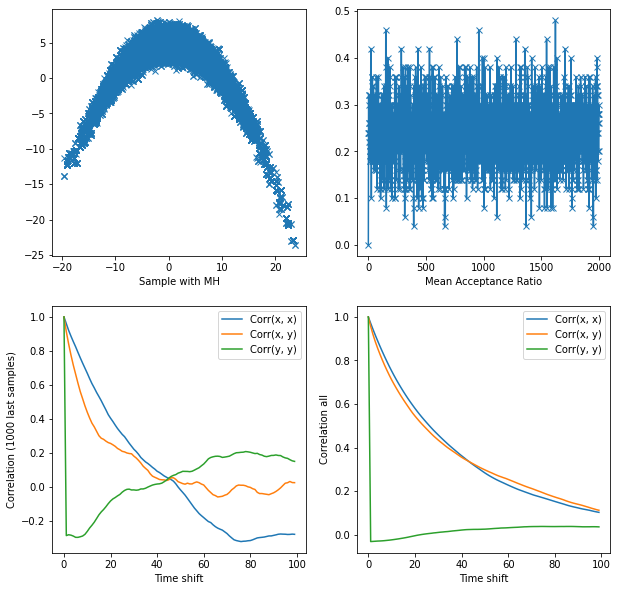

In [60]:
# fine tune to get acceptance ratio around .2
sample_size = 100000
samples, mean_rate = sampler_full([0, 0], target2, no_drift, 4, sample_size, batch_size=50)
print("Mean acceptance ratio", np.mean(mean_rate))

plot_graphs(samples, mean_rate)

Mean acceptance ratio 0.99089


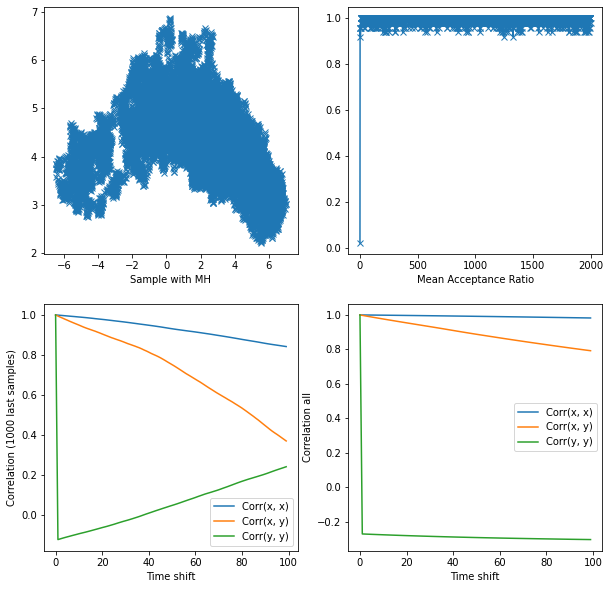

In [24]:
# fine tune to get acceptance ratio around .2
sample_size = 100000
samples, mean_rate = sampler_full([0, 0], target2, drift2, 5 * 1e-2, sample_size, batch_size=50)
print("Mean acceptance ratio", np.mean(mean_rate))

plot_graphs(samples, mean_rate)

sigma 9.588770323637693
mu [-0.00918123  0.03980638]
Lambda [[1.50063011 0.50571381]
 [0.50571381 1.50063011]]
Mean acceptance ratio 0.5703599999999999


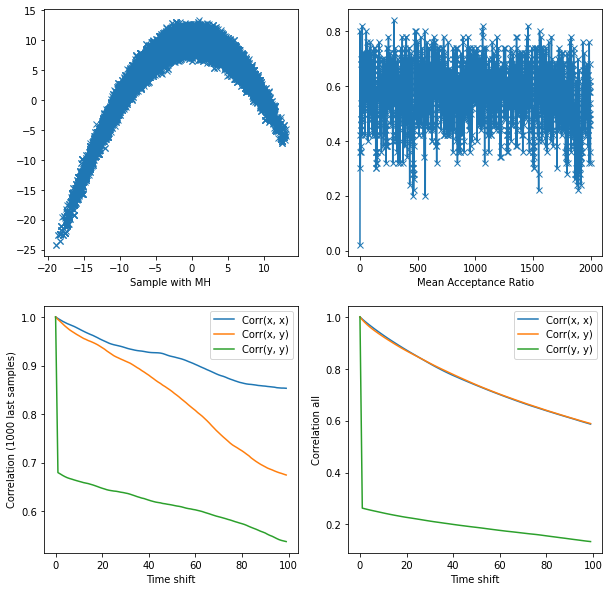

In [25]:
sample_size = 100000
samples, mean_rate = sampler_full_adaptive([0, 0], target2, no_drift, maxIter=sample_size, tau_bar=.2, batch_size=50)

print("Mean acceptance ratio", np.mean(mean_rate))
plot_graphs(samples, mean_rate)

**Comment**

Je n'ai pas l'impression que $\ŧau$ barre est une grande influence sur le résultat final (la méthode adaptative semble tout le temps converger vers un acceptance ratio aux alentours de .5